In [76]:
# Standard definitions needed for script
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math
import astropy
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from numpy.polynomial.polynomial import polyfit
import astropy.constants as const
from astropy.coordinates import Angle
import pickle
import pandas as pd
from matplotlib.patches import Rectangle
from sklearn.cluster import KMeans
import scipy
from sklearn import neighbors
from scipy.stats import kde
import filtermanage as fm
import copy
%matplotlib inline

#Read in local functions
#from CalculateProperties import CalculateProperties 

In [ ]:
#SIMBAD QUERY

for i in range(0,len(spd_c2didx)):
     ii = int(spd_c2didx[i])
     from astroquery.simbad import Simbad
     result_table = Simbad.query_region(SkyCoord(rac2df[ii]*u.degree,decc2df[ii]*u.degree, frame='icrs'), radius='0d0m40s')
     print(ii, rac2df[ii], decc2df[ii], result_table)

# Read in Data and Cross Match

In [77]:
#Read in GAIA data
file = 'Data/GAIA_data2.pkl'
with open(file,'rb') as f: 
    data = pickle.load(f)
GTab = data['GTab']

#Print column names
print (GTab.colnames)

#Assign columns from table to variables
Gra = GTab["ra"]
Gdec = GTab["dec"]
Gpmra = GTab["pmra"]
Gpmra_e = GTab["pmra_error"]
Gpmdec = GTab["pmdec"]
Gpmdec_e = GTab["pmdec_error"]
Gpar = GTab["parallax"]
Gpar_e = GTab['parallax_error']
Gpar_sn = GTab["parallax_over_error"]
Gsepar = GTab["angular_distance"]
G2MASS = GTab["designation_2"]
g = GTab["phot_g_mean_mag"]
b = GTab["phot_bp_mean_mag"]
r = GTab["phot_rp_mean_mag"]
J = GTab["j_m"]
H = GTab["h_m"]
K = GTab["ks_m"]
print(" GAIA Table contains ",len(Gra)," sources")


#calculate distance in pc 
Gdist = 1000./Gpar
Gdist_e = 1000./(Gpar**2)

#Calculate velocity in km/s
Gpmra_km = 4.74*(Gpmra/1000.)*Gdist
Gpmdec_km = 4.74*(Gpmdec/1000.)*Gdist

#Calculate uncertainty in velocity
Gpmra_km_e = Gpmra_km*np.sqrt((Gdist_e/Gdist)**2+(Gpmra_e/Gpmra)**2)
Gpmdec_km_e = Gpmdec_km*np.sqrt((Gdist_e/Gdist)**2+(Gpmdec_e/Gpmdec)**2)


#add variables to a dictionary
Gvalues = {'ra':Gra,'dec':Gdec,'pmra':Gpmra,'pmra_error':Gpmra_e,'pmdec':Gpmdec,'pmdec_error':Gpmdec_e,\
           'parallax':Gpar,'parallax_error':Gpar_e,'par_over_e':Gpar_sn,'Dist':Gdist,'Dist error':Gdist_e,\
           'pmra_km':Gpmra_km,'pmdec_km':Gpmdec_km,'pmra_km_e':Gpmra_km_e,'pmdec_km_e':Gpmdec_km_e}

#creates list of indentifiers from 2MASS
gaia_list = []
for i in range(0,len(G2MASS)):
    gaia_list.append(G2MASS[i].decode('utf-8'))

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

The minimum parallax is 1.6000160653931248
The maximum distance is 624.993724518822
The minimum parallax signal to noise is 3.0000975


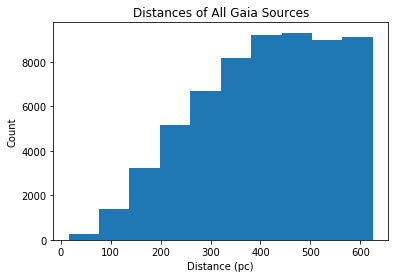

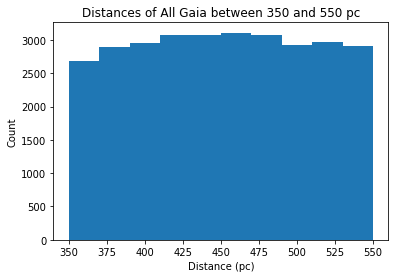

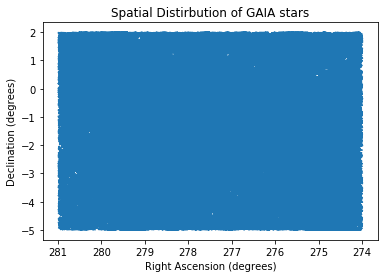

In [3]:
#Information about the parallax and distance ranges 
print('The minimum parallax is',Gpar.min())
max_distance = 1000/Gpar.min()
print('The maximum distance is',max_distance)
print('The minimum parallax signal to noise is',Gpar_sn.min())

#plot the distances of all of the stars
plt.hist(Gdist)
plt.title('Distances of All Gaia Sources')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.savefig('Figures/StarPlots/GaiaStars_All_distances.png',dpi=300)
plt.show()
#the numbers on the plot disagree because the bin sizes in the diagrams are different

Gdist2 = Gdist[Gdist >= 350]
plt.hist(Gdist2[Gdist2 <= 550])
plt.title('Distances of All Gaia between 350 and 550 pc')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.savefig('Figures/StarPlots/GaiaStars_350to550_distances.png',dpi=300)
plt.show()

plt.plot(Gra,Gdec)
plt.gca().invert_xaxis()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Spatial Distirbution of GAIA stars')
plt.savefig('Figures/StarPlots/GaiaStars_All_SpatialDistribution.png',dpi=300)
plt.show()

## Read in YSO and S+D Catalogs

In [4]:
#read in gould belt YSO catalog
infile = "Data/SERAQU-YSOs.tbl"
GBYSO = Table.read(infile,format="ascii.ipac")
print(GBYSO.colnames)
GBYSOra = GBYSO["ra"]
GBYSOdec = GBYSO["dec"]
GBYSO2MASS = GBYSO["id2mass"]
print("Read ",len(GBYSOra)," YSOs from GB YSO catalog")

#match Gould Belt YSO and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
GBYSO_match = np.empty(len(GBYSO2MASS),dtype=int); GBYSO_match.fill(-2)
for j in range(0,len(GBYSO2MASS)):
    if(GBYSO2MASS[j] in gaia_list):
        GBYSO_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

#read in gould belt stars + dust catalgog
infile = "Data/SERP_GB_star+dust.tbl"
GBSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
GBSDra = GBSD["ra"]
GBSDdec = GBSD["dec"]
GBSD2MASS = GBSD["id2mass"]
print("Read ",len(GBSDra)," YSOs from GB Star+Dust catalog")

#match Gould Belt stars+dust and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
GBSD_match = np.empty(len(GBSD2MASS),dtype=int); GBSD_match.fill(-2)
for j in range(0,len(GBSD2MASS)):
    if(GBSD2MASS[j] in gaia_list):
        GBSD_match[j] = gaia_list.index(GBSD2MASS[j])
    else:
        GBSD_match[j] = -2
good_GBSD = GBSD_match > -1
print(len(GBSD_match[good_GBSD]))
print(np.where(GBSD_match > -1))

#read in c2d YSO catalog 
infile = "Data/catalog-SER-YSOc.tbl"
c2dYSO = Table.read(infile,format="ascii.ipac")
print(c2dYSO.colnames)
c2dYSOra = c2dYSO["ra"]
c2dYSOdec = c2dYSO["dec"]
c2dYSO2MASS = c2dYSO["id2mass"]
c2dYSOobj = c2dYSO["object_type"]
print("Read ",len(c2dYSOra)," YSOs from c2d YSO catalog")

#match c2d YSO and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
c2dYSO_match = np.empty(len(c2dYSO2MASS),dtype=int); c2dYSO_match.fill(-2)
for j in range(0,len(c2dYSO2MASS)):
    if(c2dYSO2MASS[j] in gaia_list):
        c2dYSO_match[j] = gaia_list.index(c2dYSO2MASS[j])
    else:
        c2dYSO_match[j] = -2
good_c2dYSO = c2dYSO_match > -1
print(len(c2dYSO_match[good_c2dYSO]))
print(np.where(c2dYSO_match > -1))

#read in c2d YSO stars+dust catalog
infile = "Data/SERP_c2d_star+dust.tbl"
c2dSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
c2dSDra = c2dSD["ra"]
c2dSDdec = c2dSD["dec"]
c2dSD2MASS = c2dSD["id2mass"]
print("Read ",len(c2dSDra)," YSOs from c2d Star+Dust catalog")

#match c2d stars+dust and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
c2dSD_match = np.empty(len(c2dSD2MASS),dtype=int); c2dSD_match.fill(-2)
for j in range(0,len(c2dSD2MASS)):
    if(c2dSD2MASS[j] in gaia_list):
        c2dSD_match[j] = gaia_list.index(c2dSD2MASS[j])
    else:
        c2dSD_match[j] = -2
good_c2dSD = c2dSD_match > -1
print(len(c2dSD_match[good_c2dSD]))
print(np.where(c2dSD_match > -1))

#total number of YSO matches

#create array of YSO matches
YSO_match = c2dYSO_match; YSO_match = np.append(YSO_match,GBYSO_match)
good_YSO = YSO_match > -1
print("Total number of GAIA matches to YSOs: ",len(YSO_match[good_YSO]))

#Create array of Star + Dust matches
SD_match = c2dSD_match; SD_match = np.append(SD_match,GBSD_match)
good_SD = SD_match > -1
print("Total number of GAIA matches to star+dust: ",len(SD_match[good_SD]))

#Create array of all YSO and stars+dust matches
ALL_match = YSO_match
ALL_match = np.append(ALL_match,SD_match)
good_ALL = ALL_match > -1
print("Total number of all matches: ",len(ALL_match[good_ALL]))

['GBS_ID', 'ra', 'D_ra', 'dec', 'D_dec', 'Q_pos', 'Q_merge', 'id2mass', 'Prob_Galc', 'alpha', 'D_alpha', 'alpha_chi2', 'alpha_nfit', 'object_type', 'Av', 'D_Av', 'mag_IR1', 'D_mag_IR1', 'Av_chi2', 'Av_nfit', 'J_flux_c', 'J_D_flux_c', 'J_date_c', 'J_Q_det_c', 'H_flux_c', 'H_D_flux_c', 'H_date_c', 'H_Q_det_c', 'Ks_flux_c', 'Ks_D_flux_c', 'Ks_date_c', 'Ks_Q_det_c', 'IR1_flux_1', 'IR1_D_flux_1', 'IR1_date_1', 'IR1_Q_det_1', 'IR1_flux_2', 'IR1_D_flux_2', 'IR1_date_2', 'IR1_Q_det_2', 'IR1_flux_c', 'IR1_D_flux_c', 'IR1_date_c', 'IR1_Q_det_c', 'IR1_Q_flux_m', 'IR1_imtype', 'IR1_src_area', 'IR1_amajor', 'IR1_aminor', 'IR1_tilt', 'IR2_flux_1', 'IR2_D_flux_1', 'IR2_date_1', 'IR2_Q_det_1', 'IR2_flux_2', 'IR2_D_flux_2', 'IR2_date_2', 'IR2_Q_det_2', 'IR2_flux_c', 'IR2_D_flux_c', 'IR2_date_c', 'IR2_Q_det_c', 'IR2_Q_flux_m', 'IR2_imtype', 'IR2_src_area', 'IR2_amajor', 'IR2_aminor', 'IR2_tilt', 'IR3_flux_1', 'IR3_D_flux_1', 'IR3_date_1', 'IR3_Q_det_1', 'IR3_flux_2', 'IR3_D_flux_2', 'IR3_date_2', 'IR3_Q

In [5]:
#Read in galc files

#read in gould belt galc catalog
infile = "Data/GB_galc.tbl"
GBgalc = Table.read(infile,format="ascii.ipac")
print(GBgalc.colnames)
GBgalcra = GBgalc["ra"]
GBgalcdec = GBgalc["dec"]
GBgalc2MASS = GBgalc["id2mass"]
print("Read ",len(GBgalcra)," galcs from GB galc catalog")

#match Gould Belt galc and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
GBgalc_match = np.empty(len(GBgalc2MASS),dtype=int); GBgalc_match.fill(-2)
for j in range(0,len(GBgalc2MASS)):
    if(GBgalc2MASS[j] in gaia_list):
        GBgalc_match[j] = gaia_list.index(GBgalc2MASS[j])
    else:
        GBgalc_match[j] = -2
good_GBgalc = GBgalc_match > -1
print('The number of matches is',len(GBgalc_match[good_GBgalc]))
print(np.where(GBgalc_match > -1))
print("Distances:",Gvalues['Dist'][np.where(GBgalc_match > -1)])

#read in c2d galc catalog
infile = "Data/c2d_galc.tbl"
c2dgalc = Table.read(infile,format="ascii.ipac")
print(c2dgalc.colnames)
c2dgalcra = c2dgalc["ra"]
c2dgalcdec = c2dgalc["dec"]
c2dgalc2MASS = c2dgalc["id2mass"]
print("Read ",len(c2dgalcra)," glacs from c2d galc catalog")

#match Gould Belt galc and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
c2dgalc_match = np.empty(len(c2dgalc2MASS),dtype=int)
c2dgalc_match.fill(-2)
for j in range(0,len(c2dgalc2MASS)):
    if(c2dgalc2MASS[j] in gaia_list):
        c2dgalc_match[j] = gaia_list.index(c2dgalc2MASS[j])
    else:
        c2dgalc_match[j] = -2
good_c2dgalc = c2dgalc_match > -1
print('The number of matches is',len(c2dgalc_match[good_c2dgalc]))
print(np.where(c2dgalc_match > -1))
print("Distances:",Gvalues['Dist'][np.where(c2dgalc_match > -1)])

#create array of GALC matches
GALC_match = c2dgalc_match; GALC_match = np.append(GALC_match,GBgalc_match)
good_GALC = GALC_match > -1
print("Total number of GAIA matches to GALC: ",len(GALC_match[good_GALC]))

['GBS_ID', 'ra', 'D_ra', 'dec', 'D_dec', 'Q_pos', 'Q_merge', 'id2mass', 'Prob_Galc', 'alpha', 'D_alpha', 'alpha_chi2', 'alpha_nfit', 'object_type', 'Av', 'D_Av', 'mag_IR1', 'D_mag_IR1', 'Av_chi2', 'Av_nfit', 'J_flux_c', 'J_D_flux_c', 'J_date_c', 'J_Q_det_c', 'H_flux_c', 'H_D_flux_c', 'H_date_c', 'H_Q_det_c', 'Ks_flux_c', 'Ks_D_flux_c', 'Ks_date_c', 'Ks_Q_det_c', 'IR1_flux_1', 'IR1_D_flux_1', 'IR1_date_1', 'IR1_Q_det_1', 'IR1_flux_2', 'IR1_D_flux_2', 'IR1_date_2', 'IR1_Q_det_2', 'IR1_flux_c', 'IR1_D_flux_c', 'IR1_date_c', 'IR1_Q_det_c', 'IR1_Q_flux_m', 'IR1_imtype', 'IR1_src_area', 'IR1_amajor', 'IR1_aminor', 'IR1_tilt', 'IR2_flux_1', 'IR2_D_flux_1', 'IR2_date_1', 'IR2_Q_det_1', 'IR2_flux_2', 'IR2_D_flux_2', 'IR2_date_2', 'IR2_Q_det_2', 'IR2_flux_c', 'IR2_D_flux_c', 'IR2_date_c', 'IR2_Q_det_c', 'IR2_Q_flux_m', 'IR2_imtype', 'IR2_src_area', 'IR2_amajor', 'IR2_aminor', 'IR2_tilt', 'IR3_flux_1', 'IR3_D_flux_1', 'IR3_date_1', 'IR3_Q_det_1', 'IR3_flux_2', 'IR3_D_flux_2', 'IR3_date_2', 'IR3_Q

# Borders of Serpens Regions

In [6]:
#Coordinates that indicate the borders (in RA and Dec) of rectangular regions in 
#Serpens that contain sources used for analysis

#Serpens East
ra_min1 = 278.7
ra_max1 = 280.3
dec_min1 = -1
dec_max1 = 1.2
width1 = (ra_max1-ra_min1)
height1 = (dec_max1 - dec_min1)

#Borders for Serpens East region 
sky_region1 = [ra_min1,ra_max1,dec_min1,dec_max1]

#Region that contains all of W40, Serpens South, and West Arm
ra_min2 = 276.6
ra_max2 = 278.5
dec_min2 = -5.1
dec_max2 = -1.3
width2 = (ra_max2-ra_min2)
height2 = (dec_max2 - dec_min2)

#Borders for region that encloses W40, Serpens South, and West Arm
sky_region2 = [ra_min2,ra_max2,dec_min2,dec_max2]

#Region that contins both W40 and Serpens South
dec_split2 = -3.0
ra_min2u = ra_min2
ra_max2u = ra_max2
dec_min2u = dec_split2
dec_max2u = dec_max2
width2u = (ra_max2u-ra_min2u)
height2u = (dec_max2u-dec_min2u)

#Borders for region that encloses W40 and serpens south
sky_region2u = [ra_min2u,ra_max2u,dec_min2u,dec_max2u]

#West Arm
ra_min2d = ra_min2
ra_max2d = ra_max2
dec_min2d = dec_min2
dec_max2d = dec_split2
width2d = (ra_max2d-ra_min2d)
height2d = (dec_max2d-dec_min2d)

#Borders for West Arm Region
sky_region2d = [ra_min2d,ra_max2d,dec_min2d,dec_max2d]

#W40
ra_split2 = 277.51
ra_minW40 = ra_split2
ra_maxW40 = ra_max2
dec_minW40 = dec_min2u
dec_maxW40 = dec_max2u
widthW40 = (ra_maxW40-ra_minW40)
heightW40 = (dec_maxW40-dec_minW40)


#Borders for W40
sky_regionW40 = [ra_minW40,ra_maxW40,dec_minW40,dec_maxW40]

#Region next to W40 with the same area
sky_regionW40side = [ra_maxW40,ra_maxW40+widthW40,dec_minW40,dec_maxW40]

# Serpens South
ra_minS = ra_min2
ra_maxS = ra_split2
dec_minS = dec_min2u
dec_maxS = dec_max2u
widthS = (ra_maxS-ra_minS)
heightS = (dec_maxS-dec_minS)

#Borders for Serpens South 
sky_regionS = [ra_minS,ra_maxS,dec_minS,dec_maxS]

#Region that contains both Serpens Main and Serpens B
ra_min3 = 276.75
ra_max3 = 277.75
dec_min3 = -0.7
dec_max3 = 2.1
width3 = (ra_max3-ra_min3)
height3 = (dec_max3 - dec_min3)

#Borders for region that contains Serpens Main and Serpens B 
sky_region3 = [ra_min3,ra_max3,dec_min3,dec_max3]

#Serpens Main
dec_split3 = 0.4
ra_min3u = ra_min3
ra_max3u = ra_max3
dec_min3u = dec_split3
dec_max3u = dec_max3
width3u = (ra_max3u-ra_min3u)
height3u = (dec_max3u - dec_min3u)

#Borders for Serpens  Main
sky_region3u = [ra_min3u,ra_max3u,dec_min3u,dec_max3u]

#Serpens B
ra_min3d = ra_min3
ra_max3d = ra_max3
dec_min3d = dec_min3
dec_max3d = dec_split3
width3d = (ra_max3d-ra_min3d)
height3d = (dec_max3d - dec_min3d)

#Borders for Serpens South
sky_region3d = [ra_min3d,ra_max3d,dec_min3d,dec_max3d]

# Functions

In [7]:
def CalculateProperties(region,star_type,match,Gvalues,distance_range = [0.,630.],sky_region = [273.99,280.99,-5.,2.], \
                        adj=[0,0,0,0],exclude=np.array([6666666666666])):    
        '''
        Function to calculate the properties sources (YSO, Star+Dust, Galc or all)
        that have been cross matched with GAIA in a given region and distance range
        Calculates values for both all sources and for sources with parallax signal to noise greater than 10
        Uses median of sources with signal to noise greater than 10 to determine relative velocities
        Prints out properties and plots histograms and spatial plots of the data
        Plots are saved in Figures/region
        
        Inputs:
        region: String that indicates what region of Serpens we are looking at
        star_type: String that describes the type of source observed (YSO, S+D, Galc or Star)
        match: Array of indices of sources in GAIA table. Sources that do not have match have value of -2
        Gvalues: Dictionary that contains columns from GAIA table (not necessary to read in b/c global variable)
        distance rage: Distance range for sources. Default is [0,630]
        sky_region: Borders of region in which sources are located. Default is entire Serpens Cloud[273.99,280.99,-5.,2.]
        adj: Values to add to xlimit and ylimit to extend the plot region. Default is [0,0,0,0]
        exclude: Array of indices of sources in GAIA table of sources to EXCLUDE. Default is array with ridiculous value
        
        Outputs:
        result: Dictionary that contains arrays of properties of sources within specified distance and region
        'ra': array of right ascension
        'dec': array of declinations
        'pmra': array of proper motion in ra
        'pmra_e': arrya of error in proper motion in ra
        'pmdec': array of proper motion in declination
        'pmdec_e': array of error in proper motion in declination
        'par': array of parallax
        'par_e': array of parallax error
        'par_sn': array of parallax signal to noise
        'dist': array of distance
        'dist_e' array of distance errors
        'pmra_km': proper motion velocity in ra in km/s
        'pmra_km_e': error in proper motion velocity in ra in km/s,
        'pmdec_km': proper motion velocity in declination in km/s
        'pmdec_km_e': error in proper motion velocity in declination in km/s
        'mean_pmra': mean ra velocity of region (stars with parallax S/N >10)
        'mean_pmra_err': error in mean ra velocity of region (stars with parallax S/N >10)
        'mean_pmdec': mean dec velocity of region (stars with parallax S/N >10)
        'mean_pmdec_err': error in mean dec velocity of region (stars with parallax S/N >10)
        'median_pmra': median ra velocity of region (stars with parallax S/N >10)
        'median_pmra_err': error in median ra velocity of region (stars with parallax S/N >10)
        'median_pmdec': median dec velocity of region (stars with parallax S/N >10)
        'median_pmdec_err': error in median dec velocity of region (stars with parallax S/N >10)
        'rpmra': relative velocity in ra (compared with median of stars with parallax S/N >10)
        'rpmra_e': error in relative velocity in ra (compared with median of stars with parallax S/N >10)
        'rpmdec': relative velocity in dec (compared with median of stars with parallax S/N >10)
        'rpmdec_e': error in relative velocity in dec (compared with median of stars with parallax S/N >10)
        'rpmmag': magnitude of relative velocity
        'rpmmag_err': error in magnitude of relative velocity of star
        'pmmag': magnitude of proper motion velocity (stars with parallax S/N >10)
        'pmmag_err': error in magnitude of proper motion velocity (stars with parallax S/N >10)
        'mean_pmmag': mean magnitude of proper motion velocity (stars with parallax S/N >10)?
        'mean_pmmag_err': error in mean magnitude of proper motion velocity (stars with parallax S/N >10)?
        'median_pmmag': median magnitude of proper motion velocity (stars with parallax S/N >10)?
        'median_pmmag_err': error in median magnitude of proper motion velocity (stars with parallax S/N >10)?
        'parsn5': array with true/false if star has parallax S/N > 5
        'parsn10': array with true/false if star has parallax S/N > 10
        'parsn20': array with true/false if star has parallax S/N > 20
        'id': array of gaia identifiers
        'pmmag_std': standard deviation of proper motion velocity magnitude (stars with parallax S/N >10)?
        'par_std': standard deviation of parallaxes
        'pmmag_all': proper motion magnitudes determined for all stars
        'pmmag_all_err': error in proper motion magnitude determined for all stars
        'source_category': type of source ('YSO or S+D') THIS IS ONLY MEANINGFUL IF THE INPUT FOR match is ALL_match
        '''
    
        #create arrays that will contain properties about sources within a region
        good_match = match > -1
        identifiers = np.array([])      #gaia index 
        ra_match = np.array([])         #RA coordinates
        dec_match = np.array([])        #Dec coordinates
        pmra_match = np.array([])       #proper motion in RA
        pmdec_match = np.array([])      #proper motion in Dec
        pmra_e_match = np.array([])     #proper motion error in RA
        pmdec_e_match = np.array([])    #proper motion error in Dec
        par_match = np.array([])        #parallax
        par_e_match = np.array([])      #parallax error
        par_sn_match = np.array([])     #parallax signal to noise
        dist_match = np.array([])       #distance
        dist_e_match = np.array([])     #distance error
        pmra_km_match = np.array([])    #velocity in RA
        pmdec_km_match = np.array([])   #velocity in Dec
        pmra_km_e_match = np.array([])  #error in velocity in RA
        pmdec_km_e_match = np.array([]) #error in velocity in RA
        source_category = np.array([])  #type of source
        n = 0
    
        #Add propeties to arrays of sources that meet distance and region condition
        for i in range(0,len(match)):
            #Source must have GAIA match and must not be in exclude list
            if(match[i] > -1 and (not np.any(exclude[:]==match[i]))):
                #Index in GAIA catalog
                j = match[i]
                #Filter sources according to distance and region in the sky
                if(Gvalues['Dist'][j] >= distance_range[0] and Gvalues['Dist'][j] <= distance_range[1] \
                   and Gvalues['ra'][j] > sky_region[0] and Gvalues['ra'][j] < sky_region[1] \
                   and Gvalues['dec'][j] > sky_region[2] and Gvalues['dec'][j] < sky_region[3]):
                    identifiers = np.append(identifiers,j)
                    ra_match = np.append(ra_match,Gvalues['ra'][j])
                    dec_match = np.append(dec_match,Gvalues['dec'][j])
                    pmra_match = np.append(pmra_match,Gvalues['pmra'][j])
                    pmdec_match = np.append(pmdec_match,Gvalues['pmdec'][j])
                    pmra_e_match = np.append(pmra_e_match,Gvalues['pmra_error'][j])
                    pmdec_e_match = np.append(pmdec_e_match,Gvalues['pmdec_error'][j])
                    par_match = np.append(par_match,Gvalues['parallax'][j])
                    par_e_match = np.append(par_e_match,Gvalues['parallax_error'][j])
                    par_sn_match = np.append(par_sn_match,Gvalues['par_over_e'][j])
                    dist_match = np.append(dist_match,Gvalues['Dist'][j])
                    dist_e_match = np.append(dist_e_match, Gvalues['Dist error'][j])
                    pmra_km_match = np.append(pmra_km_match,Gvalues['pmra_km'][j])
                    pmdec_km_match = np.append(pmdec_km_match,Gvalues['pmdec_km'][j])
                    pmra_km_e_match = np.append(pmra_km_e_match,Gvalues['pmra_km_e'][j])
                    pmdec_km_e_match = np.append(pmdec_km_e_match,Gvalues['pmdec_km_e'][j])
                    #determine what category the source is in 
                    if (i >= 0 and i <= 1703):
                        source_category = np.append(source_category,'YSO')
                    elif (i >= 1704):
                        source_category = np.append(source_category,'S+D')
                    
                    n=n+1
        print("Number of "+ region +" matches in the correct distance interval:",n)
    
        #Find number of match within parallax S/N greater than 5,10 and 20
        parsn5 = par_sn_match > 5.
        parsn10 = par_sn_match > 10.
        parsn20 = par_sn_match > 20.
        print("Number of _match with parallax > 5, 10, 20: ", \
          len(par_sn_match[parsn5]),len(par_sn_match[parsn10]),len(par_sn_match[parsn20]))
        
        #Properties determined without Condition!
        #mean velocity of region (determined using all stars)
        mean_pmra_all = np.mean(pmra_km_match)
        mean_pmdec_all = np.mean(pmdec_km_match)
        #error in mean velocity (determined using all stars)
        mean_pmra_all_err = np.std(pmra_km_match)/np.sqrt(len(pmra_km_match))
        mean_pmdec_all_err = np.std(pmdec_km_match)/np.sqrt(len(pmdec_km_match))
        #median velocity of region (determined using all stars)
        median_pmra_all = np.median(pmra_km_match)
        median_pmdec_all = np.median(pmdec_km_match)
        #error in median velocity (determined using all stars)
        median_pmra_all_err = np.sqrt(np.pi/2)*mean_pmra_all_err
        median_pmdec_all_err = np.sqrt(np.pi/2)*mean_pmdec_all_err
          
        #Properties determined with Condition!
        #mean velocity of region (determined using stars with paralax S/N >10)
        mean_pmra = np.mean(pmra_km_match[parsn10])
        mean_pmdec = np.mean(pmdec_km_match[parsn10])
        #error in mean velocity (determined using stars with paralax S/N >10)
        mean_pmra_err = np.std(pmra_km_match[parsn10])/np.sqrt(len(pmra_km_match[parsn10]))
        mean_pmdec_err = np.std(pmdec_km_match[parsn10])/np.sqrt(len(pmdec_km_match[parsn10]))
        #median velocity of region (determined using stars with paralax S/N >10)
        median_pmra = np.median(pmra_km_match[parsn10])
        median_pmdec = np.median(pmdec_km_match[parsn10])
        #error in median velocity (determined using stars with paralax S/N >10)
        median_pmra_err = np.sqrt(np.pi/2)*mean_pmra_err
        median_pmdec_err = np.sqrt(np.pi/2)*mean_pmdec_err
          
          
        #All of these properties are calculated for all stars
        #relative velocity
        rpmra_match = pmra_km_match - median_pmra
        rpmdec_match = pmdec_km_match - median_pmdec
          
        #error of relative velocity
        rpmra_err_match = np.sqrt(np.square(median_pmra_err)+np.square(pmra_km_e_match))
        rpmdec_err_match = np.sqrt(np.square(median_pmdec_err)+np.square(pmdec_km_e_match))
          
        #magnitude of relative velocity
        rpmmag_match = np.zeros(len(match[good_match]))
        rpmmag_match = np.power((rpmra_match*rpmra_match+rpmdec_match*rpmdec_match),0.5)
          
        #error in magnitude of relative velocity
        rpmmag_err_match = np.sqrt((rpmra_match*rpmra_err_match)**2+(rpmdec_match*rpmdec_err_match)**2)/rpmmag_match
          
        #magnitude of velocity(all stars)
        pmmag_match_all = np.sqrt(np.square(pmra_km_match)+np.square(pmdec_km_match))
        pmmag_err_match_all= (np.sqrt((pmra_km_match*pmra_km_e_match)**2+pmdec_km_match*pmdec_km_e_match)\
                                 **2)/pmmag_match_all
        #magnitude of velocity(stars with parallax signal to noise greater than 10)
        pmmag_match = np.sqrt(np.square(pmra_km_match[parsn10])+np.square(pmdec_km_match[parsn10]))
        pmmag_err_match = (np.sqrt((pmra_km_match[parsn10]*pmra_km_e_match[parsn10])**2\
                                     +pmdec_km_match[parsn10]*pmdec_km_e_match[parsn10])**2)/pmmag_match
          
        #mean and median of magnitude
        #all stars
        mean_pmmag_all = np.mean(pmmag_match_all)
        median_pmmag_all = np.median(pmmag_match_all)
        mean_pmmag_all_err = np.std(pmmag_match_all)/np.sqrt(len(pmmag_match_all))
        median_pmmag_all_err = np.sqrt(np.pi/2)*mean_pmmag_all_err
        #stars with parallax signal to noise greater than 10
        mean_pmmag = np.mean(pmmag_match)
        median_pmmag = np.median(pmmag_match)
        mean_pmmag_err = np.std(pmmag_match)/np.sqrt(len(pmmag_match))
        median_pmmag_err = np.sqrt(np.pi/2)*mean_pmmag_err
          
        #Standard deviation of magnitude of velocity
        pmmag_std = np.std(pmmag_match)
        pmmag_std_all = np.std(pmmag_match_all)
          
        #Standard deviation of parallax
        par_std = np.std(par_match[parsn10])
        par_std_all = np.std(par_match)
          
        #Median of parallax
        par_median = np.median(par_match[parsn10])
        par_median_all = np.median(par_match)
        
        #standard deviation  and median of distance (NEED TO ADD TO DICTIONARY)
        dist_std_all = np.std(dist_match)
        dist_median_all = np.median(dist_match)
          
        #print info
          
        print('For all stars in region')
        print('The mean velocity in ra is ',mean_pmra_all,'+/-',mean_pmra_all_err)
        print('The mean velocity in dec is ',mean_pmdec_all,'+/-',mean_pmdec_all_err)
        print('The median velocity in ra is ',median_pmra_all,'+/-',median_pmra_all_err)
        print('The median velocity in dec is ',median_pmdec_all,'+/-',median_pmdec_all_err)
        print('The mean magnitude of velocity is',mean_pmmag_all,'+/-',mean_pmmag_all_err)
        print('The median magnitude of velocity is',median_pmmag_all,'+/-',median_pmmag_all_err)
        print('The standard deviation of velocity is',pmmag_std_all)
        print('The median parallax is',par_median_all,'with a standard deviation of',par_std_all)
        print('The median distance is',dist_median_all,'with a standard deviation of',dist_std_all)
        print('For parallax S/N > 10 stars:')
        print('The mean velocity in ra is ',mean_pmra,'+/-',mean_pmra_err)
        print('The mean velocity in dec is ',mean_pmdec,'+/-',mean_pmdec_err)
        print('The median velocity in ra is ',median_pmra,'+/-',median_pmra_err)
        print('The median velocity in dec is ',median_pmdec,'+/-',median_pmdec_err)
        print('The mean magnitude of velocity is',mean_pmmag,'+/-',mean_pmmag_err)
        print('The median magnitude of velocity is',median_pmmag,'+/-',median_pmmag_err)
        print('The standard deviation of velocity is',pmmag_std)
        print('The median parallax is',par_median,'with a standard deviation of',par_std)
          
        #PLOTS
          
        #name to store files under
        category = "Figures/"+region.replace(" ","")+"/"+region.replace(" ","")+"_"+star_type+"_"
          
        #scatter plot of ra and dec
        plt.scatter(ra_match,dec_match,s=5)
        plt.xlabel('Right Ascension (Degrees)')
        plt.ylabel('Declination (Degrees)')
        plt.title('Spatial Distribution of '+ star_type +' in '+region)
        plt.gca().invert_xaxis()
        plt.show()
          
        #scatter plot of proper motions
        plt.errorbar(pmra_match,pmdec_match,xerr=pmra_e_match,yerr = pmdec_e_match,markersize=10,linestyle='None',color='black')
        plt.xlabel('Proper motion in Right Ascension (mas/yr)')
        plt.ylabel('Proper motion in Declination (mas/yr)')
        plt.title('Proper Motions of ' + star_type +' in '+ region)
        plt.gca().invert_xaxis()
        plt.savefig(category+"ProperMotion.png", dpi=300)
        plt.show()
          
        #scatter plot of velocities (km/s)
        plt.errorbar(pmra_km_match,pmdec_km_match,xerr=pmra_km_e_match,yerr = pmdec_km_e_match,markersize=10,linestyle='None',color='black')
        #plt.scatter(pmra_km_match,pmdec_km_match,s=5)
        plt.xlabel('Velocity in Right Ascension (km/s)')
        plt.ylabel('Velocity in Declination (km/s)')
        plt.title('Velocities of '+ star_type +' in '+ region)
        plt.gca().invert_xaxis()
        plt.show()
        
        #scatter plot of relative velocities (km/s)
        plt.errorbar(rpmra_match,rpmdec_match,xerr=rpmra_err_match,yerr = rpmdec_err_match,markersize=10,linestyle='None',color='black')
        plt.xlabel('Relative Velocity in Right Ascension (km/s)')
        plt.ylabel('Relative Velocity in Declination (km/s)')
        plt.title('Relative Velocities of '+ star_type +' in '+ region)
        plt.gca().invert_xaxis()
        plt.savefig(category+"RelativeMotion.png", dpi=300)
        plt.show()
          
        #histograms of pmra, pmdec, pmmag, rpmra, rpmdec, rpmmag, distance
        plt.hist(pmra_km_match)
        plt.title('Velocity in RA')
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('Count')
        plt.show()
        plt.hist(pmdec_km_match)
        plt.title('Velocity in Dec')
        plt.xlabel('Velocity (km/s)')
        plt.show()
        plt.hist(pmmag_match,bins=15)
        plt.title('Magnitude of Velocity')
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('Count')
        plt.savefig(category+"Velocity_histogram.png", dpi =300)
        plt.show()
        plt.hist(rpmra_match)
        plt.title('Velocity Relative to Median in RA')
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('Count')
        plt.show()
        plt.hist(rpmdec_match)
        plt.title('Velocity Relative to Median in Dec')
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('Count')
        plt.show()
        plt.hist(rpmmag_match,bins=15)
        plt.title('Magnitude of Relative Velocity')
        plt.xlabel('Magnitude of Relative Velocity (km/s)')
        plt.ylabel('Count')
        plt.savefig(category+"RelVelocity_histogram.png", dpi =300)
        plt.show()
        plt.hist(rpmmag_match,bins=15)
        plt.title('Distances')
        plt.xlabel('Distance (pc)')
        plt.ylabel('Count')
        plt.savefig(category+"Distance_histogram.png", dpi =300)
        plt.show()
          
        #Errorbar plot of magnitude of relative velocity against parallax
        plt.errorbar(par_match,rpmmag_match,xerr=par_e_match,yerr = rpmmag_err_match,linestyle='none',marker='o',color='k')
        plt.xlabel('Parallax (mas)')
        plt.ylabel('Magnitude of Relative Velocity (km/s)')
        plt.title('Magnitude of Relative Velocity vs. Parallax of '+star_type)
        plt.savefig(category+"RelVelocity_errorbar.png", dpi=300)
        plt.show()
          
        #Errorbar plot of magnitude of relative velocity against distance
        plt.errorbar(dist_match,rpmmag_match,xerr=dist_e_match,yerr = rpmmag_err_match,linestyle='none',marker='o',color='k')
        plt.xlabel('Distance (pc)')
        plt.ylabel('Magnitude of Relative Velocity (km/s)')
        plt.title('Magnitude of Relative Velocity vs. Distance of '+star_type)
        plt.savefig(category+"RelVelocity_distance_errorbar.png", dpi=300)
        plt.show()
          
        #Errorbar plot of magnitude velocity against parallax
        plt.errorbar(par_match,pmmag_match_all,xerr=par_e_match,yerr = pmmag_err_match_all,linestyle='none',\
                       marker='o',color='k')
        plt.xlabel('Parallax (pc)')
        plt.ylabel('Magnitude of Velocity (km/s)')
        plt.title('Magnitude of Velocity vs. Parallax of ' + star_type)
        plt.savefig(category+"pmmag_errorbar.png", dpi=300)
        plt.show()
          
        #Errorbar plot of magnitude velocity against distance
        plt.errorbar(dist_match,pmmag_match_all,xerr=dist_e_match,yerr = pmmag_err_match_all,linestyle='none',\
                       marker='o',color='k')
        plt.xlabel('Distance (pc)')
        plt.ylabel('Magnitude of Velocity (km/s)')
        plt.title('Magnitude of Velocity vs. Distance of ' + star_type)
        plt.savefig(category+"pmmag_distance_errorbar.png", dpi=300)
        plt.show()
          
        #plot of matches at ra and dec with velocity indicated as arrow
        plt.quiver(ra_match,dec_match,pmra_km_match,pmdec_km_match,pmmag_match)
        plt.axis('equal')
        plt.xlabel('Right Ascension (Degrees)')
        plt.ylabel('Declination (Degrees)')
        plt.title('Spatial Distribution of '+ star_type +' in '+region)
        plt.xlim(sky_region[0]-adj[0],sky_region[1]+adj[1])
        plt.ylim(sky_region[2]-adj[2],sky_region[3]+adj[3])
        plt.gca().invert_xaxis()
        c = plt.colorbar()
        c.set_label('Magnitude of Velocity (km/s)')
        plt.savefig(category+"pmmag.png",dpi = 300)
        plt.show()
          
        #plot of matches at ra and dec with relative velocity indicated as arrow
        plt.quiver(ra_match,dec_match,rpmra_match,rpmdec_match,rpmmag_match)
        plt.axis('equal')
        plt.xlabel('Right Ascension (Degrees)')
        plt.ylabel('Declination (Degrees)')
        plt.title('Spatial Distribution of ' + star_type + ' in ' + region)
        plt.xlim(sky_region[0]-adj[0],sky_region[1]+adj[1])
        plt.ylim(sky_region[2]-adj[2],sky_region[3]+adj[3])
        plt.gca().invert_xaxis()
        c = plt.colorbar()
        c.set_label('Magnitude of Relative Velocity (km/s)')
        plt.savefig(category+"RelVelocity_plot.png",dpi=300)
        plt.show()
          
        #Dictionary of properties of sources within region and distance range
        result = {'ra':ra_match,'dec':dec_match,'pmra':pmra_match,'pmra_e':pmra_e_match, 'pmdec':pmdec_match,\
            'pmdec_e':pmdec_e_match,'par':par_match,'par_e':par_e_match,'par_sn':par_sn_match,'dist':dist_match,\
              'dist_e':dist_e_match,'pmra_km':pmra_km_match,'pmra_km_e':pmra_km_e_match,'pmdec_km':pmdec_km_match,\
              'pmdec_km_e':pmdec_km_e_match,'mean_pmra':mean_pmra,'mean_pmra_err':mean_pmra_err,\
              'mean_pmdec':mean_pmdec,'mean_pmdec_err':mean_pmdec_err,'median_pmra':median_pmra,\
              'median_pmra_err':median_pmra_err,'median_pmdec':median_pmdec,'median_pmdec_err':median_pmdec_err,\
              'rpmra':rpmra_match,'rpmra_e':rpmra_err_match,'rpmdec':rpmdec_match,'rpmdec_e':rpmdec_err_match,\
              'rpmmag':rpmmag_match,'rpmmag_err':rpmmag_err_match,'pmmag':pmmag_match, 'pmmag_err':pmmag_err_match,\
              'mean_pmmag':mean_pmmag,'mean_pmmag_err':mean_pmmag_err, 'median_pmmag':median_pmmag,\
              'median_pmmag_err':median_pmmag_err,'parsn5':parsn5,'parsn10':parsn10,'parsn20':parsn20,\
              'id':identifiers,'pmmag_std':pmmag_std,'par_std':par_std,'pmmag_all':pmmag_match_all,\
              'pmmag_all_err':pmmag_err_match_all,'source_category':source_category}

        return result

In [8]:
def chisqr(obs,exp,err):
    '''
    Function to calculate chi^2
    
    Inputs:
    obs: 1D array of observed values
    exp: 1D array of expected values
    err: 1D array of error in expected values
    
    Outputs: 
    chisqr: chi^2 value
    '''
    
    chi_squared_stat = 0
    
    for i in range(len(obs)):
        chi_squared_stat = chi_squared_stat + (((obs[i]-exp[i])**2)/err[i])
        
    return chi_squared_stat


In [9]:
def ConditionToRegion(region,parsn,regionName,star_type,sky_region = [273.99,280.99,-5.,2.],adj=[0,0,0,0]):
    
    '''
    Function to calculate the properties of sources in a region that have parallax S/N greater than a certain amount
    Prints out properties and plots histograms. 
    
    Inputs:
    region: Dictionary of properties determined for a region by the function CalculateProperties
    parsn: Condition for parallax S/N to be greater than specified amount
    regionName: String that indicates what region of Serpens we are looking at
    star_type: String that describes the type of source observed (YSO,S+D or Star)
    sky_region: Borders of region in which sources are located. Default is entire Serpens Cloud[273.99,280.99,-5.,2.]
    adj: Values to add to xlimit and ylimit to extend the plot region. Default is [0,0,0,0]
    
    Outputs:
    none
    '''
    
    #THESE MIGHT NOT NEED TO BE RECALCULATED
    #magnitude of velocity
    pmmag_km_match = np.sqrt(np.square(region['pmra_km'][parsn])+np.square(region['pmdec_km'][parsn]))
    
    #error in magnitude of velocity
    pmmag_km_err_match = (np.sqrt(np.square(region['pmra_km'][parsn]*region['pmra_km_e'][parsn])+\
                        np.square(region['pmdec_km'][parsn]*region['pmdec_km_e'][parsn])))/pmmag_km_match
    #######################################
    
    #mean magnitude of velocity
    mean_pmmag = np.mean(pmmag_km_match)
    
    #median magnitude of velocity
    median_pmmag = np.median(pmmag_km_match)
    
    #error in mean magnitude of velocity
    mean_pmmag_err = np.std(pmmag_km_match)/np.sqrt(len(pmmag_km_match))
    
    #error in median magnitude of velocity
    median_pmmag_err = np.sqrt(np.pi/2)*mean_pmmag_err
    
    #standard deviation of velocity
    pmmag_std = np.std(pmmag_km_match)
    
    #standard deviation of parallax
    par_std = np.std(region['par'][parsn])
    
    #median of parallax
    par_median = np.median(region['par'][parsn])
    
    #standard deviation of distance
    dist_std = np.std(region['dist'][parsn])
    
    #median of distance
    dist_median = np.median(region['dist'][parsn])
    
    
    #Print Properties
    print('The median magnitude of proper motion is',median_pmmag,'+/-',median_pmmag_err)
    print('The standard deviation of proper motion is',pmmag_std)
    print('The median parallax is',par_median,'with a standard deviation of ',par_std)
    print('The median distance is',dist_median,'with a standard deviation of ',dist_std)
    
    #histogram of pmra, pmdec, pmmag
    plt.hist(region['pmra_km'][parsn])
    plt.title('Velocity in RA')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(region['pmdec_km'][parsn])
    plt.title('Velocity in Dec')
    plt.xlabel('Proper Motion (km/s)')
    plt.show()
    plt.hist(pmmag_km_match,bins=15)
    plt.title('Magnitude of Velocity')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    
    #name to store files under
    category = "Figures/parsn5/"+regionName.replace(" ","")+"/parsn5"+regionName.replace(" ","")+"_"+star_type+"_"
          
    #scatter plot of ra and dec
    plt.scatter(region['ra'][parsn],region['dec'][parsn],s=5)
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Spatial Distribution of '+ star_type +' in '+regionName)
    plt.gca().invert_xaxis()
    plt.show()
          
    #scatter plot of proper motions
    plt.errorbar(region['pmra'][parsn],region['pmdec'][parsn],xerr=region['pmra_e'][parsn],yerr= region['pmdec_e'][parsn],markersize=10,linestyle='None',color='black')
    plt.xlabel('Proper motion in Right Ascension (mas/yr)')
    plt.ylabel('Proper motion in Declination (mas/yr)')
    plt.title('Proper Motions of ' + star_type +' in '+ regionName)
    plt.gca().invert_xaxis()
    plt.savefig(category+"ProperMotion.png", dpi=300)
    plt.show()
          
        
    #scatter plot of relative velocities (km/s)
    plt.errorbar(region['rpmra'][parsn],region['rpmdec'][parsn],xerr=region['rpmra_e'][parsn],yerr = region['rpmdec_e'][parsn],markersize=10,linestyle='None',color='black')
    plt.xlabel('Relative Velocity in Right Ascension (km/s)')
    plt.ylabel('Relative Velocity in Declination (km/s)')
    plt.title('Relative Velocities of '+ star_type +' in '+ regionName)
    plt.gca().invert_xaxis()
    plt.savefig(category+"RelativeMotion.png", dpi=300)
    plt.show()
    
    #Errorbar plot of magnitude of relative velocity against parallax
    plt.errorbar(region['par'][parsn],region['rpmmag'][parsn],xerr = region['par_e'][parsn],yerr=region['rpmmag_err'][parsn],linestyle='none',marker='o',color='k')
    plt.xlabel('Parallax (mas)')
    plt.ylabel('Magnitude of Relative Velocity (km/s)')
    plt.title('Magnitude of Relative Velocity vs. Parallax of '+star_type)
    plt.savefig(category+"RelVelocity_errorbar.png", dpi=300)
    plt.show()
          
    #Errorbar plot of magnitude of relative velocity against distance
    plt.errorbar(region['dist'][parsn],region['rpmmag'][parsn],xerr = region['dist_e'][parsn],yerr=region['rpmmag_err'][parsn],linestyle='none',marker='o',color='k')
    plt.xlabel('Distance (pc)')
    plt.ylabel('Magnitude of Relative Velocity (km/s)')
    plt.title('Magnitude of Relative Velocity vs. Distance of '+star_type)
    plt.savefig(category+"RelVelocity_distance_errorbar.png", dpi=300)
    plt.show()
          
    #Errorbar plot of magnitude velocity against parallax
    plt.errorbar(region['par'][parsn],pmmag_km_match,xerr = region['par_e'][parsn],yerr=pmmag_km_err_match,linestyle='none',\
                       marker='o',color='k')
    plt.xlabel('Parallax (pc)')
    plt.ylabel('Magnitude of Velocity (km/s)')
    plt.title('Magnitude of Velocity vs. Parallax of ' + star_type)
    plt.savefig(category+"pmmag_errorbar.png", dpi=300)
    plt.show()
          
    #Errorbar plot of magnitude velocity against distance
    plt.errorbar(region['dist'][parsn],pmmag_km_match,xerr = region['dist_e'][parsn],yerr=pmmag_km_err_match,linestyle='none',\
                       marker='o',color='k')
    plt.xlabel('Distance (pc)')
    plt.ylabel('Magnitude of Velocity (km/s)')
    plt.title('Magnitude of Velocity vs. Distance of ' + star_type)
    plt.savefig(category+"pmmag_distance_errorbar.png", dpi=300)
    plt.show()
          
    #plot of matches at ra and dec with velocity indicated as arrow
    plt.quiver(region['ra'][parsn],region['dec'][parsn],region['pmra_km'][parsn],region['pmdec_km'][parsn],pmmag_km_match)
    plt.axis('equal')
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Spatial Distribution of '+ star_type +' in '+regionName)
    plt.xlim(sky_region[0]-adj[0],sky_region[1]+adj[1])
    plt.ylim(sky_region[2]-adj[2],sky_region[3]+adj[3])
    plt.gca().invert_xaxis()
    c = plt.colorbar()
    c.set_label('Magnitude of Velocity (km/s)')
    plt.savefig(category+"pmmag.png",dpi = 300)
    plt.show()
          
    #plot of matches at ra and dec with relative velocity indicated as arrow
    plt.quiver(region['ra'][parsn],region['dec'][parsn],region['rpmra'][parsn],region['rpmdec'][parsn],region['rpmmag'][parsn])
    plt.axis('equal')
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Spatial Distribution of ' + star_type + ' in ' + regionName)
    plt.xlim(sky_region[0]-adj[0],sky_region[1]+adj[1])
    plt.ylim(sky_region[2]-adj[2],sky_region[3]+adj[3])
    plt.gca().invert_xaxis()
    c = plt.colorbar()
    c.set_label('Magnitude of Relative Velocity (km/s)')
    plt.savefig(category+"RelVelocity_plot.png",dpi=300)
    plt.show()
    
    return

In [10]:
# Routines to convert magnitude to flux and vice versa for various wavebands.
#
# Additional wavebands can be added easily.
# MWP - Fri Jul 20 10:34:24 EDT 2018
#

# Mean wavelengths and effective bandwidths in angstroms & Zero Points in Jansky of various filters, 
# taken from VOSA website.  # http://svo2.cab.inta-csic.es/theory/fps/
# Format is dictionary of tuples:
#  {'Bandname':(Lambda_mean,BW_eff, ZP)}
#
sloan   = {'u':(3561.8,558.4,1568.5),'g':(4718.9,1158.4,3965.9),'r':(6185.2,1111.2,3162.0),'i':(7499.7,1044.6,2602.0),'z':(8961.5,1124.6,2244.7)}
gaia    = {'BP':(5279.9,2347.4,3534.7),'G':(6742.5,4183.0,3296.2),'RP':(7883.7,2756.8,2620.3)}
# Gaia 2nd Release (GAIA2r) values
gaia2   = {'BP':(5278.6,2279.4,3393.3),'G':(6773.7,4358.4,2835.1),'RP':(7919.1,2943.7,2485.1)}
twomass = {'J':(12350.0,1624.1,1594.0), 'H':(16620.0, 2509.4,1024.0), 'K':(21590.0,2618.9,666.8)}
spitzer = {'I1':(35572.6,6836.2,277.2), 'I2':(45049.3,8649.9,179.0), 'I3':(57385.7,12561.2,113.8), 'I4':(79273.7,25288.5,62.0), 'M24':(238433.1,52963.2,7.1), 'M70':(725555.3,213015.3,0.8), 'M160':(1569627.1,357530.2,0.2)}
herschel = {'PACSB':(719334.2,214148.9,0.8),'PACSG':(1026174.6,312860.0,0.4),'PACSR':(1671355.3,697595.3,0.1)}
#
# All filters -- Dictionary of dictionaries
#
filters = { "sloan": sloan, "gaia" : gaia, "twomass":twomass, "spitzer": spitzer, "herschel": herschel}

# Return given (milli)jansky
# Example: magtoflux("sloan","u",10)  returns 156.85 mJy 
def magtoflux(telescope,filter,magnitude,mjy=True):
    """Return the flux in Jansky or milliJansky of a source given its magnitude.
       Parameters:
          telescope - string telescope name lowercase, one of
                      sloan, gaia, twomass, spitzer, herschel
          filter    - wave band of telescope e.g., 'u' for sloan, 'I1' for spitzer
          magnitude - magnitude of source
          mjy       - boolean to return flux in mJy. True returns mJy, False returns Jy. Default:True
    """
    zpjy = filters[telescope][filter][2]
    if mjy==True: zpjy *= 1000.0
    return zpjy*10.0**(magnitude/-2.5)

# Return magnitude given jansky
# @todo allow mJy input as well
# Requires "import numpy as np"
# Example: fluxtomag("sloan","u",156.85)  returns 10 mag
def fluxtomag(telescope,filter,flux,mjy=True):
    """Return the magnitude given flux in Jansky
       Parameters:
          telescope - string telescope name lowercase, one of
                      sloan, gaia, twomass, spitzer, herschel
          filter    - wave band of telescope e.g., 'u' for sloan, 'I1' for spitzer
          flux      - flux of source in Jy or mJy
          mjy       - boolean, True if flux was given in mJy False if Jy
    """
    zpjy = filters[telescope][filter][2]
    if mjy==True: 
        cflux = 0.001
    else: 
        cflux = 1.0
    return -2.5*np.log10(cflux*flux/zpjy)

In [24]:
#Create Function that plots SEDs given an id that was pre-selected, and identification as YSO or Star+Dust

#read in id (need to add)
def SEDCreator(id,match,category,folder,shift1,shift2,Fit=True,RemoveMIPS = False):
    '''
    Function to plot the SED of a source with Gaia, 2Mass and Spitzer photometric measurements
    
    Inputs:
    id: index in the Gaia catalog
    match: array that contains -2 if c2d/gb source has no gaia match, and gaia table index if it does have a match
    category: Describes what type of object ('YSO','S+D','Star', or 'Galc')
    folder: Folder in which to deposit image of plot, default is in Figures folder
    shift1: Shift of Planck Function in nu Fnu plot
    shift2: Shift of Planck Function in wvl Fwvl plot
    Fit: Boolean of whether to plot a line of fit to infrared bands, default is true 
    RemoveMIPS: Boolean of whether to remove MIPS band when plotting, default is false
    
    #Uses the global variables: GTab, GDist, c2dYSO, GBYSO, c2dSD, GBSD, c2d_stars, gb_stars, c2dgalc, GBgalc
   
    Outputs: 
    Values: dictionary of stuff
        alpha: slope of K-MIPS 1 band
        alpha_e: error in alpha
        SED_flux: array of apparent SED flux
    '''
    
    #bandwidths of filters
    bw = np.array([2347.4,4183.0,2756.8,1624.1,2509.4,2618.9,6836.2,8649.9,12561.2,25288.5,52963.2])
    #FILTERS
    sloan   = {'u':(3561.8,558.4,1568.5),'g':(4718.9,1158.4,3965.9),'r':(6185.2,1111.2,3162.0),'i':(7499.7,1044.6,2602.0),'z':(8961.5,1124.6,2244.7)}
    gaia    = {'BP':(5279.9,2347.4,3534.7),'G':(6742.5,4183.0,3296.2),'RP':(7883.7,2756.8,2620.3)}
    # Gaia 2nd Release (GAIA2r) values
    gaia2   = {'BP':(5278.6,2279.4,3393.3),'G':(6773.7,4358.4,2835.1),'RP':(7919.1,2943.7,2485.1)}
    twomass = {'J':(12350.0,1624.1,1594.0), 'H':(16620.0, 2509.4,1024.0), 'K':(21590.0,2618.9,666.8)}
    spitzer = {'I1':(35572.6,6836.2,277.2), 'I2':(45049.3,8649.9,179.0), 'I3':(57385.7,12561.2,113.8), 'I4':(79273.7,25288.5,62.0), 'M24':(238433.1,52963.2,7.1), 'M70':(725555.3,213015.3,0.8), 'M160':(1569627.1,357530.2,0.2)}
    herschel = {'PACSB':(719334.2,214148.9,0.8),'PACSG':(1026174.6,312860.0,0.4),'PACSR':(1671355.3,697595.3,0.1)}
    
    #get magnitudes from GAIA and 2MASS
    g = GTab["phot_g_mean_mag"]
    b = GTab["phot_bp_mean_mag"]
    r = GTab["phot_rp_mean_mag"]
    J = GTab["j_m"]
    H = GTab["h_m"]
    K = GTab["ks_m"]
    
    #get flux signal to noise from gaia
    g_flux_sn = GTab["phot_g_mean_flux_over_error"]
    b_flux_sn = GTab["phot_bp_mean_flux_over_error"]
    r_flux_sn = GTab["phot_rp_mean_flux_over_error"]
    
    #get magnitude flux err from 2MASS
    J_err = GTab["j_msigcom"]
    H_err = GTab["h_msigcom"]
    K_err = GTab["ks_msigcom"]
    
    #PROPAGATION OF ERROR
    
    #calculate magnitude error from gaia by using signal to noise ratio
    g_mag_err = 2.5*np.log10(1+(1/g_flux_sn))
    b_mag_err = 2.5*np.log10(1+(1/b_flux_sn))
    r_mag_err = 2.5*np.log10(1+(1/r_flux_sn))
    
    #calculate flux and flux error for gaia and 2mass bands using fm function  
    g_calc = fm.Photometry(fm.GAIA_G2,g[id]*u.mag,g_mag_err[id]*u.mag)
    b_calc = fm.Photometry(fm.GAIA_B2,b[id]*u.mag,b_mag_err[id]*u.mag)
    r_calc = fm.Photometry(fm.GAIA_R2,r[id]*u.mag,r_mag_err[id]*u.mag)
    J_calc = fm.Photometry(fm.TWOMASS_J,J[id]*u.mag,J_err[id]*u.mag)
    H_calc = fm.Photometry(fm.TWOMASS_H,H[id]*u.mag,H_err[id]*u.mag)
    K_calc = fm.Photometry(fm.TWOMASS_K,K[id]*u.mag,K_err[id]*u.mag)
        
    g_calc_flux = g_calc.flux.value
    b_calc_flux = b_calc.flux.value
    r_calc_flux = r_calc.flux.value
    J_calc_flux = J_calc.flux.value
    H_calc_flux = H_calc.flux.value
    K_calc_flux = K_calc.flux.value
    g_calc_err = g_calc.error.value
    b_calc_err = b_calc.error.value
    r_calc_err = r_calc.error.value
    J_calc_err = J_calc.error.value
    H_calc_err = H_calc.error.value
    K_calc_err = K_calc.error.value

    #calculate fluxes from 2Mass using the other method so they can be compared
    g_flux = magtoflux('gaia','G',g,mjy=True)
    b_flux = magtoflux('gaia','BP',b,mjy=True)
    r_flux = magtoflux('gaia','RP',r,mjy=True)
    J_flux = magtoflux('twomass','J',J,mjy=True)
    H_flux = magtoflux('twomass','H',H,mjy=True)
    K_flux = magtoflux('twomass','K',K,mjy=True)
    
    #calculate flux error from gaia and 2mass the old way
    g_flux_err = 1/(g_flux_sn/g_flux)
    b_flux_err = 1/(b_flux_sn/b_flux)
    r_flux_err = 1/(r_flux_sn/r_flux)
    J_flux_err = J_err*J_flux*(np.log(10)/2.5)
    H_flux_err = J_err*J_flux*(np.log(10)/2.5)
    K_flux_err = J_err*J_flux*(np.log(10)/2.5)
    
    
    #combine the values into an array 
    calc_flux = np.array([b_calc_flux, g_calc_flux, r_calc_flux, J_calc_flux, H_calc_flux, K_calc_flux])
    calc_err = np.array([b_calc_err, g_calc_err, r_calc_err, J_calc_err, H_calc_err, K_calc_err])
    flux = np.array([b_flux[id], g_flux[id], r_flux[id], J_flux[id], H_flux[id], K_flux[id]])
    err = np.array([b_flux_err[id],g_flux_err[id], r_flux_err[id], J_flux_err[id], H_flux_err[id], K_flux_err[id]])
    
    ###############################
    #READ IN GOULD BELT OR C2D DATA
    ###############################
    
    #Find location of the source in the YSO or GB match array
    cat_id = np.where(match==id) 
    cat_id = int(cat_id[0])
    
    #Which arrays to pull from depending on the type of material
    if (category == 'YSO'):
        c2d = c2dYSO
        GB = GBYSO
    elif (category == 'S+D' or category == 'SD'):
        c2d = c2dSD
        GB = GBSD 
    elif (category == 'Star'):
        c2d = c2d_stars
        GB = gb_stars
    elif (category == 'Galc'):
        c2d = c2dgalc
        GB = GBgalc
    else:
        print('Not an option') #need to add a break if this option is chosen
    
    #Find ID in gould belt or c2d
    GB_id = -100
    c2d_id = -100
    #IN C2D
    if (cat_id > len(c2d)):
        
        #Determine index within table and GB ID
        GB_id = cat_id-len(c2d)
        cid = GB_id
        important_id = GB['GBS_ID'][cid]
        
        #Find difference in RA and Dec (in arcmin)
        ra_diff = np.abs(GTab['ra'][id]-GB['ra'][cid])*60*60
        dec_diff = np.abs(GTab['dec'][id]-GB['dec'][cid])*60*60
        
        #Print info
        print('The GB index',cid)
        print('RA: ',GTab['ra'][id])
        print('DEC: ',GTab['dec'][id])
        print('The difference in RA is ',round(ra_diff,3), 'arcseconds')
        print('The difference in Dec is ',round(dec_diff,3), 'arcseconds')
        print('The Gould_Belt_ID is ',important_id)
        print('alpha is',GB['alpha'][cid])
        print('The object type is', GB['object_type'][cid])
            
        #read in flux from GB
        IR1_flux = GB['IR1_flux_c']
        IR2_flux = GB['IR2_flux_c']
        IR3_flux = GB['IR1_flux_c']
        IR4_flux = GB['IR4_flux_c']
        MP1_flux = GB['MP1_flux_c']
        MP2_flux = GB['MP2_flux_c']
        
        #read in flux error from GB
        IR1_flux_err = GB['IR1_D_flux_c']
        IR2_flux_err = GB['IR2_D_flux_c']
        IR3_flux_err = GB['IR1_D_flux_c']
        IR4_flux_err = GB['IR4_D_flux_c']
        MP1_flux_err = GB['MP1_D_flux_c']
        MP2_flux_err = GB['MP2_D_flux_c']
        
    #IN GOULD BELT
    else: 
        
        #Determine index within table and GB ID
        c2d_id = cat_id
        cid = c2d_id
        important_id = c2d['c2d_ID'][cid]
        #Find difference in RA and Dec (in arcmin)
        ra_diff = np.abs(GTab['ra'][id]-c2d['ra'][cid])*60*60
        dec_diff = np.abs(GTab['dec'][id]-c2d['dec'][cid])*60*60
        
        #Print info
        print('The c2d index is',cid)
        print('RA: ',GTab['ra'][id])
        print('DEC: ',GTab['dec'][id])
        print('The difference in RA is ',ra_diff, 'arcseconds')
        print('The difference in Decliantion is ',dec_diff, 'arcseconds')
        print('The c2d_ID is ',important_id)
        print('alpha is',c2d['alpha'][cid])
        print('The object type is', c2d['object_type'][cid])

        #read in flux from c2d
        IR1_flux = c2d['IR1_flux_c']
        IR2_flux = c2d['IR2_flux_c']
        IR3_flux = c2d['IR1_flux_c']
        IR4_flux = c2d['IR4_flux_c']
        MP1_flux = c2d['MP1_flux_c']
        MP2_flux = c2d['MP2_flux_c']
        
        #read in flux error from c2d
        IR1_flux_err = c2d['IR1_D_flux_c']
        IR2_flux_err = c2d['IR2_D_flux_c']
        IR3_flux_err = c2d['IR1_D_flux_c']
        IR4_flux_err = c2d['IR4_D_flux_c']
        MP1_flux_err = c2d['MP1_D_flux_c']
        MP2_flux_err = c2d['MP2_D_flux_c']
        
    #Calculate Magnitudes of Spitzer
    IR1 = fluxtomag('spitzer','I1',IR1_flux,mjy=True)
    IR2 = fluxtomag('spitzer','I2',IR2_flux,mjy=True)
    IR3 = fluxtomag('spitzer','I3',IR3_flux,mjy=True)
    IR4 = fluxtomag('spitzer','I4',IR4_flux,mjy=True)
    MP1 = fluxtomag('spitzer','M24',MP1_flux,mjy=True)
    MP2 = fluxtomag('spitzer','M70',MP2_flux,mjy=True)
    
    #array of wavelengths of photometric bands
    wvl = np.array([gaia['BP'][0],gaia['G'][0],gaia['RP'][0],twomass['J'][0],twomass['H'][0],twomass['K'][0],\
                    spitzer['I1'][0],spitzer['I2'][0],spitzer['I3'][0],spitzer['I4'][0],spitzer['M24'][0]])
    wvl_micro = wvl*10
        
    #create apparent SED array (magnitudes)
    SED = np.array([b[id],g[id],r[id],J[id],H[id],K[id],IR1[cid],IR2[cid],IR3[cid],\
                        IR4[cid],MP1[cid]])
    #flux in mJy
    SED_flux= np.append(flux,[IR1_flux[cid],IR2_flux[cid],IR3_flux[cid],\
                        IR4_flux[cid], MP1_flux[cid]])
    #flux error in mJy
    SED_flux_err = np.append(err,[IR1_flux_err[cid],IR2_flux_err[cid], IR3_flux_err[cid],\
                             IR4_flux_err[cid], MP1_flux_err[cid]])
    
    #Flux Information for ALL bands
    print('2MASS ID:',GTab["designation_2"][id])
    print('FLUX SIGNAL TO NOISE')
    print(SED_flux/SED_flux_err)
    print('SED Flux')
    print(SED_flux)
    print('SED Flux Error')
    print(SED_flux_err)

    #Calculate g absolute magnitude and print some other information
    g_abs = g[id] - 5*np.log10(Gdist[id]) + 5
    print('The apparent magnitude in g is:',g[id])
    print('The absolute magnitude in g is:',g_abs)
    print('g-K is:',g[id]-K[id])
    print('GB-GR is:',b[id]-r[id])
    
    ######################################
    #PLOT APPARENT FLUX SED WITH FREQUENCY
    ######################################
    
    #frequency (in Hz)
    nu = ((const.c.cgs.value)/(wvl*np.power(10.,-8)))
    #frequency (in GHz)
    Gnu = nu/(np.power(10,9))
    
    #multiply flux SED by frequency
    SED_nu = SED_flux*nu
    
    #some of the SED_nu values are negative
    #if that is the case remove the value
    SED_nu2 = SED_nu                           #remember the previous array as 2 for modifying the next arrays 
    SED_flux2 = SED_flux                       #remember previous flux array
    SED_flux_err2 = SED_flux                   #remember previous flux error array
    SED_nu = SED_nu[SED_nu2 >= 0]
    SED_flux_err = SED_flux_err[SED_nu2 >= 0]
    SED_flux = SED_flux[SED_nu2 >= 0]
    bw = bw[SED_nu2 >= 0]
    Gnu = Gnu[SED_nu2 >= 0]
    nu = nu[SED_nu2 >= 0]
    
    if (len(nu) < 11):
        print('MIPS 1 IS MISSING')
        
    #take log of SED
    SED_nu_log = np.log10(SED_nu)
    SED_nu_err_log = (SED_flux_err*nu)/(SED_nu*np.log(10))
    
    #PRINT LOG OF SED
    print('SED_nu_log')
    print(SED_nu_log)
    print('SED_nu_err_log')
    print(SED_nu_err_log)
    
    #Begin Plot of nu*fnu
    plt.clf()
    plt.errorbar(Gnu,SED_nu_log,yerr = SED_nu_err_log,marker = 'o',markersize=5,linestyle='--')
    plt.gca().invert_xaxis()
    #plot planck function
    T = 4000.
    B= ((2*const.h.cgs.value*np.power(nu,3))/(np.power(const.c.cgs.value,2)))*\
                (1/(np.exp((const.h.cgs.value*nu)/(const.k_B.cgs.value*T))-1))
    Bnu = B*nu
    plt.plot(Gnu,np.log10(Bnu)+shift1,label= r'$\nu\, B_{\nu}$ for T = 4,000 K')
    #plot Linear Fit
    if (RemoveMIPS == True):
        [m1,b1] = np.polyfit(np.log10(nu[5:]),SED_nu_log[5:],deg=1,w=1/SED_nu_err_log[5:])
        print('MIPS 1 IS REMOVED FROM FIT')
        alpha = -m1
        alpha_err = -2 #to indicate there is no error 
        B_lin = m1*np.log10(nu[5:])+b1
        line_label = r'$\alpha$ = '+ str(round(alpha,2))
        plt.plot(Gnu[5:11],B_lin,label=line_label)
        #Chi^2 test to linear fit
        chisq = chisqr(SED_nu_log[5:],B_lin,SED_nu_err_log[5:])
        deg_f = len(B_lin)-2
        red_chisq = chisq/deg_f
        print('Chi^2 value is:',chisq)
        print('Reduced Chi^2 value is',red_chisq)
        print('The number of data points is:',len(B_lin))
    elif (len(nu) < 10 and Fit == True):
        [m1,b1] = np.polyfit(np.log10(nu[5:10]),SED_nu_log[5:10],deg=1,w=1/SED_nu_err_log[5:10])
        print('TOO FEW POINTS TO CALCULATE ERROR IN ALPHA')
        alpha = -m1
        alpha_err = -2 #to indicate there is no error 
        B_lin = m1*np.log10(nu[5:10])+b1
        line_label = r'$\alpha$ = '+ str(round(alpha,2))
        plt.plot(Gnu[5:10],B_lin,label=line_label)
        #Chi^2 test to linear fit
        chisq = chisqr(SED_nu_log[5:10],B_lin,SED_nu_err_log[5:10])
        deg_f = len(B_lin)-2
        red_chisq = chisq/deg_f
        print('Chi^2 value is:',chisq)
        print('Reduced Chi^2 value is',red_chisq)
        print('The number of data points is:',len(B_lin))
    elif (len(nu) >= 10 and Fit == True):
        [m1,b1],V = np.polyfit(np.log10(nu[5:]),SED_nu_log[5:],deg=1,w=1/SED_nu_err_log[5:],cov=True)
        alpha = -m1
        alpha_err = V[0,0]
        B_lin = m1*np.log10(nu[5:])+b1
        line_label = r'$\alpha$ = '+ str(round(alpha,2)) + r' $\pm$ ' + str(round(alpha_err,2))
        plt.plot(Gnu[5:11],B_lin,label=line_label)
        #Chi^2 test to linear fit
        chisq = chisqr(SED_nu_log[5:],B_lin,SED_nu_err_log[5:])
        deg_f = len(B_lin)-2
        red_chisq = chisq/deg_f
        print('Chi^2 value is:',chisq)
        print('Reduced Chi^2 value is',red_chisq)
        print('The number of data points is:',len(B_lin))
    else: 
        print('DID NOT FIT LINE TO SED')
        alpha = -100 #to indicate there is no alpha
        alpha_err = -100 #to indicate there is no error 
    #Labels
    plt.xscale('log')
    plt.xlabel(r'log10($\nu$) (GHz)')
    #plt.ylabel(r'log10($\nu\, F_{\nu}$) (erg/s/cm$^2$)') #if units are erg/s/cm2
    plt.ylabel(r'log10($\nu\, F_{\nu}$) (mJy Hz)')
    plt.title('Apparent Flux SED of '+important_id)
    plt.legend()
    plt.savefig('Figures/'+folder+'/'+str(important_id).replace(" ","").replace(".","_")+"_apparent_flux_SED.png",dpi=600)
    plt.show()
    
    #dictionary of stuff to return
    Values = {'alpha':alpha, 'alpha_e':alpha_err, 'SED_flux':SED_flux2, 'SED_flux_err':SED_flux_err2}
    
    return Values

In [12]:
def FindOutlier(Region,match,category,condition,folder,shift1 = 0,shift2 = 0):

    #Find GAIA id
    ids = Region['id'][condition]
    
    #Print number of outliers
    print('There are',len(ids),'outliers\n\n')
    
    num = 0
    #Loop through all of the outliers
    for i in range(len(ids)):
        
        #Gaia list number
        id_val = int(ids[i])
        
        #Index within selected region
        region_idx = np.argwhere(Region['rpmmag']==Region['rpmmag'][condition][num])
        
        #Print information
        print('The index in region is ',region_idx)
        print('The GAIA list number is',id_val)
        print('The outlier is at a distance of', round(Gdist[id_val],2),'+/-',Gdist_e[id_val],'pc')
        print('The proper motion magnitude is ',Region['pmmag_all'][region_idx],'+/-',Region['pmmag_all_err'][region_idx],'km/s')
        print('plx',Region['par'][region_idx])
        print('parallax signal to noise',Region['par_sn'][region_idx])
        
        Values = SEDCreator(id_val,match,category,folder,shift1,shift2)
        num += 1

    return

In [13]:
def CheckOutlierRel(Region,match,shift1,shift2,cat):
    '''
    Function to identify outliers based on relative velocity within a region.
    Prints information about the outliers and calls SEDCreator to plot SEDs of outliers 
    
    Inputs:
    Region: Dictionary of properties determined for a region by the function
    YSO_match: Array of indices of YSOs in GAIA table. Sources that do not have match have value of -2
    c2dYSO_match: Array of indices of c2d YSOs table. Sources that do not have match have value of -2
    GBYSO: Array of indices of GB YSOs in GAIA table. Sources that do not have match have value of -2
    shift1: Array of values used to shift the Planck Function in apparent flux SED plots
    shift2: Array of values used to shift the Planck Function in absolute flux SED plots
    cat: catagory of star, YSO, S+D or All
    
    Outputs: 
    none
    '''
    
    #condition for outlier within region
    condition = Region['rpmmag']> 10 #(3*np.median(Region['rpmmag'])) condition for 3*median
    
    
    #relative velocity magnitude
    rpmmag = Region['rpmmag'][np.where(condition)]
    
    #relative velocity magnitude error
    rpmmag_err = Region['rpmmag_err'][np.where(condition)]
    
    #velolcity magnitude
    pmmag = Region['pmmag_all'][np.where(condition)]
    
    #velocity magnitude error
    pmmag_err = Region['pmmag_all_err'][np.where(condition)]
    
    #velocity magnitude ivided by error
    pmmag_over_error = Region['pmmag_all'][np.where(condition)]/Region['pmmag_all_err'][np.where(condition)]
    
    #velcity magnitude divided by median
    pmmag_over_median = Region['pmmag_all'][np.where(condition)]/Region['median_pmmag']
    
    #parallax
    plx = Region['par'][np.where(condition)]
    
    #parallax divided by error
    plx_over_error = Region['par'][np.where(condition)]/Region['par_e'][np.where(condition)]
    
    #Find GAIA id
    ids = Region['id'][condition]
    
    #Print number of outliers
    print('There are',len(ids),'outliers\n\n')
    num = 0
    
    #Folder
    category = cat
    folder = 'Outlier_ByRegion_RelVelocity_'+cat
    
    
    #Loop through all of the outliers
    for i in range(len(ids)):
        
        id_val = int(ids[i])
        print(id_val)
        
        #Print information
        print('The index in region is ',np.argwhere(Region['rpmmag']==Region['rpmmag'][condition][num]))
        print('The GAIA list number is',id_val)
        print('The outlier is at a distance of', round(Gdist[id_val],2),'+/-',Gdist_e[id_val],'pc')
        print('The proper motion deviation magnitude is',rpmmag[i],'+/-',rpmmag_err[i],'km/s')
        print('The proper motion magnitude is ',pmmag[i],'+/-',pmmag_err[i],'km/s')
        print('pmmag/error (need to check)',pmmag_over_error[i])
        print('pmmag/median',pmmag_over_median[i])
        print('plx',plx[i])
        print('plx/error',plx_over_error[i])
        
        Values = SEDCreator(id_val,match,category,folder,shift1[i],shift2[i])
        num += 1
        
    return
       

# Analyze All YSOs and S+D within distance range

Number of All matches in the correct distance interval: 82
Number of _match with parallax > 5, 10, 20:  65 43 26
For all stars in region
The mean velocity in ra is  3.153788642184977 +/- 0.9674787098358582
The mean velocity in dec is  -16.374085798454765 +/- 1.3647296931228698
The median velocity in ra is  5.123204214210953 +/- 1.2125547445890417
The median velocity in dec is  -17.986875568616504 +/- 1.7104350180051369
The mean magnitude of velocity is 20.326876821223717 +/- 1.0726780183729168
The median magnitude of velocity is 18.883641741462185 +/- 1.3444025252143523
The standard deviation of velocity is 9.713512585580807
The median parallax is 2.165118028666073 with a standard deviation of 0.255602408368752
The median distance is 461.8688531997047 with a standard deviation of 50.15167423666804
For parallax S/N > 10 stars:
The mean velocity in ra is  3.044256121612338 +/- 1.5915988341760843
The mean velocity in dec is  -13.734774025059837 +/- 1.6175184859413572
The median velocity i

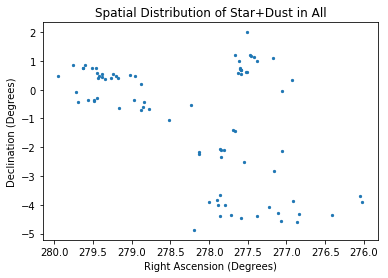

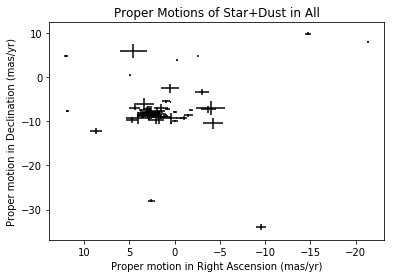

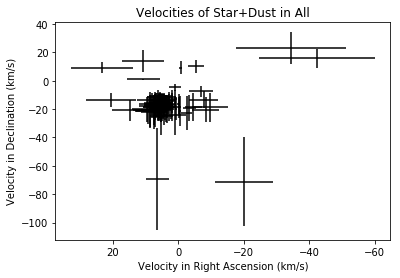

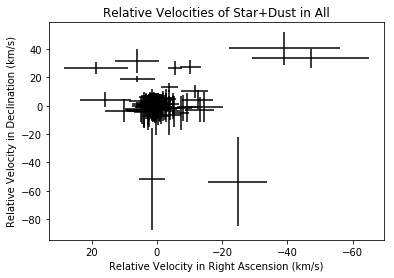

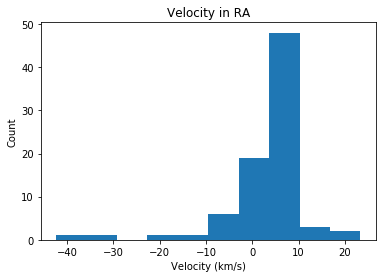

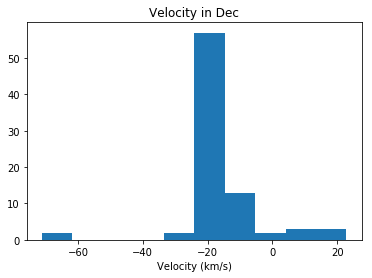

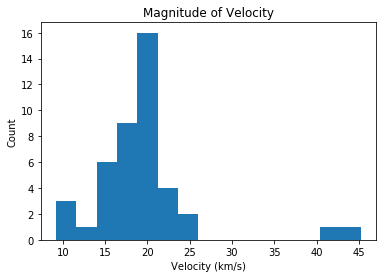

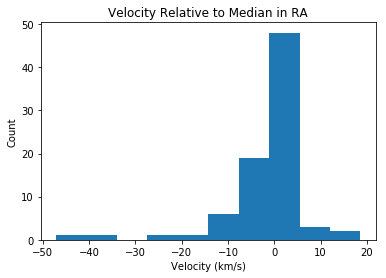

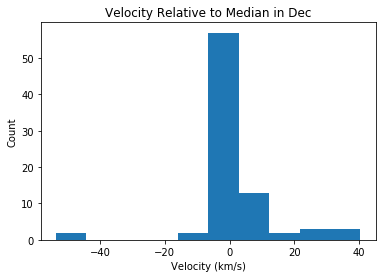

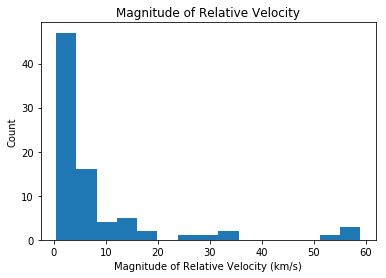

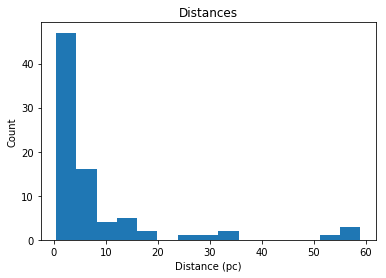

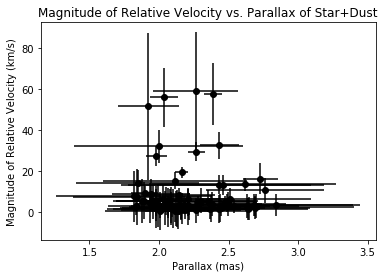

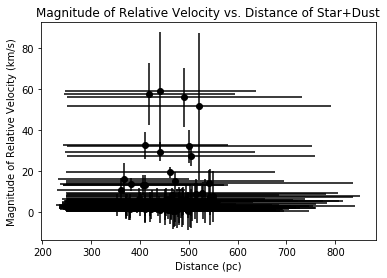

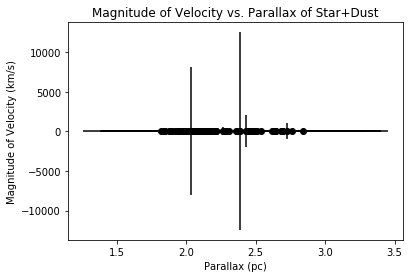

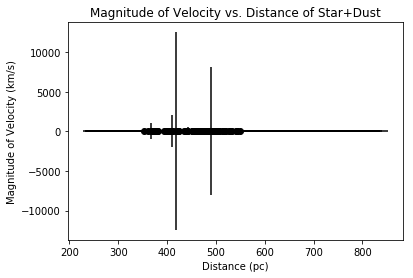

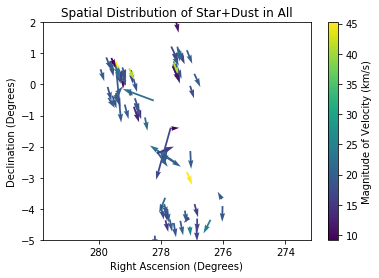

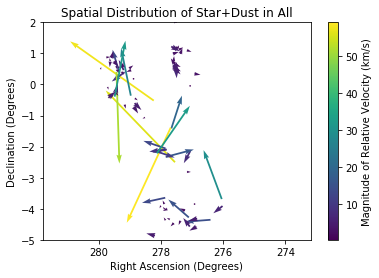

In [14]:
#ALL SD
SD_ALL = CalculateProperties('All','Star+Dust',SD_match,Gvalues,distance_range=[350.,550.])

In [80]:
#Read Star+Dust of chosen sources from gaia into table file

#create array of indices of GTab and make sure they are ints
vals = np.arange(0,len(GTab),1)
vals = vals.astype(np.int64)
print(len(GTab))

#go through all these indices and see if they match with s+d indices, if so exclude them from sources to remove list
not_sd_vals = np.array([])
for i in range(len(GTab)):
    if (not np.any(SD_ALL['id'][:] == vals[i])):
        not_sd_vals = np.append(not_sd_vals,vals[i])
not_sd_vals = not_sd_vals.astype(np.int64)      
print(len(vals)-len(not_sd_vals))

SD_GTab = copy.deepcopy(GTab)
SD_GTab.remove_rows(not_sd_vals)
astropy.io.misc.fnpickle(SD_GTab,'SD_Gaia.pkl')

61441
82


0
31144
The c2d index is 2
RA:  276.9277545671889
DEC:  0.34393708826403413
The difference in RA is  0.30300188004730444 arcseconds
The difference in Decliantion is  0.816522249477214 arcseconds
The c2d_ID is  SSTc2d J182742.6+002039
alpha is -0.58
The object type is star+dust(MP1)
2MASS ID: b'18274265+0020383'
FLUX SIGNAL TO NOISE
[ 29.03859864 177.61838998  64.00909229  41.75908375  73.07390963
  72.75427682   1.           1.           1.           1.
  10.74168798]
SED Flux
[ 1.41122282e-01  7.34865189e-01  1.96546566e+00  8.77583027e+00
  1.53567600e+01  1.52895880e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.20000000e+01]
SED Flux Error
[ 4.85981721e-03  4.13732603e-03  3.07060387e-02  2.10153803e-01
  2.10153803e-01  2.10153803e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.91000000e+00]
The apparent magnitude in g is: 16.629515
The absolute magnitude in g is: 8.318867056206805
g-K is: 5.0305147
GB-GR is: 3.184679
MIPS 1 IS MISS

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log10
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:306: RuntimeWarning: divide by zero encountered in double_scalars


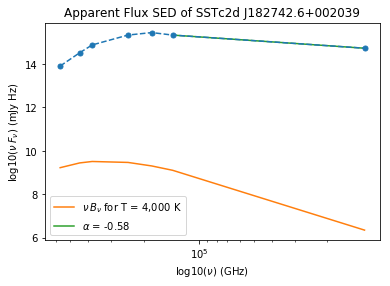

The c2d index is 2
RA:  276.9277545671889
DEC:  0.34393708826403413
The difference in RA is  0.30300188004730444 arcseconds
The difference in Decliantion is  0.816522249477214 arcseconds
The c2d_ID is  SSTc2d J182742.6+002039
alpha is -0.58
The object type is star+dust(MP1)
2MASS ID: b'18274265+0020383'
FLUX SIGNAL TO NOISE
[ 29.03859864 177.61838998  64.00909229  41.75908375  73.07390963
  72.75427682   1.           1.           1.           1.
  10.74168798]
SED Flux
[ 1.41122282e-01  7.34865189e-01  1.96546566e+00  8.77583027e+00
  1.53567600e+01  1.52895880e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.20000000e+01]
SED Flux Error
[ 4.85981721e-03  4.13732603e-03  3.07060387e-02  2.10153803e-01
  2.10153803e-01  2.10153803e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.91000000e+00]
The apparent magnitude in g is: 16.629515
The absolute magnitude in g is: 8.318867056206805
g-K is: 5.0305147
GB-GR is: 3.184679
MIPS 1 IS MISSING
SED_

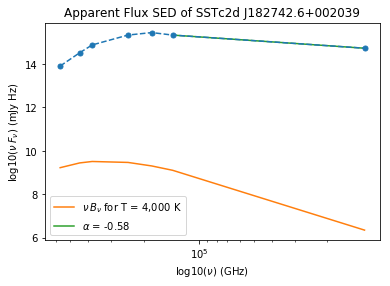

1
59418
2
36252
The c2d index is 54
RA:  277.1684377443844
DEC:  1.1036117893301272
The difference in RA is  0.4317997837688381 arcseconds
The difference in Decliantion is  1.443998411542502 arcseconds
The c2d_ID is  SSTc2d J182840.4+010614
alpha is -0.62
The object type is star+dust(MP1)
2MASS ID: b'18284042+0106131'
FLUX SIGNAL TO NOISE
[ 85.73676808 440.4770228  161.18900553  47.2059239   74.78394114
  89.51658575   1.           1.           1.           1.
  10.73825503]
SED Flux
[   1.1899637     3.80684781    8.84482956   33.42629623   52.9541626
   63.38628006 -999.         -999.         -999.         -999.
  160.        ]
SED Flux Error
[ 1.38792694e-02  8.64255708e-03  5.48724122e-02  7.08095372e-01
  7.08095372e-01  7.08095372e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.49000000e+01]
The apparent magnitude in g is: 14.84362
The absolute magnitude in g is: 6.562418990312192
g-K is: 4.78862
GB-GR is: 2.5028934
MIPS 1 IS MISSING
SED_nu_log
[14.8297287

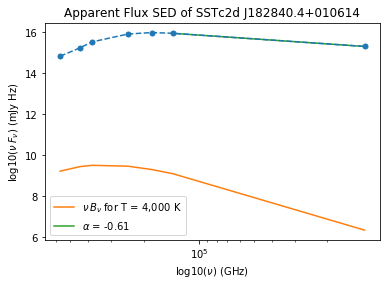

The c2d index is 54
RA:  277.1684377443844
DEC:  1.1036117893301272
The difference in RA is  0.4317997837688381 arcseconds
The difference in Decliantion is  1.443998411542502 arcseconds
The c2d_ID is  SSTc2d J182840.4+010614
alpha is -0.62
The object type is star+dust(MP1)
2MASS ID: b'18284042+0106131'
FLUX SIGNAL TO NOISE
[ 85.73676808 440.4770228  161.18900553  47.2059239   74.78394114
  89.51658575   1.           1.           1.           1.
  10.73825503]
SED Flux
[   1.1899637     3.80684781    8.84482956   33.42629623   52.9541626
   63.38628006 -999.         -999.         -999.         -999.
  160.        ]
SED Flux Error
[ 1.38792694e-02  8.64255708e-03  5.48724122e-02  7.08095372e-01
  7.08095372e-01  7.08095372e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.49000000e+01]
The apparent magnitude in g is: 14.84362
The absolute magnitude in g is: 6.562418990312192
g-K is: 4.78862
GB-GR is: 2.5028934
MIPS 1 IS MISSING
SED_nu_log
[14.82972872 15.22856526 15

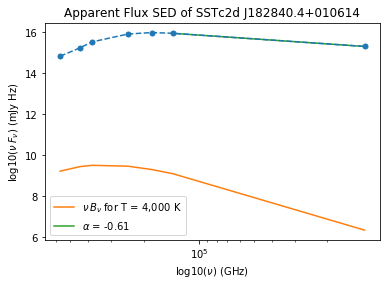

3
35969
The c2d index is 126
RA:  277.37758995268143
DEC:  0.984710952782651
The difference in RA is  0.2104296532479566 arcseconds
The difference in Decliantion is  0.2777299824566981 arcseconds
The c2d_ID is  SSTc2d J182930.6+005905
alpha is -1.36
The object type is Galc_star+dust(IR3)
2MASS ID: b'18293061+0059051'
FLUX SIGNAL TO NOISE
[         nan 171.86841192          nan  30.15933926  50.81984583
  52.98202741  19.69465649  20.37383178  19.69465649  18.01980198
   7.63636364]
SED Flux
[       nan 0.08862604        nan 2.08203721 3.50832653 3.65759182
 2.58       2.18       2.58       1.82       1.68      ]
SED Flux Error
[       nan 0.00051566        nan 0.06903458 0.06903458 0.06903458
 0.131      0.107      0.131      0.101      0.22      ]
The apparent magnitude in g is: 18.92613
The absolute magnitude in g is: 11.193590253144949
g-K is: 5.77413
GB-GR is: --
MIPS 1 IS MISSING
SED_nu_log
[13.5955611  14.70364223 14.80128969 14.7057633  14.3373248  14.16158915
 14.12963673 13.83

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:223: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:264: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:265: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:267: RuntimeWarning: invalid value encountered in gr

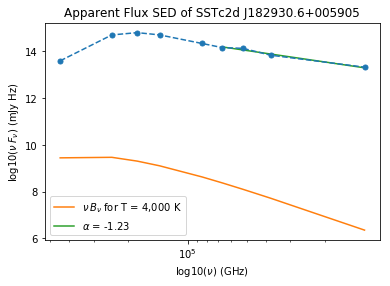

The c2d index is 126
RA:  277.37758995268143
DEC:  0.984710952782651
The difference in RA is  0.2104296532479566 arcseconds
The difference in Decliantion is  0.2777299824566981 arcseconds
The c2d_ID is  SSTc2d J182930.6+005905
alpha is -1.36
The object type is Galc_star+dust(IR3)
2MASS ID: b'18293061+0059051'
FLUX SIGNAL TO NOISE
[         nan 171.86841192          nan  30.15933926  50.81984583
  52.98202741  19.69465649  20.37383178  19.69465649  18.01980198
   7.63636364]
SED Flux
[       nan 0.08862604        nan 2.08203721 3.50832653 3.65759182
 2.58       2.18       2.58       1.82       1.68      ]
SED Flux Error
[       nan 0.00051566        nan 0.06903458 0.06903458 0.06903458
 0.131      0.107      0.131      0.101      0.22      ]
The apparent magnitude in g is: 18.92613
The absolute magnitude in g is: 11.193590253144949
g-K is: 5.77413
GB-GR is: --
MIPS 1 IS MISSING
SED_nu_log
[13.5955611  14.70364223 14.80128969 14.7057633  14.3373248  14.16158915
 14.12963673 13.83776296 1

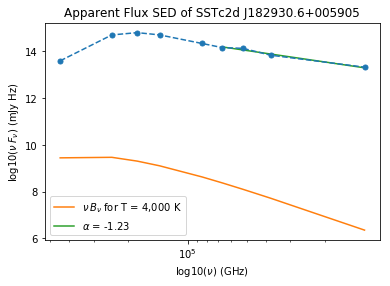

4
35960
5
36072
The c2d index is 171
RA:  277.4643984496426
DEC:  1.1590586258570095
The difference in RA is  0.2579387134346689 arcseconds
The difference in Decliantion is  0.2673869147655772 arcseconds
The c2d_ID is  SSTc2d J182951.4+010933
alpha is -1.53
The object type is star+dust(IR4)
2MASS ID: b'18295145+0109327'
FLUX SIGNAL TO NOISE
[  4.17968696 144.05563475  30.90892781  14.87310006  18.2563326
  60.18790943  19.51807229  18.47025496  19.51807229   9.58568738
   2.56485356]
SED Flux
[0.00893532 0.03843302 0.11480384 0.8631534  1.05949771 3.49297714
 0.81       0.652      0.81       0.509      0.613     ]
SED Flux Error
[0.0021378  0.00026679 0.00371426 0.05803453 0.05803453 0.05803453
 0.0415     0.0353     0.0415     0.0531     0.239     ]
The apparent magnitude in g is: 19.833273
The absolute magnitude in g is: 11.76716428485523
g-K is: 6.6312733
GB-GR is: 3.0971203
SED_nu_log
[12.70530522 13.23270421 13.64004701 14.32124173 14.28128971 14.6857638
 13.83419011 13.63738025 1

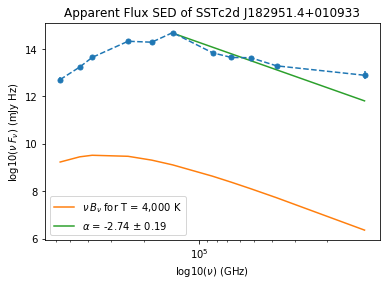

The c2d index is 171
RA:  277.4643984496426
DEC:  1.1590586258570095
The difference in RA is  0.2579387134346689 arcseconds
The difference in Decliantion is  0.2673869147655772 arcseconds
The c2d_ID is  SSTc2d J182951.4+010933
alpha is -1.53
The object type is star+dust(IR4)
2MASS ID: b'18295145+0109327'
FLUX SIGNAL TO NOISE
[  4.17968696 144.05563475  30.90892781  14.87310006  18.2563326
  60.18790943  19.51807229  18.47025496  19.51807229   9.58568738
   2.56485356]
SED Flux
[0.00893532 0.03843302 0.11480384 0.8631534  1.05949771 3.49297714
 0.81       0.652      0.81       0.509      0.613     ]
SED Flux Error
[0.0021378  0.00026679 0.00371426 0.05803453 0.05803453 0.05803453
 0.0415     0.0353     0.0415     0.0531     0.239     ]
The apparent magnitude in g is: 19.833273
The absolute magnitude in g is: 11.76716428485523
g-K is: 6.6312733
GB-GR is: 3.0971203
SED_nu_log
[12.70530522 13.23270421 13.64004701 14.32124173 14.28128971 14.6857638
 13.83419011 13.63738025 13.62650204 13.28

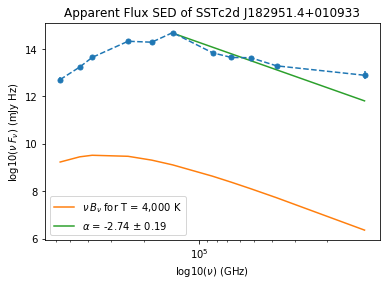

6
36048
The c2d index is 175
RA:  277.4731424679055
DEC:  1.2180645672493626
The difference in RA is  0.002275540191476466 arcseconds
The difference in Decliantion is  0.14123790229438882 arcseconds
The c2d_ID is  SSTc2d J182953.6+011305
alpha is -1.61
The object type is star+dust(IR1)
2MASS ID: b'18295354+0113051'
FLUX SIGNAL TO NOISE
[  3.9215128  339.9267126  133.75176553  26.48137104  34.35205347
  31.88952989  20.12779553  19.89795918  20.12779553  16.41104294
   2.29888268]
SED Flux
[0.0140289  0.12087023 0.35368079 1.7639569  2.2882328  2.12420106
 1.89       1.56       1.89       1.07       0.823     ]
SED Flux Error
[3.57741979e-03 3.55577329e-04 2.64430745e-03 6.66112378e-02
 6.66112378e-02 6.66112378e-02 9.39000000e-02 7.84000000e-02
 9.39000000e-02 6.52000000e-02 3.58000000e-01]
The apparent magnitude in g is: 18.589235
The absolute magnitude in g is: 10.18722182694459
g-K is: 4.8472357
GB-GR is: 3.8289738
SED_nu_log
[12.90121855 13.73031911 14.12870208 14.63164172 14.61568

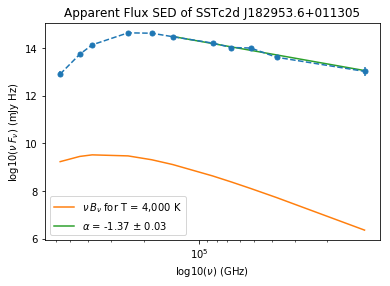

The c2d index is 175
RA:  277.4731424679055
DEC:  1.2180645672493626
The difference in RA is  0.002275540191476466 arcseconds
The difference in Decliantion is  0.14123790229438882 arcseconds
The c2d_ID is  SSTc2d J182953.6+011305
alpha is -1.61
The object type is star+dust(IR1)
2MASS ID: b'18295354+0113051'
FLUX SIGNAL TO NOISE
[  3.9215128  339.9267126  133.75176553  26.48137104  34.35205347
  31.88952989  20.12779553  19.89795918  20.12779553  16.41104294
   2.29888268]
SED Flux
[0.0140289  0.12087023 0.35368079 1.7639569  2.2882328  2.12420106
 1.89       1.56       1.89       1.07       0.823     ]
SED Flux Error
[3.57741979e-03 3.55577329e-04 2.64430745e-03 6.66112378e-02
 6.66112378e-02 6.66112378e-02 9.39000000e-02 7.84000000e-02
 9.39000000e-02 6.52000000e-02 3.58000000e-01]
The apparent magnitude in g is: 18.589235
The absolute magnitude in g is: 10.18722182694459
g-K is: 4.8472357
GB-GR is: 3.8289738
SED_nu_log
[12.90121855 13.73031911 14.12870208 14.63164172 14.61568989 14.4

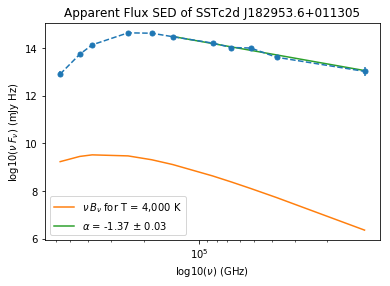

7
27240
The c2d index is 191
RA:  277.5054412557777
DEC:  1.9918776456776908
The difference in RA is  0.011720799716385955 arcseconds
The difference in Decliantion is  0.18487556031345775 arcseconds
The c2d_ID is  SSTc2d J183001.3+015931
alpha is -1.66
The object type is star+dust(MP1)
2MASS ID: b'18300130+0159309'
FLUX SIGNAL TO NOISE
[ 15.42250723 258.66510666 155.74158064  38.77629181  46.90052918
  43.02033208   1.           1.           1.           1.
   5.20547945]
SED Flux
[ 4.47309762e-02  3.12551975e-01  9.57972705e-01  5.01289272e+00
  6.06317186e+00  5.56155062e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.14000000e+00]
SED Flux Error
[ 2.90036993e-03  1.20832678e-03  6.15104008e-03  1.29277259e-01
  1.29277259e-01  1.29277259e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.19000000e-01]
The apparent magnitude in g is: 17.557728
The absolute magnitude in g is: 9.440492968832926
g-K is: 4.8607283
GB-GR is: 3.651865
MIPS 1 IS 

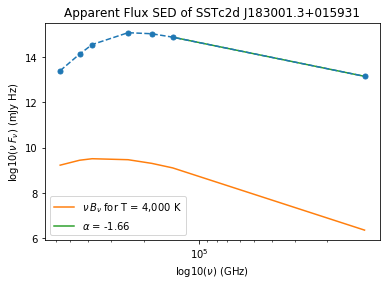

The c2d index is 191
RA:  277.5054412557777
DEC:  1.9918776456776908
The difference in RA is  0.011720799716385955 arcseconds
The difference in Decliantion is  0.18487556031345775 arcseconds
The c2d_ID is  SSTc2d J183001.3+015931
alpha is -1.66
The object type is star+dust(MP1)
2MASS ID: b'18300130+0159309'
FLUX SIGNAL TO NOISE
[ 15.42250723 258.66510666 155.74158064  38.77629181  46.90052918
  43.02033208   1.           1.           1.           1.
   5.20547945]
SED Flux
[ 4.47309762e-02  3.12551975e-01  9.57972705e-01  5.01289272e+00
  6.06317186e+00  5.56155062e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.14000000e+00]
SED Flux Error
[ 2.90036993e-03  1.20832678e-03  6.15104008e-03  1.29277259e-01
  1.29277259e-01  1.29277259e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.19000000e-01]
The apparent magnitude in g is: 17.557728
The absolute magnitude in g is: 9.440492968832926
g-K is: 4.8607283
GB-GR is: 3.651865
MIPS 1 IS MISSING


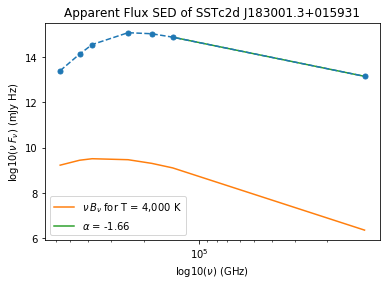

8
32426
The c2d index is 193
RA:  277.5065103096611
DEC:  0.6260335108364313
The difference in RA is  0.14187477995619702 arcseconds
The difference in Decliantion is  0.26564098884733767 arcseconds
The c2d_ID is  SSTc2d J183001.6+003734
alpha is -1.82
The object type is star+dust(IR2)
2MASS ID: b'18300155+0037338'
FLUX SIGNAL TO NOISE
[  5.90611063 336.73796086  81.62232186  40.21245207  55.07721216
  55.80427497   1.          18.41584158   1.          18.13084112
   6.06965174]
SED Flux
[ 1.71943288e-02  1.36876017e-01  4.63750511e-01  4.52573013e+00
  6.19869184e+00  6.28051949e+00 -9.99000000e+02  3.72000000e+00
 -9.99000000e+02  1.94000000e+00  1.22000000e+00]
SED Flux Error
[ 2.91127781e-03  4.06476349e-04  5.68166282e-03  1.12545490e-01
  1.12545490e-01  1.12545490e-01 -9.99000000e+02  2.02000000e-01
 -9.99000000e+02  1.07000000e-01  2.01000000e-01]
The apparent magnitude in g is: 18.454216
The absolute magnitude in g is: 10.031011320506334
g-K is: 5.8892164
GB-GR is: 3.9022503
M

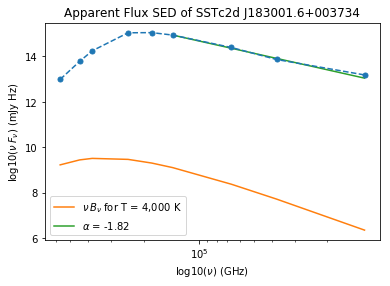

The c2d index is 193
RA:  277.5065103096611
DEC:  0.6260335108364313
The difference in RA is  0.14187477995619702 arcseconds
The difference in Decliantion is  0.26564098884733767 arcseconds
The c2d_ID is  SSTc2d J183001.6+003734
alpha is -1.82
The object type is star+dust(IR2)
2MASS ID: b'18300155+0037338'
FLUX SIGNAL TO NOISE
[  5.90611063 336.73796086  81.62232186  40.21245207  55.07721216
  55.80427497   1.          18.41584158   1.          18.13084112
   6.06965174]
SED Flux
[ 1.71943288e-02  1.36876017e-01  4.63750511e-01  4.52573013e+00
  6.19869184e+00  6.28051949e+00 -9.99000000e+02  3.72000000e+00
 -9.99000000e+02  1.94000000e+00  1.22000000e+00]
SED Flux Error
[ 2.91127781e-03  4.06476349e-04  5.68166282e-03  1.12545490e-01
  1.12545490e-01  1.12545490e-01 -9.99000000e+02  2.02000000e-01
 -9.99000000e+02  1.07000000e-01  2.01000000e-01]
The apparent magnitude in g is: 18.454216
The absolute magnitude in g is: 10.031011320506334
g-K is: 5.8892164
GB-GR is: 3.9022503
MIPS 1 IS

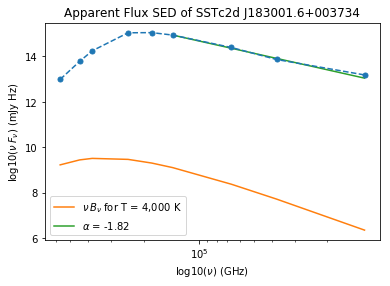

9
32502
10
32498
The c2d index is 217
RA:  277.5826238032912
DEC:  0.6741813016664934
The difference in RA is  0.18001184839704365 arcseconds
The difference in Decliantion is  0.2728740006240571 arcseconds
The c2d_ID is  SSTc2d J183019.8+004027
alpha is -0.95
The object type is star+dust(MP1)
2MASS ID: b'18301981+0040271'
FLUX SIGNAL TO NOISE
[  7.52557612 252.4547425   87.67563342  20.87954373  26.86164656
  24.6166005    1.           1.           1.           1.
   6.99029126]
SED Flux
[ 1.67958103e-02  8.73470083e-02  2.63311386e-01  1.61468685e+00
  2.07730341e+00  1.90368629e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.16000000e+00]
SED Flux Error
[ 2.23183050e-03  3.45990760e-04  3.00324475e-03  7.73334354e-02
  7.73334354e-02  7.73334354e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.09000000e-01]
The apparent magnitude in g is: 18.941914
The absolute magnitude in g is: 11.084736197013612
g-K is: 5.0809135
GB-GR is: 3.3131752
M

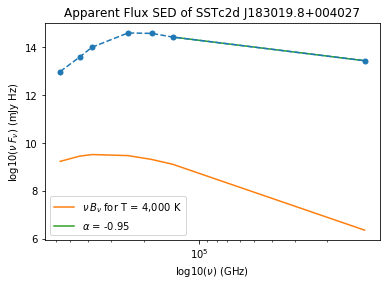

The c2d index is 217
RA:  277.5826238032912
DEC:  0.6741813016664934
The difference in RA is  0.18001184839704365 arcseconds
The difference in Decliantion is  0.2728740006240571 arcseconds
The c2d_ID is  SSTc2d J183019.8+004027
alpha is -0.95
The object type is star+dust(MP1)
2MASS ID: b'18301981+0040271'
FLUX SIGNAL TO NOISE
[  7.52557612 252.4547425   87.67563342  20.87954373  26.86164656
  24.6166005    1.           1.           1.           1.
   6.99029126]
SED Flux
[ 1.67958103e-02  8.73470083e-02  2.63311386e-01  1.61468685e+00
  2.07730341e+00  1.90368629e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.16000000e+00]
SED Flux Error
[ 2.23183050e-03  3.45990760e-04  3.00324475e-03  7.73334354e-02
  7.73334354e-02  7.73334354e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.09000000e-01]
The apparent magnitude in g is: 18.941914
The absolute magnitude in g is: 11.084736197013612
g-K is: 5.0809135
GB-GR is: 3.3131752
MIPS 1 IS MISSING


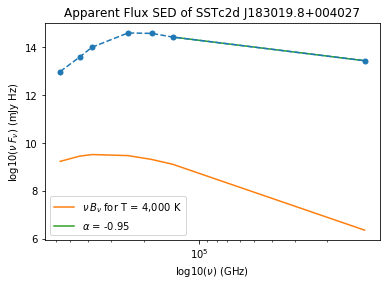

11
32542
The c2d index is 219
RA:  277.5831157195666
DEC:  0.69782558336132
The difference in RA is  0.4774304398097229 arcseconds
The difference in Decliantion is  1.093379899248026 arcseconds
The c2d_ID is  SSTc2d J183019.9+004153
alpha is -1.37
The object type is star+dust(MP1)
2MASS ID: b'18301993+0041522'
FLUX SIGNAL TO NOISE
[ 31.8187775  819.99822294 172.28847462  43.4294479   95.76264851
 118.9300395    1.           1.           1.           1.
  10.79365079]
SED Flux
[ 1.07878879e-01  8.65078747e-01  2.62540030e+00  2.42822056e+01
  5.35426636e+01  6.64959793e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.72000000e+01]
SED Flux Error
[ 3.39041557e-03  1.05497637e-03  1.52383978e-02  5.59118450e-01
  5.59118450e-01  5.59118450e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.52000000e+00]
The apparent magnitude in g is: 16.452394
The absolute magnitude in g is: 7.822373559420198
g-K is: 6.449394
GB-GR is: 3.7906513
MIPS 1 IS MISSI

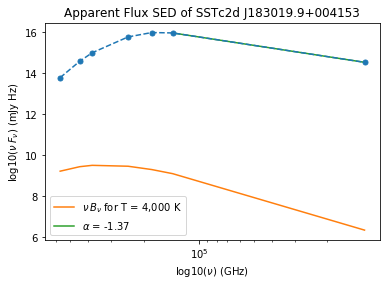

The c2d index is 219
RA:  277.5831157195666
DEC:  0.69782558336132
The difference in RA is  0.4774304398097229 arcseconds
The difference in Decliantion is  1.093379899248026 arcseconds
The c2d_ID is  SSTc2d J183019.9+004153
alpha is -1.37
The object type is star+dust(MP1)
2MASS ID: b'18301993+0041522'
FLUX SIGNAL TO NOISE
[ 31.8187775  819.99822294 172.28847462  43.4294479   95.76264851
 118.9300395    1.           1.           1.           1.
  10.79365079]
SED Flux
[ 1.07878879e-01  8.65078747e-01  2.62540030e+00  2.42822056e+01
  5.35426636e+01  6.64959793e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.72000000e+01]
SED Flux Error
[ 3.39041557e-03  1.05497637e-03  1.52383978e-02  5.59118450e-01
  5.59118450e-01  5.59118450e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.52000000e+00]
The apparent magnitude in g is: 16.452394
The absolute magnitude in g is: 7.822373559420198
g-K is: 6.449394
GB-GR is: 3.7906513
MIPS 1 IS MISSING
SED_nu

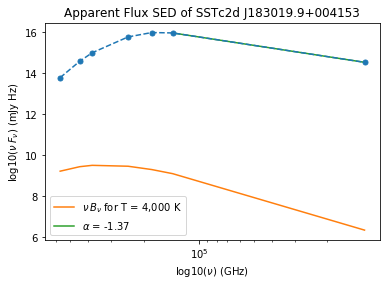

12
32576
The c2d index is 223
RA:  277.5937949799801
DEC:  0.554748501394243
The difference in RA is  0.37972792838445457 arcseconds
The difference in Decliantion is  0.1072850192748831 arcseconds
The c2d_ID is  SSTc2d J183022.5+003317
alpha is -1.15
The object type is star+dust(MP1)
2MASS ID: b'18302250+0033170'
FLUX SIGNAL TO NOISE
[ 26.73129127 243.50933278  83.15236691  40.21245047  77.7270901
  79.77520801   1.           1.           1.           1.
  10.53551913]
SED Flux
[ 4.21220176e-02  2.96949476e-01  8.68513048e-01  6.99661684e+00
  1.35238380e+01  1.38801928e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  9.64000000e+00]
SED Flux Error
[ 1.57575693e-03  1.21945830e-03  1.04448386e-02  1.73991308e-01
  1.73991308e-01  1.73991308e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  9.15000000e-01]
The apparent magnitude in g is: 17.613327
The absolute magnitude in g is: 8.998906259345292
g-K is: 5.9093266
GB-GR is: 3.610672
MIPS 1 IS MIS

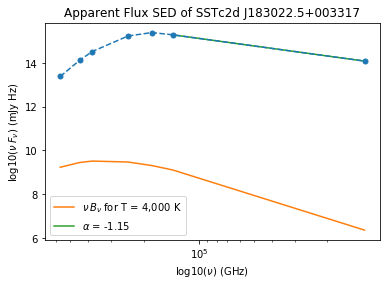

The c2d index is 223
RA:  277.5937949799801
DEC:  0.554748501394243
The difference in RA is  0.37972792838445457 arcseconds
The difference in Decliantion is  0.1072850192748831 arcseconds
The c2d_ID is  SSTc2d J183022.5+003317
alpha is -1.15
The object type is star+dust(MP1)
2MASS ID: b'18302250+0033170'
FLUX SIGNAL TO NOISE
[ 26.73129127 243.50933278  83.15236691  40.21245047  77.7270901
  79.77520801   1.           1.           1.           1.
  10.53551913]
SED Flux
[ 4.21220176e-02  2.96949476e-01  8.68513048e-01  6.99661684e+00
  1.35238380e+01  1.38801928e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  9.64000000e+00]
SED Flux Error
[ 1.57575693e-03  1.21945830e-03  1.04448386e-02  1.73991308e-01
  1.73991308e-01  1.73991308e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  9.15000000e-01]
The apparent magnitude in g is: 17.613327
The absolute magnitude in g is: 8.998906259345292
g-K is: 5.9093266
GB-GR is: 3.610672
MIPS 1 IS MISSING
SED_

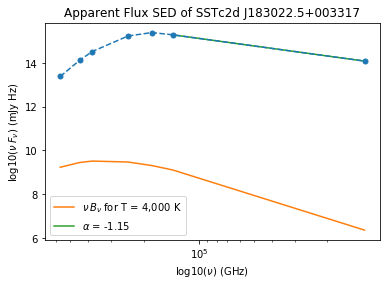

13
35649
The c2d index is 224
RA:  277.59485632008517
DEC:  0.7436656015324985
The difference in RA is  0.3978723066211387 arcseconds
The difference in Decliantion is  1.0943944830054342 arcseconds
The c2d_ID is  SSTc2d J183022.7+004438
alpha is -1.07
The object type is star+dust(MP1)
2MASS ID: b'18302275+0044373'
FLUX SIGNAL TO NOISE
[21.68054839 52.83459242 61.84862554 41.75908604 79.31631558 83.22584445
  1.          1.          1.          1.         10.70921986]
SED Flux
[ 1.74035221e-01  7.44925499e-01  2.12371302e+00  9.04666519e+00
  1.71830425e+01  1.80300007e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.51000000e+01]
SED Flux Error
[ 8.02725181e-03  1.40992003e-02  3.43372710e-02  2.16639444e-01
  2.16639444e-01  2.16639444e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.41000000e+00]
The apparent magnitude in g is: 16.614752
The absolute magnitude in g is: 8.714431115697057
g-K is: 5.1947517
GB-GR is: 3.041151
MIPS 1 IS MISSI

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:306: RuntimeWarning: invalid value encountered in double_scalars


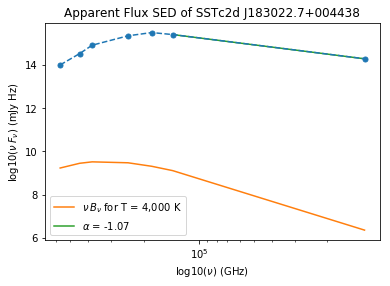

The c2d index is 224
RA:  277.59485632008517
DEC:  0.7436656015324985
The difference in RA is  0.3978723066211387 arcseconds
The difference in Decliantion is  1.0943944830054342 arcseconds
The c2d_ID is  SSTc2d J183022.7+004438
alpha is -1.07
The object type is star+dust(MP1)
2MASS ID: b'18302275+0044373'
FLUX SIGNAL TO NOISE
[21.68054839 52.83459242 61.84862554 41.75908604 79.31631558 83.22584445
  1.          1.          1.          1.         10.70921986]
SED Flux
[ 1.74035221e-01  7.44925499e-01  2.12371302e+00  9.04666519e+00
  1.71830425e+01  1.80300007e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.51000000e+01]
SED Flux Error
[ 8.02725181e-03  1.40992003e-02  3.43372710e-02  2.16639444e-01
  2.16639444e-01  2.16639444e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.41000000e+00]
The apparent magnitude in g is: 16.614752
The absolute magnitude in g is: 8.714431115697057
g-K is: 5.1947517
GB-GR is: 3.041151
MIPS 1 IS MISSING
SED_nu

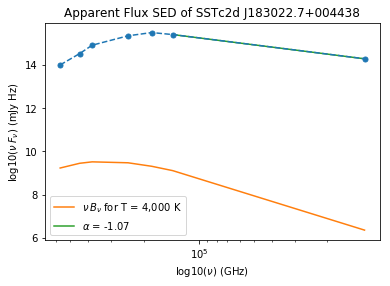

14
32544
The c2d index is 228
RA:  277.5970574888583
DEC:  0.7079368243552621
The difference in RA is  0.439879889927397 arcseconds
The difference in Decliantion is  1.1612723210565168 arcseconds
The c2d_ID is  SSTc2d J183023.3+004230
alpha is -0.66
The object type is star+dust(MP1)
2MASS ID: b'18302328+0042286'
FLUX SIGNAL TO NOISE
[12.0828505  50.13993949 16.34960855 29.34422015 71.53753264 93.63319915
  1.          1.          1.          1.         10.72463768]
SED Flux
[ 1.76938418e-02  1.64291948e-01  5.13468623e-01  2.02343082e+00
  4.93287086e+00  6.45647764e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.48000000e+01]
SED Flux Error
[ 1.46437646e-03  3.27666826e-03  3.14055607e-02  6.89550042e-02
  6.89550042e-02  6.89550042e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.38000000e+00]
The apparent magnitude in g is: 18.255993
The absolute magnitude in g is: 10.049349933554664
g-K is: 5.720993
GB-GR is: 3.9817333
MIPS 1 IS MISSIN

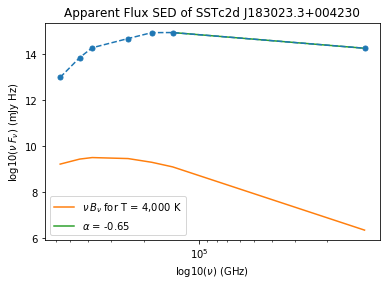

The c2d index is 228
RA:  277.5970574888583
DEC:  0.7079368243552621
The difference in RA is  0.439879889927397 arcseconds
The difference in Decliantion is  1.1612723210565168 arcseconds
The c2d_ID is  SSTc2d J183023.3+004230
alpha is -0.66
The object type is star+dust(MP1)
2MASS ID: b'18302328+0042286'
FLUX SIGNAL TO NOISE
[12.0828505  50.13993949 16.34960855 29.34422015 71.53753264 93.63319915
  1.          1.          1.          1.         10.72463768]
SED Flux
[ 1.76938418e-02  1.64291948e-01  5.13468623e-01  2.02343082e+00
  4.93287086e+00  6.45647764e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.48000000e+01]
SED Flux Error
[ 1.46437646e-03  3.27666826e-03  3.14055607e-02  6.89550042e-02
  6.89550042e-02  6.89550042e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.38000000e+00]
The apparent magnitude in g is: 18.255993
The absolute magnitude in g is: 10.049349933554664
g-K is: 5.720993
GB-GR is: 3.9817333
MIPS 1 IS MISSING
SED_nu_

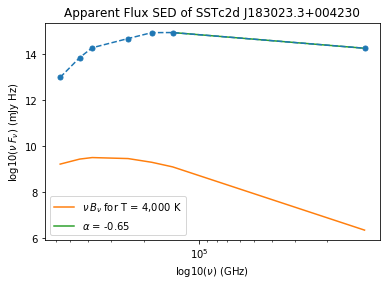

15
35717
The c2d index is 235
RA:  277.6183538088804
DEC:  0.9869077752440374
The difference in RA is  0.3096319693440819 arcseconds
The difference in Decliantion is  0.33308912146559067 arcseconds
The c2d_ID is  SSTc2d J183028.4+005913
alpha is -1.99
The object type is star+dust(MP1)
2MASS ID: b'18302839+0059130'
FLUX SIGNAL TO NOISE
[ 13.16723996 137.54235673  45.22699603  27.83938787  49.16671911
  46.66237642   1.          20.08196721   1.          15.
   4.58498024]
SED Flux
[ 2.93260794e-02  1.62585959e-01  4.73133117e-01  2.93013978e+00
  5.17487526e+00  4.91128922e+00 -9.99000000e+02  1.96000000e+00
 -9.99000000e+02  8.91000000e-01  1.16000000e+00]
SED Flux Error
[ 2.22720020e-03  1.18207920e-03  1.04612987e-02  1.05251588e-01
  1.05251588e-01  1.05251588e-01 -9.99000000e+02  9.76000000e-02
 -9.99000000e+02  5.94000000e-02  2.53000000e-01]
The apparent magnitude in g is: 18.267326
The absolute magnitude in g is: 9.921186216345564
g-K is: 5.4353266
GB-GR is: 3.344326
MIPS 1 IS M

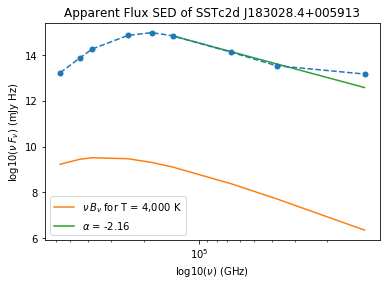

The c2d index is 235
RA:  277.6183538088804
DEC:  0.9869077752440374
The difference in RA is  0.3096319693440819 arcseconds
The difference in Decliantion is  0.33308912146559067 arcseconds
The c2d_ID is  SSTc2d J183028.4+005913
alpha is -1.99
The object type is star+dust(MP1)
2MASS ID: b'18302839+0059130'
FLUX SIGNAL TO NOISE
[ 13.16723996 137.54235673  45.22699603  27.83938787  49.16671911
  46.66237642   1.          20.08196721   1.          15.
   4.58498024]
SED Flux
[ 2.93260794e-02  1.62585959e-01  4.73133117e-01  2.93013978e+00
  5.17487526e+00  4.91128922e+00 -9.99000000e+02  1.96000000e+00
 -9.99000000e+02  8.91000000e-01  1.16000000e+00]
SED Flux Error
[ 2.22720020e-03  1.18207920e-03  1.04612987e-02  1.05251588e-01
  1.05251588e-01  1.05251588e-01 -9.99000000e+02  9.76000000e-02
 -9.99000000e+02  5.94000000e-02  2.53000000e-01]
The apparent magnitude in g is: 18.267326
The absolute magnitude in g is: 9.921186216345564
g-K is: 5.4353266
GB-GR is: 3.344326
MIPS 1 IS MISSING
SE

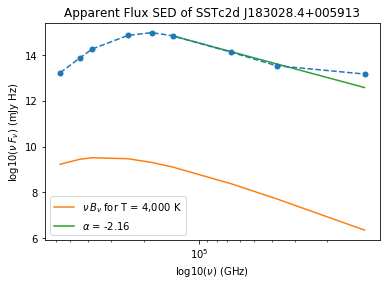

16
32237
The c2d index is 238
RA:  277.62442731497123
DEC:  0.5833703048274473
The difference in RA is  0.295973896322721 arcseconds
The difference in Decliantion is  0.6170226211897667 arcseconds
The c2d_ID is  SSTc2d J183029.8+003501
alpha is -1.02
The object type is star+dust(MP1)
2MASS ID: b'18302986+0035004'
FLUX SIGNAL TO NOISE
[ 85.54108028 320.58917786  71.44629568  43.42944933  66.92611346
  62.30052848   1.           1.           1.           1.
  10.78838174]
SED Flux
[ 4.53665465e-01  1.70479023e+00  4.25401783e+00  1.90936279e+01
  2.94238663e+01  2.73902416e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.60000000e+01]
SED Flux Error
[ 5.30348066e-03  5.31767868e-03  5.95414750e-02  4.39647019e-01
  4.39647019e-01  4.39647019e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.41000000e+00]
The apparent magnitude in g is: 15.715857
The absolute magnitude in g is: 7.277800932234671
g-K is: 4.749857
GB-GR is: 2.7551622
MIPS 1 IS MI

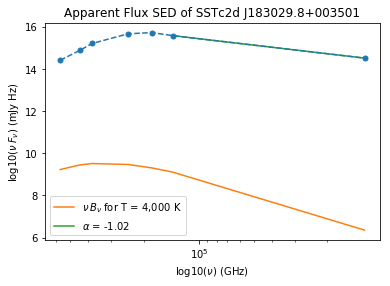

The c2d index is 238
RA:  277.62442731497123
DEC:  0.5833703048274473
The difference in RA is  0.295973896322721 arcseconds
The difference in Decliantion is  0.6170226211897667 arcseconds
The c2d_ID is  SSTc2d J183029.8+003501
alpha is -1.02
The object type is star+dust(MP1)
2MASS ID: b'18302986+0035004'
FLUX SIGNAL TO NOISE
[ 85.54108028 320.58917786  71.44629568  43.42944933  66.92611346
  62.30052848   1.           1.           1.           1.
  10.78838174]
SED Flux
[ 4.53665465e-01  1.70479023e+00  4.25401783e+00  1.90936279e+01
  2.94238663e+01  2.73902416e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.60000000e+01]
SED Flux Error
[ 5.30348066e-03  5.31767868e-03  5.95414750e-02  4.39647019e-01
  4.39647019e-01  4.39647019e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.41000000e+00]
The apparent magnitude in g is: 15.715857
The absolute magnitude in g is: 7.277800932234671
g-K is: 4.749857
GB-GR is: 2.7551622
MIPS 1 IS MISSING
SED

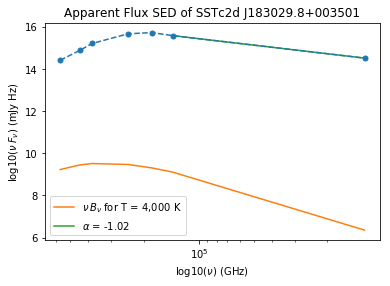

17
36074
The c2d index is 251
RA:  277.67157303856914
DEC:  1.2209640786578548
The difference in RA is  0.3432188487977328 arcseconds
The difference in Decliantion is  0.294916831722869 arcseconds
The c2d_ID is  SSTc2d J183041.2+011316
alpha is -0.99
The object type is star+dust(IR1)
2MASS ID: b'18304116+0113156'
FLUX SIGNAL TO NOISE
[  2.75547687 205.99412867  93.40286255  28.57200745  37.51046156
  38.14588714  20.06493506  19.85714286  20.06493506  19.63855422
   1.        ]
SED Flux
[ 6.55432791e-02  9.13170353e-02  3.14735770e-01  2.51702976e+00
  3.30445623e+00  3.36043358e+00  3.09000000e+00  2.78000000e+00
  3.09000000e+00  3.26000000e+00 -9.99000000e+02]
SED Flux Error
[ 2.37865467e-02  4.43299214e-04  3.36965872e-03  8.80942568e-02
  8.80942568e-02  8.80942568e-02  1.54000000e-01  1.40000000e-01
  1.54000000e-01  1.66000000e-01 -9.99000000e+02]
The apparent magnitude in g is: 18.893654
The absolute magnitude in g is: 10.70707591235668
g-K is: 5.6496534
GB-GR is: 2.0285492
MIP

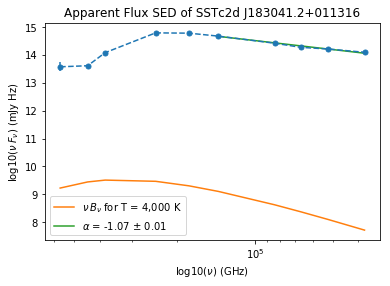

The c2d index is 251
RA:  277.67157303856914
DEC:  1.2209640786578548
The difference in RA is  0.3432188487977328 arcseconds
The difference in Decliantion is  0.294916831722869 arcseconds
The c2d_ID is  SSTc2d J183041.2+011316
alpha is -0.99
The object type is star+dust(IR1)
2MASS ID: b'18304116+0113156'
FLUX SIGNAL TO NOISE
[  2.75547687 205.99412867  93.40286255  28.57200745  37.51046156
  38.14588714  20.06493506  19.85714286  20.06493506  19.63855422
   1.        ]
SED Flux
[ 6.55432791e-02  9.13170353e-02  3.14735770e-01  2.51702976e+00
  3.30445623e+00  3.36043358e+00  3.09000000e+00  2.78000000e+00
  3.09000000e+00  3.26000000e+00 -9.99000000e+02]
SED Flux Error
[ 2.37865467e-02  4.43299214e-04  3.36965872e-03  8.80942568e-02
  8.80942568e-02  8.80942568e-02  1.54000000e-01  1.40000000e-01
  1.54000000e-01  1.66000000e-01 -9.99000000e+02]
The apparent magnitude in g is: 18.893654
The absolute magnitude in g is: 10.70707591235668
g-K is: 5.6496534
GB-GR is: 2.0285492
MIPS 1 IS MI

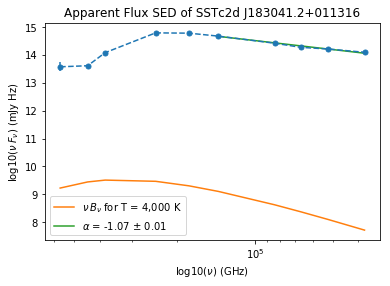

18
26154
The GB index 891
RA:  276.0200107684489
DEC:  -3.9138430944305855
The difference in RA is  0.763 arcseconds
The difference in Dec is  0.167 arcseconds
The Gould_Belt_ID is  SSTGBS J182404.8-035450
alpha is -1.37
The object type is star+dust(MP1)
2MASS ID: b'18240480-0354497'
FLUX SIGNAL TO NOISE
[4.01556391e+02 1.74686640e+03 1.00175520e+03 4.02124523e+01
 4.33882731e+01 3.41246546e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.07812500e+01]
SED Flux
[   6.64235687   16.15776443   32.98830414   79.30271912   85.56573486
   67.29701233 -999.         -999.         -999.         -999.
   27.6       ]
SED Flux Error
[ 1.65415294e-02  9.24957078e-03  3.29305045e-02  1.97209358e+00
  1.97209358e+00  1.97209358e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.56000000e+00]
The apparent magnitude in g is: 13.274081
The absolute magnitude in g is: 4.807003193414072
g-K is: 3.2840815
GB-GR is: 2.0650978
MIPS 1 IS MISSING
SED_nu_log
[15.57651721

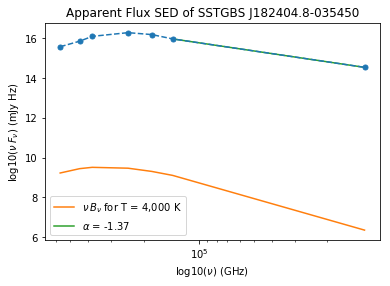

The GB index 891
RA:  276.0200107684489
DEC:  -3.9138430944305855
The difference in RA is  0.763 arcseconds
The difference in Dec is  0.167 arcseconds
The Gould_Belt_ID is  SSTGBS J182404.8-035450
alpha is -1.37
The object type is star+dust(MP1)
2MASS ID: b'18240480-0354497'
FLUX SIGNAL TO NOISE
[4.01556391e+02 1.74686640e+03 1.00175520e+03 4.02124523e+01
 4.33882731e+01 3.41246546e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.07812500e+01]
SED Flux
[   6.64235687   16.15776443   32.98830414   79.30271912   85.56573486
   67.29701233 -999.         -999.         -999.         -999.
   27.6       ]
SED Flux Error
[ 1.65415294e-02  9.24957078e-03  3.29305045e-02  1.97209358e+00
  1.97209358e+00  1.97209358e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.56000000e+00]
The apparent magnitude in g is: 13.274081
The absolute magnitude in g is: 4.807003193414072
g-K is: 3.2840815
GB-GR is: 2.0650978
MIPS 1 IS MISSING
SED_nu_log
[15.57651721 15.85638

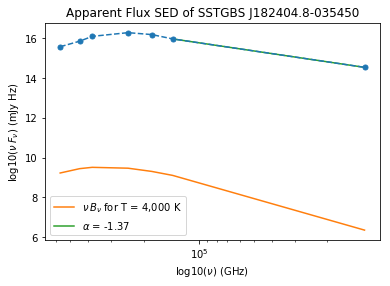

19
26393
The GB index 893
RA:  276.0454877517486
DEC:  -3.688459975743996
The difference in RA is  0.533 arcseconds
The difference in Dec is  0.011 arcseconds
The Gould_Belt_ID is  SSTGBS J182410.9-034118
alpha is -2.25
The object type is star+dust(MP1)
2MASS ID: b'18241092-0341185'
FLUX SIGNAL TO NOISE
[8.01572900e+02 5.02114250e+03 7.05159282e+02 3.74391814e+01
 3.36928665e+01 2.79275971e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.02307692e+01]
SED Flux
[  25.57146835   53.12622452   97.76205444  180.67092896  162.5922699
  134.77070618 -999.         -999.         -999.         -999.
    6.65      ]
SED Flux Error
[ 3.19016129e-02  1.05805052e-02  1.38638258e-01  4.82571793e+00
  4.82571793e+00  4.82571793e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  6.50000000e-01]
The apparent magnitude in g is: 11.981761
The absolute magnitude in g is: 3.7610077288642643
g-K is: 2.745761
GB-GR is: 1.7810402
MIPS 1 IS MISSING
SED_nu_log
[16.16195067 1

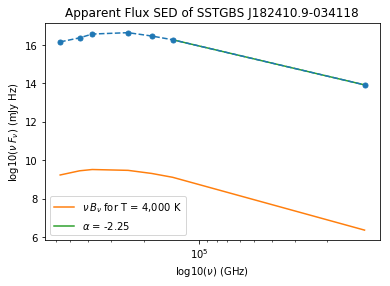

The GB index 893
RA:  276.0454877517486
DEC:  -3.688459975743996
The difference in RA is  0.533 arcseconds
The difference in Dec is  0.011 arcseconds
The Gould_Belt_ID is  SSTGBS J182410.9-034118
alpha is -2.25
The object type is star+dust(MP1)
2MASS ID: b'18241092-0341185'
FLUX SIGNAL TO NOISE
[8.01572900e+02 5.02114250e+03 7.05159282e+02 3.74391814e+01
 3.36928665e+01 2.79275971e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.02307692e+01]
SED Flux
[  25.57146835   53.12622452   97.76205444  180.67092896  162.5922699
  134.77070618 -999.         -999.         -999.         -999.
    6.65      ]
SED Flux Error
[ 3.19016129e-02  1.05805052e-02  1.38638258e-01  4.82571793e+00
  4.82571793e+00  4.82571793e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  6.50000000e-01]
The apparent magnitude in g is: 11.981761
The absolute magnitude in g is: 3.7610077288642643
g-K is: 2.745761
GB-GR is: 1.7810402
MIPS 1 IS MISSING
SED_nu_log
[16.16195067 16.3733087

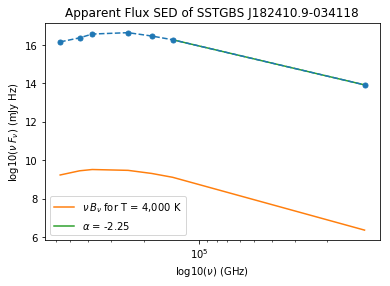

20
10039
The GB index 989
RA:  276.40700484435126
DEC:  -4.355785103218235
The difference in RA is  0.157 arcseconds
The difference in Dec is  0.159 arcseconds
The Gould_Belt_ID is  SSTGBS J182537.7-042121
alpha is -0.98
The object type is star+dust(MP1)
2MASS ID: b'18253769-0421209'
FLUX SIGNAL TO NOISE
[ 10.25735413 226.47350049  29.95262228  14.67211133  22.56858168
  19.21321885   1.           1.           1.           1.
   3.12676056]
SED Flux
[ 1.76857226e-02  5.71725368e-02  1.69941440e-01  8.12996030e-01
  1.25054717e+00  1.06462324e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.11000000e+00]
SED Flux Error
[ 1.72419928e-03  2.52446916e-04  5.67367487e-03  5.54109775e-02
  5.54109775e-02  5.54109775e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.55000000e-01]
The apparent magnitude in g is: 19.402065
The absolute magnitude in g is: 10.732592570810864
g-K is: 4.9100657
GB-GR is: 2.7816963
MIPS 1 IS MISSING
SED_nu_log
[13.0018178

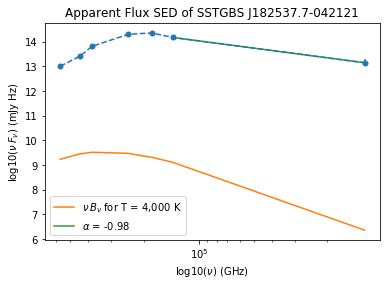

The GB index 989
RA:  276.40700484435126
DEC:  -4.355785103218235
The difference in RA is  0.157 arcseconds
The difference in Dec is  0.159 arcseconds
The Gould_Belt_ID is  SSTGBS J182537.7-042121
alpha is -0.98
The object type is star+dust(MP1)
2MASS ID: b'18253769-0421209'
FLUX SIGNAL TO NOISE
[ 10.25735413 226.47350049  29.95262228  14.67211133  22.56858168
  19.21321885   1.           1.           1.           1.
   3.12676056]
SED Flux
[ 1.76857226e-02  5.71725368e-02  1.69941440e-01  8.12996030e-01
  1.25054717e+00  1.06462324e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.11000000e+00]
SED Flux Error
[ 1.72419928e-03  2.52446916e-04  5.67367487e-03  5.54109775e-02
  5.54109775e-02  5.54109775e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.55000000e-01]
The apparent magnitude in g is: 19.402065
The absolute magnitude in g is: 10.732592570810864
g-K is: 4.9100657
GB-GR is: 2.7816963
MIPS 1 IS MISSING
SED_nu_log
[13.00181781 13.4051

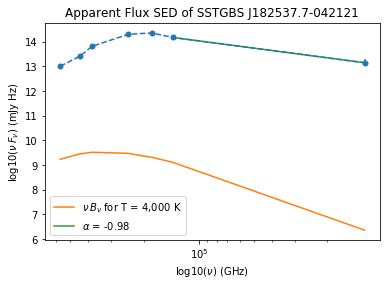

21
11550
The GB index 1185
RA:  276.8365334025829
DEC:  -4.316848306380546
The difference in RA is  0.066 arcseconds
The difference in Dec is  0.15 arcseconds
The Gould_Belt_ID is  SSTGBS J182720.8-041901
alpha is -1.32
The object type is star+dust(IR3)
2MASS ID: b'18272077-0419005'
FLUX SIGNAL TO NOISE
[  5.43323103 242.54258661  41.31325016  27.14340549  41.52178562
  37.56397378  15.42424242   1.          15.42424242   1.
   7.75193798]
SED Flux
[ 9.12955329e-02  3.68705064e-01  1.15366757e+00  6.15585566e+00
  9.41672993e+00  8.51913738e+00  5.09000000e+00 -9.99000000e+02
  5.09000000e+00 -9.99000000e+02  4.00000000e+00]
SED Flux Error
[ 1.68031752e-02  1.52016629e-03  2.79248804e-02  2.26790100e-01
  2.26790100e-01  2.26790100e-01  3.30000000e-01 -9.99000000e+02
  3.30000000e-01 -9.99000000e+02  5.16000000e-01]
The apparent magnitude in g is: 17.378336
The absolute magnitude in g is: 9.34787648106138
g-K is: 5.1443357
GB-GR is: 3.0790815
MIPS 1 IS MISSING
SED_nu_log
[13.71464453 1

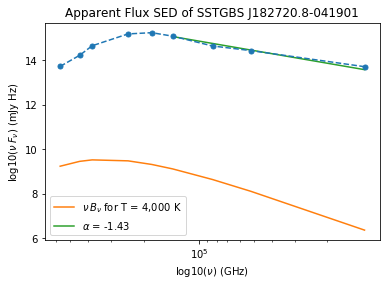

The GB index 1185
RA:  276.8365334025829
DEC:  -4.316848306380546
The difference in RA is  0.066 arcseconds
The difference in Dec is  0.15 arcseconds
The Gould_Belt_ID is  SSTGBS J182720.8-041901
alpha is -1.32
The object type is star+dust(IR3)
2MASS ID: b'18272077-0419005'
FLUX SIGNAL TO NOISE
[  5.43323103 242.54258661  41.31325016  27.14340549  41.52178562
  37.56397378  15.42424242   1.          15.42424242   1.
   7.75193798]
SED Flux
[ 9.12955329e-02  3.68705064e-01  1.15366757e+00  6.15585566e+00
  9.41672993e+00  8.51913738e+00  5.09000000e+00 -9.99000000e+02
  5.09000000e+00 -9.99000000e+02  4.00000000e+00]
SED Flux Error
[ 1.68031752e-02  1.52016629e-03  2.79248804e-02  2.26790100e-01
  2.26790100e-01  2.26790100e-01  3.30000000e-01 -9.99000000e+02
  3.30000000e-01 -9.99000000e+02  5.16000000e-01]
The apparent magnitude in g is: 17.378336
The absolute magnitude in g is: 9.34787648106138
g-K is: 5.1443357
GB-GR is: 3.0790815
MIPS 1 IS MISSING
SED_nu_log
[13.71464453 14.2146788

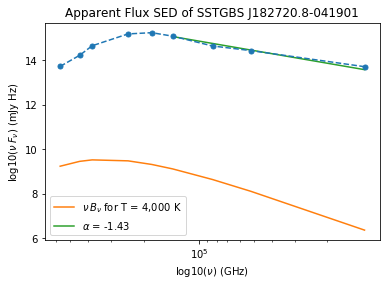

22
10931
The GB index 1213
RA:  276.8586359925115
DEC:  -4.5798945359883545
The difference in RA is  0.422 arcseconds
The difference in Dec is  0.457 arcseconds
The Gould_Belt_ID is  SSTGBS J182726.0-043447
alpha is -0.53
The object type is star+dust(MP1)
2MASS ID: b'18272608-0434473'
FLUX SIGNAL TO NOISE
[ 76.70331826 340.31927387 135.90629624  51.70172423  60.49461373
  73.89454522   1.           1.           1.           1.
   9.79522184]
SED Flux
[ 100.95787811  195.17488098  345.18954468  653.56414795  764.71551514
  934.10473633 -999.         -999.         -999.         -999.
 2870.        ]
SED Flux Error
[ 1.31621265e+00  5.73505223e-01  2.53990841e+00  1.26410513e+01
  1.26410513e+01  1.26410513e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.93000000e+02]
The apparent magnitude in g is: 10.5689745
The absolute magnitude in g is: 2.5476234271628257
g-K is: 3.4349747
GB-GR is: 1.6597977
MIPS 1 IS MISSING
SED_nu_log
[16.75833522 16.93842367 17.11814825 17

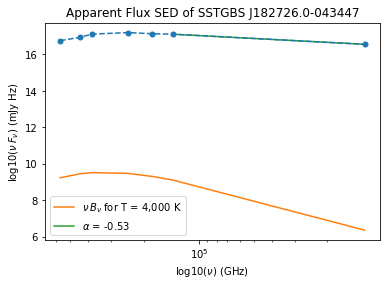

The GB index 1213
RA:  276.8586359925115
DEC:  -4.5798945359883545
The difference in RA is  0.422 arcseconds
The difference in Dec is  0.457 arcseconds
The Gould_Belt_ID is  SSTGBS J182726.0-043447
alpha is -0.53
The object type is star+dust(MP1)
2MASS ID: b'18272608-0434473'
FLUX SIGNAL TO NOISE
[ 76.70331826 340.31927387 135.90629624  51.70172423  60.49461373
  73.89454522   1.           1.           1.           1.
   9.79522184]
SED Flux
[ 100.95787811  195.17488098  345.18954468  653.56414795  764.71551514
  934.10473633 -999.         -999.         -999.         -999.
 2870.        ]
SED Flux Error
[ 1.31621265e+00  5.73505223e-01  2.53990841e+00  1.26410513e+01
  1.26410513e+01  1.26410513e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.93000000e+02]
The apparent magnitude in g is: 10.5689745
The absolute magnitude in g is: 2.5476234271628257
g-K is: 3.4349747
GB-GR is: 1.6597977
MIPS 1 IS MISSING
SED_nu_log
[16.75833522 16.93842367 17.11814825 17.20044197

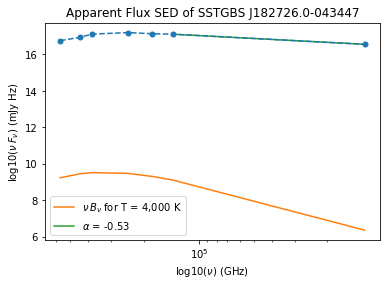

23
12391
The GB index 1280
RA:  276.9202852655942
DEC:  -3.8498061108230344
The difference in RA is  0.032 arcseconds
The difference in Dec is  0.046 arcseconds
The Gould_Belt_ID is  SSTGBS J182740.9-035059
alpha is -0.81
The object type is star+dust(IR3)
2MASS ID: b'18274086-0350593'
FLUX SIGNAL TO NOISE
[  5.32351347 187.32009382  61.36478659  37.4391814   78.40391513
  85.82891729  18.43065693  17.6744186   18.43065693  12.2556391
   2.47663551]
SED Flux
[1.99413020e-02 1.76992908e-01 6.08111978e-01 6.17289162e+00
 1.29270687e+01 1.41512871e+01 1.01000000e+01 8.36000000e+00
 1.01000000e+01 1.63000000e+01 5.30000000e+01]
SED Flux Error
[3.74589115e-03 9.44868778e-04 9.90978722e-03 1.64877847e-01
 1.64877847e-01 1.64877847e-01 5.48000000e-01 4.73000000e-01
 5.48000000e-01 1.33000000e+00 2.14000000e+01]
The apparent magnitude in g is: 18.175144
The absolute magnitude in g is: 9.822663751937743
g-K is: 6.4921446
GB-GR is: 4.0355797
SED_nu_log
[13.05394852 13.89595561 14.36407417 15.1756

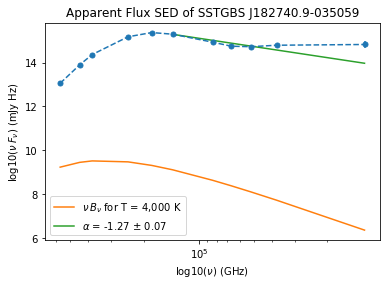

The GB index 1280
RA:  276.9202852655942
DEC:  -3.8498061108230344
The difference in RA is  0.032 arcseconds
The difference in Dec is  0.046 arcseconds
The Gould_Belt_ID is  SSTGBS J182740.9-035059
alpha is -0.81
The object type is star+dust(IR3)
2MASS ID: b'18274086-0350593'
FLUX SIGNAL TO NOISE
[  5.32351347 187.32009382  61.36478659  37.4391814   78.40391513
  85.82891729  18.43065693  17.6744186   18.43065693  12.2556391
   2.47663551]
SED Flux
[1.99413020e-02 1.76992908e-01 6.08111978e-01 6.17289162e+00
 1.29270687e+01 1.41512871e+01 1.01000000e+01 8.36000000e+00
 1.01000000e+01 1.63000000e+01 5.30000000e+01]
SED Flux Error
[3.74589115e-03 9.44868778e-04 9.90978722e-03 1.64877847e-01
 1.64877847e-01 1.64877847e-01 5.48000000e-01 4.73000000e-01
 5.48000000e-01 1.33000000e+00 2.14000000e+01]
The apparent magnitude in g is: 18.175144
The absolute magnitude in g is: 9.822663751937743
g-K is: 6.4921446
GB-GR is: 4.0355797
SED_nu_log
[13.05394852 13.89595561 14.36407417 15.1756424  15.3

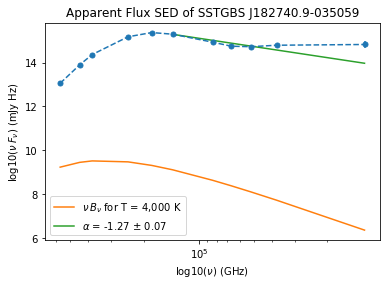

24
5732
The GB index 1401
RA:  277.0572834711105
DEC:  -2.142441674558036
The difference in RA is  0.039 arcseconds
The difference in Dec is  0.004 arcseconds
The Gould_Belt_ID is  SSTGBS J182813.7-020833
alpha is -1.16
The object type is Galc_star+dust(IR3)
2MASS ID: b'18281374-0208327'
FLUX SIGNAL TO NOISE
[  4.24222779 175.69303586  32.25421842  22.61950384  40.84085127
  41.15194837  19.61538462  20.61349693  19.61538462  19.40144479
   5.86206897]
SED Flux
[0.01214783 0.03351985 0.11778153 1.45240688 2.62240648 2.64238214
 2.04       1.68       2.04       1.88       1.7       ]
SED Flux Error
[2.86354986e-03 1.90786421e-04 3.65166296e-03 6.42103776e-02
 6.42103776e-02 6.42103776e-02 1.04000000e-01 8.15000000e-02
 1.04000000e-01 9.69000000e-02 2.90000000e-01]
The apparent magnitude in g is: 19.98178
The absolute magnitude in g is: 11.282124021830194
g-K is: 6.476779
GB-GR is: 2.7914486
SED_nu_log
[12.83869374 13.17330176 13.65116782 14.54724204 14.67488969 14.56456369
 14.23533526 

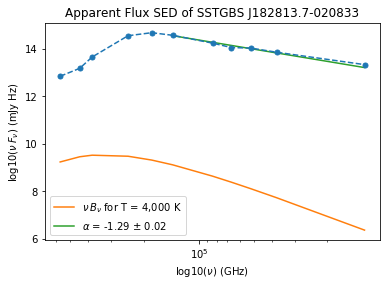

The GB index 1401
RA:  277.0572834711105
DEC:  -2.142441674558036
The difference in RA is  0.039 arcseconds
The difference in Dec is  0.004 arcseconds
The Gould_Belt_ID is  SSTGBS J182813.7-020833
alpha is -1.16
The object type is Galc_star+dust(IR3)
2MASS ID: b'18281374-0208327'
FLUX SIGNAL TO NOISE
[  4.24222779 175.69303586  32.25421842  22.61950384  40.84085127
  41.15194837  19.61538462  20.61349693  19.61538462  19.40144479
   5.86206897]
SED Flux
[0.01214783 0.03351985 0.11778153 1.45240688 2.62240648 2.64238214
 2.04       1.68       2.04       1.88       1.7       ]
SED Flux Error
[2.86354986e-03 1.90786421e-04 3.65166296e-03 6.42103776e-02
 6.42103776e-02 6.42103776e-02 1.04000000e-01 8.15000000e-02
 1.04000000e-01 9.69000000e-02 2.90000000e-01]
The apparent magnitude in g is: 19.98178
The absolute magnitude in g is: 11.282124021830194
g-K is: 6.476779
GB-GR is: 2.7914486
SED_nu_log
[12.83869374 13.17330176 13.65116782 14.54724204 14.67488969 14.56456369
 14.23533526 14.04844

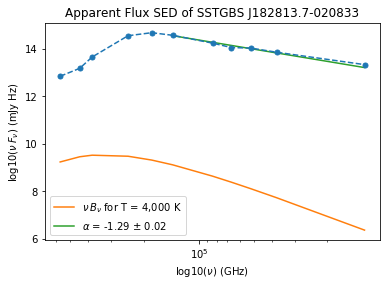

25
9989
The GB index 1414
RA:  277.074417519472
DEC:  -4.574346488967392
The difference in RA is  0.113 arcseconds
The difference in Dec is  0.101 arcseconds
The Gould_Belt_ID is  SSTGBS J182817.9-043428
alpha is -2.31
The object type is star+dust(MP1)
2MASS ID: b'18281786-0434275'
FLUX SIGNAL TO NOISE
[1.21759963e+03 4.66283663e+03 8.88643485e+02 4.93516449e+01
 3.95105767e+01 2.92421097e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.00906344e+00]
SED Flux
[  19.18312073   33.4005928    55.13389587   90.96795654   72.82830048
   53.90083694 -999.         -999.         -999.         -999.
    2.32      ]
SED Flux Error
[ 1.57548673e-02  7.16314884e-03  6.20427616e-02  1.84326088e+00
  1.84326088e+00  1.84326088e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.31000000e-01]
The apparent magnitude in g is: 12.485648
The absolute magnitude in g is: 4.071510398055562
g-K is: 2.2546482
GB-GR is: 1.4712524
MIPS 1 IS MISSING
SED_nu_log
[16.03711427 1

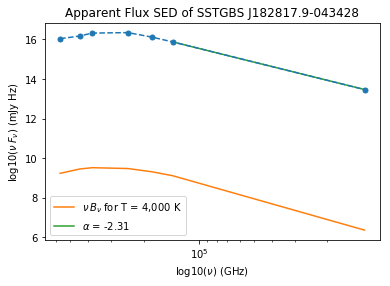

The GB index 1414
RA:  277.074417519472
DEC:  -4.574346488967392
The difference in RA is  0.113 arcseconds
The difference in Dec is  0.101 arcseconds
The Gould_Belt_ID is  SSTGBS J182817.9-043428
alpha is -2.31
The object type is star+dust(MP1)
2MASS ID: b'18281786-0434275'
FLUX SIGNAL TO NOISE
[1.21759963e+03 4.66283663e+03 8.88643485e+02 4.93516449e+01
 3.95105767e+01 2.92421097e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.00906344e+00]
SED Flux
[  19.18312073   33.4005928    55.13389587   90.96795654   72.82830048
   53.90083694 -999.         -999.         -999.         -999.
    2.32      ]
SED Flux Error
[ 1.57548673e-02  7.16314884e-03  6.20427616e-02  1.84326088e+00
  1.84326088e+00  1.84326088e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.31000000e-01]
The apparent magnitude in g is: 12.485648
The absolute magnitude in g is: 4.071510398055562
g-K is: 2.2546482
GB-GR is: 1.4712524
MIPS 1 IS MISSING
SED_nu_log
[16.03711427 16.171753

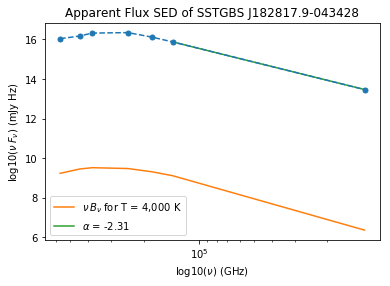

26
10829
The GB index 1437
RA:  277.1055878296834
DEC:  -4.280083195775563
The difference in RA is  0.051 arcseconds
The difference in Dec is  0.03 arcseconds
The Gould_Belt_ID is  SSTGBS J182825.3-041648
alpha is -1.99
The object type is star+dust(MP1)
2MASS ID: b'18282533-0416483'
FLUX SIGNAL TO NOISE
[  3.02819226  76.63108403  21.54587034  47.20592314 172.11088062
 273.34071272  20.29478458   1.          20.29478458   1.
  10.77272727]
SED Flux
[ 1.90099739e-02  1.30176917e-01  6.23330116e-01  3.69903069e+01
  1.34865158e+02  2.14188309e+02  1.79000000e+02 -9.99000000e+02
  1.79000000e+02 -9.99000000e+02  2.37000000e+01]
SED Flux Error
[ 6.27766410e-03  1.69874821e-03  2.89303754e-02  7.83594608e-01
  7.83594608e-01  7.83594608e-01  8.82000000e+00 -9.99000000e+02
  8.82000000e+00 -9.99000000e+02  2.20000000e+00]
The apparent magnitude in g is: 18.5087
The absolute magnitude in g is: 10.136720614550976
g-K is: 9.7757
GB-GR is: 4.1143456
MIPS 1 IS MISSING
SED_nu_log
[13.03317653 13.7

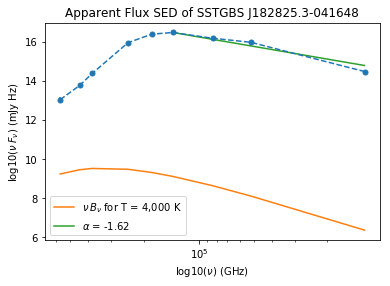

The GB index 1437
RA:  277.1055878296834
DEC:  -4.280083195775563
The difference in RA is  0.051 arcseconds
The difference in Dec is  0.03 arcseconds
The Gould_Belt_ID is  SSTGBS J182825.3-041648
alpha is -1.99
The object type is star+dust(MP1)
2MASS ID: b'18282533-0416483'
FLUX SIGNAL TO NOISE
[  3.02819226  76.63108403  21.54587034  47.20592314 172.11088062
 273.34071272  20.29478458   1.          20.29478458   1.
  10.77272727]
SED Flux
[ 1.90099739e-02  1.30176917e-01  6.23330116e-01  3.69903069e+01
  1.34865158e+02  2.14188309e+02  1.79000000e+02 -9.99000000e+02
  1.79000000e+02 -9.99000000e+02  2.37000000e+01]
SED Flux Error
[ 6.27766410e-03  1.69874821e-03  2.89303754e-02  7.83594608e-01
  7.83594608e-01  7.83594608e-01  8.82000000e+00 -9.99000000e+02
  8.82000000e+00 -9.99000000e+02  2.20000000e+00]
The apparent magnitude in g is: 18.5087
The absolute magnitude in g is: 10.136720614550976
g-K is: 9.7757
GB-GR is: 4.1143456
MIPS 1 IS MISSING
SED_nu_log
[13.03317653 13.76253373 1

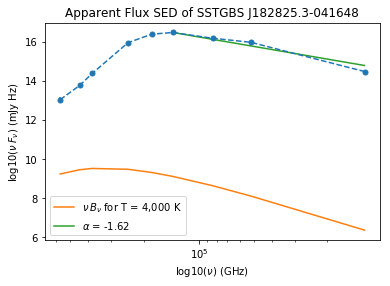

27
2374
The GB index 1470
RA:  277.1662064999018
DEC:  -2.8153965444062554
The difference in RA is  0.041 arcseconds
The difference in Dec is  0.051 arcseconds
The Gould_Belt_ID is  SSTGBS J182839.9-024855
alpha is -1.71
The object type is star+dust(IR4)
2MASS ID: b'18283988-0248553'
FLUX SIGNAL TO NOISE
[ 16.19448352 846.25826322 167.36247608  41.75908278  67.19894863
  64.66326766  12.3986095   14.85106383  12.3986095   13.1588785
  -1.03703704]
SED Flux
[  0.07398315   0.52635443   1.53641653  12.13636684  19.52990913
  18.79296875  10.7          6.98        10.7          7.04
 -22.4       ]
SED Flux Error
[4.56841663e-03 6.21978485e-04 9.18017328e-03 2.90628195e-01
 2.90628195e-01 2.90628195e-01 8.63000000e-01 4.70000000e-01
 8.63000000e-01 5.35000000e-01 2.16000000e+01]
The apparent magnitude in g is: 16.991838
The absolute magnitude in g is: 8.473765012994624
g-K is: 5.6168385
GB-GR is: 3.6184444
MIPS 1 IS MISSING
SED_nu_log
[13.62332781 14.36927803 14.76659958 15.46924244 15.546

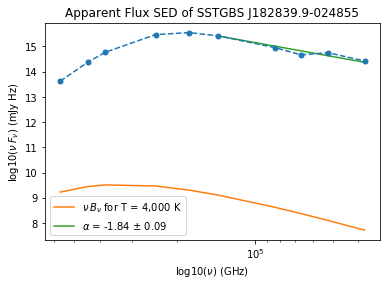

The GB index 1470
RA:  277.1662064999018
DEC:  -2.8153965444062554
The difference in RA is  0.041 arcseconds
The difference in Dec is  0.051 arcseconds
The Gould_Belt_ID is  SSTGBS J182839.9-024855
alpha is -1.71
The object type is star+dust(IR4)
2MASS ID: b'18283988-0248553'
FLUX SIGNAL TO NOISE
[ 16.19448352 846.25826322 167.36247608  41.75908278  67.19894863
  64.66326766  12.3986095   14.85106383  12.3986095   13.1588785
  -1.03703704]
SED Flux
[  0.07398315   0.52635443   1.53641653  12.13636684  19.52990913
  18.79296875  10.7          6.98        10.7          7.04
 -22.4       ]
SED Flux Error
[4.56841663e-03 6.21978485e-04 9.18017328e-03 2.90628195e-01
 2.90628195e-01 2.90628195e-01 8.63000000e-01 4.70000000e-01
 8.63000000e-01 5.35000000e-01 2.16000000e+01]
The apparent magnitude in g is: 16.991838
The absolute magnitude in g is: 8.473765012994624
g-K is: 5.6168385
GB-GR is: 3.6184444
MIPS 1 IS MISSING
SED_nu_log
[13.62332781 14.36927803 14.76659958 15.46924244 15.54688991 15

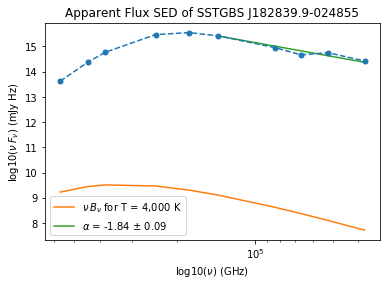

28
10935
The GB index 1506
RA:  277.2300609043041
DEC:  -4.061409873104111
The difference in RA is  0.091 arcseconds
The difference in Dec is  0.207 arcseconds
The Gould_Belt_ID is  SSTGBS J182855.2-040341
alpha is -0.9
The object type is star+dust(IR3)
2MASS ID: b'18285520-0403410'
FLUX SIGNAL TO NOISE
[ 28.95932647 144.0360618   52.06221658  47.20592386  82.15007862
 101.93042805  20.03636364   1.          20.03636364   1.
  10.73264781]
SED Flux
[ 9.38286841e-01  3.47331667e+00  8.92970181e+00  2.80342178e+01
  4.87865295e+01  6.05335007e+01  5.51000000e+01 -9.99000000e+02
  5.51000000e+01 -9.99000000e+02  8.35000000e+01]
SED Flux Error
[ 3.24001610e-02  2.41142157e-02  1.71519816e-01  5.93870759e-01
  5.93870759e-01  5.93870759e-01  2.75000000e+00 -9.99000000e+02
  2.75000000e+00 -9.99000000e+02  7.78000000e+00]
The apparent magnitude in g is: 14.943172
The absolute magnitude in g is: 6.967183094557843
g-K is: 4.838173
GB-GR is: 2.7712574
MIPS 1 IS MISSING
SED_nu_log
[14.72653063 1

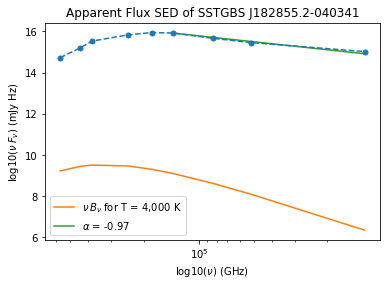

The GB index 1506
RA:  277.2300609043041
DEC:  -4.061409873104111
The difference in RA is  0.091 arcseconds
The difference in Dec is  0.207 arcseconds
The Gould_Belt_ID is  SSTGBS J182855.2-040341
alpha is -0.9
The object type is star+dust(IR3)
2MASS ID: b'18285520-0403410'
FLUX SIGNAL TO NOISE
[ 28.95932647 144.0360618   52.06221658  47.20592386  82.15007862
 101.93042805  20.03636364   1.          20.03636364   1.
  10.73264781]
SED Flux
[ 9.38286841e-01  3.47331667e+00  8.92970181e+00  2.80342178e+01
  4.87865295e+01  6.05335007e+01  5.51000000e+01 -9.99000000e+02
  5.51000000e+01 -9.99000000e+02  8.35000000e+01]
SED Flux Error
[ 3.24001610e-02  2.41142157e-02  1.71519816e-01  5.93870759e-01
  5.93870759e-01  5.93870759e-01  2.75000000e+00 -9.99000000e+02
  2.75000000e+00 -9.99000000e+02  7.78000000e+00]
The apparent magnitude in g is: 14.943172
The absolute magnitude in g is: 6.967183094557843
g-K is: 4.838173
GB-GR is: 2.7712574
MIPS 1 IS MISSING
SED_nu_log
[14.72653063 15.1887441

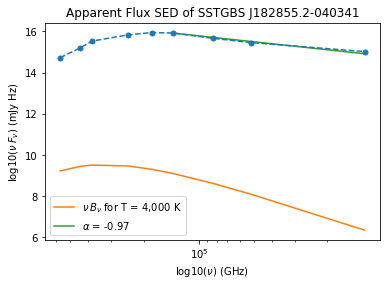

29
10976
The GB index 1627
RA:  277.37861048384514
DEC:  -4.387455560507114
The difference in RA is  0.923 arcseconds
The difference in Dec is  0.019 arcseconds
The Gould_Belt_ID is  SSTGBS J182930.8-042315
alpha is -0.91
The object type is star+dust(MP1)
2MASS ID: b'18293086-0423146'
FLUX SIGNAL TO NOISE
[21.48312048 49.80645319 18.7530949  40.21245324 57.88581445 56.52850002
  1.          1.          1.          1.         10.7967033 ]
SED Flux
[ 8.20794582e-01  2.36585808e+00  5.68266678e+00  2.26406212e+01
  3.25911674e+01  3.18269653e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.93000000e+01]
SED Flux Error
[ 3.82064879e-02  4.75010350e-02  3.03025544e-01  5.63025117e-01
  5.63025117e-01  5.63025117e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.64000000e+00]
The apparent magnitude in g is: 15.360063
The absolute magnitude in g is: 7.083691902596717
g-K is: 4.557062
GB-GR is: 2.4257975
MIPS 1 IS MISSING
SED_nu_log
[14.66842949 15.

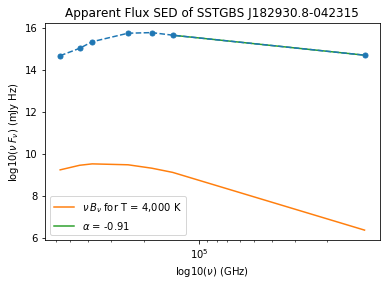

The GB index 1627
RA:  277.37861048384514
DEC:  -4.387455560507114
The difference in RA is  0.923 arcseconds
The difference in Dec is  0.019 arcseconds
The Gould_Belt_ID is  SSTGBS J182930.8-042315
alpha is -0.91
The object type is star+dust(MP1)
2MASS ID: b'18293086-0423146'
FLUX SIGNAL TO NOISE
[21.48312048 49.80645319 18.7530949  40.21245324 57.88581445 56.52850002
  1.          1.          1.          1.         10.7967033 ]
SED Flux
[ 8.20794582e-01  2.36585808e+00  5.68266678e+00  2.26406212e+01
  3.25911674e+01  3.18269653e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.93000000e+01]
SED Flux Error
[ 3.82064879e-02  4.75010350e-02  3.03025544e-01  5.63025117e-01
  5.63025117e-01  5.63025117e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.64000000e+00]
The apparent magnitude in g is: 15.360063
The absolute magnitude in g is: 7.083691902596717
g-K is: 4.557062
GB-GR is: 2.4257975
MIPS 1 IS MISSING
SED_nu_log
[14.66842949 15.02198844 

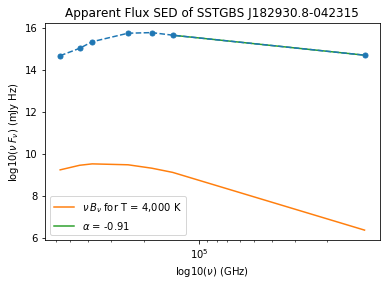

30
3784
The GB index 1764
RA:  277.5502544771099
DEC:  -2.502578917813625
The difference in RA is  0.195 arcseconds
The difference in Dec is  0.144 arcseconds
The Gould_Belt_ID is  SSTGBS J183012.1-023009
alpha is -1.84
The object type is star+dust(IR3)
2MASS ID: b'18301208-0230093'
FLUX SIGNAL TO NOISE
[5.30746594e+01 9.95411661e+02 1.59670653e+02 3.74391792e+01
 5.10431940e+01 4.27792864e+01 1.65882353e+01 1.45263158e+01
 1.65882353e+01 1.20765027e+01 2.94117647e-02]
SED Flux
[0.24409601 0.80779737 1.85535574 6.44597149 8.78819942 7.36538744
 4.23       2.76       4.23       2.21       0.0105    ]
SED Flux Error
[0.00459911 0.00081152 0.01161989 0.17217182 0.17217182 0.17217182
 0.255      0.19       0.255      0.183      0.357     ]
The apparent magnitude in g is: 16.526777
The absolute magnitude in g is: 8.072333445917508
g-K is: 4.134777
GB-GR is: 2.5271702
SED_nu_log
[14.14175569 14.55530218 14.84851781 15.19444213 15.20008959 15.00976366
 14.55204546 14.26404174 14.34435739 13.9

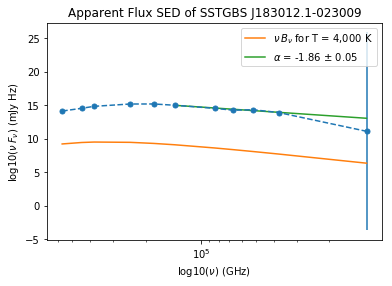

The GB index 1764
RA:  277.5502544771099
DEC:  -2.502578917813625
The difference in RA is  0.195 arcseconds
The difference in Dec is  0.144 arcseconds
The Gould_Belt_ID is  SSTGBS J183012.1-023009
alpha is -1.84
The object type is star+dust(IR3)
2MASS ID: b'18301208-0230093'
FLUX SIGNAL TO NOISE
[5.30746594e+01 9.95411661e+02 1.59670653e+02 3.74391792e+01
 5.10431940e+01 4.27792864e+01 1.65882353e+01 1.45263158e+01
 1.65882353e+01 1.20765027e+01 2.94117647e-02]
SED Flux
[0.24409601 0.80779737 1.85535574 6.44597149 8.78819942 7.36538744
 4.23       2.76       4.23       2.21       0.0105    ]
SED Flux Error
[0.00459911 0.00081152 0.01161989 0.17217182 0.17217182 0.17217182
 0.255      0.19       0.255      0.183      0.357     ]
The apparent magnitude in g is: 16.526777
The absolute magnitude in g is: 8.072333445917508
g-K is: 4.134777
GB-GR is: 2.5271702
SED_nu_log
[14.14175569 14.55530218 14.84851781 15.19444213 15.20008959 15.00976366
 14.55204546 14.26404174 14.34435739 13.92208385 

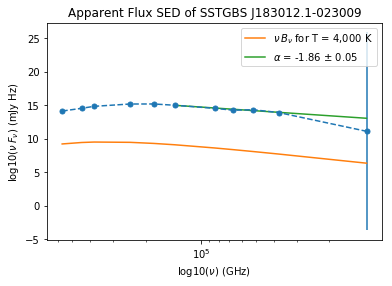

31
4157
The GB index 1799
RA:  277.588495556125
DEC:  -4.4605089120560635
The difference in RA is  0.269 arcseconds
The difference in Dec is  0.801 arcseconds
The Gould_Belt_ID is  SSTGBS J183021.2-042737
alpha is -0.41
The object type is star+dust(MP1)
2MASS ID: b'18302124-0427375'
FLUX SIGNAL TO NOISE
[4.32156183e+02 2.27179330e+03 5.36062555e+02 4.72059191e+01
 5.39769291e+01 4.64198593e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.08033241e+01]
SED Flux
[   5.85414553   16.04335403   34.44493866   95.16742706  108.81782532
   93.58272552 -999.         -999.         -999.         -999.
  390.        ]
SED Flux Error
[ 1.35463653e-02  7.06197787e-03  6.42554462e-02  2.01600623e+00
  2.01600623e+00  2.01600623e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.61000000e+01]
The apparent magnitude in g is: 13.2817955
The absolute magnitude in g is: 5.006226662565902
g-K is: 3.6497955
GB-GR is: 2.2491589
MIPS 1 IS MISSING
SED_nu_log
[15.52165852

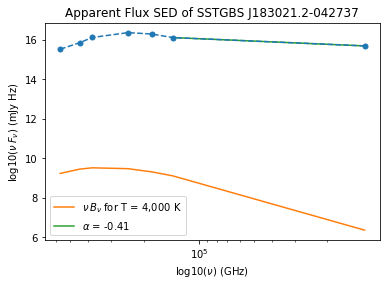

The GB index 1799
RA:  277.588495556125
DEC:  -4.4605089120560635
The difference in RA is  0.269 arcseconds
The difference in Dec is  0.801 arcseconds
The Gould_Belt_ID is  SSTGBS J183021.2-042737
alpha is -0.41
The object type is star+dust(MP1)
2MASS ID: b'18302124-0427375'
FLUX SIGNAL TO NOISE
[4.32156183e+02 2.27179330e+03 5.36062555e+02 4.72059191e+01
 5.39769291e+01 4.64198593e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.08033241e+01]
SED Flux
[   5.85414553   16.04335403   34.44493866   95.16742706  108.81782532
   93.58272552 -999.         -999.         -999.         -999.
  390.        ]
SED Flux Error
[ 1.35463653e-02  7.06197787e-03  6.42554462e-02  2.01600623e+00
  2.01600623e+00  2.01600623e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.61000000e+01]
The apparent magnitude in g is: 13.2817955
The absolute magnitude in g is: 5.006226662565902
g-K is: 3.6497955
GB-GR is: 2.2491589
MIPS 1 IS MISSING
SED_nu_log
[15.52165852 15.8532

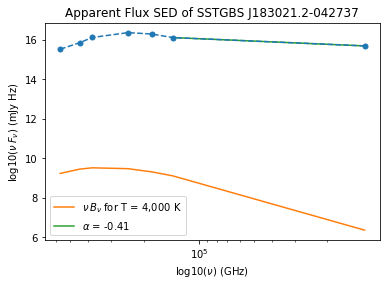

32
47459
The GB index 1880
RA:  277.66835048537
DEC:  -1.4180093677877597
The difference in RA is  0.212 arcseconds
The difference in Dec is  0.069 arcseconds
The Gould_Belt_ID is  SSTGBS J183040.4-012505
alpha is -1.93
The object type is star+dust(MP1)
2MASS ID: b'18304039-0125049'
FLUX SIGNAL TO NOISE
[ 177.03028744 1619.00929858  381.25186869   10.64447348   12.67463484
   11.51943841   13.77880184   13.91304348   13.77880184   -3.968
    3.97435897]
SED Flux
[ 0.68661326  1.5096209   2.86363149  6.9773159   8.30806065  7.55084419
  2.99        1.92        2.99       -2.48        1.55      ]
SED Flux Error
[0.00387851 0.00093243 0.00751113 0.65548718 0.65548718 0.65548718
 0.217      0.138      0.217      0.625      0.39      ]
The apparent magnitude in g is: 15.847864
The absolute magnitude in g is: 7.5236163156187335
g-K is: 3.4828644
GB-GR is: 1.8755159
MIPS 1 IS MISSING
SED_nu_log
[14.59090719 14.82686765 15.03700774 15.22884213 15.17568934 15.02056357
 14.40137628 14.10643388 1

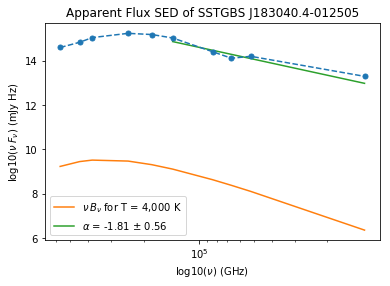

The GB index 1880
RA:  277.66835048537
DEC:  -1.4180093677877597
The difference in RA is  0.212 arcseconds
The difference in Dec is  0.069 arcseconds
The Gould_Belt_ID is  SSTGBS J183040.4-012505
alpha is -1.93
The object type is star+dust(MP1)
2MASS ID: b'18304039-0125049'
FLUX SIGNAL TO NOISE
[ 177.03028744 1619.00929858  381.25186869   10.64447348   12.67463484
   11.51943841   13.77880184   13.91304348   13.77880184   -3.968
    3.97435897]
SED Flux
[ 0.68661326  1.5096209   2.86363149  6.9773159   8.30806065  7.55084419
  2.99        1.92        2.99       -2.48        1.55      ]
SED Flux Error
[0.00387851 0.00093243 0.00751113 0.65548718 0.65548718 0.65548718
 0.217      0.138      0.217      0.625      0.39      ]
The apparent magnitude in g is: 15.847864
The absolute magnitude in g is: 7.5236163156187335
g-K is: 3.4828644
GB-GR is: 1.8755159
MIPS 1 IS MISSING
SED_nu_log
[14.59090719 14.82686765 15.03700774 15.22884213 15.17568934 15.02056357
 14.40137628 14.10643388 14.1936882

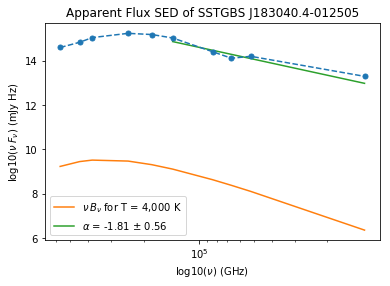

33
47465
The GB index 1907
RA:  277.68874294609844
DEC:  -1.3897714565944583
The difference in RA is  0.529 arcseconds
The difference in Dec is  0.466 arcseconds
The Gould_Belt_ID is  SSTGBS J183045.3-012323
alpha is -1.39
The object type is star+dust(IR4)
2MASS ID: b'18304531-0123225'
FLUX SIGNAL TO NOISE
[  6.49712569 245.86393577  44.61954098   9.60828479  15.82186325
  14.22175301   5.61068702   6.8852459    5.61068702  11.23647604
  -0.36319703]
SED Flux
[ 0.01151949  0.05606534  0.15562826  0.9756369   1.6065712   1.44409406
  0.735       0.546       0.735       0.727      -0.0977    ]
SED Flux Error
[1.77301280e-03 2.28034027e-04 3.48789478e-03 1.01541214e-01
 1.01541214e-01 1.01541214e-01 1.31000000e-01 7.93000000e-02
 1.31000000e-01 6.47000000e-02 2.69000000e-01]
The apparent magnitude in g is: 19.423298
The absolute magnitude in g is: 11.197269235386472
g-K is: 5.2622976
GB-GR is: 3.1516418
MIPS 1 IS MISSING
SED_nu_log
[12.81562815 13.39669423 13.77217909 14.37444196 14.46208

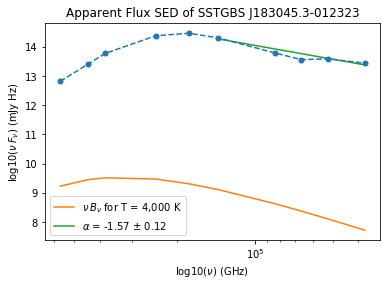

The GB index 1907
RA:  277.68874294609844
DEC:  -1.3897714565944583
The difference in RA is  0.529 arcseconds
The difference in Dec is  0.466 arcseconds
The Gould_Belt_ID is  SSTGBS J183045.3-012323
alpha is -1.39
The object type is star+dust(IR4)
2MASS ID: b'18304531-0123225'
FLUX SIGNAL TO NOISE
[  6.49712569 245.86393577  44.61954098   9.60828479  15.82186325
  14.22175301   5.61068702   6.8852459    5.61068702  11.23647604
  -0.36319703]
SED Flux
[ 0.01151949  0.05606534  0.15562826  0.9756369   1.6065712   1.44409406
  0.735       0.546       0.735       0.727      -0.0977    ]
SED Flux Error
[1.77301280e-03 2.28034027e-04 3.48789478e-03 1.01541214e-01
 1.01541214e-01 1.01541214e-01 1.31000000e-01 7.93000000e-02
 1.31000000e-01 6.47000000e-02 2.69000000e-01]
The apparent magnitude in g is: 19.423298
The absolute magnitude in g is: 11.197269235386472
g-K is: 5.2622976
GB-GR is: 3.1516418
MIPS 1 IS MISSING
SED_nu_log
[12.81562815 13.39669423 13.77217909 14.37444196 14.46208966 14.30

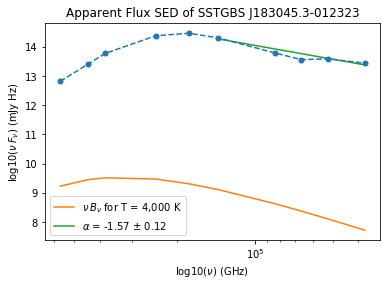

34
4060
The GB index 1956
RA:  277.717564748742
DEC:  -4.345782779953684
The difference in RA is  0.06 arcseconds
The difference in Dec is  0.028 arcseconds
The Gould_Belt_ID is  SSTGBS J183052.2-042045
alpha is -1.82
The object type is star+dust(MP1)
2MASS ID: b'18305221-0420447'
FLUX SIGNAL TO NOISE
[ 25.99996775 313.95000745 144.61022269  41.7590853   60.05684549
  53.29157343   1.           1.           1.           1.
   6.47887324]
SED Flux
[ 1.69686005e-01  8.02866995e-01  2.19355345e+00  1.04349003e+01
  1.50072060e+01  1.33166771e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.84000000e+00]
SED Flux Error
[ 6.52639288e-03  2.55730841e-03  1.51687302e-02  2.49883354e-01
  2.49883354e-01  2.49883354e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.84000000e-01]
The apparent magnitude in g is: 16.533424
The absolute magnitude in g is: 8.472605575179083
g-K is: 4.784425
GB-GR is: 3.1037588
MIPS 1 IS MISSING
SED_nu_log
[13.98384103 14.

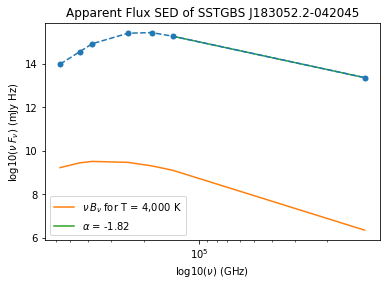

The GB index 1956
RA:  277.717564748742
DEC:  -4.345782779953684
The difference in RA is  0.06 arcseconds
The difference in Dec is  0.028 arcseconds
The Gould_Belt_ID is  SSTGBS J183052.2-042045
alpha is -1.82
The object type is star+dust(MP1)
2MASS ID: b'18305221-0420447'
FLUX SIGNAL TO NOISE
[ 25.99996775 313.95000745 144.61022269  41.7590853   60.05684549
  53.29157343   1.           1.           1.           1.
   6.47887324]
SED Flux
[ 1.69686005e-01  8.02866995e-01  2.19355345e+00  1.04349003e+01
  1.50072060e+01  1.33166771e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.84000000e+00]
SED Flux Error
[ 6.52639288e-03  2.55730841e-03  1.51687302e-02  2.49883354e-01
  2.49883354e-01  2.49883354e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.84000000e-01]
The apparent magnitude in g is: 16.533424
The absolute magnitude in g is: 8.472605575179083
g-K is: 4.784425
GB-GR is: 3.1037588
MIPS 1 IS MISSING
SED_nu_log
[13.98384103 14.55264335

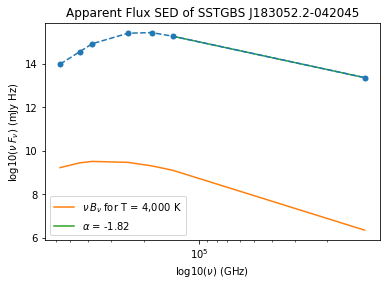

35
27828
The GB index 2079
RA:  277.799036683928
DEC:  -4.005380132320037
The difference in RA is  0.023 arcseconds
The difference in Dec is  0.225 arcseconds
The Gould_Belt_ID is  SSTGBS J183111.8-040019
alpha is -0.85
The object type is star+dust(IR3)
2MASS ID: b'18311177-0400190'
FLUX SIGNAL TO NOISE
[4.97421185e+02 1.75950157e+03 9.53471932e+02 4.17590855e+01
 3.77192357e+01 2.83830088e+01 1.98518519e+01 1.00000000e+00
 1.98518519e+01 1.00000000e+00 1.07834101e+01]
SED Flux
[   9.5062561    19.6524868    36.65051651   73.80539703   66.66532898
   50.16439438   26.8        -999.           26.8        -999.
   46.8       ]
SED Flux Error
[ 1.91110801e-02  1.11693488e-02  3.84390093e-02  1.76740932e+00
  1.76740932e+00  1.76740932e+00  1.35000000e+00 -9.99000000e+02
  1.35000000e+00 -9.99000000e+02  4.34000000e+00]
The apparent magnitude in g is: 13.06149
The absolute magnitude in g is: 4.7896603384697105
g-K is: 2.75249
GB-GR is: 1.7901802
MIPS 1 IS MISSING
SED_nu_log
[15.73220452 15

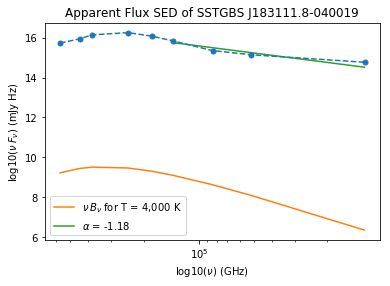

The GB index 2079
RA:  277.799036683928
DEC:  -4.005380132320037
The difference in RA is  0.023 arcseconds
The difference in Dec is  0.225 arcseconds
The Gould_Belt_ID is  SSTGBS J183111.8-040019
alpha is -0.85
The object type is star+dust(IR3)
2MASS ID: b'18311177-0400190'
FLUX SIGNAL TO NOISE
[4.97421185e+02 1.75950157e+03 9.53471932e+02 4.17590855e+01
 3.77192357e+01 2.83830088e+01 1.98518519e+01 1.00000000e+00
 1.98518519e+01 1.00000000e+00 1.07834101e+01]
SED Flux
[   9.5062561    19.6524868    36.65051651   73.80539703   66.66532898
   50.16439438   26.8        -999.           26.8        -999.
   46.8       ]
SED Flux Error
[ 1.91110801e-02  1.11693488e-02  3.84390093e-02  1.76740932e+00
  1.76740932e+00  1.76740932e+00  1.35000000e+00 -9.99000000e+02
  1.35000000e+00 -9.99000000e+02  4.34000000e+00]
The apparent magnitude in g is: 13.06149
The absolute magnitude in g is: 4.7896603384697105
g-K is: 2.75249
GB-GR is: 1.7901802
MIPS 1 IS MISSING
SED_nu_log
[15.73220452 15.94141726

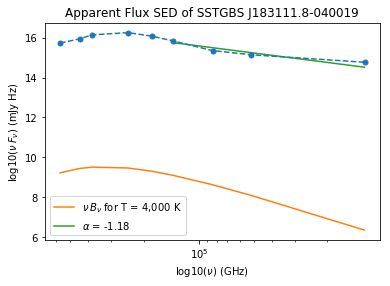

36
3802
The GB index 2107
RA:  277.8135699844219
DEC:  -2.093275295849145
The difference in RA is  0.015 arcseconds
The difference in Dec is  0.252 arcseconds
The Gould_Belt_ID is  SSTGBS J183115.3-020536
alpha is -0.81
The object type is star+dust(IR1)
2MASS ID: b'18311526-0205355'
FLUX SIGNAL TO NOISE
[         nan  61.84028057          nan  47.20592227 160.47525761
 336.28191552  16.57894737  19.70588235  16.57894737  16.34615385
   1.63834951]
SED Flux
[         nan   0.20429017          nan  15.06914234  51.22714233
 107.3483963  189.         201.         189.         170.
 135.        ]
SED Flux Error
[           nan 3.30351293e-03            nan 3.19221437e-01
 3.19221437e-01 3.19221437e-01 1.14000000e+01 1.02000000e+01
 1.14000000e+01 1.04000000e+01 8.24000000e+01]
The apparent magnitude in g is: 18.019415
The absolute magnitude in g is: 9.675032543513904
g-K is: 8.536415
GB-GR is: --
MIPS 1 IS MISSING
SED_nu_log
[13.95824721 15.56324228 15.96568981 16.17336362 16.2021669  16.1

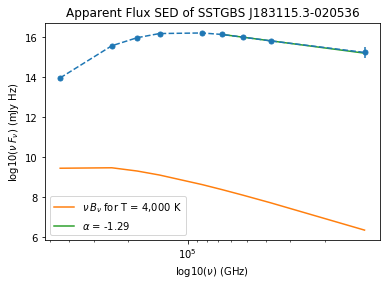

The GB index 2107
RA:  277.8135699844219
DEC:  -2.093275295849145
The difference in RA is  0.015 arcseconds
The difference in Dec is  0.252 arcseconds
The Gould_Belt_ID is  SSTGBS J183115.3-020536
alpha is -0.81
The object type is star+dust(IR1)
2MASS ID: b'18311526-0205355'
FLUX SIGNAL TO NOISE
[         nan  61.84028057          nan  47.20592227 160.47525761
 336.28191552  16.57894737  19.70588235  16.57894737  16.34615385
   1.63834951]
SED Flux
[         nan   0.20429017          nan  15.06914234  51.22714233
 107.3483963  189.         201.         189.         170.
 135.        ]
SED Flux Error
[           nan 3.30351293e-03            nan 3.19221437e-01
 3.19221437e-01 3.19221437e-01 1.14000000e+01 1.02000000e+01
 1.14000000e+01 1.04000000e+01 8.24000000e+01]
The apparent magnitude in g is: 18.019415
The absolute magnitude in g is: 9.675032543513904
g-K is: 8.536415
GB-GR is: --
MIPS 1 IS MISSING
SED_nu_log
[13.95824721 15.56324228 15.96568981 16.17336362 16.2021669  16.12632871


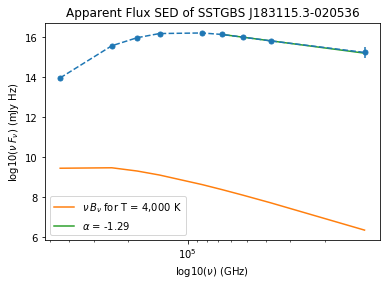

37
3974
The GB index 2178
RA:  277.84409491064514
DEC:  -2.092138110870018
The difference in RA is  0.072 arcseconds
The difference in Dec is  0.081 arcseconds
The Gould_Belt_ID is  SSTGBS J183122.6-020532
alpha is -1.83
The object type is star+dust(IR4)
2MASS ID: b'18312257-0205315'
FLUX SIGNAL TO NOISE
[1.24876700e+02 1.39922807e+03 2.39952918e+02 3.74391801e+01
 5.63816916e+01 5.80809451e+01 1.73831776e+01 1.83168317e+01
 1.73831776e+01 6.14285714e+00 1.00000000e+00]
SED Flux
[   1.16022229    8.97222233   26.83220863  206.67510986  311.24325562
  320.62362671  186.          148.          186.          172.
 -999.        ]
SED Flux Error
[ 9.29094292e-03  6.41226582e-03  1.11822806e-01  5.52028942e+00
  5.52028942e+00  5.52028942e+00  1.07000000e+01  8.08000000e+00
  1.07000000e+01  2.80000000e+01 -9.99000000e+02]
The apparent magnitude in g is: 13.912784
The absolute magnitude in g is: 5.302240558232777
g-K is: 5.6177835
GB-GR is: 3.7352915
MIPS 1 IS MISSING
SED_nu_log
[14.81873621

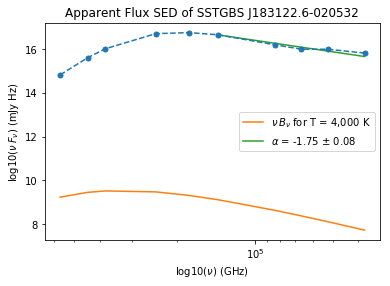

The GB index 2178
RA:  277.84409491064514
DEC:  -2.092138110870018
The difference in RA is  0.072 arcseconds
The difference in Dec is  0.081 arcseconds
The Gould_Belt_ID is  SSTGBS J183122.6-020532
alpha is -1.83
The object type is star+dust(IR4)
2MASS ID: b'18312257-0205315'
FLUX SIGNAL TO NOISE
[1.24876700e+02 1.39922807e+03 2.39952918e+02 3.74391801e+01
 5.63816916e+01 5.80809451e+01 1.73831776e+01 1.83168317e+01
 1.73831776e+01 6.14285714e+00 1.00000000e+00]
SED Flux
[   1.16022229    8.97222233   26.83220863  206.67510986  311.24325562
  320.62362671  186.          148.          186.          172.
 -999.        ]
SED Flux Error
[ 9.29094292e-03  6.41226582e-03  1.11822806e-01  5.52028942e+00
  5.52028942e+00  5.52028942e+00  1.07000000e+01  8.08000000e+00
  1.07000000e+01  2.80000000e+01 -9.99000000e+02]
The apparent magnitude in g is: 13.912784
The absolute magnitude in g is: 5.302240558232777
g-K is: 5.6177835
GB-GR is: 3.7352915
MIPS 1 IS MISSING
SED_nu_log
[14.81873621 15.6008

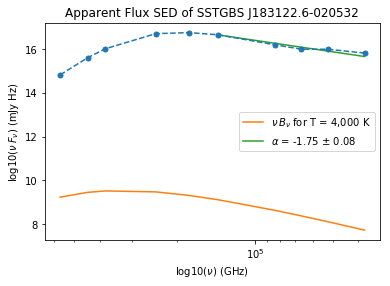

38
3857
The GB index 2186
RA:  277.8470074845617
DEC:  -2.3313913542952314
The difference in RA is  0.059 arcseconds
The difference in Dec is  0.11 arcseconds
The Gould_Belt_ID is  SSTGBS J183123.3-021953
alpha is 0.56
The object type is star+dust(MP1)
2MASS ID: b'18312326-0219529'
FLUX SIGNAL TO NOISE
[ 3.01347625e+01  7.93006192e+02  2.23225245e+02  3.50237472e+01
  5.18769482e+01  4.16744533e+01  9.12500000e+00  6.65217391e+00
  9.12500000e+00 -1.32103321e-01  3.69306931e+00]
SED Flux
[ 1.21728107e-01  4.30612057e-01  1.01013327e+00  2.58040690e+00
  3.82208204e+00  3.07040381e+00  1.46000000e+00  9.18000000e-01
  1.46000000e+00 -3.58000000e-01  3.73000000e+02]
SED Flux Error
[4.03945800e-03 5.43012226e-04 4.52517485e-03 7.36759230e-02
 7.36759230e-02 7.36759230e-02 1.60000000e-01 1.38000000e-01
 1.60000000e-01 2.71000000e+00 1.01000000e+02]
The apparent magnitude in g is: 17.209818
The absolute magnitude in g is: 9.389824422454783
g-K is: 3.8678179
GB-GR is: 2.6224728
MIPS 1 IS MIS

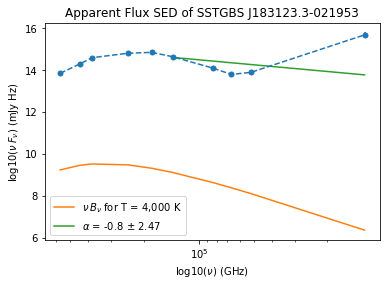

The GB index 2186
RA:  277.8470074845617
DEC:  -2.3313913542952314
The difference in RA is  0.059 arcseconds
The difference in Dec is  0.11 arcseconds
The Gould_Belt_ID is  SSTGBS J183123.3-021953
alpha is 0.56
The object type is star+dust(MP1)
2MASS ID: b'18312326-0219529'
FLUX SIGNAL TO NOISE
[ 3.01347625e+01  7.93006192e+02  2.23225245e+02  3.50237472e+01
  5.18769482e+01  4.16744533e+01  9.12500000e+00  6.65217391e+00
  9.12500000e+00 -1.32103321e-01  3.69306931e+00]
SED Flux
[ 1.21728107e-01  4.30612057e-01  1.01013327e+00  2.58040690e+00
  3.82208204e+00  3.07040381e+00  1.46000000e+00  9.18000000e-01
  1.46000000e+00 -3.58000000e-01  3.73000000e+02]
SED Flux Error
[4.03945800e-03 5.43012226e-04 4.52517485e-03 7.36759230e-02
 7.36759230e-02 7.36759230e-02 1.60000000e-01 1.38000000e-01
 1.60000000e-01 2.71000000e+00 1.01000000e+02]
The apparent magnitude in g is: 17.209818
The absolute magnitude in g is: 9.389824422454783
g-K is: 3.8678179
GB-GR is: 2.6224728
MIPS 1 IS MISSING
SED

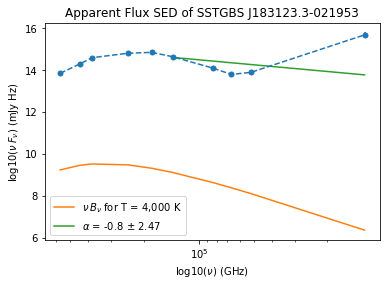

39
3715
The GB index 2219
RA:  277.85576950218535
DEC:  -2.0591104573735635
The difference in RA is  0.058 arcseconds
The difference in Dec is  0.086 arcseconds
The Gould_Belt_ID is  SSTGBS J183125.4-020333
alpha is -0.59
The object type is star+dust(IR1)
2MASS ID: b'18312538-0203326'
FLUX SIGNAL TO NOISE
[  2.59199846  95.92801841  29.73611417  37.43918122 143.99194255
 248.44713248  19.7         18.31804281  19.7          5.63636364
   1.        ]
SED Flux
[ 6.14471920e-03  4.46404293e-02  1.69484735e-01  5.25881672e+00
  2.02255287e+01  3.48976097e+01  5.91000000e+01  5.99000000e+01
  5.91000000e+01  6.20000000e+01 -9.99000000e+02]
SED Flux Error
[ 2.37064925e-03  4.65353398e-04  5.69962617e-03  1.40462920e-01
  1.40462920e-01  1.40462920e-01  3.00000000e+00  3.27000000e+00
  3.00000000e+00  1.10000000e+01 -9.99000000e+02]
The apparent magnitude in g is: 19.670713
The absolute magnitude in g is: 11.623267369353329
g-K is: 8.967713
GB-GR is: 3.9265747
MIPS 1 IS MISSING
SED_nu_log
[12

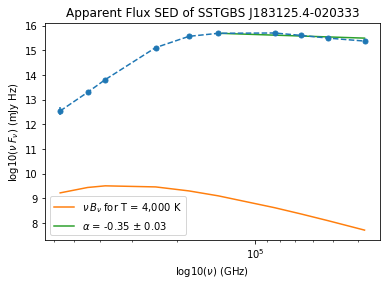

The GB index 2219
RA:  277.85576950218535
DEC:  -2.0591104573735635
The difference in RA is  0.058 arcseconds
The difference in Dec is  0.086 arcseconds
The Gould_Belt_ID is  SSTGBS J183125.4-020333
alpha is -0.59
The object type is star+dust(IR1)
2MASS ID: b'18312538-0203326'
FLUX SIGNAL TO NOISE
[  2.59199846  95.92801841  29.73611417  37.43918122 143.99194255
 248.44713248  19.7         18.31804281  19.7          5.63636364
   1.        ]
SED Flux
[ 6.14471920e-03  4.46404293e-02  1.69484735e-01  5.25881672e+00
  2.02255287e+01  3.48976097e+01  5.91000000e+01  5.99000000e+01
  5.91000000e+01  6.20000000e+01 -9.99000000e+02]
SED Flux Error
[ 2.37064925e-03  4.65353398e-04  5.69962617e-03  1.40462920e-01
  1.40462920e-01  1.40462920e-01  3.00000000e+00  3.27000000e+00
  3.00000000e+00  1.10000000e+01 -9.99000000e+02]
The apparent magnitude in g is: 19.670713
The absolute magnitude in g is: 11.623267369353329
g-K is: 8.967713
GB-GR is: 3.9265747
MIPS 1 IS MISSING
SED_nu_log
[12.5426970

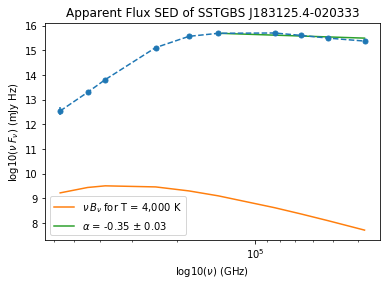

40
4052
The GB index 2226
RA:  277.85651897766274
DEC:  -4.371850877723383
The difference in RA is  0.307 arcseconds
The difference in Dec is  0.245 arcseconds
The Gould_Belt_ID is  SSTGBS J183125.5-042218
alpha is -1.8
The object type is star+dust(MP1)
2MASS ID: b'18312556-0422185'
FLUX SIGNAL TO NOISE
[198.91949674 867.71281807 301.03409634  40.21245017  41.47362235
  33.34782813   1.           1.           1.           1.
   9.82323232]
SED Flux
[   5.65555954   10.76597977   18.84726715   32.42563248   33.44258881
   26.89028931 -999.         -999.         -999.         -999.
    3.89      ]
SED Flux Error
[ 2.84313988e-02  1.24073075e-02  6.26084134e-02  8.06358039e-01
  8.06358039e-01  8.06358039e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.96000000e-01]
The apparent magnitude in g is: 13.7149
The absolute magnitude in g is: 5.829009982544166
g-K is: 2.7289
GB-GR is: 1.6319361
MIPS 1 IS MISSING
SED_nu_log
[15.50667058 15.68005331 15.855339   15.8960422 

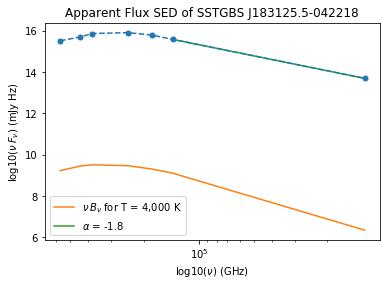

The GB index 2226
RA:  277.85651897766274
DEC:  -4.371850877723383
The difference in RA is  0.307 arcseconds
The difference in Dec is  0.245 arcseconds
The Gould_Belt_ID is  SSTGBS J183125.5-042218
alpha is -1.8
The object type is star+dust(MP1)
2MASS ID: b'18312556-0422185'
FLUX SIGNAL TO NOISE
[198.91949674 867.71281807 301.03409634  40.21245017  41.47362235
  33.34782813   1.           1.           1.           1.
   9.82323232]
SED Flux
[   5.65555954   10.76597977   18.84726715   32.42563248   33.44258881
   26.89028931 -999.         -999.         -999.         -999.
    3.89      ]
SED Flux Error
[ 2.84313988e-02  1.24073075e-02  6.26084134e-02  8.06358039e-01
  8.06358039e-01  8.06358039e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.96000000e-01]
The apparent magnitude in g is: 13.7149
The absolute magnitude in g is: 5.829009982544166
g-K is: 2.7289
GB-GR is: 1.6319361
MIPS 1 IS MISSING
SED_nu_log
[15.50667058 15.68005331 15.855339   15.8960422  15.7804

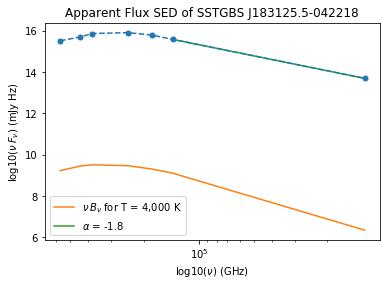

41
28230
The GB index 2254
RA:  277.86458941416277
DEC:  -3.64675060226728
The difference in RA is  0.02 arcseconds
The difference in Dec is  0.211 arcseconds
The Gould_Belt_ID is  SSTGBS J183127.5-033848
alpha is -1.3
The object type is star+dust(IR2)
2MASS ID: b'18312750-0338481'
FLUX SIGNAL TO NOISE
[  4.65996245  13.5121427    4.38663084  41.75908582 156.08553869
 280.19357844  13.30275229  19.22626026  13.30275229  20.64676617
  10.66460587]
SED Flux
[1.97612252e-02 1.04508772e-01 5.22080004e-01 2.72450958e+02
 1.01835693e+03 1.82808142e+03 1.45000000e+03 1.64000000e+03
 1.45000000e+03 1.66000000e+03 6.90000000e+02]
SED Flux Error
[4.24064044e-03 7.73443375e-03 1.19016171e-01 6.52435160e+00
 6.52435160e+00 6.52435160e+00 1.09000000e+02 8.53000000e+01
 1.09000000e+02 8.04000000e+01 6.47000000e+01]
The apparent magnitude in g is: 18.747152
The absolute magnitude in g is: 10.678052591040975
g-K is: 12.342152
GB-GR is: 3.8798103
SED_nu_log
[13.05000887 13.66715249 14.29782767 16.82044

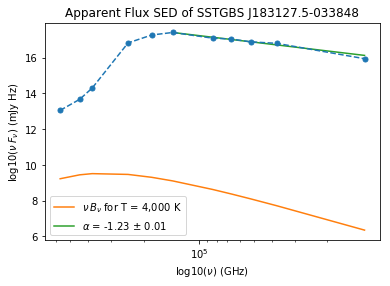

The GB index 2254
RA:  277.86458941416277
DEC:  -3.64675060226728
The difference in RA is  0.02 arcseconds
The difference in Dec is  0.211 arcseconds
The Gould_Belt_ID is  SSTGBS J183127.5-033848
alpha is -1.3
The object type is star+dust(IR2)
2MASS ID: b'18312750-0338481'
FLUX SIGNAL TO NOISE
[  4.65996245  13.5121427    4.38663084  41.75908582 156.08553869
 280.19357844  13.30275229  19.22626026  13.30275229  20.64676617
  10.66460587]
SED Flux
[1.97612252e-02 1.04508772e-01 5.22080004e-01 2.72450958e+02
 1.01835693e+03 1.82808142e+03 1.45000000e+03 1.64000000e+03
 1.45000000e+03 1.66000000e+03 6.90000000e+02]
SED Flux Error
[4.24064044e-03 7.73443375e-03 1.19016171e-01 6.52435160e+00
 6.52435160e+00 6.52435160e+00 1.09000000e+02 8.53000000e+01
 1.09000000e+02 8.04000000e+01 6.47000000e+01]
The apparent magnitude in g is: 18.747152
The absolute magnitude in g is: 10.678052591040975
g-K is: 12.342152
GB-GR is: 3.8798103
SED_nu_log
[13.05000887 13.66715249 14.29782767 16.82044209 17.26

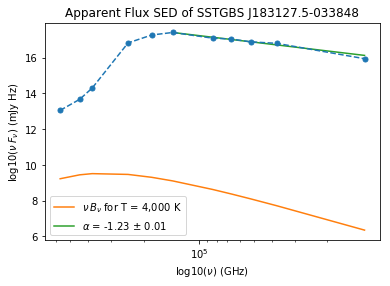

42
28115
The GB index 2304
RA:  277.8825297953799
DEC:  -4.015997612184812
The difference in RA is  0.311 arcseconds
The difference in Dec is  0.158 arcseconds
The Gould_Belt_ID is  SSTGBS J183131.8-040057
alpha is -2.42
The object type is star+dust(MP1)
2MASS ID: b'18313180-0400574'
FLUX SIGNAL TO NOISE
[6.44083764e+02 3.51239405e+03 9.40159822e+02 4.17590816e+01
 3.31560166e+01 2.41578321e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.57983193e+00]
SED Flux
[  56.56385422   87.83478546  132.13946533  179.34466553  142.39668274
  103.75176239 -999.         -999.         -999.         -999.
    3.42      ]
SED Flux Error
[ 8.78206491e-02  2.50070989e-02  1.40550002e-01  4.29474640e+00
  4.29474640e+00  4.29474640e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.57000000e-01]
The apparent magnitude in g is: 11.435867
The absolute magnitude in g is: 3.544890439519465
g-K is: 1.9158669
GB-GR is: 1.2462368
MIPS 1 IS MISSING
SED_nu_log
[16.506734  

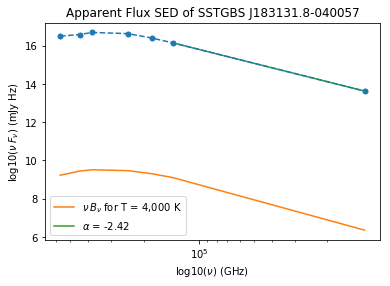

The GB index 2304
RA:  277.8825297953799
DEC:  -4.015997612184812
The difference in RA is  0.311 arcseconds
The difference in Dec is  0.158 arcseconds
The Gould_Belt_ID is  SSTGBS J183131.8-040057
alpha is -2.42
The object type is star+dust(MP1)
2MASS ID: b'18313180-0400574'
FLUX SIGNAL TO NOISE
[6.44083764e+02 3.51239405e+03 9.40159822e+02 4.17590816e+01
 3.31560166e+01 2.41578321e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.57983193e+00]
SED Flux
[  56.56385422   87.83478546  132.13946533  179.34466553  142.39668274
  103.75176239 -999.         -999.         -999.         -999.
    3.42      ]
SED Flux Error
[ 8.78206491e-02  2.50070989e-02  1.40550002e-01  4.29474640e+00
  4.29474640e+00  4.29474640e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.57000000e-01]
The apparent magnitude in g is: 11.435867
The absolute magnitude in g is: 3.544890439519465
g-K is: 1.9158669
GB-GR is: 1.2462368
MIPS 1 IS MISSING
SED_nu_log
[16.506734   16.59166

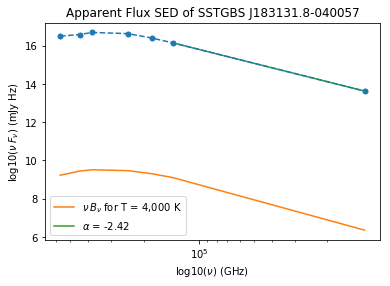

43
28080
The GB index 2330
RA:  277.89627575416006
DEC:  -3.8495648700158207
The difference in RA is  0.0 arcseconds
The difference in Dec is  0.096 arcseconds
The Gould_Belt_ID is  SSTGBS J183135.1-035058
alpha is -2.03
The object type is star+dust(MP1)
2MASS ID: b'18313510-0350583'
FLUX SIGNAL TO NOISE
[4.82873260e+02 1.77895180e+03 8.16506929e+02 4.52390092e+01
 4.23179521e+01 3.26753763e+01 2.04026846e+01 1.00000000e+00
 2.04026846e+01 1.00000000e+00 1.03142329e+01]
SED Flux
[  10.81302738   23.01641846   43.31958008   89.38983154   83.61798096
   64.56477356   30.4        -999.           30.4        -999.
    5.58      ]
SED Flux Error
[ 2.23930962e-02  1.29381912e-02  5.30547611e-02  1.97594583e+00
  1.97594583e+00  1.97594583e+00  1.49000000e+00 -9.99000000e+02
  1.49000000e+00 -9.99000000e+02  5.41000000e-01]
The apparent magnitude in g is: 12.889939
The absolute magnitude in g is: 5.0385773785522225
g-K is: 2.8549395
GB-GR is: 1.8318462
MIPS 1 IS MISSING
SED_nu_log
[15.7881423

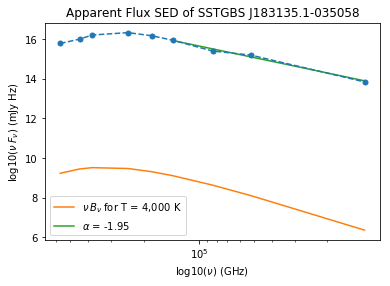

The GB index 2330
RA:  277.89627575416006
DEC:  -3.8495648700158207
The difference in RA is  0.0 arcseconds
The difference in Dec is  0.096 arcseconds
The Gould_Belt_ID is  SSTGBS J183135.1-035058
alpha is -2.03
The object type is star+dust(MP1)
2MASS ID: b'18313510-0350583'
FLUX SIGNAL TO NOISE
[4.82873260e+02 1.77895180e+03 8.16506929e+02 4.52390092e+01
 4.23179521e+01 3.26753763e+01 2.04026846e+01 1.00000000e+00
 2.04026846e+01 1.00000000e+00 1.03142329e+01]
SED Flux
[  10.81302738   23.01641846   43.31958008   89.38983154   83.61798096
   64.56477356   30.4        -999.           30.4        -999.
    5.58      ]
SED Flux Error
[ 2.23930962e-02  1.29381912e-02  5.30547611e-02  1.97594583e+00
  1.97594583e+00  1.97594583e+00  1.49000000e+00 -9.99000000e+02
  1.49000000e+00 -9.99000000e+02  5.41000000e-01]
The apparent magnitude in g is: 12.889939
The absolute magnitude in g is: 5.0385773785522225
g-K is: 2.8549395
GB-GR is: 1.8318462
MIPS 1 IS MISSING
SED_nu_log
[15.78814231 16.0100

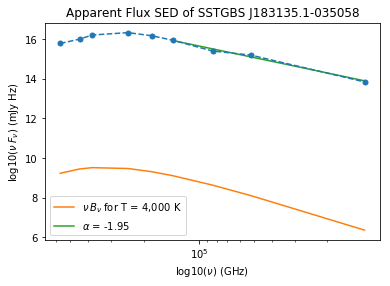

44
28112
The GB index 2572
RA:  278.0076277412323
DEC:  -3.900869306285377
The difference in RA is  0.391 arcseconds
The difference in Dec is  0.06 arcseconds
The Gould_Belt_ID is  SSTGBS J183201.8-035403
alpha is -1.04
The object type is star+dust(MP1)
2MASS ID: b'18320182-0354030'
FLUX SIGNAL TO NOISE
[ 25.49083414 169.4217854   67.57173516  38.77629287  67.66715715
  76.01052791   1.           1.           1.           1.
  10.68181818]
SED Flux
[ 1.36950493e-01  6.36585057e-01  1.66736066e+00  7.93027210e+00
  1.38388414e+01  1.55451727e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.41000000e+01]
SED Flux Error
[ 5.37253870e-03  3.75739788e-03  2.46754158e-02  2.04513416e-01
  2.04513416e-01  2.04513416e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.32000000e+00]
The apparent magnitude in g is: 16.785393
The absolute magnitude in g is: 8.419566734462304
g-K is: 5.2043924
GB-GR is: 3.0386686
MIPS 1 IS MISSING
SED_nu_log
[13.89075861 

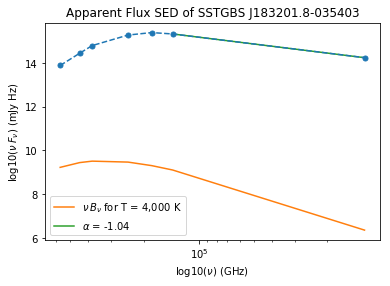

The GB index 2572
RA:  278.0076277412323
DEC:  -3.900869306285377
The difference in RA is  0.391 arcseconds
The difference in Dec is  0.06 arcseconds
The Gould_Belt_ID is  SSTGBS J183201.8-035403
alpha is -1.04
The object type is star+dust(MP1)
2MASS ID: b'18320182-0354030'
FLUX SIGNAL TO NOISE
[ 25.49083414 169.4217854   67.57173516  38.77629287  67.66715715
  76.01052791   1.           1.           1.           1.
  10.68181818]
SED Flux
[ 1.36950493e-01  6.36585057e-01  1.66736066e+00  7.93027210e+00
  1.38388414e+01  1.55451727e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.41000000e+01]
SED Flux Error
[ 5.37253870e-03  3.75739788e-03  2.46754158e-02  2.04513416e-01
  2.04513416e-01  2.04513416e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.32000000e+00]
The apparent magnitude in g is: 16.785393
The absolute magnitude in g is: 8.419566734462304
g-K is: 5.2043924
GB-GR is: 3.0386686
MIPS 1 IS MISSING
SED_nu_log
[13.89075861 14.451856

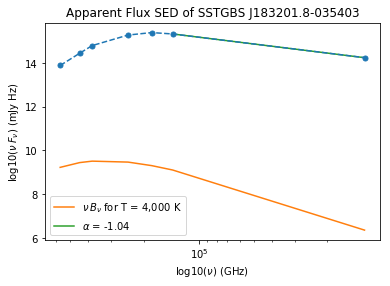

45
3905
The GB index 2751
RA:  278.13398953005776
DEC:  -2.158207244933876
The difference in RA is  0.052 arcseconds
The difference in Dec is  0.089 arcseconds
The Gould_Belt_ID is  SSTGBS J183232.2-020929
alpha is -1.9
The object type is Galc_star+dust(MP1)
2MASS ID: b'18323214-0209294'
FLUX SIGNAL TO NOISE
[ 47.0902245  195.00675569 155.60795383  37.43917884  48.03278427
  40.85390292  20.38834951  19.56856703  20.38834951   6.37254902
   3.64356436]
SED Flux
[0.10851812 0.39550486 1.01533365 3.34879375 4.29635191 3.65422797
 1.89       1.27       1.89       0.65       1.84      ]
SED Flux Error
[0.00230447 0.00202816 0.00652495 0.08944624 0.08944624 0.08944624
 0.0927     0.0649     0.0927     0.102      0.505     ]
The apparent magnitude in g is: 17.302155
The absolute magnitude in g is: 9.509422874732813
g-K is: 4.1491547
GB-GR is: 2.7527695
SED_nu_log
[13.78969725 14.24515157 14.58669939 14.91004215 14.88928953 14.7053637
 14.2021669  13.92693638 13.99447882 13.39060493 13.364271

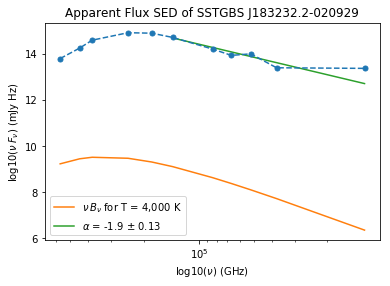

The GB index 2751
RA:  278.13398953005776
DEC:  -2.158207244933876
The difference in RA is  0.052 arcseconds
The difference in Dec is  0.089 arcseconds
The Gould_Belt_ID is  SSTGBS J183232.2-020929
alpha is -1.9
The object type is Galc_star+dust(MP1)
2MASS ID: b'18323214-0209294'
FLUX SIGNAL TO NOISE
[ 47.0902245  195.00675569 155.60795383  37.43917884  48.03278427
  40.85390292  20.38834951  19.56856703  20.38834951   6.37254902
   3.64356436]
SED Flux
[0.10851812 0.39550486 1.01533365 3.34879375 4.29635191 3.65422797
 1.89       1.27       1.89       0.65       1.84      ]
SED Flux Error
[0.00230447 0.00202816 0.00652495 0.08944624 0.08944624 0.08944624
 0.0927     0.0649     0.0927     0.102      0.505     ]
The apparent magnitude in g is: 17.302155
The absolute magnitude in g is: 9.509422874732813
g-K is: 4.1491547
GB-GR is: 2.7527695
SED_nu_log
[13.78969725 14.24515157 14.58669939 14.91004215 14.88928953 14.7053637
 14.2021669  13.92693638 13.99447882 13.39060493 13.36427198]
SED_

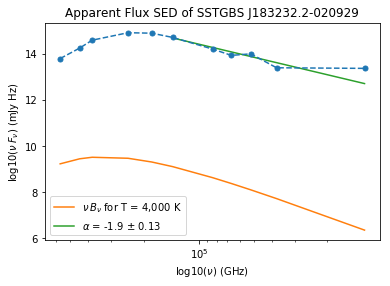

46
3642
The GB index 2752
RA:  278.1340259731196
DEC:  -2.2169644958291386
The difference in RA is  0.105 arcseconds
The difference in Dec is  0.014 arcseconds
The Gould_Belt_ID is  SSTGBS J183232.2-021301
alpha is -2.05
The object type is Galc_star+dust(MP1)
2MASS ID: b'18323214-0213011'
FLUX SIGNAL TO NOISE
[ 46.41021168 610.59698975 448.97722956  32.90109637  44.44491962
  38.36344324  19.68253968  19.7301855   19.68253968   7.16
   3.33333333]
SED Flux
[0.20231239 0.57977116 1.24340868 3.2998054  4.45758963 3.84764981
 1.86       1.17       1.86       0.716      1.36      ]
SED Flux Error
[0.00435922 0.00094952 0.00276942 0.10029469 0.10029469 0.10029469
 0.0945     0.0593     0.0945     0.1        0.408     ]
The apparent magnitude in g is: 16.886892
The absolute magnitude in g is: 8.818699590530347
g-K is: 3.7898922
GB-GR is: 2.296482
SED_nu_log
[14.0602175  14.41125636 14.67470451 14.90364207 14.90528977 14.7277636
 14.19521804 13.89131852 13.98752996 13.4326046  13.23299307]
SE

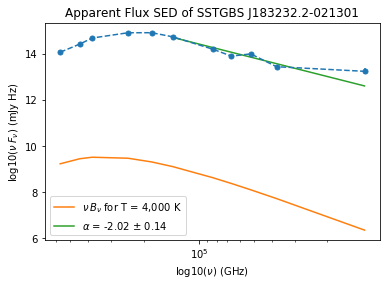

The GB index 2752
RA:  278.1340259731196
DEC:  -2.2169644958291386
The difference in RA is  0.105 arcseconds
The difference in Dec is  0.014 arcseconds
The Gould_Belt_ID is  SSTGBS J183232.2-021301
alpha is -2.05
The object type is Galc_star+dust(MP1)
2MASS ID: b'18323214-0213011'
FLUX SIGNAL TO NOISE
[ 46.41021168 610.59698975 448.97722956  32.90109637  44.44491962
  38.36344324  19.68253968  19.7301855   19.68253968   7.16
   3.33333333]
SED Flux
[0.20231239 0.57977116 1.24340868 3.2998054  4.45758963 3.84764981
 1.86       1.17       1.86       0.716      1.36      ]
SED Flux Error
[0.00435922 0.00094952 0.00276942 0.10029469 0.10029469 0.10029469
 0.0945     0.0593     0.0945     0.1        0.408     ]
The apparent magnitude in g is: 16.886892
The absolute magnitude in g is: 8.818699590530347
g-K is: 3.7898922
GB-GR is: 2.296482
SED_nu_log
[14.0602175  14.41125636 14.67470451 14.90364207 14.90528977 14.7277636
 14.19521804 13.89131852 13.98752996 13.4326046  13.23299307]
SED_nu_err

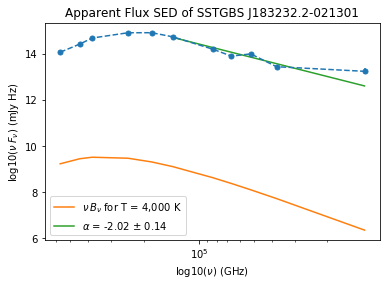

47
42116
The GB index 2859
RA:  278.1968226650767
DEC:  -4.866850358523684
The difference in RA is  0.095 arcseconds
The difference in Dec is  0.115 arcseconds
The Gould_Belt_ID is  SSTGBS J183247.2-045201
alpha is -1.95
The object type is star+dust(MP1)
2MASS ID: b'18324723-0452005'
FLUX SIGNAL TO NOISE
[3.00175731e+02 2.28994437e+03 5.71091993e+02 4.17590833e+01
 4.44387973e+01 3.36556765e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 6.40625000e+00]
SED Flux
[   4.76694489    9.27378654   16.69093323   29.7638073    31.67377472
   23.98810005 -999.         -999.         -999.         -999.
    2.46      ]
SED Flux Error
[ 1.58805139e-02  4.04978683e-03  2.92263478e-02  7.12750494e-01
  7.12750494e-01  7.12750494e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.84000000e-01]
The apparent magnitude in g is: 13.876891
The absolute magnitude in g is: 5.666067735224324
g-K is: 2.7668915
GB-GR is: 1.685606
MIPS 1 IS MISSING
SED_nu_log
[15.43243514 

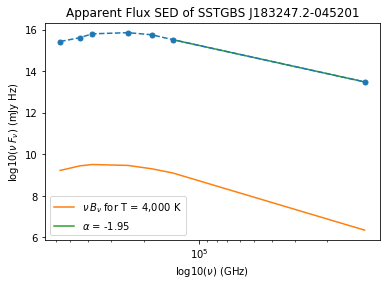

The GB index 2859
RA:  278.1968226650767
DEC:  -4.866850358523684
The difference in RA is  0.095 arcseconds
The difference in Dec is  0.115 arcseconds
The Gould_Belt_ID is  SSTGBS J183247.2-045201
alpha is -1.95
The object type is star+dust(MP1)
2MASS ID: b'18324723-0452005'
FLUX SIGNAL TO NOISE
[3.00175731e+02 2.28994437e+03 5.71091993e+02 4.17590833e+01
 4.44387973e+01 3.36556765e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 6.40625000e+00]
SED Flux
[   4.76694489    9.27378654   16.69093323   29.7638073    31.67377472
   23.98810005 -999.         -999.         -999.         -999.
    2.46      ]
SED Flux Error
[ 1.58805139e-02  4.04978683e-03  2.92263478e-02  7.12750494e-01
  7.12750494e-01  7.12750494e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.84000000e-01]
The apparent magnitude in g is: 13.876891
The absolute magnitude in g is: 5.666067735224324
g-K is: 2.7668915
GB-GR is: 1.685606
MIPS 1 IS MISSING
SED_nu_log
[15.43243514 15.615256

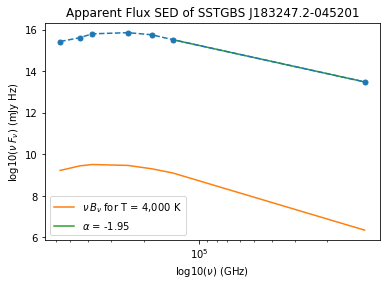

48
49613
The GB index 2902
RA:  278.234657500942
DEC:  -0.5183239819912588
The difference in RA is  0.266 arcseconds
The difference in Dec is  0.148 arcseconds
The Gould_Belt_ID is  SSTGBS J183256.3+000-3106
alpha is -1.2
The object type is star+dust(IR4)
2MASS ID: b'18325633-0031059'
FLUX SIGNAL TO NOISE
[8.63359782e+01 1.24012161e+03 3.10136297e+02 1.39196952e+01
 1.92062078e+01 1.52453433e+01 1.46428571e+01 8.38888889e+00
 1.46428571e+01 7.79104478e+00 1.00000000e+00]
SED Flux
[ 4.01397854e-01  1.01184762e+00  2.05727053e+00  5.17712116e+00
  7.14332199e+00  5.67016649e+00  3.69000000e+00  1.51000000e+00
  3.69000000e+00  5.22000000e+00 -9.99000000e+02]
SED Flux Error
[ 4.64925356e-03  8.15926120e-04  6.63344003e-03  3.71927768e-01
  3.71927768e-01  3.71927768e-01  2.52000000e-01  1.80000000e-01
  2.52000000e-01  6.70000000e-01 -9.99000000e+02]
The apparent magnitude in g is: 16.282246
The absolute magnitude in g is: 8.172002893302832
g-K is: 3.606246
GB-GR is: 2.0992956
MIPS 1 IS M

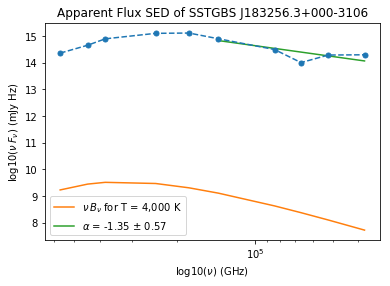

The GB index 2902
RA:  278.234657500942
DEC:  -0.5183239819912588
The difference in RA is  0.266 arcseconds
The difference in Dec is  0.148 arcseconds
The Gould_Belt_ID is  SSTGBS J183256.3+000-3106
alpha is -1.2
The object type is star+dust(IR4)
2MASS ID: b'18325633-0031059'
FLUX SIGNAL TO NOISE
[8.63359782e+01 1.24012161e+03 3.10136297e+02 1.39196952e+01
 1.92062078e+01 1.52453433e+01 1.46428571e+01 8.38888889e+00
 1.46428571e+01 7.79104478e+00 1.00000000e+00]
SED Flux
[ 4.01397854e-01  1.01184762e+00  2.05727053e+00  5.17712116e+00
  7.14332199e+00  5.67016649e+00  3.69000000e+00  1.51000000e+00
  3.69000000e+00  5.22000000e+00 -9.99000000e+02]
SED Flux Error
[ 4.64925356e-03  8.15926120e-04  6.63344003e-03  3.71927768e-01
  3.71927768e-01  3.71927768e-01  2.52000000e-01  1.80000000e-01
  2.52000000e-01  6.70000000e-01 -9.99000000e+02]
The apparent magnitude in g is: 16.282246
The absolute magnitude in g is: 8.172002893302832
g-K is: 3.606246
GB-GR is: 2.0992956
MIPS 1 IS MISSING
SE

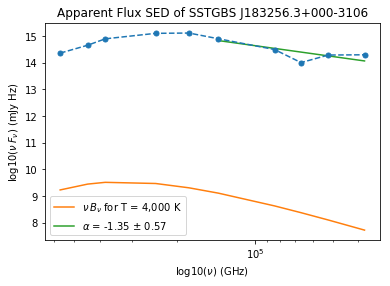

49
48753
The GB index 3084
RA:  278.51607153390756
DEC:  -1.060809117858748
The difference in RA is  0.398 arcseconds
The difference in Dec is  0.07 arcseconds
The Gould_Belt_ID is  SSTGBS J183403.8-010339
alpha is -0.93
The object type is star+dust(MP1)
2MASS ID: b'18340385-0103388'
FLUX SIGNAL TO NOISE
[  1.37234787 132.25101263  16.2072537   20.87954275  56.43287561
  67.98738181   1.           1.           1.           1.
  10.30685921]
SED Flux
[ 7.38243526e-03  2.95433383e-02  9.26414430e-02  1.49447429e+00
  4.03923988e+00  4.86626530e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.71000000e+00]
SED Flux Error
[ 5.37941977e-03  2.23388372e-04  5.71604818e-03  7.15760067e-02
  7.15760067e-02  7.15760067e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.54000000e-01]
The apparent magnitude in g is: 20.118885
The absolute magnitude in g is: 11.992262922492777
g-K is: 7.276885
GB-GR is: 3.071518
MIPS 1 IS MISSING
SED_nu_log
[12.62239465 

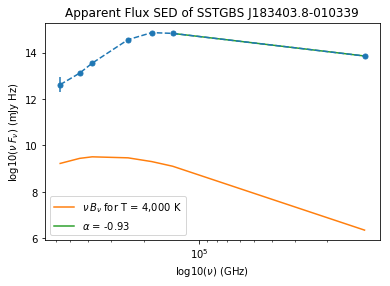

The GB index 3084
RA:  278.51607153390756
DEC:  -1.060809117858748
The difference in RA is  0.398 arcseconds
The difference in Dec is  0.07 arcseconds
The Gould_Belt_ID is  SSTGBS J183403.8-010339
alpha is -0.93
The object type is star+dust(MP1)
2MASS ID: b'18340385-0103388'
FLUX SIGNAL TO NOISE
[  1.37234787 132.25101263  16.2072537   20.87954275  56.43287561
  67.98738181   1.           1.           1.           1.
  10.30685921]
SED Flux
[ 7.38243526e-03  2.95433383e-02  9.26414430e-02  1.49447429e+00
  4.03923988e+00  4.86626530e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.71000000e+00]
SED Flux Error
[ 5.37941977e-03  2.23388372e-04  5.71604818e-03  7.15760067e-02
  7.15760067e-02  7.15760067e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.54000000e-01]
The apparent magnitude in g is: 20.118885
The absolute magnitude in g is: 11.992262922492777
g-K is: 7.276885
GB-GR is: 3.071518
MIPS 1 IS MISSING
SED_nu_log
[12.62239465 13.118459

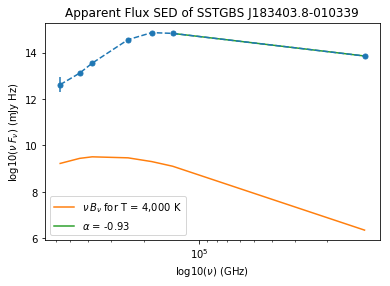

50
49286
The GB index 3119
RA:  278.7758028605848
DEC:  -0.6596334871103713
The difference in RA is  0.141 arcseconds
The difference in Dec is  0.436 arcseconds
The Gould_Belt_ID is  SSTGBS J183506.2+000-3935
alpha is -0.94
The object type is star+dust(MP1)
2MASS ID: b'18350619-0039344'
FLUX SIGNAL TO NOISE
[20.56292432 79.60538827 29.30667059 45.23900534 72.06507239 79.69304839
  1.          1.          1.          1.         10.76271186]
SED Flux
[   1.92488837    6.0505271    13.82675266   61.6720047    98.24259949
  108.64142609 -999.         -999.         -999.         -999.
  127.        ]
SED Flux Error
[ 9.36096609e-02  7.60065019e-02  4.71795410e-01  1.36324847e+00
  1.36324847e+00  1.36324847e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.18000000e+01]
The apparent magnitude in g is: 14.340551
The absolute magnitude in g is: 6.01961371370718
g-K is: 4.870551
GB-GR is: 2.4657907
MIPS 1 IS MISSING
SED_nu_log
[15.03860055 15.42979296 15.72081081 16.17524

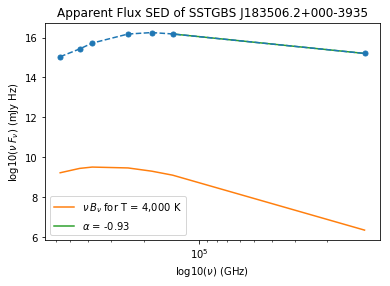

The GB index 3119
RA:  278.7758028605848
DEC:  -0.6596334871103713
The difference in RA is  0.141 arcseconds
The difference in Dec is  0.436 arcseconds
The Gould_Belt_ID is  SSTGBS J183506.2+000-3935
alpha is -0.94
The object type is star+dust(MP1)
2MASS ID: b'18350619-0039344'
FLUX SIGNAL TO NOISE
[20.56292432 79.60538827 29.30667059 45.23900534 72.06507239 79.69304839
  1.          1.          1.          1.         10.76271186]
SED Flux
[   1.92488837    6.0505271    13.82675266   61.6720047    98.24259949
  108.64142609 -999.         -999.         -999.         -999.
  127.        ]
SED Flux Error
[ 9.36096609e-02  7.60065019e-02  4.71795410e-01  1.36324847e+00
  1.36324847e+00  1.36324847e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.18000000e+01]
The apparent magnitude in g is: 14.340551
The absolute magnitude in g is: 6.01961371370718
g-K is: 4.870551
GB-GR is: 2.4657907
MIPS 1 IS MISSING
SED_nu_log
[15.03860055 15.42979296 15.72081081 16.17524181 16.24

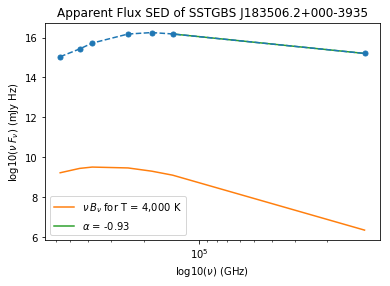

51
49179
The GB index 3127
RA:  278.8426787695807
DEC:  -0.44302996157754904
The difference in RA is  1.183 arcseconds
The difference in Dec is  0.837 arcseconds
The Gould_Belt_ID is  SSTGBS J183522.3+000-2636
alpha is -1.77
The object type is star+dust(MP1)
2MASS ID: b'18352224-0026347'
FLUX SIGNAL TO NOISE
[5.09966415e+02 3.50183301e+03 6.52849756e+02 4.17590846e+01
 4.09036911e+01 3.38733786e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.08467742e+01]
SED Flux
[  24.4201088    52.38826752   98.50366974  210.32373047  206.01545715
  170.6065979  -999.         -999.         -999.         -999.
   26.9       ]
SED Flux Error
[ 4.78857197e-02  1.49602415e-02  1.50882602e-01  5.03659821e+00
  5.03659821e+00  5.03659821e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.48000000e+00]
The apparent magnitude in g is: 11.996949
The absolute magnitude in g is: 3.6709375341061
g-K is: 3.0169497
GB-GR is: 1.8392658
MIPS 1 IS MISSING
SED_nu_log
[16.141942

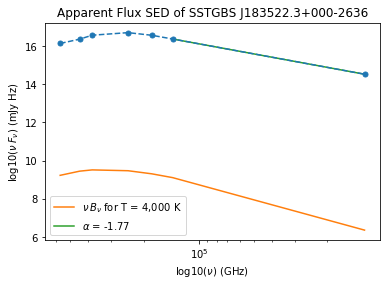

The GB index 3127
RA:  278.8426787695807
DEC:  -0.44302996157754904
The difference in RA is  1.183 arcseconds
The difference in Dec is  0.837 arcseconds
The Gould_Belt_ID is  SSTGBS J183522.3+000-2636
alpha is -1.77
The object type is star+dust(MP1)
2MASS ID: b'18352224-0026347'
FLUX SIGNAL TO NOISE
[5.09966415e+02 3.50183301e+03 6.52849756e+02 4.17590846e+01
 4.09036911e+01 3.38733786e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.08467742e+01]
SED Flux
[  24.4201088    52.38826752   98.50366974  210.32373047  206.01545715
  170.6065979  -999.         -999.         -999.         -999.
   26.9       ]
SED Flux Error
[ 4.78857197e-02  1.49602415e-02  1.50882602e-01  5.03659821e+00
  5.03659821e+00  5.03659821e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.48000000e+00]
The apparent magnitude in g is: 11.996949
The absolute magnitude in g is: 3.6709375341061
g-K is: 3.0169497
GB-GR is: 1.8392658
MIPS 1 IS MISSING
SED_nu_log
[16.1419426  16.367

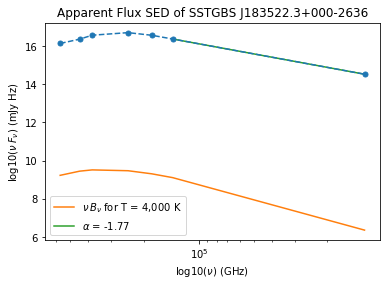

52
49220
The GB index 3129
RA:  278.8511555365188
DEC:  -0.6016645469695971
The difference in RA is  0.208 arcseconds
The difference in Dec is  0.024 arcseconds
The Gould_Belt_ID is  SSTGBS J183524.3+000-3606
alpha is -1.13
The object type is star+dust(MP1)
2MASS ID: b'18352427-0036057'
FLUX SIGNAL TO NOISE
[ 10.40180677 148.09356924  53.2002703   40.21245103  75.19213782
  81.10875548   1.           1.           1.           1.
  10.74468085]
SED Flux
[ 1.44552914e-02  1.51285991e-01  4.60527986e-01  4.13131475e+00
  7.72502995e+00  8.33288670e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  6.06000000e+00]
SED Flux Error
[ 1.38969044e-03  1.02155679e-03  8.65649711e-03  1.02737203e-01
  1.02737203e-01  1.02737203e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.64000000e-01]
The apparent magnitude in g is: 18.345537
The absolute magnitude in g is: 9.79935501863453
g-K is: 6.087537
GB-GR is: 4.0830765
MIPS 1 IS MISSING
SED_nu_log
[12.9142218

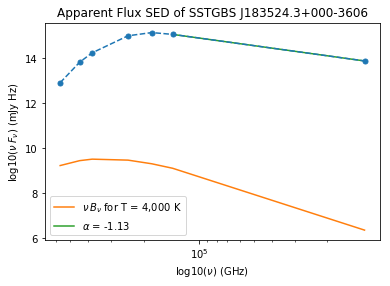

The GB index 3129
RA:  278.8511555365188
DEC:  -0.6016645469695971
The difference in RA is  0.208 arcseconds
The difference in Dec is  0.024 arcseconds
The Gould_Belt_ID is  SSTGBS J183524.3+000-3606
alpha is -1.13
The object type is star+dust(MP1)
2MASS ID: b'18352427-0036057'
FLUX SIGNAL TO NOISE
[ 10.40180677 148.09356924  53.2002703   40.21245103  75.19213782
  81.10875548   1.           1.           1.           1.
  10.74468085]
SED Flux
[ 1.44552914e-02  1.51285991e-01  4.60527986e-01  4.13131475e+00
  7.72502995e+00  8.33288670e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  6.06000000e+00]
SED Flux Error
[ 1.38969044e-03  1.02155679e-03  8.65649711e-03  1.02737203e-01
  1.02737203e-01  1.02737203e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.64000000e-01]
The apparent magnitude in g is: 18.345537
The absolute magnitude in g is: 9.79935501863453
g-K is: 6.087537
GB-GR is: 4.0830765
MIPS 1 IS MISSING
SED_nu_log
[12.91422186 13.8277

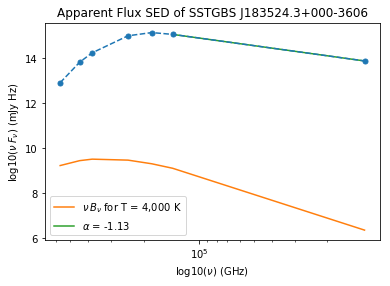

53
49437
The GB index 3133
RA:  278.87489854779886
DEC:  -0.7155786967456734
The difference in RA is  0.485 arcseconds
The difference in Dec is  0.381 arcseconds
The Gould_Belt_ID is  SSTGBS J183529.9+000-4256
alpha is -1.32
The object type is star+dust(MP1)
2MASS ID: b'18352997-0042557'
FLUX SIGNAL TO NOISE
[ 75.02517477 260.04201533 106.9405564   41.75908418  55.17754162
  49.78036781   1.           1.           1.           1.
  10.8440367 ]
SED Flux
[   8.93880558   20.34867477   41.1548233   106.97657013  141.35137939
  127.52513885 -999.         -999.         -999.         -999.
   59.1       ]
SED Flux Error
[ 1.19144082e-01  7.82514885e-02  3.84838313e-01  2.56175566e+00
  2.56175566e+00  2.56175566e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.45000000e+00]
The apparent magnitude in g is: 13.023694
The absolute magnitude in g is: 4.4605493061127355
g-K is: 3.7276945
GB-GR is: 1.9828568
MIPS 1 IS MISSING
SED_nu_log
[15.7054745  15.95653588 16.19451135 

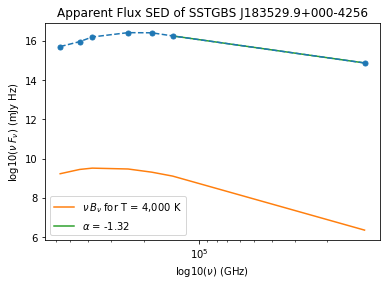

The GB index 3133
RA:  278.87489854779886
DEC:  -0.7155786967456734
The difference in RA is  0.485 arcseconds
The difference in Dec is  0.381 arcseconds
The Gould_Belt_ID is  SSTGBS J183529.9+000-4256
alpha is -1.32
The object type is star+dust(MP1)
2MASS ID: b'18352997-0042557'
FLUX SIGNAL TO NOISE
[ 75.02517477 260.04201533 106.9405564   41.75908418  55.17754162
  49.78036781   1.           1.           1.           1.
  10.8440367 ]
SED Flux
[   8.93880558   20.34867477   41.1548233   106.97657013  141.35137939
  127.52513885 -999.         -999.         -999.         -999.
   59.1       ]
SED Flux Error
[ 1.19144082e-01  7.82514885e-02  3.84838313e-01  2.56175566e+00
  2.56175566e+00  2.56175566e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.45000000e+00]
The apparent magnitude in g is: 13.023694
The absolute magnitude in g is: 4.4605493061127355
g-K is: 3.7276945
GB-GR is: 1.9828568
MIPS 1 IS MISSING
SED_nu_log
[15.7054745  15.95653588 16.19451135 16.414442

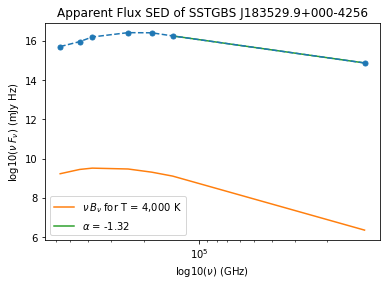

54
54893
The GB index 3136
RA:  278.8849686882642
DEC:  0.18237800723529082
The difference in RA is  0.199 arcseconds
The difference in Dec is  0.151 arcseconds
The Gould_Belt_ID is  SSTGBS J183532.4+001057
alpha is -2.18
The object type is star+dust(MP1)
2MASS ID: b'18353238+0010567'
FLUX SIGNAL TO NOISE
[3.34370214e+02 3.68173087e+03 6.22268522e+02 4.93516464e+01
 4.56997070e+01 3.35126706e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 5.24752475e+00]
SED Flux
[   8.27563286   15.43505287   27.1532917    53.66461945   49.69352722
   36.44143295 -999.         -999.         -999.         -999.
    2.12      ]
SED Flux Error
[ 2.47499105e-02  4.19233600e-03  4.36359718e-02  1.08739269e+00
  1.08739269e+00  1.08739269e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.04000000e-01]
The apparent magnitude in g is: 13.323764
The absolute magnitude in g is: 4.8354971838292276
g-K is: 2.6677637
GB-GR is: 1.615058
MIPS 1 IS MISSING
SED_nu_log
[15.6719962

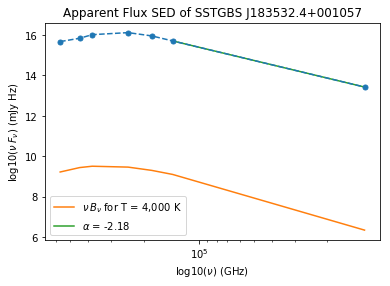

The GB index 3136
RA:  278.8849686882642
DEC:  0.18237800723529082
The difference in RA is  0.199 arcseconds
The difference in Dec is  0.151 arcseconds
The Gould_Belt_ID is  SSTGBS J183532.4+001057
alpha is -2.18
The object type is star+dust(MP1)
2MASS ID: b'18353238+0010567'
FLUX SIGNAL TO NOISE
[3.34370214e+02 3.68173087e+03 6.22268522e+02 4.93516464e+01
 4.56997070e+01 3.35126706e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 5.24752475e+00]
SED Flux
[   8.27563286   15.43505287   27.1532917    53.66461945   49.69352722
   36.44143295 -999.         -999.         -999.         -999.
    2.12      ]
SED Flux Error
[ 2.47499105e-02  4.19233600e-03  4.36359718e-02  1.08739269e+00
  1.08739269e+00  1.08739269e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.04000000e-01]
The apparent magnitude in g is: 13.323764
The absolute magnitude in g is: 4.8354971838292276
g-K is: 2.6677637
GB-GR is: 1.615058
MIPS 1 IS MISSING
SED_nu_log
[15.67199622 15.8365

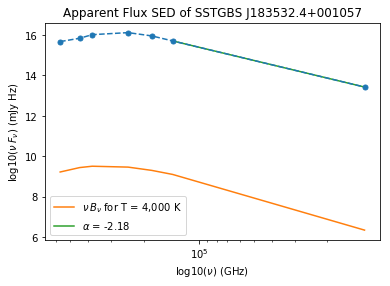

55
33320
The GB index 3170
RA:  278.9618097265066
DEC:  0.46418311297809745
The difference in RA is  1.248 arcseconds
The difference in Dec is  0.325 arcseconds
The Gould_Belt_ID is  SSTGBS J183550.8+002751
alpha is -0.86
The object type is star+dust(MP1)
2MASS ID: b'18355082+0027510'
FLUX SIGNAL TO NOISE
[ 14.8339343  462.44226545  81.67592171  29.34422381  45.13716078
  47.66827633   1.           1.           1.           1.
  10.48044693]
SED Flux
[ 2.35058051e-02  2.14334443e-01  6.37236476e-01  4.11991787e+00
  6.33724022e+00  6.69260788e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  9.38000000e+00]
SED Flux Error
[ 1.58459682e-03  4.63483681e-04  7.80201145e-03  1.40399620e-01
  1.40399620e-01  1.40399620e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  8.95000000e-01]
The apparent magnitude in g is: 17.967304
The absolute magnitude in g is: 9.288966048252144
g-K is: 5.471304
GB-GR is: 3.9078178
MIPS 1 IS MISSING
SED_nu_log
[13.12537014

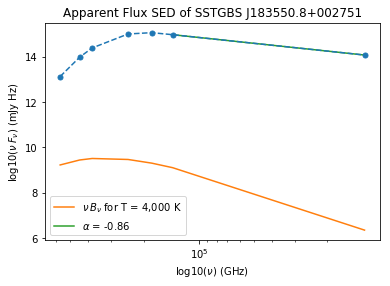

The GB index 3170
RA:  278.9618097265066
DEC:  0.46418311297809745
The difference in RA is  1.248 arcseconds
The difference in Dec is  0.325 arcseconds
The Gould_Belt_ID is  SSTGBS J183550.8+002751
alpha is -0.86
The object type is star+dust(MP1)
2MASS ID: b'18355082+0027510'
FLUX SIGNAL TO NOISE
[ 14.8339343  462.44226545  81.67592171  29.34422381  45.13716078
  47.66827633   1.           1.           1.           1.
  10.48044693]
SED Flux
[ 2.35058051e-02  2.14334443e-01  6.37236476e-01  4.11991787e+00
  6.33724022e+00  6.69260788e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  9.38000000e+00]
SED Flux Error
[ 1.58459682e-03  4.63483681e-04  7.80201145e-03  1.40399620e-01
  1.40399620e-01  1.40399620e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  8.95000000e-01]
The apparent magnitude in g is: 17.967304
The absolute magnitude in g is: 9.288966048252144
g-K is: 5.471304
GB-GR is: 3.9078178
MIPS 1 IS MISSING
SED_nu_log
[13.12537014 13.97909

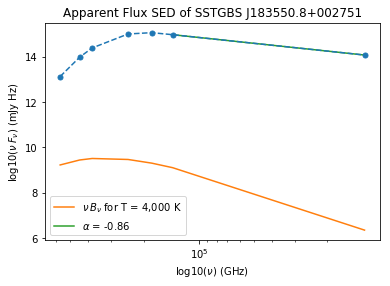

56
54737
The GB index 3175
RA:  278.9723528917186
DEC:  -0.35988244065879404
The difference in RA is  0.134 arcseconds
The difference in Dec is  0.087 arcseconds
The Gould_Belt_ID is  SSTGBS J183553.4+000-2135
alpha is -2.28
The object type is star+dust(MP1)
2MASS ID: b'18355336-0021355'
FLUX SIGNAL TO NOISE
[3.94969574e+02 2.43465815e+03 5.48850771e+02 4.52390068e+01
 5.59918437e+01 4.66251225e+01 1.00000000e+00 2.04907975e+01
 1.00000000e+00 2.05787781e+01 1.03358209e+01]
SED Flux
[   2.2177875     6.68544817   14.94186974   50.12892532   62.04404449
   51.6648674  -999.           16.7        -999.            6.4
    2.77      ]
SED Flux Error
[ 5.61508443e-03  2.74594943e-03  2.72239204e-02  1.10809076e+00
  1.10809076e+00  1.10809076e+00 -9.99000000e+02  8.15000000e-01
 -9.99000000e+02  3.11000000e-01  2.68000000e-01]
The apparent magnitude in g is: 14.232207
The absolute magnitude in g is: 5.717750854732811
g-K is: 3.9552069
GB-GR is: 2.3962164
MIPS 1 IS MISSING
SED_nu_log
[15.100

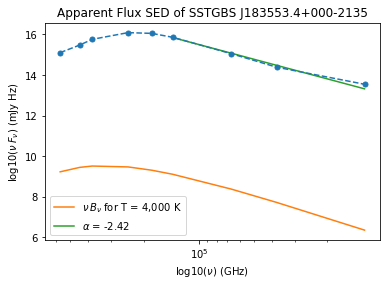

The GB index 3175
RA:  278.9723528917186
DEC:  -0.35988244065879404
The difference in RA is  0.134 arcseconds
The difference in Dec is  0.087 arcseconds
The Gould_Belt_ID is  SSTGBS J183553.4+000-2135
alpha is -2.28
The object type is star+dust(MP1)
2MASS ID: b'18355336-0021355'
FLUX SIGNAL TO NOISE
[3.94969574e+02 2.43465815e+03 5.48850771e+02 4.52390068e+01
 5.59918437e+01 4.66251225e+01 1.00000000e+00 2.04907975e+01
 1.00000000e+00 2.05787781e+01 1.03358209e+01]
SED Flux
[   2.2177875     6.68544817   14.94186974   50.12892532   62.04404449
   51.6648674  -999.           16.7        -999.            6.4
    2.77      ]
SED Flux Error
[ 5.61508443e-03  2.74594943e-03  2.72239204e-02  1.10809076e+00
  1.10809076e+00  1.10809076e+00 -9.99000000e+02  8.15000000e-01
 -9.99000000e+02  3.11000000e-01  2.68000000e-01]
The apparent magnitude in g is: 14.232207
The absolute magnitude in g is: 5.717750854732811
g-K is: 3.9552069
GB-GR is: 2.3962164
MIPS 1 IS MISSING
SED_nu_log
[15.10011494 15.

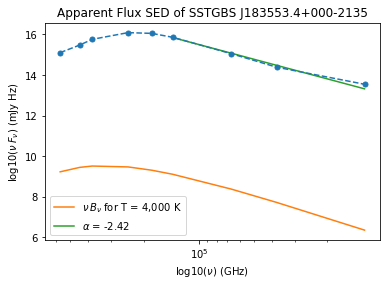

57
33287
The GB index 3213
RA:  279.02433323690326
DEC:  0.5171925520033311
The difference in RA is  0.276 arcseconds
The difference in Dec is  0.191 arcseconds
The Gould_Belt_ID is  SSTGBS J183605.8+003102
alpha is -2.16
The object type is star+dust(MP1)
2MASS ID: b'18360582+0031020'
FLUX SIGNAL TO NOISE
[7.01576135e+02 3.19895539e+03 8.95259978e+02 4.17590839e+01
 3.45591243e+01 2.78136436e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 8.26865672e+00]
SED Flux
[  13.83487701   23.88709831   39.43105316   68.43659973   56.63699341
   45.58220673 -999.         -999.         -999.         -999.
    2.77      ]
SED Flux Error
[ 1.97197087e-02  7.46715581e-03  4.40442488e-02  1.63884342e+00
  1.63884342e+00  1.63884342e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.35000000e-01]
The apparent magnitude in g is: 12.849626
The absolute magnitude in g is: 4.362778413003237
g-K is: 2.4366255
GB-GR is: 1.462162
MIPS 1 IS MISSING
SED_nu_log
[15.89517031

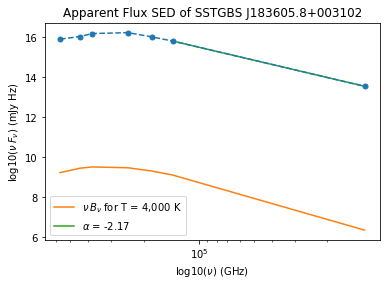

The GB index 3213
RA:  279.02433323690326
DEC:  0.5171925520033311
The difference in RA is  0.276 arcseconds
The difference in Dec is  0.191 arcseconds
The Gould_Belt_ID is  SSTGBS J183605.8+003102
alpha is -2.16
The object type is star+dust(MP1)
2MASS ID: b'18360582+0031020'
FLUX SIGNAL TO NOISE
[7.01576135e+02 3.19895539e+03 8.95259978e+02 4.17590839e+01
 3.45591243e+01 2.78136436e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 8.26865672e+00]
SED Flux
[  13.83487701   23.88709831   39.43105316   68.43659973   56.63699341
   45.58220673 -999.         -999.         -999.         -999.
    2.77      ]
SED Flux Error
[ 1.97197087e-02  7.46715581e-03  4.40442488e-02  1.63884342e+00
  1.63884342e+00  1.63884342e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.35000000e-01]
The apparent magnitude in g is: 12.849626
The absolute magnitude in g is: 4.362778413003237
g-K is: 2.4366255
GB-GR is: 1.462162
MIPS 1 IS MISSING
SED_nu_log
[15.89517031 16.02616

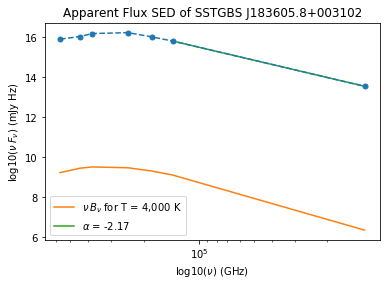

58
46997
The GB index 3267
RA:  279.1683670405813
DEC:  -0.6459599169799984
The difference in RA is  0.025 arcseconds
The difference in Dec is  0.071 arcseconds
The Gould_Belt_ID is  SSTGBS J183640.4+000-3845
alpha is -2.13
The object type is star+dust(MP1)
2MASS ID: b'18364041-0038453'
FLUX SIGNAL TO NOISE
[ 66.84153135 258.79287096  80.22962907  47.20592162  60.11853068
  50.10760593   1.           1.           1.           1.
   6.55339806]
SED Flux
[   1.21398044    3.14475489    6.69170189   19.2525425    24.5188427
   20.43597031 -999.         -999.         -999.         -999.
    1.35      ]
SED Flux Error
[ 1.81620680e-02  1.21516287e-02  8.34068656e-02  4.07841682e-01
  4.07841682e-01  4.07841682e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.06000000e-01]
The apparent magnitude in g is: 15.051067
The absolute magnitude in g is: 6.622198660837368
g-K is: 3.767067
GB-GR is: 2.178316
MIPS 1 IS MISSING
SED_nu_log
[14.83840669 15.14558655 15.4056272  15.66

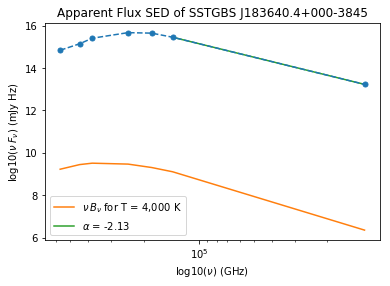

The GB index 3267
RA:  279.1683670405813
DEC:  -0.6459599169799984
The difference in RA is  0.025 arcseconds
The difference in Dec is  0.071 arcseconds
The Gould_Belt_ID is  SSTGBS J183640.4+000-3845
alpha is -2.13
The object type is star+dust(MP1)
2MASS ID: b'18364041-0038453'
FLUX SIGNAL TO NOISE
[ 66.84153135 258.79287096  80.22962907  47.20592162  60.11853068
  50.10760593   1.           1.           1.           1.
   6.55339806]
SED Flux
[   1.21398044    3.14475489    6.69170189   19.2525425    24.5188427
   20.43597031 -999.         -999.         -999.         -999.
    1.35      ]
SED Flux Error
[ 1.81620680e-02  1.21516287e-02  8.34068656e-02  4.07841682e-01
  4.07841682e-01  4.07841682e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.06000000e-01]
The apparent magnitude in g is: 15.051067
The absolute magnitude in g is: 6.622198660837368
g-K is: 3.767067
GB-GR is: 2.178316
MIPS 1 IS MISSING
SED_nu_log
[14.83840669 15.14558655 15.4056272  15.66964184 15

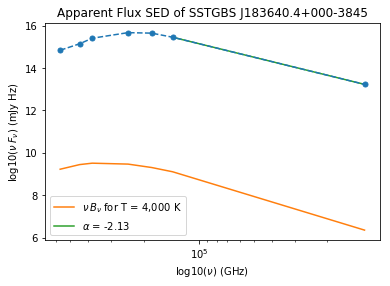

59
56004
The GB index 3271
RA:  279.17280086761184
DEC:  0.3949561609420856
The difference in RA is  0.245 arcseconds
The difference in Dec is  0.138 arcseconds
The Gould_Belt_ID is  SSTGBS J183641.5+002342
alpha is -1.44
The object type is star+dust(MP1)
2MASS ID: b'18364146+0023420'
FLUX SIGNAL TO NOISE
[ 72.82698681 240.85446307 130.78979948  43.42944632  75.71734646
  72.65931213  20.84765178   1.          20.84765178   1.
  10.59322034]
SED Flux
[ 1.09034911e-01  6.97882831e-01  2.37771344e+00  1.68767433e+01
  2.94238663e+01  2.82355099e+01  1.82000000e+01 -9.99000000e+02
  1.82000000e+01 -9.99000000e+02  1.00000000e+01]
SED Flux Error
[ 1.49717729e-03  2.89752916e-03  1.81796551e-02  3.88601393e-01
  3.88601393e-01  3.88601393e-01  8.73000000e-01 -9.99000000e+02
  8.73000000e-01 -9.99000000e+02  9.44000000e-01]
The apparent magnitude in g is: 16.685577
The absolute magnitude in g is: 8.124109440540652
g-K is: 5.752578
GB-GR is: 3.6714888
MIPS 1 IS MISSING
SED_nu_log
[13.79176058

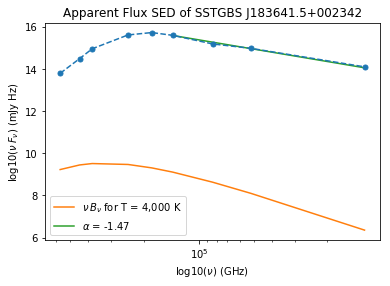

The GB index 3271
RA:  279.17280086761184
DEC:  0.3949561609420856
The difference in RA is  0.245 arcseconds
The difference in Dec is  0.138 arcseconds
The Gould_Belt_ID is  SSTGBS J183641.5+002342
alpha is -1.44
The object type is star+dust(MP1)
2MASS ID: b'18364146+0023420'
FLUX SIGNAL TO NOISE
[ 72.82698681 240.85446307 130.78979948  43.42944632  75.71734646
  72.65931213  20.84765178   1.          20.84765178   1.
  10.59322034]
SED Flux
[ 1.09034911e-01  6.97882831e-01  2.37771344e+00  1.68767433e+01
  2.94238663e+01  2.82355099e+01  1.82000000e+01 -9.99000000e+02
  1.82000000e+01 -9.99000000e+02  1.00000000e+01]
SED Flux Error
[ 1.49717729e-03  2.89752916e-03  1.81796551e-02  3.88601393e-01
  3.88601393e-01  3.88601393e-01  8.73000000e-01 -9.99000000e+02
  8.73000000e-01 -9.99000000e+02  9.44000000e-01]
The apparent magnitude in g is: 16.685577
The absolute magnitude in g is: 8.124109440540652
g-K is: 5.752578
GB-GR is: 3.6714888
MIPS 1 IS MISSING
SED_nu_log
[13.79176058 14.49178

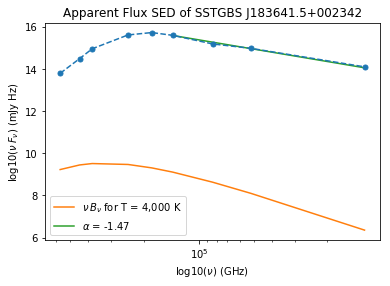

60
56239
The GB index 3287
RA:  279.2031943568173
DEC:  0.4631252451829466
The difference in RA is  0.008 arcseconds
The difference in Dec is  0.021 arcseconds
The Gould_Belt_ID is  SSTGBS J183648.8+002747
alpha is -0.94
The object type is star+dust(IR3)
2MASS ID: b'18364876+0027473'
FLUX SIGNAL TO NOISE
[  5.35667177 130.43142925  46.75395002  27.14340605  48.87377408
  50.39317412  20.19379845   1.          20.19379845   1.
  10.54347826]
SED Flux
[ 1.89297441e-02  1.61139160e-01  4.99441624e-01  4.02242804e+00
  7.24268866e+00  7.46785116e+00  5.21000000e+00 -9.99000000e+02
  5.21000000e+00 -9.99000000e+02  7.76000000e+00]
SED Flux Error
[ 3.53386300e-03  1.23543199e-03  1.06823407e-02  1.48191720e-01
  1.48191720e-01  1.48191720e-01  2.58000000e-01 -9.99000000e+02
  2.58000000e-01 -9.99000000e+02  7.36000000e-01]
The apparent magnitude in g is: 18.27703
The absolute magnitude in g is: 9.999645333576966
g-K is: 5.900031
GB-GR is: 3.878355
MIPS 1 IS MISSING
SED_nu_log
[13.03133975 13

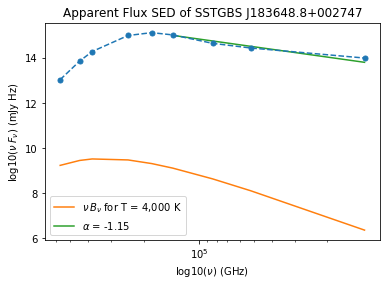

The GB index 3287
RA:  279.2031943568173
DEC:  0.4631252451829466
The difference in RA is  0.008 arcseconds
The difference in Dec is  0.021 arcseconds
The Gould_Belt_ID is  SSTGBS J183648.8+002747
alpha is -0.94
The object type is star+dust(IR3)
2MASS ID: b'18364876+0027473'
FLUX SIGNAL TO NOISE
[  5.35667177 130.43142925  46.75395002  27.14340605  48.87377408
  50.39317412  20.19379845   1.          20.19379845   1.
  10.54347826]
SED Flux
[ 1.89297441e-02  1.61139160e-01  4.99441624e-01  4.02242804e+00
  7.24268866e+00  7.46785116e+00  5.21000000e+00 -9.99000000e+02
  5.21000000e+00 -9.99000000e+02  7.76000000e+00]
SED Flux Error
[ 3.53386300e-03  1.23543199e-03  1.06823407e-02  1.48191720e-01
  1.48191720e-01  1.48191720e-01  2.58000000e-01 -9.99000000e+02
  2.58000000e-01 -9.99000000e+02  7.36000000e-01]
The apparent magnitude in g is: 18.27703
The absolute magnitude in g is: 9.999645333576966
g-K is: 5.900031
GB-GR is: 3.878355
MIPS 1 IS MISSING
SED_nu_log
[13.03133975 13.85520084

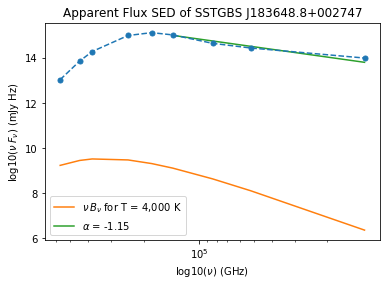

61
56774
The GB index 3304
RA:  279.2453851510593
DEC:  0.550014447891231
The difference in RA is  0.116 arcseconds
The difference in Dec is  0.089 arcseconds
The Gould_Belt_ID is  SSTGBS J183658.9+003300
alpha is -1.73
The object type is star+dust(MP1)
2MASS ID: b'18365888+0033001'
FLUX SIGNAL TO NOISE
[ 18.5657941  392.52136689 128.96779188  33.92925493  49.84096327
  44.59453129   1.           1.           1.           1.
   5.95121951]
SED Flux
[ 5.17030396e-02  3.74083936e-01  1.08884525e+00  5.41113281e+00
  7.94877672e+00  7.11206102e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.22000000e+00]
SED Flux Error
[ 2.78485473e-03  9.53028211e-04  8.44276883e-03  1.59482807e-01
  1.59482807e-01  1.59482807e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.05000000e-01]
The apparent magnitude in g is: 17.362612
The absolute magnitude in g is: 9.518885946809498
g-K is: 4.9326115
GB-GR is: 3.6336298
MIPS 1 IS MISSING
SED_nu_log
[13.46771108 

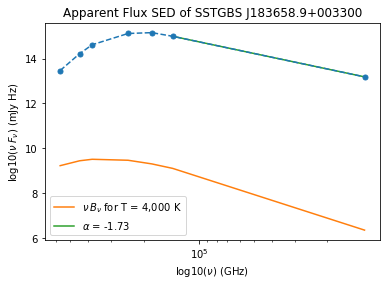

The GB index 3304
RA:  279.2453851510593
DEC:  0.550014447891231
The difference in RA is  0.116 arcseconds
The difference in Dec is  0.089 arcseconds
The Gould_Belt_ID is  SSTGBS J183658.9+003300
alpha is -1.73
The object type is star+dust(MP1)
2MASS ID: b'18365888+0033001'
FLUX SIGNAL TO NOISE
[ 18.5657941  392.52136689 128.96779188  33.92925493  49.84096327
  44.59453129   1.           1.           1.           1.
   5.95121951]
SED Flux
[ 5.17030396e-02  3.74083936e-01  1.08884525e+00  5.41113281e+00
  7.94877672e+00  7.11206102e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.22000000e+00]
SED Flux Error
[ 2.78485473e-03  9.53028211e-04  8.44276883e-03  1.59482807e-01
  1.59482807e-01  1.59482807e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.05000000e-01]
The apparent magnitude in g is: 17.362612
The absolute magnitude in g is: 9.518885946809498
g-K is: 4.9326115
GB-GR is: 3.6336298
MIPS 1 IS MISSING
SED_nu_log
[13.46771108 14.220968

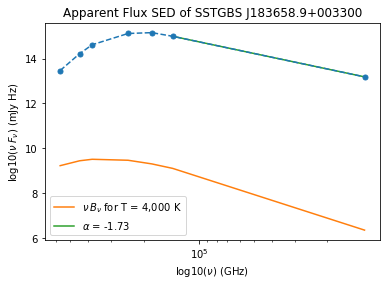

62
56146
The GB index 3310
RA:  279.26811936263465
DEC:  0.41087308460682864
The difference in RA is  0.003 arcseconds
The difference in Dec is  0.067 arcseconds
The Gould_Belt_ID is  SSTGBS J183704.3+002439
alpha is -2.4
The object type is star+dust(MP1)
2MASS ID: b'18370434+0024393'
FLUX SIGNAL TO NOISE
[2.56233135e+02 1.36683737e+03 4.80992849e+02 4.93516482e+01
 4.45362324e+01 3.46105890e+01 2.10156250e+01 1.00000000e+00
 2.10156250e+01 1.00000000e+00 7.41100324e+00]
SED Flux
[  14.00654984   25.76238251   44.4417572    82.88737488   74.79975891
   58.12938309   26.9        -999.           26.9        -999.
    2.29      ]
SED Flux Error
[ 5.46633042e-02  1.88481696e-02  9.23958793e-02  1.67952597e+00
  1.67952597e+00  1.67952597e+00  1.28000000e+00 -9.99000000e+02
  1.28000000e+00 -9.99000000e+02  3.09000000e-01]
The apparent magnitude in g is: 12.767569
The absolute magnitude in g is: 4.322754680045069
g-K is: 2.6185684
GB-GR is: 1.5786543
MIPS 1 IS MISSING
SED_nu_log
[15.9005261

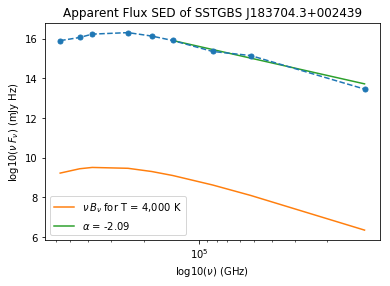

The GB index 3310
RA:  279.26811936263465
DEC:  0.41087308460682864
The difference in RA is  0.003 arcseconds
The difference in Dec is  0.067 arcseconds
The Gould_Belt_ID is  SSTGBS J183704.3+002439
alpha is -2.4
The object type is star+dust(MP1)
2MASS ID: b'18370434+0024393'
FLUX SIGNAL TO NOISE
[2.56233135e+02 1.36683737e+03 4.80992849e+02 4.93516482e+01
 4.45362324e+01 3.46105890e+01 2.10156250e+01 1.00000000e+00
 2.10156250e+01 1.00000000e+00 7.41100324e+00]
SED Flux
[  14.00654984   25.76238251   44.4417572    82.88737488   74.79975891
   58.12938309   26.9        -999.           26.9        -999.
    2.29      ]
SED Flux Error
[ 5.46633042e-02  1.88481696e-02  9.23958793e-02  1.67952597e+00
  1.67952597e+00  1.67952597e+00  1.28000000e+00 -9.99000000e+02
  1.28000000e+00 -9.99000000e+02  3.09000000e-01]
The apparent magnitude in g is: 12.767569
The absolute magnitude in g is: 4.322754680045069
g-K is: 2.6185684
GB-GR is: 1.5786543
MIPS 1 IS MISSING
SED_nu_log
[15.90052618 16.0589

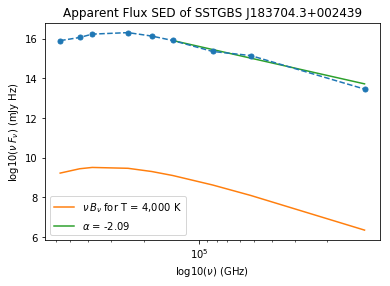

63
55890
The GB index 3330
RA:  279.34341050210094
DEC:  0.37811582470526517
The difference in RA is  0.009 arcseconds
The difference in Dec is  0.074 arcseconds
The Gould_Belt_ID is  SSTGBS J183722.4+002241
alpha is -1.94
The object type is Galc_star+dust(MP1)
2MASS ID: b'18372242+0022413'
FLUX SIGNAL TO NOISE
[  4.04164079 186.4933628   44.98009538  13.40415063  18.58022999
  19.95016618  18.6827957   18.48484848  18.6827957    3.62473348
   3.26818182]
SED Flux
[0.00843338 0.04304391 0.12274367 0.95959604 1.33014882 1.42822182
 0.695      0.488      0.695      0.17       0.719     ]
SED Flux Error
[0.00208662 0.00023081 0.00272884 0.07158947 0.07158947 0.07158947
 0.0372     0.0264     0.0372     0.0469     0.22      ]
The apparent magnitude in g is: 19.710255
The absolute magnitude in g is: 11.800495528799344
g-K is: 5.5372543
GB-GR is: 3.2324982
SED_nu_log
[12.68019688 13.28191144 13.6690897  14.36724219 14.38008992 14.29736372
 13.7676899  13.51155248 13.56000182 12.8081405  12.9

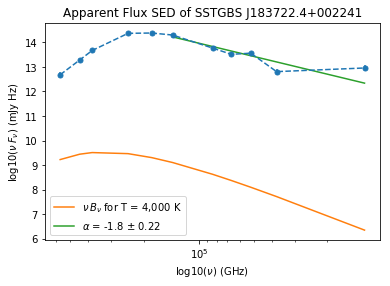

The GB index 3330
RA:  279.34341050210094
DEC:  0.37811582470526517
The difference in RA is  0.009 arcseconds
The difference in Dec is  0.074 arcseconds
The Gould_Belt_ID is  SSTGBS J183722.4+002241
alpha is -1.94
The object type is Galc_star+dust(MP1)
2MASS ID: b'18372242+0022413'
FLUX SIGNAL TO NOISE
[  4.04164079 186.4933628   44.98009538  13.40415063  18.58022999
  19.95016618  18.6827957   18.48484848  18.6827957    3.62473348
   3.26818182]
SED Flux
[0.00843338 0.04304391 0.12274367 0.95959604 1.33014882 1.42822182
 0.695      0.488      0.695      0.17       0.719     ]
SED Flux Error
[0.00208662 0.00023081 0.00272884 0.07158947 0.07158947 0.07158947
 0.0372     0.0264     0.0372     0.0469     0.22      ]
The apparent magnitude in g is: 19.710255
The absolute magnitude in g is: 11.800495528799344
g-K is: 5.5372543
GB-GR is: 3.2324982
SED_nu_log
[12.68019688 13.28191144 13.6690897  14.36724219 14.38008992 14.29736372
 13.7676899  13.51155248 13.56000182 12.8081405  12.95618305]


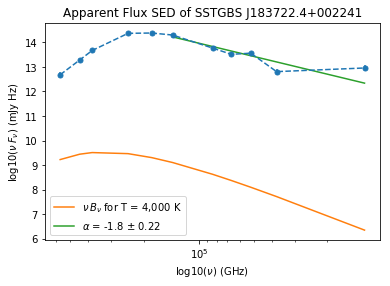

64
56584
The GB index 3344
RA:  279.3842261275462
DEC:  0.5504029154082146
The difference in RA is  0.317 arcseconds
The difference in Dec is  0.562 arcseconds
The Gould_Belt_ID is  SSTGBS J183732.2+003302
alpha is -0.57
The object type is star+dust(MP1)
2MASS ID: b'18373220+0033014'
FLUX SIGNAL TO NOISE
[11.03979003 81.38236246 26.97431774 33.92925433 55.97392007 56.03784053
  1.          1.          1.          1.         10.76023392]
SED Flux
[ 4.39014435e-02  2.79665977e-01  7.68894017e-01  3.98188305e+00
  6.56900978e+00  6.57651138e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.84000000e+01]
SED Flux Error
[ 3.97665566e-03  3.43644456e-03  2.85046697e-02  1.17358401e-01
  1.17358401e-01  1.17358401e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.71000000e+00]
The apparent magnitude in g is: 17.678434
The absolute magnitude in g is: 9.283166414604112
g-K is: 5.163434
GB-GR is: 3.4334736
MIPS 1 IS MISSING
SED_nu_log
[13.39667381 14.0

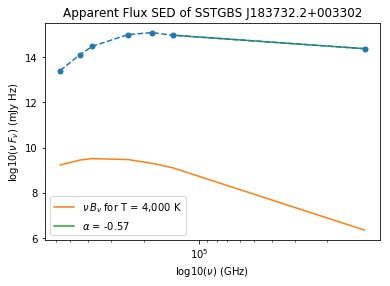

The GB index 3344
RA:  279.3842261275462
DEC:  0.5504029154082146
The difference in RA is  0.317 arcseconds
The difference in Dec is  0.562 arcseconds
The Gould_Belt_ID is  SSTGBS J183732.2+003302
alpha is -0.57
The object type is star+dust(MP1)
2MASS ID: b'18373220+0033014'
FLUX SIGNAL TO NOISE
[11.03979003 81.38236246 26.97431774 33.92925433 55.97392007 56.03784053
  1.          1.          1.          1.         10.76023392]
SED Flux
[ 4.39014435e-02  2.79665977e-01  7.68894017e-01  3.98188305e+00
  6.56900978e+00  6.57651138e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.84000000e+01]
SED Flux Error
[ 3.97665566e-03  3.43644456e-03  2.85046697e-02  1.17358401e-01
  1.17358401e-01  1.17358401e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.71000000e+00]
The apparent magnitude in g is: 17.678434
The absolute magnitude in g is: 9.283166414604112
g-K is: 5.163434
GB-GR is: 3.4334736
MIPS 1 IS MISSING
SED_nu_log
[13.39667381 14.09463938 1

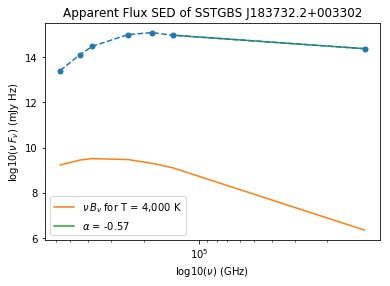

65
56666
The GB index 3346
RA:  279.387781857256
DEC:  0.4429629595360854
The difference in RA is  0.031 arcseconds
The difference in Dec is  0.087 arcseconds
The Gould_Belt_ID is  SSTGBS J183733.1+002635
alpha is -0.63
The object type is star+dust(IR1)
2MASS ID: b'18373306+0026347'
FLUX SIGNAL TO NOISE
[14.35775687 54.46239883 19.2002511  43.4294487  69.37392943 71.46478047
 20.63492063  1.         20.63492063  1.         10.73289902]
SED Flux
[ 6.13353014e-01  1.82702732e+00  4.15648842e+00  1.29326649e+01
  2.06585579e+01  2.12811832e+01  2.60000000e+01 -9.99000000e+02
  2.60000000e+01 -9.99000000e+02  6.59000000e+01]
SED Flux Error
[ 4.27192785e-02  3.35465819e-02  2.16480941e-01  2.97785610e-01
  2.97785610e-01  2.97785610e-01  1.26000000e+00 -9.99000000e+02
  1.26000000e+00 -9.99000000e+02  6.14000000e+00]
The apparent magnitude in g is: 15.640671
The absolute magnitude in g is: 7.336579653978417
g-K is: 4.400671
GB-GR is: 2.402544
MIPS 1 IS MISSING
SED_nu_log
[14.54190551 14.909

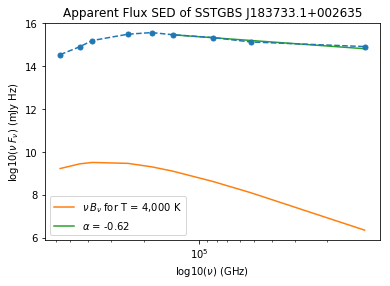

The GB index 3346
RA:  279.387781857256
DEC:  0.4429629595360854
The difference in RA is  0.031 arcseconds
The difference in Dec is  0.087 arcseconds
The Gould_Belt_ID is  SSTGBS J183733.1+002635
alpha is -0.63
The object type is star+dust(IR1)
2MASS ID: b'18373306+0026347'
FLUX SIGNAL TO NOISE
[14.35775687 54.46239883 19.2002511  43.4294487  69.37392943 71.46478047
 20.63492063  1.         20.63492063  1.         10.73289902]
SED Flux
[ 6.13353014e-01  1.82702732e+00  4.15648842e+00  1.29326649e+01
  2.06585579e+01  2.12811832e+01  2.60000000e+01 -9.99000000e+02
  2.60000000e+01 -9.99000000e+02  6.59000000e+01]
SED Flux Error
[ 4.27192785e-02  3.35465819e-02  2.16480941e-01  2.97785610e-01
  2.97785610e-01  2.97785610e-01  1.26000000e+00 -9.99000000e+02
  1.26000000e+00 -9.99000000e+02  6.14000000e+00]
The apparent magnitude in g is: 15.640671
The absolute magnitude in g is: 7.336579653978417
g-K is: 4.400671
GB-GR is: 2.402544
MIPS 1 IS MISSING
SED_nu_log
[14.54190551 14.90974479 15.

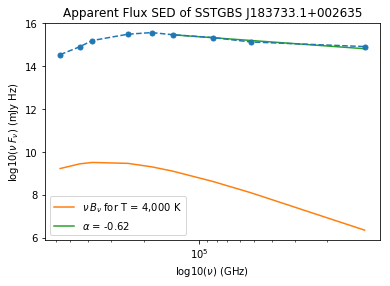

66
56656
The GB index 3366
RA:  279.42756104838594
DEC:  0.48047163835068896
The difference in RA is  0.065 arcseconds
The difference in Dec is  0.132 arcseconds
The Gould_Belt_ID is  SSTGBS J183742.6+002850
alpha is -2.35
The object type is star+dust(MP1)
2MASS ID: b'18374261+0028498'
FLUX SIGNAL TO NOISE
[6.80680132e+02 3.99162476e+03 1.13186239e+03 4.34294464e+01
 3.62072774e+01 2.76752687e+01 1.74022346e+01 1.00000000e+00
 1.74022346e+01 1.00000000e+00 9.67332123e+00]
SED Flux
[  75.50302124  107.48322296  152.62026978  211.68411255  176.48176575
  134.89498901   62.3        -999.           62.3        -999.
    5.33      ]
SED Flux Error
[ 1.10922910e-01  2.69271862e-02  1.34839952e-01  4.87420702e+00
  4.87420702e+00  4.87420702e+00  3.58000000e+00 -9.99000000e+02
  3.58000000e+00 -9.99000000e+02  5.51000000e-01]
The apparent magnitude in g is: 11.216682
The absolute magnitude in g is: 2.7021319917201083
g-K is: 1.9816828
GB-GR is: 1.0891237
MIPS 1 IS MISSING
SED_nu_log
[16.63215

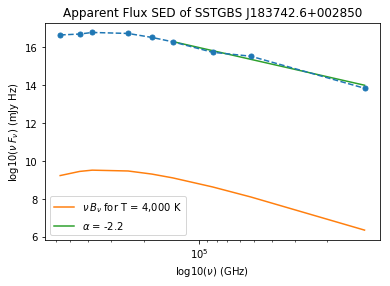

The GB index 3366
RA:  279.42756104838594
DEC:  0.48047163835068896
The difference in RA is  0.065 arcseconds
The difference in Dec is  0.132 arcseconds
The Gould_Belt_ID is  SSTGBS J183742.6+002850
alpha is -2.35
The object type is star+dust(MP1)
2MASS ID: b'18374261+0028498'
FLUX SIGNAL TO NOISE
[6.80680132e+02 3.99162476e+03 1.13186239e+03 4.34294464e+01
 3.62072774e+01 2.76752687e+01 1.74022346e+01 1.00000000e+00
 1.74022346e+01 1.00000000e+00 9.67332123e+00]
SED Flux
[  75.50302124  107.48322296  152.62026978  211.68411255  176.48176575
  134.89498901   62.3        -999.           62.3        -999.
    5.33      ]
SED Flux Error
[ 1.10922910e-01  2.69271862e-02  1.34839952e-01  4.87420702e+00
  4.87420702e+00  4.87420702e+00  3.58000000e+00 -9.99000000e+02
  3.58000000e+00 -9.99000000e+02  5.51000000e-01]
The apparent magnitude in g is: 11.216682
The absolute magnitude in g is: 2.7021319917201083
g-K is: 1.9816828
GB-GR is: 1.0891237
MIPS 1 IS MISSING
SED_nu_log
[16.63215934 16.67

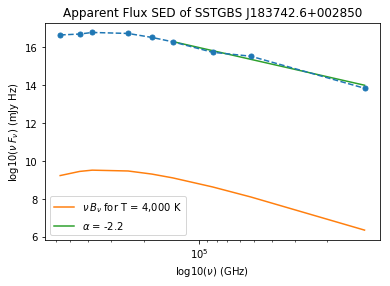

67
56710
The GB index 3369
RA:  279.43432347474663
DEC:  0.4025944507239772
The difference in RA is  0.006 arcseconds
The difference in Dec is  0.2 arcseconds
The Gould_Belt_ID is  SSTGBS J183744.2+002410
alpha is -1.81
The object type is star+dust(IR3)
2MASS ID: b'18374423+0024096'
FLUX SIGNAL TO NOISE
[ 26.499268   536.50384006  97.71436322  18.71958986  26.14015358
  19.13390563  18.94252874  18.08080808  18.94252874   1.81693989
  -0.62753036]
SED Flux
[ 0.05201815  0.19509241  0.46162701  1.25686419  1.7550931   1.28468204
  0.824       0.537       0.824       0.133      -0.155     ]
SED Flux Error
[0.001963   0.00036364 0.00472425 0.06714165 0.06714165 0.06714165
 0.0435     0.0297     0.0435     0.0732     0.247     ]
The apparent magnitude in g is: 18.069433
The absolute magnitude in g is: 9.48841862138092
g-K is: 3.781433
GB-GR is: 2.695345
MIPS 1 IS MISSING
SED_nu_log
[13.47034991 13.93824012 14.24438182 14.4844421  14.50048984 14.25136371
 13.84163231 13.55310694 13.63394423

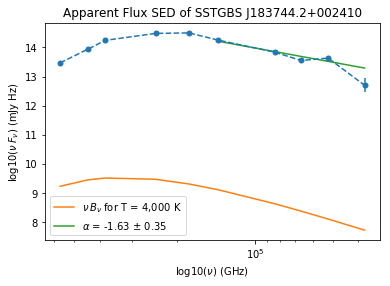

The GB index 3369
RA:  279.43432347474663
DEC:  0.4025944507239772
The difference in RA is  0.006 arcseconds
The difference in Dec is  0.2 arcseconds
The Gould_Belt_ID is  SSTGBS J183744.2+002410
alpha is -1.81
The object type is star+dust(IR3)
2MASS ID: b'18374423+0024096'
FLUX SIGNAL TO NOISE
[ 26.499268   536.50384006  97.71436322  18.71958986  26.14015358
  19.13390563  18.94252874  18.08080808  18.94252874   1.81693989
  -0.62753036]
SED Flux
[ 0.05201815  0.19509241  0.46162701  1.25686419  1.7550931   1.28468204
  0.824       0.537       0.824       0.133      -0.155     ]
SED Flux Error
[0.001963   0.00036364 0.00472425 0.06714165 0.06714165 0.06714165
 0.0435     0.0297     0.0435     0.0732     0.247     ]
The apparent magnitude in g is: 18.069433
The absolute magnitude in g is: 9.48841862138092
g-K is: 3.781433
GB-GR is: 2.695345
MIPS 1 IS MISSING
SED_nu_log
[13.47034991 13.93824012 14.24438182 14.4844421  14.50048984 14.25136371
 13.84163231 13.55310694 13.63394423 12.70154

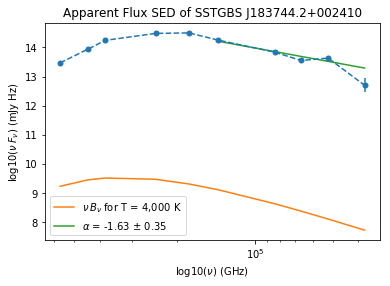

68
56479
The GB index 3372
RA:  279.44504484623263
DEC:  0.5925652805502504
The difference in RA is  0.016 arcseconds
The difference in Dec is  0.099 arcseconds
The Gould_Belt_ID is  SSTGBS J183746.8+003533
alpha is -1.35
The object type is star+dust(IR3)
2MASS ID: b'18374680+0035332'
FLUX SIGNAL TO NOISE
[  3.77017418 186.92905831  45.52534432  17.79895291  23.73593257
  24.02712317  18.07692308   1.          18.07692308   1.
   5.26119403]
SED Flux
[ 9.59759280e-02  1.05038621e-01  3.49522024e-01  2.08779669e+00
  2.78419757e+00  2.81835389e+00  1.88000000e+00 -9.99000000e+02
  1.88000000e+00 -9.99000000e+02  1.41000000e+00]
SED Flux Error
[ 2.54566297e-02  5.61917026e-04  7.67752621e-03  1.17298849e-01
  1.17298849e-01  1.17298849e-01  1.04000000e-01 -9.99000000e+02
  1.04000000e-01 -9.99000000e+02  2.68000000e-01]
The apparent magnitude in g is: 18.741661
The absolute magnitude in g is: 10.35699335610389
g-K is: 5.3066607
GB-GR is: 1.7282848
MIPS 1 IS MISSING
SED_nu_log
[13.7363573

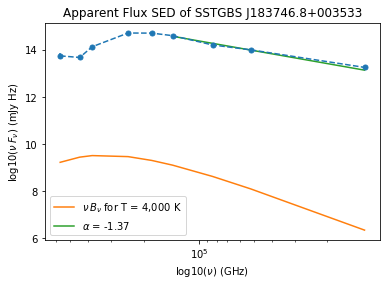

The GB index 3372
RA:  279.44504484623263
DEC:  0.5925652805502504
The difference in RA is  0.016 arcseconds
The difference in Dec is  0.099 arcseconds
The Gould_Belt_ID is  SSTGBS J183746.8+003533
alpha is -1.35
The object type is star+dust(IR3)
2MASS ID: b'18374680+0035332'
FLUX SIGNAL TO NOISE
[  3.77017418 186.92905831  45.52534432  17.79895291  23.73593257
  24.02712317  18.07692308   1.          18.07692308   1.
   5.26119403]
SED Flux
[ 9.59759280e-02  1.05038621e-01  3.49522024e-01  2.08779669e+00
  2.78419757e+00  2.81835389e+00  1.88000000e+00 -9.99000000e+02
  1.88000000e+00 -9.99000000e+02  1.41000000e+00]
SED Flux Error
[ 2.54566297e-02  5.61917026e-04  7.67752621e-03  1.17298849e-01
  1.17298849e-01  1.17298849e-01  1.04000000e-01 -9.99000000e+02
  1.04000000e-01 -9.99000000e+02  2.68000000e-01]
The apparent magnitude in g is: 18.741661
The absolute magnitude in g is: 10.35699335610389
g-K is: 5.3066607
GB-GR is: 1.7282848
MIPS 1 IS MISSING
SED_nu_log
[13.73635733 13.6693

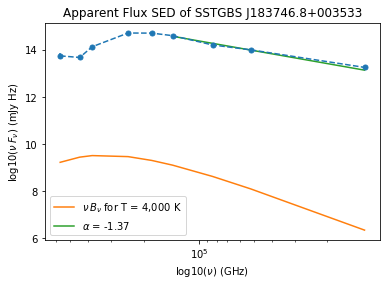

69
54649
The GB index 3375
RA:  279.45014662659435
DEC:  -0.2715059066943372
The difference in RA is  0.048 arcseconds
The difference in Dec is  0.268 arcseconds
The Gould_Belt_ID is  SSTGBS J183748.0+000-1617
alpha is -1.23
The object type is Galc_star+dust(IR4)
2MASS ID: b'18374802-0016170'
FLUX SIGNAL TO NOISE
[ 15.60390092 159.15255509  53.95527898  33.92925302  51.52119713
  43.2993527   20.32258065  20.33653846  20.32258065  19.94818653
  10.24911032]
SED Flux
[ 0.20499222  0.73209643  1.8083483   7.99629211 12.14228153 10.20459461
  5.67        4.23        5.67        3.85        5.76      ]
SED Flux Error
[0.01313724 0.00459997 0.03351569 0.23567545 0.23567545 0.23567545
 0.279      0.208      0.279      0.193      0.562     ]
The apparent magnitude in g is: 16.633614
The absolute magnitude in g is: 8.231395574350584
g-K is: 4.5956135
GB-GR is: 2.6888647
SED_nu_log
[14.06593238 14.51256804 14.8373727  15.2880424  15.34048998 15.15136382
 14.67928815 14.44947302 14.47160008 14.1

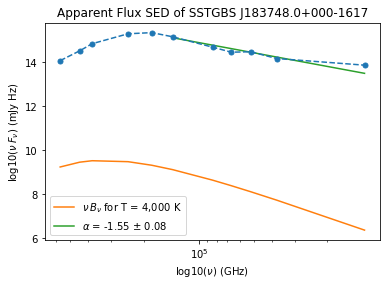

The GB index 3375
RA:  279.45014662659435
DEC:  -0.2715059066943372
The difference in RA is  0.048 arcseconds
The difference in Dec is  0.268 arcseconds
The Gould_Belt_ID is  SSTGBS J183748.0+000-1617
alpha is -1.23
The object type is Galc_star+dust(IR4)
2MASS ID: b'18374802-0016170'
FLUX SIGNAL TO NOISE
[ 15.60390092 159.15255509  53.95527898  33.92925302  51.52119713
  43.2993527   20.32258065  20.33653846  20.32258065  19.94818653
  10.24911032]
SED Flux
[ 0.20499222  0.73209643  1.8083483   7.99629211 12.14228153 10.20459461
  5.67        4.23        5.67        3.85        5.76      ]
SED Flux Error
[0.01313724 0.00459997 0.03351569 0.23567545 0.23567545 0.23567545
 0.279      0.208      0.279      0.193      0.562     ]
The apparent magnitude in g is: 16.633614
The absolute magnitude in g is: 8.231395574350584
g-K is: 4.5956135
GB-GR is: 2.6888647
SED_nu_log
[14.06593238 14.51256804 14.8373727  15.2880424  15.34048998 15.15136382
 14.67928815 14.44947302 14.47160008 14.1631523  1

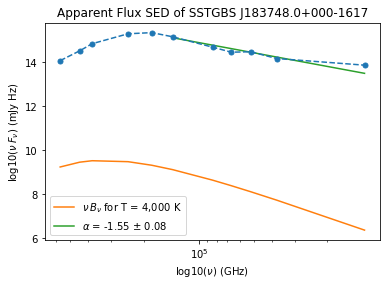

70
56913
71
51667
The GB index 3406
RA:  279.48389889127253
DEC:  -0.3415313111456956
The difference in RA is  0.018 arcseconds
The difference in Dec is  0.254 arcseconds
The Gould_Belt_ID is  SSTGBS J183756.1+000-2029
alpha is -1.74
The object type is star+dust(IR4)
2MASS ID: b'18375612-0020291'
FLUX SIGNAL TO NOISE
[  3.47285198 185.90782353  24.52505054  14.47648106  20.47740012
  16.69436587  19.85680191  18.84057971  19.85680191   9.0685413
   1.58663883]
SED Flux
[0.01708151 0.04360138 0.13421698 0.96491349 1.36489797 1.11274409
 0.832      0.65       0.832      0.516      0.76      ]
SED Flux Error
[4.91858181e-03 2.34532243e-04 5.47264842e-03 6.66538700e-02
 6.66538700e-02 6.66538700e-02 4.19000000e-02 3.45000000e-02
 4.19000000e-02 5.69000000e-02 4.79000000e-01]
The apparent magnitude in g is: 19.696283
The absolute magnitude in g is: 11.694437238304554
g-K is: 5.252283
GB-GR is: 2.5632076
SED_nu_log
[12.98672118 13.28749997 13.70789807 14.36964212 14.39128987 14.18896336
 13.

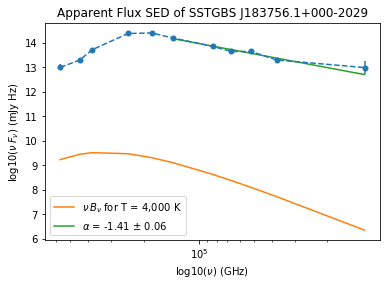

The GB index 3406
RA:  279.48389889127253
DEC:  -0.3415313111456956
The difference in RA is  0.018 arcseconds
The difference in Dec is  0.254 arcseconds
The Gould_Belt_ID is  SSTGBS J183756.1+000-2029
alpha is -1.74
The object type is star+dust(IR4)
2MASS ID: b'18375612-0020291'
FLUX SIGNAL TO NOISE
[  3.47285198 185.90782353  24.52505054  14.47648106  20.47740012
  16.69436587  19.85680191  18.84057971  19.85680191   9.0685413
   1.58663883]
SED Flux
[0.01708151 0.04360138 0.13421698 0.96491349 1.36489797 1.11274409
 0.832      0.65       0.832      0.516      0.76      ]
SED Flux Error
[4.91858181e-03 2.34532243e-04 5.47264842e-03 6.66538700e-02
 6.66538700e-02 6.66538700e-02 4.19000000e-02 3.45000000e-02
 4.19000000e-02 5.69000000e-02 4.79000000e-01]
The apparent magnitude in g is: 19.696283
The absolute magnitude in g is: 11.694437238304554
g-K is: 5.252283
GB-GR is: 2.5632076
SED_nu_log
[12.98672118 13.28749997 13.70789807 14.36964212 14.39128987 14.18896336
 13.84582842 13.636046

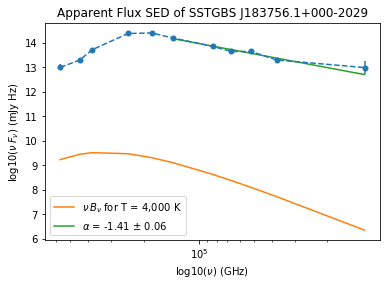

72
51542
The GB index 3417
RA:  279.4923836198011
DEC:  -0.39197243585457325
The difference in RA is  0.119 arcseconds
The difference in Dec is  0.162 arcseconds
The Gould_Belt_ID is  SSTGBS J183758.2+000-2331
alpha is -0.6
The object type is star+dust(MP1)
2MASS ID: b'18375816-0023310'
FLUX SIGNAL TO NOISE
[  5.354151   185.28527399  27.11169494  15.96670753  18.35806837
  19.0161766   19.60893855  15.69620253  19.60893855   2.89839572
   3.51295337]
SED Flux
[2.30316985e-02 4.07819040e-02 1.28986433e-01 9.72944379e-01
 1.11866391e+00 1.15876627e+00 7.02000000e-01 4.96000000e-01
 7.02000000e-01 2.71000000e-01 6.78000000e+01]
SED Flux Error
[4.30165278e-03 2.20103320e-04 4.75759385e-03 6.09358177e-02
 6.09358177e-02 6.09358177e-02 3.58000000e-02 3.16000000e-02
 3.58000000e-02 9.35000000e-02 1.93000000e+01]
The apparent magnitude in g is: 19.768866
The absolute magnitude in g is: 11.270184891308329
g-K is: 5.368866
GB-GR is: 2.195549
SED_nu_log
[13.11652097 13.25846725 13.69063465 14.37

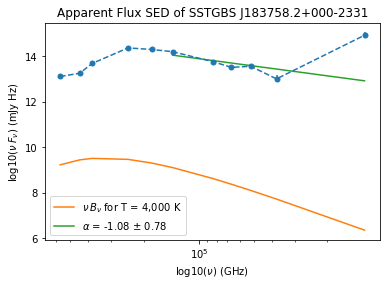

The GB index 3417
RA:  279.4923836198011
DEC:  -0.39197243585457325
The difference in RA is  0.119 arcseconds
The difference in Dec is  0.162 arcseconds
The Gould_Belt_ID is  SSTGBS J183758.2+000-2331
alpha is -0.6
The object type is star+dust(MP1)
2MASS ID: b'18375816-0023310'
FLUX SIGNAL TO NOISE
[  5.354151   185.28527399  27.11169494  15.96670753  18.35806837
  19.0161766   19.60893855  15.69620253  19.60893855   2.89839572
   3.51295337]
SED Flux
[2.30316985e-02 4.07819040e-02 1.28986433e-01 9.72944379e-01
 1.11866391e+00 1.15876627e+00 7.02000000e-01 4.96000000e-01
 7.02000000e-01 2.71000000e-01 6.78000000e+01]
SED Flux Error
[4.30165278e-03 2.20103320e-04 4.75759385e-03 6.09358177e-02
 6.09358177e-02 6.09358177e-02 3.58000000e-02 3.16000000e-02
 3.58000000e-02 9.35000000e-02 1.93000000e+01]
The apparent magnitude in g is: 19.768866
The absolute magnitude in g is: 11.270184891308329
g-K is: 5.368866
GB-GR is: 2.195549
SED_nu_log
[13.11652097 13.25846725 13.69063465 14.37324176 14

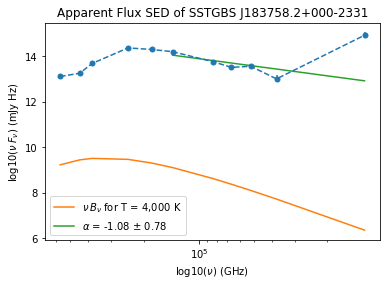

73
57219
The GB index 3435
RA:  279.5197148916612
DEC:  0.7441423868430713
The difference in RA is  0.23 arcseconds
The difference in Dec is  0.265 arcseconds
The Gould_Belt_ID is  SSTGBS J183804.7+004439
alpha is -1.59
The object type is star+dust(MP1)
2MASS ID: b'18380474+0044390'
FLUX SIGNAL TO NOISE
[ 13.71713093 443.52129883 154.59747238  30.15934108  43.45437618
  37.43939642   1.           1.           1.           1.
   5.24752475]
SED Flux
[ 6.91462681e-02  3.19831014e-01  8.07731330e-01  3.50661755e+00
  5.05242729e+00  4.35306740e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.06000000e+00]
SED Flux Error
[ 5.04086958e-03  7.21117598e-04  5.22473827e-03  1.16269700e-01
  1.16269700e-01  1.16269700e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.02000000e-01]
The apparent magnitude in g is: 17.532732
The absolute magnitude in g is: 9.014228494383008
g-K is: 4.5697317
GB-GR is: 2.9937496
MIPS 1 IS MISSING
SED_nu_log
[13.59396375 

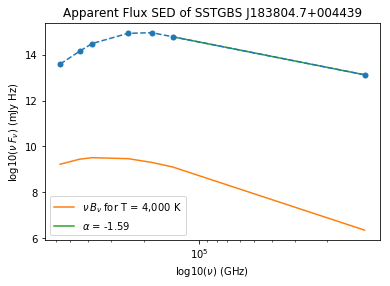

The GB index 3435
RA:  279.5197148916612
DEC:  0.7441423868430713
The difference in RA is  0.23 arcseconds
The difference in Dec is  0.265 arcseconds
The Gould_Belt_ID is  SSTGBS J183804.7+004439
alpha is -1.59
The object type is star+dust(MP1)
2MASS ID: b'18380474+0044390'
FLUX SIGNAL TO NOISE
[ 13.71713093 443.52129883 154.59747238  30.15934108  43.45437618
  37.43939642   1.           1.           1.           1.
   5.24752475]
SED Flux
[ 6.91462681e-02  3.19831014e-01  8.07731330e-01  3.50661755e+00
  5.05242729e+00  4.35306740e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.06000000e+00]
SED Flux Error
[ 5.04086958e-03  7.21117598e-04  5.22473827e-03  1.16269700e-01
  1.16269700e-01  1.16269700e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.02000000e-01]
The apparent magnitude in g is: 17.532732
The absolute magnitude in g is: 9.014228494383008
g-K is: 4.5697317
GB-GR is: 2.9937496
MIPS 1 IS MISSING
SED_nu_log
[13.59396375 14.152920

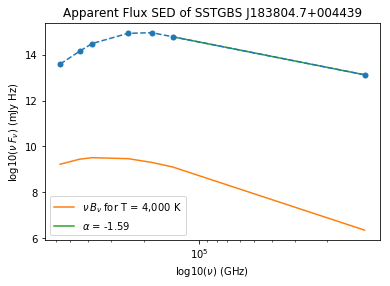

74
51872
The GB index 3465
RA:  279.56380807438825
DEC:  -0.359721558091634
The difference in RA is  0.011 arcseconds
The difference in Dec is  0.071 arcseconds
The Gould_Belt_ID is  SSTGBS J183815.3+000-2135
alpha is -1.25
The object type is star+dust(IR2)
2MASS ID: b'18381531-0021350'
FLUX SIGNAL TO NOISE
[  3.77939811 199.19688229  15.00738577  20.48558884  33.27056547
  31.25762649  19.16859122  19.37669377  19.16859122  16.44880174
   1.80141844]
SED Flux
[0.01082778 0.05926316 0.19905601 1.38448477 2.24853635 2.11249518
 1.66       1.43       1.66       1.51       0.508     ]
SED Flux Error
[0.00286495 0.00029751 0.01326387 0.06758335 0.06758335 0.06758335
 0.0866     0.0738     0.0866     0.0918     0.282     ]
The apparent magnitude in g is: 19.363071
The absolute magnitude in g is: 11.031895684331225
g-K is: 5.6150713
GB-GR is: 3.4860935
SED_nu_log
[12.78873457 13.42078454 13.87906592 14.52644193 14.6080896  14.46736379
 14.14581318 13.97846869 13.93812511 13.75666852 12.80531

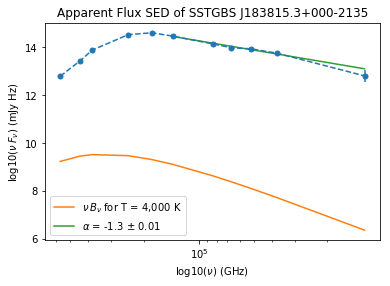

The GB index 3465
RA:  279.56380807438825
DEC:  -0.359721558091634
The difference in RA is  0.011 arcseconds
The difference in Dec is  0.071 arcseconds
The Gould_Belt_ID is  SSTGBS J183815.3+000-2135
alpha is -1.25
The object type is star+dust(IR2)
2MASS ID: b'18381531-0021350'
FLUX SIGNAL TO NOISE
[  3.77939811 199.19688229  15.00738577  20.48558884  33.27056547
  31.25762649  19.16859122  19.37669377  19.16859122  16.44880174
   1.80141844]
SED Flux
[0.01082778 0.05926316 0.19905601 1.38448477 2.24853635 2.11249518
 1.66       1.43       1.66       1.51       0.508     ]
SED Flux Error
[0.00286495 0.00029751 0.01326387 0.06758335 0.06758335 0.06758335
 0.0866     0.0738     0.0866     0.0918     0.282     ]
The apparent magnitude in g is: 19.363071
The absolute magnitude in g is: 11.031895684331225
g-K is: 5.6150713
GB-GR is: 3.4860935
SED_nu_log
[12.78873457 13.42078454 13.87906592 14.52644193 14.6080896  14.46736379
 14.14581318 13.97846869 13.93812511 13.75666852 12.80531787]
SED_

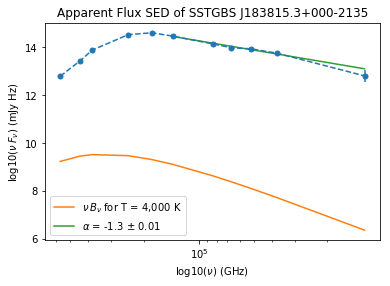

75
57159
The GB index 3478
RA:  279.59830455650985
DEC:  0.8523970128544923
The difference in RA is  0.072 arcseconds
The difference in Dec is  0.27 arcseconds
The Gould_Belt_ID is  SSTGBS J183823.6+005109
alpha is -1.02
The object type is star+dust(MP1)
2MASS ID: b'18382359+0051087'
FLUX SIGNAL TO NOISE
[ 4.53266364 99.32461938 32.27860455 27.83938885 43.98163176 48.23550807
  1.          1.          1.          1.          8.57768053]
SED Flux
[ 1.17441006e-02  1.28490359e-01  3.88192624e-01  2.35335946e+00
  3.71791887e+00  4.07751369e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.92000000e+00]
SED Flux Error
[ 2.59099319e-03  1.29364058e-03  1.20263137e-02  8.45334455e-02
  8.45334455e-02  8.45334455e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.57000000e-01]
The apparent magnitude in g is: 18.522858
The absolute magnitude in g is: 10.508924553734161
g-K is: 5.4888573
GB-GR is: 4.1230717
MIPS 1 IS MISSING
SED_nu_log
[12.82401477 13

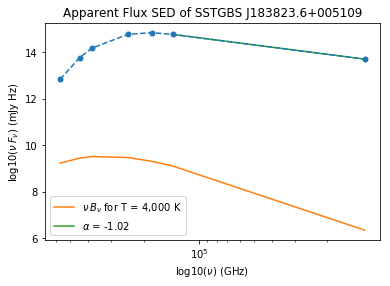

The GB index 3478
RA:  279.59830455650985
DEC:  0.8523970128544923
The difference in RA is  0.072 arcseconds
The difference in Dec is  0.27 arcseconds
The Gould_Belt_ID is  SSTGBS J183823.6+005109
alpha is -1.02
The object type is star+dust(MP1)
2MASS ID: b'18382359+0051087'
FLUX SIGNAL TO NOISE
[ 4.53266364 99.32461938 32.27860455 27.83938885 43.98163176 48.23550807
  1.          1.          1.          1.          8.57768053]
SED Flux
[ 1.17441006e-02  1.28490359e-01  3.88192624e-01  2.35335946e+00
  3.71791887e+00  4.07751369e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.92000000e+00]
SED Flux Error
[ 2.59099319e-03  1.29364058e-03  1.20263137e-02  8.45334455e-02
  8.45334455e-02  8.45334455e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.57000000e-01]
The apparent magnitude in g is: 18.522858
The absolute magnitude in g is: 10.508924553734161
g-K is: 5.4888573
GB-GR is: 4.1230717
MIPS 1 IS MISSING
SED_nu_log
[12.82401477 13.75687029

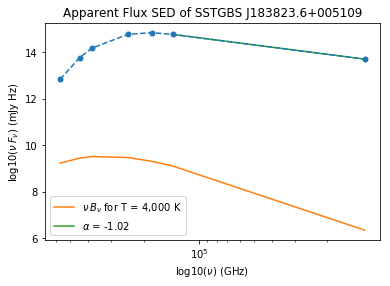

76
56866
The GB index 3488
RA:  279.6340291439558
DEC:  0.7408494598774539
The difference in RA is  0.428 arcseconds
The difference in Dec is  0.056 arcseconds
The Gould_Belt_ID is  SSTGBS J183832.1+004427
alpha is -2.17
The object type is star+dust(MP1)
2MASS ID: b'18383214+0044271'
FLUX SIGNAL TO NOISE
[ 56.30613713 939.98976133  47.92873998  49.35164737  38.78939607
  29.51269803  16.56074766   1.          16.56074766   1.
  10.64220183]
SED Flux
[ 122.53872681  128.04885864  219.32331848  319.21868896  250.89942932
  190.89544678   88.6        -999.           88.6        -999.
   11.6       ]
SED Flux Error
[ 2.17629433e+00  1.36223674e-01  4.57602930e+00  6.46824789e+00
  6.46824789e+00  6.46824789e+00  5.35000000e+00 -9.99000000e+02
  5.35000000e+00 -9.99000000e+02  1.09000000e+00]
The apparent magnitude in g is: 11.026594
The absolute magnitude in g is: 2.5221355932648297
g-K is: 2.1685944
GB-GR is: 0.9570322
MIPS 1 IS MISSING
SED_nu_log
[16.84246837 16.75537546 16.92117542 16.8

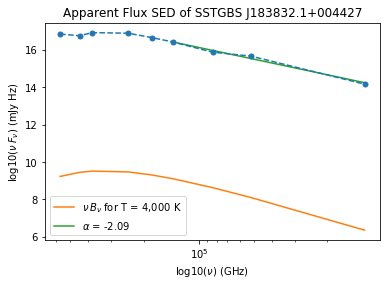

The GB index 3488
RA:  279.6340291439558
DEC:  0.7408494598774539
The difference in RA is  0.428 arcseconds
The difference in Dec is  0.056 arcseconds
The Gould_Belt_ID is  SSTGBS J183832.1+004427
alpha is -2.17
The object type is star+dust(MP1)
2MASS ID: b'18383214+0044271'
FLUX SIGNAL TO NOISE
[ 56.30613713 939.98976133  47.92873998  49.35164737  38.78939607
  29.51269803  16.56074766   1.          16.56074766   1.
  10.64220183]
SED Flux
[ 122.53872681  128.04885864  219.32331848  319.21868896  250.89942932
  190.89544678   88.6        -999.           88.6        -999.
   11.6       ]
SED Flux Error
[ 2.17629433e+00  1.36223674e-01  4.57602930e+00  6.46824789e+00
  6.46824789e+00  6.46824789e+00  5.35000000e+00 -9.99000000e+02
  5.35000000e+00 -9.99000000e+02  1.09000000e+00]
The apparent magnitude in g is: 11.026594
The absolute magnitude in g is: 2.5221355932648297
g-K is: 2.1685944
GB-GR is: 0.9570322
MIPS 1 IS MISSING
SED_nu_log
[16.84246837 16.75537546 16.92117542 16.88924205 1

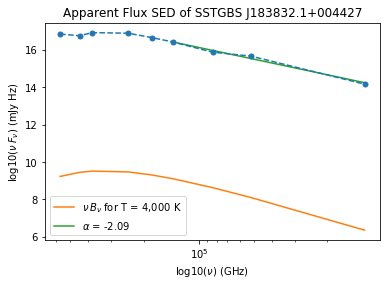

77
56967
The GB index 3489
RA:  279.6352128856142
DEC:  0.7541730458609259
The difference in RA is  0.085 arcseconds
The difference in Dec is  0.151 arcseconds
The Gould_Belt_ID is  SSTGBS J183832.5+004515
alpha is -0.91
The object type is star+dust(MP1)
2MASS ID: b'18383245+0045151'
FLUX SIGNAL TO NOISE
[ 13.44534802 395.88886014  65.8857216   31.02103496  49.37060837
  47.42026295  20.10869565   1.          20.10869565   1.
  10.30721966]
SED Flux
[ 3.71165462e-02  2.53899723e-01  7.11602628e-01  3.53580284e+00
  5.62730217e+00  5.40500021e+00  3.70000000e+00 -9.99000000e+02
  3.70000000e+00 -9.99000000e+02  6.71000000e+00]
SED Flux Error
[ 2.76054931e-03  6.41340914e-04  1.08005591e-02  1.13980815e-01
  1.13980815e-01  1.13980815e-01  1.84000000e-01 -9.99000000e+02
  1.84000000e-01 -9.99000000e+02  6.51000000e-01]
The apparent magnitude in g is: 17.783379
The absolute magnitude in g is: 9.660456331847996
g-K is: 5.055379
GB-GR is: 3.5316792
MIPS 1 IS MISSING
SED_nu_log
[13.32376256 

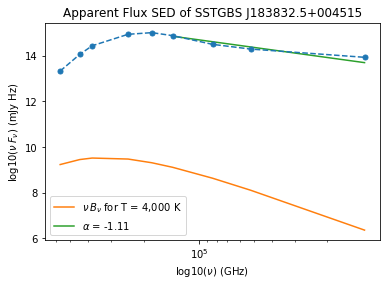

The GB index 3489
RA:  279.6352128856142
DEC:  0.7541730458609259
The difference in RA is  0.085 arcseconds
The difference in Dec is  0.151 arcseconds
The Gould_Belt_ID is  SSTGBS J183832.5+004515
alpha is -0.91
The object type is star+dust(MP1)
2MASS ID: b'18383245+0045151'
FLUX SIGNAL TO NOISE
[ 13.44534802 395.88886014  65.8857216   31.02103496  49.37060837
  47.42026295  20.10869565   1.          20.10869565   1.
  10.30721966]
SED Flux
[ 3.71165462e-02  2.53899723e-01  7.11602628e-01  3.53580284e+00
  5.62730217e+00  5.40500021e+00  3.70000000e+00 -9.99000000e+02
  3.70000000e+00 -9.99000000e+02  6.71000000e+00]
SED Flux Error
[ 2.76054931e-03  6.41340914e-04  1.08005591e-02  1.13980815e-01
  1.13980815e-01  1.13980815e-01  1.84000000e-01 -9.99000000e+02
  1.84000000e-01 -9.99000000e+02  6.51000000e-01]
The apparent magnitude in g is: 17.783379
The absolute magnitude in g is: 9.660456331847996
g-K is: 5.055379
GB-GR is: 3.5316792
MIPS 1 IS MISSING
SED_nu_log
[13.32376256 14.052661

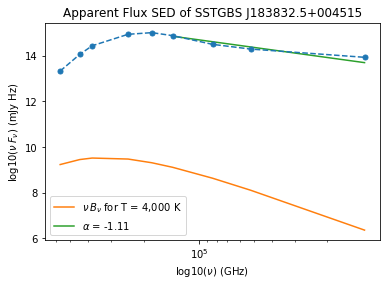

78
51619
The GB index 3512
RA:  279.6944761510876
DEC:  -0.4302043796431921
The difference in RA is  0.047 arcseconds
The difference in Dec is  0.136 arcseconds
The Gould_Belt_ID is  SSTGBS J183846.7+000-2549
alpha is -1.53
The object type is Galc_star+dust(IR4)
2MASS ID: b'18384667-0025486'
FLUX SIGNAL TO NOISE
[ 10.62283459 300.59562096  74.86903168  33.92925569  43.65016752
  42.58740166  19.79899497  20.42253521  19.79899497  17.45350501
   5.6097561 ]
SED Flux
[0.01608642 0.12698033 0.41432112 2.48707247 3.19963193 3.12172937
 1.97       1.45       1.97       1.22       1.15      ]
SED Flux Error
[0.00151432 0.00042243 0.00553395 0.07330171 0.07330171 0.07330171
 0.0995     0.071      0.0995     0.0699     0.205     ]
The apparent magnitude in g is: 18.535692
The absolute magnitude in g is: 10.39578675279363
g-K is: 5.211692
GB-GR is: 3.8521976
SED_nu_log
[12.96065436 13.75173621 14.19742769 14.78084219 14.76128971 14.63696331
 14.22017132 13.98450066 14.01248325 13.6640514  13.16

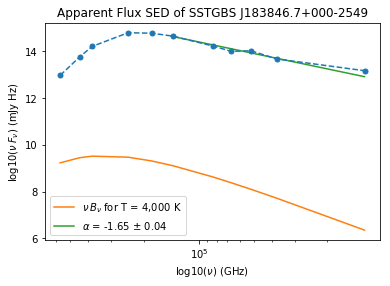

The GB index 3512
RA:  279.6944761510876
DEC:  -0.4302043796431921
The difference in RA is  0.047 arcseconds
The difference in Dec is  0.136 arcseconds
The Gould_Belt_ID is  SSTGBS J183846.7+000-2549
alpha is -1.53
The object type is Galc_star+dust(IR4)
2MASS ID: b'18384667-0025486'
FLUX SIGNAL TO NOISE
[ 10.62283459 300.59562096  74.86903168  33.92925569  43.65016752
  42.58740166  19.79899497  20.42253521  19.79899497  17.45350501
   5.6097561 ]
SED Flux
[0.01608642 0.12698033 0.41432112 2.48707247 3.19963193 3.12172937
 1.97       1.45       1.97       1.22       1.15      ]
SED Flux Error
[0.00151432 0.00042243 0.00553395 0.07330171 0.07330171 0.07330171
 0.0995     0.071      0.0995     0.0699     0.205     ]
The apparent magnitude in g is: 18.535692
The absolute magnitude in g is: 10.39578675279363
g-K is: 5.211692
GB-GR is: 3.8521976
SED_nu_log
[12.96065436 13.75173621 14.19742769 14.78084219 14.76128971 14.63696331
 14.22017132 13.98450066 14.01248325 13.6640514  13.160152  ]
S

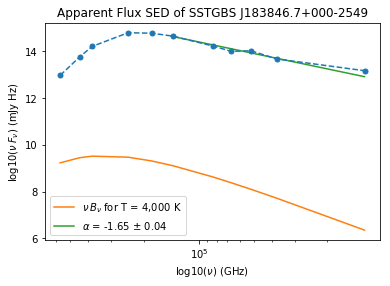

79
54801
The GB index 3530
RA:  279.7188923957327
DEC:  -0.07835774164619097
The difference in RA is  0.017 arcseconds
The difference in Dec is  0.246 arcseconds
The Gould_Belt_ID is  SSTGBS J183852.5+000-442
alpha is -1.19
The object type is Galc_star+dust(IR3)
2MASS ID: b'18385254-0004418'
FLUX SIGNAL TO NOISE
[  4.8265677  261.10931245  51.35917492  28.57200596  42.04865101
  37.93567544  19.65317919  19.7761194   19.65317919  13.37662338
   6.65306122]
SED Flux
[0.00831547 0.07962924 0.23795991 1.48760819 2.18927288 1.97512984
 1.36       1.06       1.36       1.03       1.63      ]
SED Flux Error
[0.00172285 0.00030497 0.00463325 0.05206523 0.05206523 0.05206523
 0.0692     0.0536     0.0692     0.077      0.245     ]
The apparent magnitude in g is: 19.042353
The absolute magnitude in g is: 10.68144269863381
g-K is: 5.2213526
GB-GR is: 3.966545
SED_nu_log
[12.67408191 13.54907233 13.9565944  14.55764231 14.59648958 14.43816371
 14.059244   13.84843852 13.85155593 13.5905288  13.31

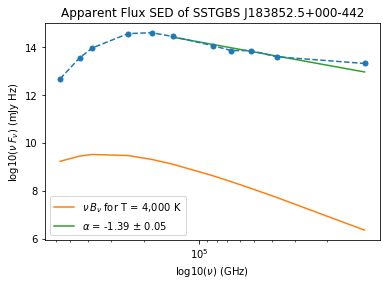

The GB index 3530
RA:  279.7188923957327
DEC:  -0.07835774164619097
The difference in RA is  0.017 arcseconds
The difference in Dec is  0.246 arcseconds
The Gould_Belt_ID is  SSTGBS J183852.5+000-442
alpha is -1.19
The object type is Galc_star+dust(IR3)
2MASS ID: b'18385254-0004418'
FLUX SIGNAL TO NOISE
[  4.8265677  261.10931245  51.35917492  28.57200596  42.04865101
  37.93567544  19.65317919  19.7761194   19.65317919  13.37662338
   6.65306122]
SED Flux
[0.00831547 0.07962924 0.23795991 1.48760819 2.18927288 1.97512984
 1.36       1.06       1.36       1.03       1.63      ]
SED Flux Error
[0.00172285 0.00030497 0.00463325 0.05206523 0.05206523 0.05206523
 0.0692     0.0536     0.0692     0.077      0.245     ]
The apparent magnitude in g is: 19.042353
The absolute magnitude in g is: 10.68144269863381
g-K is: 5.2213526
GB-GR is: 3.966545
SED_nu_log
[12.67408191 13.54907233 13.9565944  14.55764231 14.59648958 14.43816371
 14.059244   13.84843852 13.85155593 13.5905288  13.31164176]
S

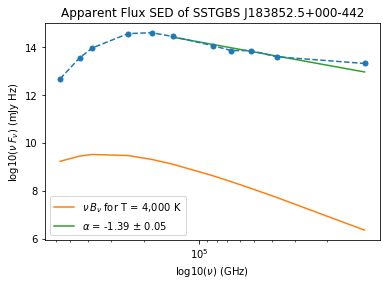

80
57296
The GB index 3549
RA:  279.7630502739988
DEC:  0.8721223559850535
The difference in RA is  0.284 arcseconds
The difference in Dec is  0.265 arcseconds
The Gould_Belt_ID is  SSTGBS J183903.1+005220
alpha is -1.11
The object type is star+dust(MP1)
2MASS ID: b'18390311+0052197'
FLUX SIGNAL TO NOISE
[13.73787015 56.13891465 18.18765122 31.93341739 45.17073651 44.47879859
  1.          1.          1.          1.          8.18376068]
SED Flux
[ 3.32424156e-02  2.14863405e-01  6.07120633e-01  3.58169031e+00
  5.06640387e+00  4.98879528e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.83000000e+00]
SED Flux Error
[ 2.41976487e-03  3.82735231e-03  3.33809257e-02  1.12161197e-01
  1.12161197e-01  1.12161197e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.68000000e-01]
The apparent magnitude in g is: 17.964628
The absolute magnitude in g is: 9.535512220628592
g-K is: 5.1496286
GB-GR is: 3.47896
MIPS 1 IS MISSING
SED_nu_log
[13.27588758 13.98

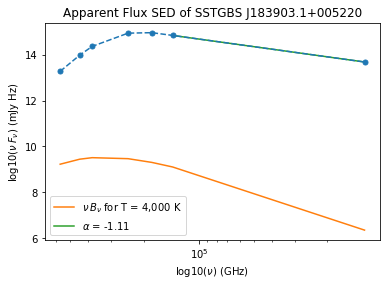

The GB index 3549
RA:  279.7630502739988
DEC:  0.8721223559850535
The difference in RA is  0.284 arcseconds
The difference in Dec is  0.265 arcseconds
The Gould_Belt_ID is  SSTGBS J183903.1+005220
alpha is -1.11
The object type is star+dust(MP1)
2MASS ID: b'18390311+0052197'
FLUX SIGNAL TO NOISE
[13.73787015 56.13891465 18.18765122 31.93341739 45.17073651 44.47879859
  1.          1.          1.          1.          8.18376068]
SED Flux
[ 3.32424156e-02  2.14863405e-01  6.07120633e-01  3.58169031e+00
  5.06640387e+00  4.98879528e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.83000000e+00]
SED Flux Error
[ 2.41976487e-03  3.82735231e-03  3.33809257e-02  1.12161197e-01
  1.12161197e-01  1.12161197e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.68000000e-01]
The apparent magnitude in g is: 17.964628
The absolute magnitude in g is: 9.535512220628592
g-K is: 5.1496286
GB-GR is: 3.47896
MIPS 1 IS MISSING
SED_nu_log
[13.27588758 13.9801622  14

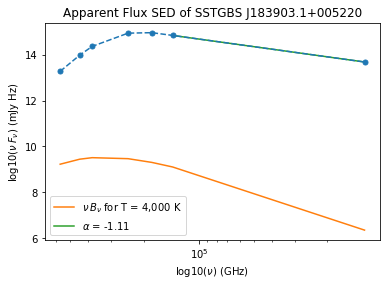

81
56093
The GB index 3625
RA:  279.9477053253108
DEC:  0.4896973059229912
The difference in RA is  0.098 arcseconds
The difference in Dec is  0.104 arcseconds
The Gould_Belt_ID is  SSTGBS J183947.5+002923
alpha is -1.54
The object type is Galc_star+dust(IR3)
2MASS ID: b'18394744+0029230'
FLUX SIGNAL TO NOISE
[  4.4674674  152.88921854  18.89931421  24.67582228  32.09837695
  31.54850671  19.04191617  20.35541195  19.04191617  17.45762712
   3.06008584]
SED Flux
[0.01565754 0.10222416 0.30698162 1.63714957 2.12960863 2.09312677
 1.59       1.26       1.59       1.03       0.713     ]
SED Flux Error
[0.00350479 0.00066862 0.016243   0.0663463  0.0663463  0.0663463
 0.0835     0.0619     0.0835     0.059      0.233     ]
The apparent magnitude in g is: 18.77115
The absolute magnitude in g is: 10.703570205320727
g-K is: 5.01315
GB-GR is: 3.5559769
SED_nu_log
[12.94891844 13.65755328 14.06720299 14.5992421  14.58448948 14.46336359
 14.12710222 13.9235032  13.91941414 13.5905288  12.9525436

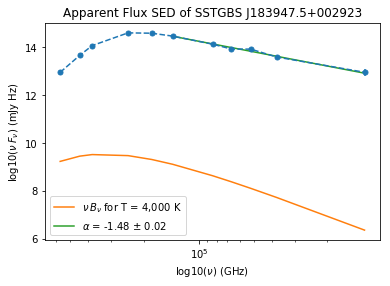

The GB index 3625
RA:  279.9477053253108
DEC:  0.4896973059229912
The difference in RA is  0.098 arcseconds
The difference in Dec is  0.104 arcseconds
The Gould_Belt_ID is  SSTGBS J183947.5+002923
alpha is -1.54
The object type is Galc_star+dust(IR3)
2MASS ID: b'18394744+0029230'
FLUX SIGNAL TO NOISE
[  4.4674674  152.88921854  18.89931421  24.67582228  32.09837695
  31.54850671  19.04191617  20.35541195  19.04191617  17.45762712
   3.06008584]
SED Flux
[0.01565754 0.10222416 0.30698162 1.63714957 2.12960863 2.09312677
 1.59       1.26       1.59       1.03       0.713     ]
SED Flux Error
[0.00350479 0.00066862 0.016243   0.0663463  0.0663463  0.0663463
 0.0835     0.0619     0.0835     0.059      0.233     ]
The apparent magnitude in g is: 18.77115
The absolute magnitude in g is: 10.703570205320727
g-K is: 5.01315
GB-GR is: 3.5559769
SED_nu_log
[12.94891844 13.65755328 14.06720299 14.5992421  14.58448948 14.46336359
 14.12710222 13.9235032  13.91941414 13.5905288  12.95254369]
SED_nu

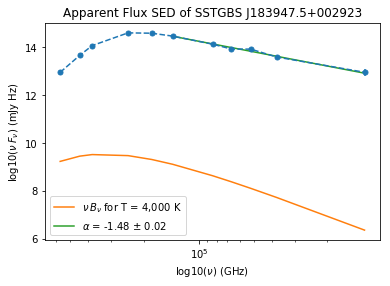

In [15]:
#DETERMINE WHICH S+D COULD BE YSOs

#categories
notYSOs = np.array([59418,35960,32502,56913])
classI_ysos = np.array([])
classII_ysos = np.array([])
classIII_ysos = np.array([])
classIII_ysos_noerr = np.array([])
flat_ysos = np.array([])
sd_stars = np.array([])
few_points = np.array([])

#array of gala indices
SD_id_vals = SD_ALL['id']

#alpha info
alphas = np.array([])
alpha_errs = np.array([])
SED_fluxes = np.zeros((1,11))

for i in range(len(SD_id_vals)):
    print(i)
    id_val = int(SD_id_vals[i])
    print(id_val)
    if (id_val != 59418 and id_val != 35960 and id_val != 32502 and id_val != 56913):
        Values = SEDCreator(id_val,SD_match,'S+D','Star+Dust_SEDS',0,0)
        alphas = np.append(alphas,Values['alpha'])
        alpha_errs = np.append(alpha_errs, Values['alpha_e'])
        SED_fluxes = np.vstack((SED_fluxes,Values['SED_flux']))
        if (len(Values['SED_flux']) <= 7):
            few_points = np.append(few_points,id_val)
            another = SEDCreator(id_val,SD_match,'S+D','Star+Dust_SEDS2/FewPoints',0,0)
        elif (Values['alpha'] > 0.3):
            classI_ysos = np.append(classI_ysos,id_val)
            another = SEDCreator(id_val,SD_match,'S+D','Star+Dust_SEDS2/ClassI',0,0)
        elif (Values['alpha'] < 0.3 and Values['alpha'] > -0.3):
            flat_ysos = np.append(flat_ysos,id_val)
            another = SEDCreator(id_val,SD_match,'S+D','Star+Dust_SEDS2/Flat',0,0)
        elif (Values['alpha'] < -0.3 and Values['alpha'] > -1.6):
            classII_ysos = np.append(classII_ysos,id_val)
            another = SEDCreator(id_val,SD_match,'S+D','Star+Dust_SEDS2/ClassII',0,0)
        elif (Values['alpha'] < -1.6 and Values['alpha']-Values['alpha_e'] > -2.5 and Values['alpha_e'] > -1):
            classIII_ysos = np.append(classIII_ysos,id_val)
            another = SEDCreator(id_val,SD_match,'S+D','Star+Dust_SEDS2/ClassIII',0,0)
        elif (Values['alpha'] < -1.6 and Values['alpha'] > -2.5 and Values['alpha_e'] == -2):
            classIII_ysos_noerr = np.append(classIII_ysos_noerr,id_val)
            another = SEDCreator(id_val,SD_match,'S+D','Star+Dust_SEDS2/ClassIII_NoErr',0,0)
        else:
            sd_stars = np.append(sd_stars,id_val)
            another = SEDCreator(id_val,SD_match,'S+D','Star+Dust_SEDS2/Other',0,0)
            
SED_fluxes = np.delete(SED_fluxes, 0, 0) #delete first row

In [16]:
#Information about the S+D sources that could be YSOs
print(alphas)
print(alpha_errs)
print('The total number of YSOs is:',len(SD_id_vals))
print('Number of YSOs that wont plot for some reason:',len(notYSOs))
print('Number of Class I YSOs:',len(classI_ysos))
print('Number of flat YSOs:',len(flat_ysos))
print('Number of Class II YSOs:',len(classII_ysos))
print('Number of Class III YSOs:',len(classIII_ysos))
print('Number of Class III YSOs that have no error:',len(classIII_ysos_noerr))
print('Number of stars:',len(sd_stars))
print('Number of SEDs with too few points:',len(few_points))


#combine arrays
notYSOs2 = np.concatenate((notYSOs,sd_stars,few_points)) #S+D to exclude from finding properties of YSOs
potientialYSOs = np.concatenate((classI_ysos,flat_ysos,classII_ysos,classIII_ysos,classIII_ysos_noerr))

[-0.57928515 -0.61449587 -1.23492899 -2.74120738 -1.37147598 -1.65984265
 -1.81735757 -0.94740903 -1.37218034 -1.15177486 -1.07383546 -0.65462443
 -2.15983443 -1.02168748 -1.06937907 -1.37108766 -2.25276238 -0.98262219
 -1.42617071 -0.53266242 -1.26554831 -1.28816717 -2.30964367 -1.6214797
 -1.84397874 -0.96653735 -0.91218857 -1.85816197 -0.40575146 -1.80515819
 -1.57198008 -1.82405003 -1.18448613 -1.28963409 -1.74546962 -0.79852891
 -0.34785889 -1.8049417  -1.22918527 -2.42071673 -1.95379731 -1.04062494
 -1.89527804 -2.01529115 -1.94818096 -1.35236235 -0.93342978 -0.93499438
 -1.76908527 -1.1326057  -1.32020312 -2.18420393 -0.85945211 -2.42353611
 -2.16604292 -2.13128728 -1.47104889 -1.1465199  -1.73399045 -2.09450816
 -1.80489193 -0.57164578 -0.62225725 -2.20441951 -1.62970071 -1.37478506
 -1.55158942 -1.40616752 -1.08166204 -1.58813282 -1.29703943 -1.0164022
 -2.09043844 -1.10885954 -1.64507541 -1.39243413 -1.11005213 -1.48053259]
[-2.         -2.         -2.          0.19148947  0.

Number of All matches in the correct distance interval: 77
Number of _match with parallax > 5, 10, 20:  64 42 26
For all stars in region
The mean velocity in ra is  3.0006794066631044 +/- 1.0275556639548378
The mean velocity in dec is  -16.254551454764364 +/- 1.4491198873621038
The median velocity in ra is  5.02222021368034 +/- 1.2878500405132134
The median velocity in dec is  -18.027043208948207 +/- 1.8162024414959699
The mean magnitude of velocity is 20.407759600220952 +/- 1.1381001368950656
The median magnitude of velocity is 19.18762313465398 +/- 1.4263969912512917
The standard deviation of velocity is 9.9867881705403
The median parallax is 2.1634677858924354 with a standard deviation of 0.2532185928998379
The median distance is 462.2208874663219 with a standard deviation of 49.56734648802856
For parallax S/N > 10 stars:
The mean velocity in ra is  2.990224691292875 +/- 1.6285766596102207
The mean velocity in dec is  -13.657116714197427 +/- 1.6541656107186793
The median velocity in

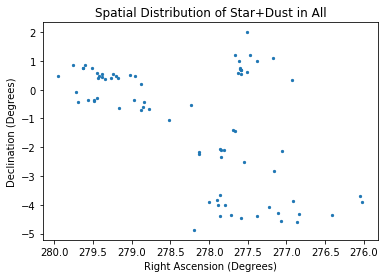

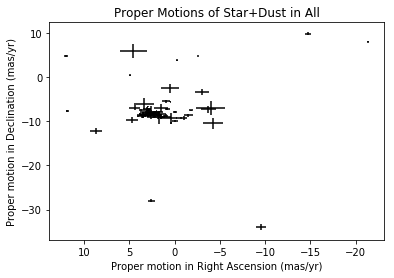

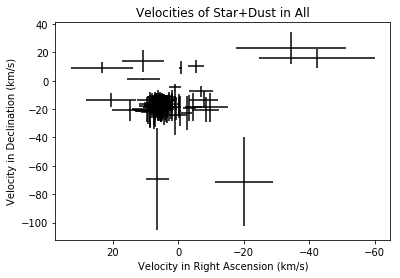

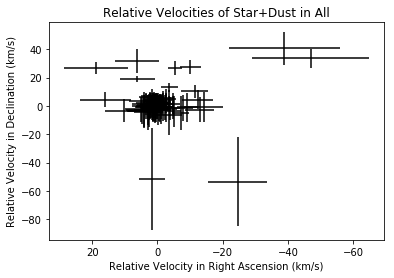

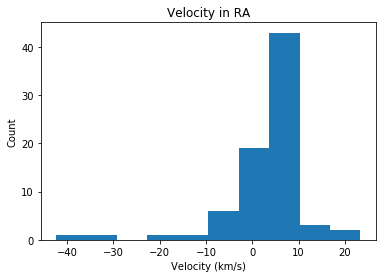

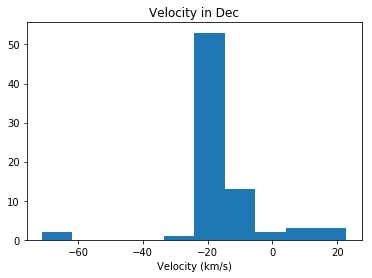

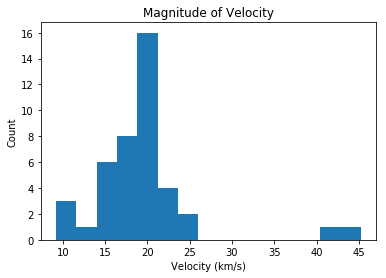

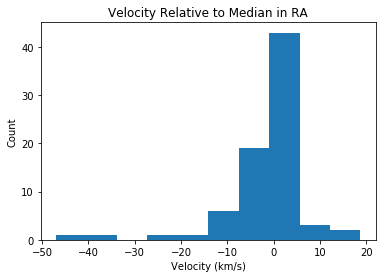

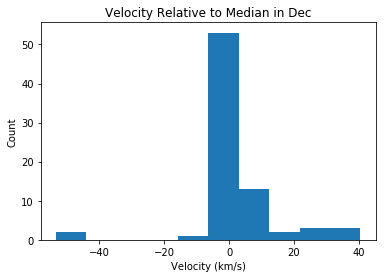

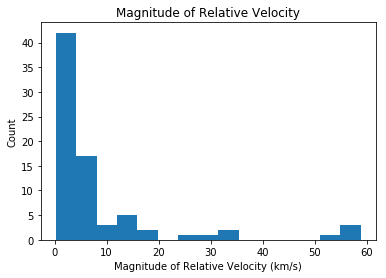

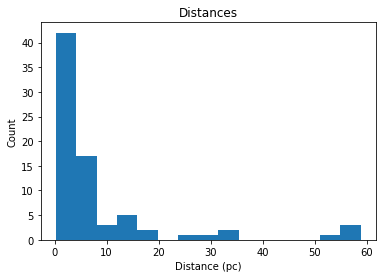

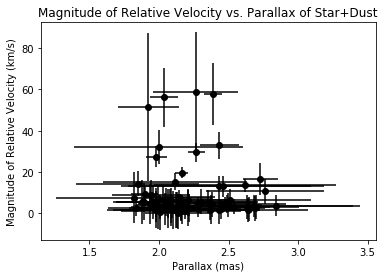

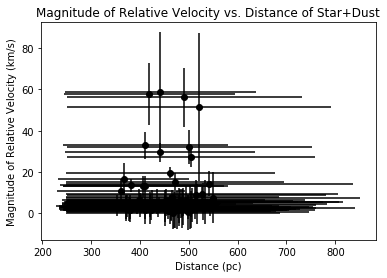

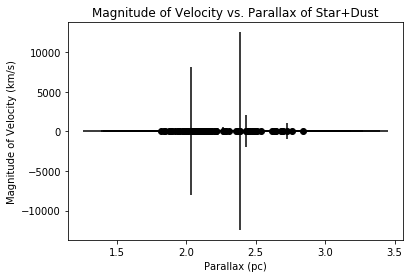

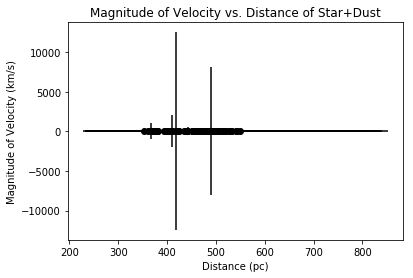

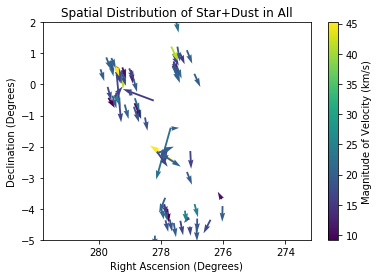

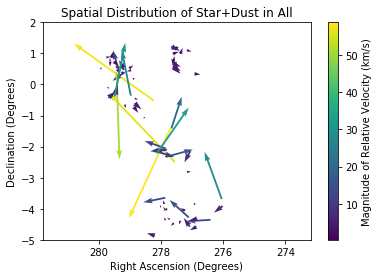

In [17]:
PossibleYSOs = CalculateProperties('All','Star+Dust',SD_match,Gvalues,distance_range=[350.,550.],exclude = notYSOs2)

0
31144
The c2d index is 2
RA:  276.9277545671889
DEC:  0.34393708826403413
The difference in RA is  0.30300188004730444 arcseconds
The difference in Decliantion is  0.816522249477214 arcseconds
The c2d_ID is  SSTc2d J182742.6+002039
alpha is -0.58
The object type is star+dust(MP1)
2MASS ID: b'18274265+0020383'
FLUX SIGNAL TO NOISE
[ 29.03859864 177.61838998  64.00909229  41.75908375  73.07390963
  72.75427682   1.           1.           1.           1.
  10.74168798]
SED Flux
[ 1.41122282e-01  7.34865189e-01  1.96546566e+00  8.77583027e+00
  1.53567600e+01  1.52895880e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.20000000e+01]
SED Flux Error
[ 4.85981721e-03  4.13732603e-03  3.07060387e-02  2.10153803e-01
  2.10153803e-01  2.10153803e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.91000000e+00]
The apparent magnitude in g is: 16.629515
The absolute magnitude in g is: 8.318867056206805
g-K is: 5.0305147
GB-GR is: 3.184679
MIPS 1 IS MISS

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log10
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:322: RuntimeWarning: divide by zero encountered in double_scalars


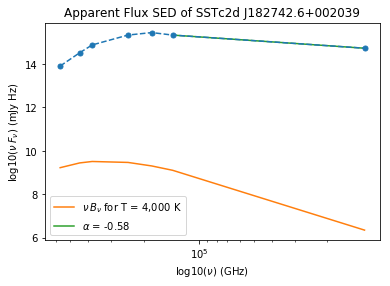

1
59418
2
36252
The c2d index is 54
RA:  277.1684377443844
DEC:  1.1036117893301272
The difference in RA is  0.4317997837688381 arcseconds
The difference in Decliantion is  1.443998411542502 arcseconds
The c2d_ID is  SSTc2d J182840.4+010614
alpha is -0.62
The object type is star+dust(MP1)
2MASS ID: b'18284042+0106131'
FLUX SIGNAL TO NOISE
[ 85.73676808 440.4770228  161.18900553  47.2059239   74.78394114
  89.51658575   1.           1.           1.           1.
  10.73825503]
SED Flux
[   1.1899637     3.80684781    8.84482956   33.42629623   52.9541626
   63.38628006 -999.         -999.         -999.         -999.
  160.        ]
SED Flux Error
[ 1.38792694e-02  8.64255708e-03  5.48724122e-02  7.08095372e-01
  7.08095372e-01  7.08095372e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.49000000e+01]
The apparent magnitude in g is: 14.84362
The absolute magnitude in g is: 6.562418990312192
g-K is: 4.78862
GB-GR is: 2.5028934
MIPS 1 IS MISSING
SED_nu_log
[14.8297287

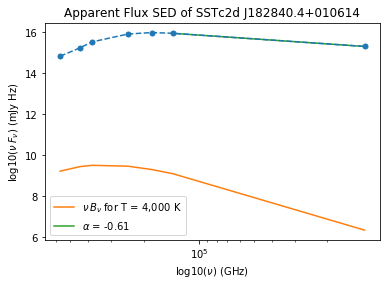

3
35969
The c2d index is 126
RA:  277.37758995268143
DEC:  0.984710952782651
The difference in RA is  0.2104296532479566 arcseconds
The difference in Decliantion is  0.2777299824566981 arcseconds
The c2d_ID is  SSTc2d J182930.6+005905
alpha is -1.36
The object type is Galc_star+dust(IR3)
2MASS ID: b'18293061+0059051'
FLUX SIGNAL TO NOISE
[         nan 171.86841192          nan  30.15933926  50.81984583
  52.98202741  19.69465649  20.37383178  19.69465649  18.01980198
   7.63636364]
SED Flux
[       nan 0.08862604        nan 2.08203721 3.50832653 3.65759182
 2.58       2.18       2.58       1.82       1.68      ]
SED Flux Error
[       nan 0.00051566        nan 0.06903458 0.06903458 0.06903458
 0.131      0.107      0.131      0.101      0.22      ]
The apparent magnitude in g is: 18.92613
The absolute magnitude in g is: 11.193590253144949
g-K is: 5.77413
GB-GR is: --
MIPS 1 IS MISSING
SED_nu_log
[13.5955611  14.70364223 14.80128969 14.7057633  14.3373248  14.16158915
 14.12963673 13.83

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:224: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:265: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:267: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:268: RuntimeWarning: invalid value encountered in gr

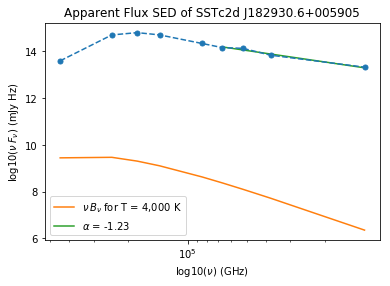

4
35960
5
36072
The c2d index is 171
RA:  277.4643984496426
DEC:  1.1590586258570095
The difference in RA is  0.2579387134346689 arcseconds
The difference in Decliantion is  0.2673869147655772 arcseconds
The c2d_ID is  SSTc2d J182951.4+010933
alpha is -1.53
The object type is star+dust(IR4)
2MASS ID: b'18295145+0109327'
FLUX SIGNAL TO NOISE
[  4.17968696 144.05563475  30.90892781  14.87310006  18.2563326
  60.18790943  19.51807229  18.47025496  19.51807229   9.58568738
   2.56485356]
SED Flux
[0.00893532 0.03843302 0.11480384 0.8631534  1.05949771 3.49297714
 0.81       0.652      0.81       0.509      0.613     ]
SED Flux Error
[0.0021378  0.00026679 0.00371426 0.05803453 0.05803453 0.05803453
 0.0415     0.0353     0.0415     0.0531     0.239     ]
The apparent magnitude in g is: 19.833273
The absolute magnitude in g is: 11.76716428485523
g-K is: 6.6312733
GB-GR is: 3.0971203
SED_nu_log
[12.70530522 13.23270421 13.64004701 14.32124173 14.28128971 14.6857638
 13.83419011 13.63738025 1

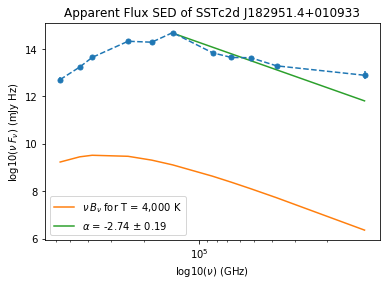

6
36048
The c2d index is 175
RA:  277.4731424679055
DEC:  1.2180645672493626
The difference in RA is  0.002275540191476466 arcseconds
The difference in Decliantion is  0.14123790229438882 arcseconds
The c2d_ID is  SSTc2d J182953.6+011305
alpha is -1.61
The object type is star+dust(IR1)
2MASS ID: b'18295354+0113051'
FLUX SIGNAL TO NOISE
[  3.9215128  339.9267126  133.75176553  26.48137104  34.35205347
  31.88952989  20.12779553  19.89795918  20.12779553  16.41104294
   2.29888268]
SED Flux
[0.0140289  0.12087023 0.35368079 1.7639569  2.2882328  2.12420106
 1.89       1.56       1.89       1.07       0.823     ]
SED Flux Error
[3.57741979e-03 3.55577329e-04 2.64430745e-03 6.66112378e-02
 6.66112378e-02 6.66112378e-02 9.39000000e-02 7.84000000e-02
 9.39000000e-02 6.52000000e-02 3.58000000e-01]
The apparent magnitude in g is: 18.589235
The absolute magnitude in g is: 10.18722182694459
g-K is: 4.8472357
GB-GR is: 3.8289738
SED_nu_log
[12.90121855 13.73031911 14.12870208 14.63164172 14.61568

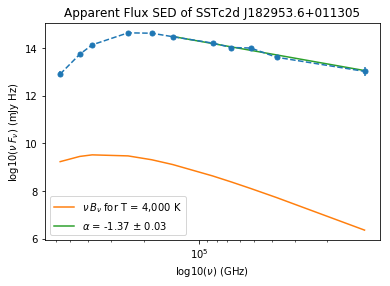

7
27240
The c2d index is 191
RA:  277.5054412557777
DEC:  1.9918776456776908
The difference in RA is  0.011720799716385955 arcseconds
The difference in Decliantion is  0.18487556031345775 arcseconds
The c2d_ID is  SSTc2d J183001.3+015931
alpha is -1.66
The object type is star+dust(MP1)
2MASS ID: b'18300130+0159309'
FLUX SIGNAL TO NOISE
[ 15.42250723 258.66510666 155.74158064  38.77629181  46.90052918
  43.02033208   1.           1.           1.           1.
   5.20547945]
SED Flux
[ 4.47309762e-02  3.12551975e-01  9.57972705e-01  5.01289272e+00
  6.06317186e+00  5.56155062e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.14000000e+00]
SED Flux Error
[ 2.90036993e-03  1.20832678e-03  6.15104008e-03  1.29277259e-01
  1.29277259e-01  1.29277259e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.19000000e-01]
The apparent magnitude in g is: 17.557728
The absolute magnitude in g is: 9.440492968832926
g-K is: 4.8607283
GB-GR is: 3.651865
MIPS 1 IS 

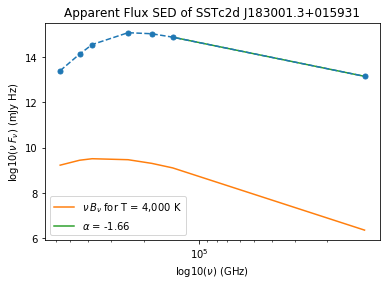

8
32426
The c2d index is 193
RA:  277.5065103096611
DEC:  0.6260335108364313
The difference in RA is  0.14187477995619702 arcseconds
The difference in Decliantion is  0.26564098884733767 arcseconds
The c2d_ID is  SSTc2d J183001.6+003734
alpha is -1.82
The object type is star+dust(IR2)
2MASS ID: b'18300155+0037338'
FLUX SIGNAL TO NOISE
[  5.90611063 336.73796086  81.62232186  40.21245207  55.07721216
  55.80427497   1.          18.41584158   1.          18.13084112
   6.06965174]
SED Flux
[ 1.71943288e-02  1.36876017e-01  4.63750511e-01  4.52573013e+00
  6.19869184e+00  6.28051949e+00 -9.99000000e+02  3.72000000e+00
 -9.99000000e+02  1.94000000e+00  1.22000000e+00]
SED Flux Error
[ 2.91127781e-03  4.06476349e-04  5.68166282e-03  1.12545490e-01
  1.12545490e-01  1.12545490e-01 -9.99000000e+02  2.02000000e-01
 -9.99000000e+02  1.07000000e-01  2.01000000e-01]
The apparent magnitude in g is: 18.454216
The absolute magnitude in g is: 10.031011320506334
g-K is: 5.8892164
GB-GR is: 3.9022503
M

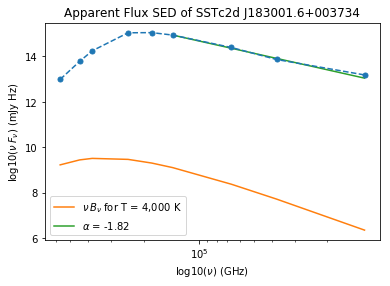

9
32502
10
32498
The c2d index is 217
RA:  277.5826238032912
DEC:  0.6741813016664934
The difference in RA is  0.18001184839704365 arcseconds
The difference in Decliantion is  0.2728740006240571 arcseconds
The c2d_ID is  SSTc2d J183019.8+004027
alpha is -0.95
The object type is star+dust(MP1)
2MASS ID: b'18301981+0040271'
FLUX SIGNAL TO NOISE
[  7.52557612 252.4547425   87.67563342  20.87954373  26.86164656
  24.6166005    1.           1.           1.           1.
   6.99029126]
SED Flux
[ 1.67958103e-02  8.73470083e-02  2.63311386e-01  1.61468685e+00
  2.07730341e+00  1.90368629e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.16000000e+00]
SED Flux Error
[ 2.23183050e-03  3.45990760e-04  3.00324475e-03  7.73334354e-02
  7.73334354e-02  7.73334354e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.09000000e-01]
The apparent magnitude in g is: 18.941914
The absolute magnitude in g is: 11.084736197013612
g-K is: 5.0809135
GB-GR is: 3.3131752
M

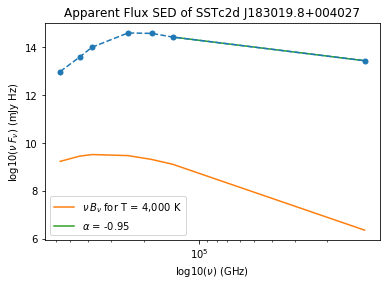

11
32542
The c2d index is 219
RA:  277.5831157195666
DEC:  0.69782558336132
The difference in RA is  0.4774304398097229 arcseconds
The difference in Decliantion is  1.093379899248026 arcseconds
The c2d_ID is  SSTc2d J183019.9+004153
alpha is -1.37
The object type is star+dust(MP1)
2MASS ID: b'18301993+0041522'
FLUX SIGNAL TO NOISE
[ 31.8187775  819.99822294 172.28847462  43.4294479   95.76264851
 118.9300395    1.           1.           1.           1.
  10.79365079]
SED Flux
[ 1.07878879e-01  8.65078747e-01  2.62540030e+00  2.42822056e+01
  5.35426636e+01  6.64959793e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.72000000e+01]
SED Flux Error
[ 3.39041557e-03  1.05497637e-03  1.52383978e-02  5.59118450e-01
  5.59118450e-01  5.59118450e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.52000000e+00]
The apparent magnitude in g is: 16.452394
The absolute magnitude in g is: 7.822373559420198
g-K is: 6.449394
GB-GR is: 3.7906513
MIPS 1 IS MISSI

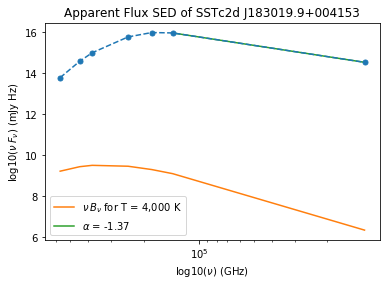

12
32576
The c2d index is 223
RA:  277.5937949799801
DEC:  0.554748501394243
The difference in RA is  0.37972792838445457 arcseconds
The difference in Decliantion is  0.1072850192748831 arcseconds
The c2d_ID is  SSTc2d J183022.5+003317
alpha is -1.15
The object type is star+dust(MP1)
2MASS ID: b'18302250+0033170'
FLUX SIGNAL TO NOISE
[ 26.73129127 243.50933278  83.15236691  40.21245047  77.7270901
  79.77520801   1.           1.           1.           1.
  10.53551913]
SED Flux
[ 4.21220176e-02  2.96949476e-01  8.68513048e-01  6.99661684e+00
  1.35238380e+01  1.38801928e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  9.64000000e+00]
SED Flux Error
[ 1.57575693e-03  1.21945830e-03  1.04448386e-02  1.73991308e-01
  1.73991308e-01  1.73991308e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  9.15000000e-01]
The apparent magnitude in g is: 17.613327
The absolute magnitude in g is: 8.998906259345292
g-K is: 5.9093266
GB-GR is: 3.610672
MIPS 1 IS MIS

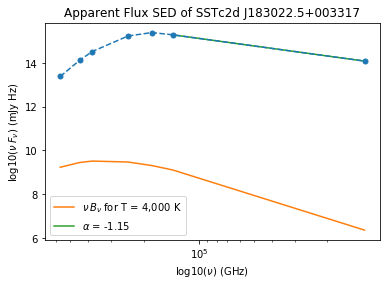

13
35649
The c2d index is 224
RA:  277.59485632008517
DEC:  0.7436656015324985
The difference in RA is  0.3978723066211387 arcseconds
The difference in Decliantion is  1.0943944830054342 arcseconds
The c2d_ID is  SSTc2d J183022.7+004438
alpha is -1.07
The object type is star+dust(MP1)
2MASS ID: b'18302275+0044373'
FLUX SIGNAL TO NOISE
[21.68054839 52.83459242 61.84862554 41.75908604 79.31631558 83.22584445
  1.          1.          1.          1.         10.70921986]
SED Flux
[ 1.74035221e-01  7.44925499e-01  2.12371302e+00  9.04666519e+00
  1.71830425e+01  1.80300007e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.51000000e+01]
SED Flux Error
[ 8.02725181e-03  1.40992003e-02  3.43372710e-02  2.16639444e-01
  2.16639444e-01  2.16639444e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.41000000e+00]
The apparent magnitude in g is: 16.614752
The absolute magnitude in g is: 8.714431115697057
g-K is: 5.1947517
GB-GR is: 3.041151
MIPS 1 IS MISSI

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:322: RuntimeWarning: invalid value encountered in double_scalars


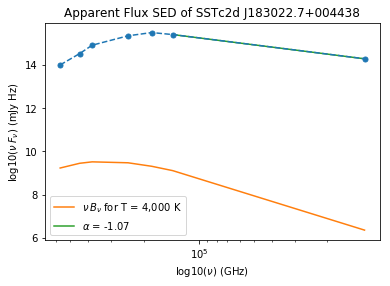

14
32544
The c2d index is 228
RA:  277.5970574888583
DEC:  0.7079368243552621
The difference in RA is  0.439879889927397 arcseconds
The difference in Decliantion is  1.1612723210565168 arcseconds
The c2d_ID is  SSTc2d J183023.3+004230
alpha is -0.66
The object type is star+dust(MP1)
2MASS ID: b'18302328+0042286'
FLUX SIGNAL TO NOISE
[12.0828505  50.13993949 16.34960855 29.34422015 71.53753264 93.63319915
  1.          1.          1.          1.         10.72463768]
SED Flux
[ 1.76938418e-02  1.64291948e-01  5.13468623e-01  2.02343082e+00
  4.93287086e+00  6.45647764e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.48000000e+01]
SED Flux Error
[ 1.46437646e-03  3.27666826e-03  3.14055607e-02  6.89550042e-02
  6.89550042e-02  6.89550042e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.38000000e+00]
The apparent magnitude in g is: 18.255993
The absolute magnitude in g is: 10.049349933554664
g-K is: 5.720993
GB-GR is: 3.9817333
MIPS 1 IS MISSIN

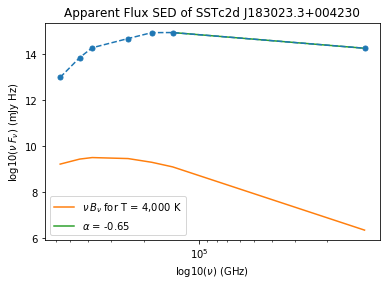

15
35717
The c2d index is 235
RA:  277.6183538088804
DEC:  0.9869077752440374
The difference in RA is  0.3096319693440819 arcseconds
The difference in Decliantion is  0.33308912146559067 arcseconds
The c2d_ID is  SSTc2d J183028.4+005913
alpha is -1.99
The object type is star+dust(MP1)
2MASS ID: b'18302839+0059130'
FLUX SIGNAL TO NOISE
[ 13.16723996 137.54235673  45.22699603  27.83938787  49.16671911
  46.66237642   1.          20.08196721   1.          15.
   4.58498024]
SED Flux
[ 2.93260794e-02  1.62585959e-01  4.73133117e-01  2.93013978e+00
  5.17487526e+00  4.91128922e+00 -9.99000000e+02  1.96000000e+00
 -9.99000000e+02  8.91000000e-01  1.16000000e+00]
SED Flux Error
[ 2.22720020e-03  1.18207920e-03  1.04612987e-02  1.05251588e-01
  1.05251588e-01  1.05251588e-01 -9.99000000e+02  9.76000000e-02
 -9.99000000e+02  5.94000000e-02  2.53000000e-01]
The apparent magnitude in g is: 18.267326
The absolute magnitude in g is: 9.921186216345564
g-K is: 5.4353266
GB-GR is: 3.344326
MIPS 1 IS M

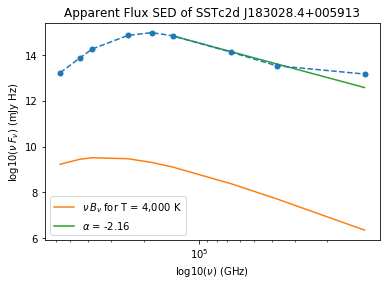

16
32237
The c2d index is 238
RA:  277.62442731497123
DEC:  0.5833703048274473
The difference in RA is  0.295973896322721 arcseconds
The difference in Decliantion is  0.6170226211897667 arcseconds
The c2d_ID is  SSTc2d J183029.8+003501
alpha is -1.02
The object type is star+dust(MP1)
2MASS ID: b'18302986+0035004'
FLUX SIGNAL TO NOISE
[ 85.54108028 320.58917786  71.44629568  43.42944933  66.92611346
  62.30052848   1.           1.           1.           1.
  10.78838174]
SED Flux
[ 4.53665465e-01  1.70479023e+00  4.25401783e+00  1.90936279e+01
  2.94238663e+01  2.73902416e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.60000000e+01]
SED Flux Error
[ 5.30348066e-03  5.31767868e-03  5.95414750e-02  4.39647019e-01
  4.39647019e-01  4.39647019e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.41000000e+00]
The apparent magnitude in g is: 15.715857
The absolute magnitude in g is: 7.277800932234671
g-K is: 4.749857
GB-GR is: 2.7551622
MIPS 1 IS MI

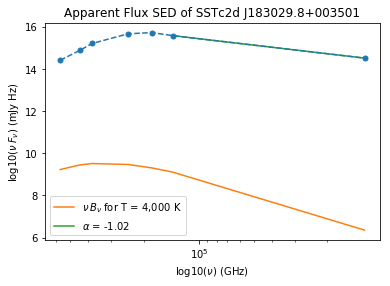

17
36074
The c2d index is 251
RA:  277.67157303856914
DEC:  1.2209640786578548
The difference in RA is  0.3432188487977328 arcseconds
The difference in Decliantion is  0.294916831722869 arcseconds
The c2d_ID is  SSTc2d J183041.2+011316
alpha is -0.99
The object type is star+dust(IR1)
2MASS ID: b'18304116+0113156'
FLUX SIGNAL TO NOISE
[  2.75547687 205.99412867  93.40286255  28.57200745  37.51046156
  38.14588714  20.06493506  19.85714286  20.06493506  19.63855422
   1.        ]
SED Flux
[ 6.55432791e-02  9.13170353e-02  3.14735770e-01  2.51702976e+00
  3.30445623e+00  3.36043358e+00  3.09000000e+00  2.78000000e+00
  3.09000000e+00  3.26000000e+00 -9.99000000e+02]
SED Flux Error
[ 2.37865467e-02  4.43299214e-04  3.36965872e-03  8.80942568e-02
  8.80942568e-02  8.80942568e-02  1.54000000e-01  1.40000000e-01
  1.54000000e-01  1.66000000e-01 -9.99000000e+02]
The apparent magnitude in g is: 18.893654
The absolute magnitude in g is: 10.70707591235668
g-K is: 5.6496534
GB-GR is: 2.0285492
MIP

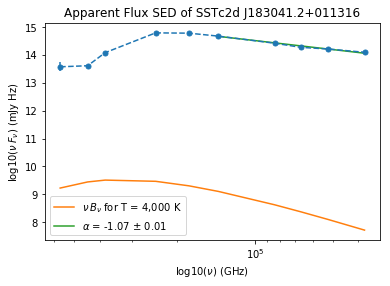

18
26154
The GB index 891
RA:  276.0200107684489
DEC:  -3.9138430944305855
The difference in RA is  0.763 arcseconds
The difference in Dec is  0.167 arcseconds
The Gould_Belt_ID is  SSTGBS J182404.8-035450
alpha is -1.37
The object type is star+dust(MP1)
2MASS ID: b'18240480-0354497'
FLUX SIGNAL TO NOISE
[4.01556391e+02 1.74686640e+03 1.00175520e+03 4.02124523e+01
 4.33882731e+01 3.41246546e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.07812500e+01]
SED Flux
[   6.64235687   16.15776443   32.98830414   79.30271912   85.56573486
   67.29701233 -999.         -999.         -999.         -999.
   27.6       ]
SED Flux Error
[ 1.65415294e-02  9.24957078e-03  3.29305045e-02  1.97209358e+00
  1.97209358e+00  1.97209358e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.56000000e+00]
The apparent magnitude in g is: 13.274081
The absolute magnitude in g is: 4.807003193414072
g-K is: 3.2840815
GB-GR is: 2.0650978
MIPS 1 IS MISSING
SED_nu_log
[15.57651721

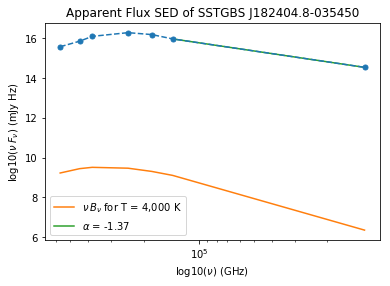

19
26393
The GB index 893
RA:  276.0454877517486
DEC:  -3.688459975743996
The difference in RA is  0.533 arcseconds
The difference in Dec is  0.011 arcseconds
The Gould_Belt_ID is  SSTGBS J182410.9-034118
alpha is -2.25
The object type is star+dust(MP1)
2MASS ID: b'18241092-0341185'
FLUX SIGNAL TO NOISE
[8.01572900e+02 5.02114250e+03 7.05159282e+02 3.74391814e+01
 3.36928665e+01 2.79275971e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.02307692e+01]
SED Flux
[  25.57146835   53.12622452   97.76205444  180.67092896  162.5922699
  134.77070618 -999.         -999.         -999.         -999.
    6.65      ]
SED Flux Error
[ 3.19016129e-02  1.05805052e-02  1.38638258e-01  4.82571793e+00
  4.82571793e+00  4.82571793e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  6.50000000e-01]
The apparent magnitude in g is: 11.981761
The absolute magnitude in g is: 3.7610077288642643
g-K is: 2.745761
GB-GR is: 1.7810402
MIPS 1 IS MISSING
SED_nu_log
[16.16195067 1

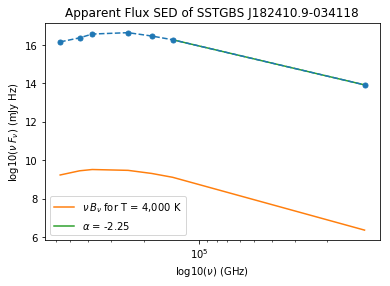

20
10039
The GB index 989
RA:  276.40700484435126
DEC:  -4.355785103218235
The difference in RA is  0.157 arcseconds
The difference in Dec is  0.159 arcseconds
The Gould_Belt_ID is  SSTGBS J182537.7-042121
alpha is -0.98
The object type is star+dust(MP1)
2MASS ID: b'18253769-0421209'
FLUX SIGNAL TO NOISE
[ 10.25735413 226.47350049  29.95262228  14.67211133  22.56858168
  19.21321885   1.           1.           1.           1.
   3.12676056]
SED Flux
[ 1.76857226e-02  5.71725368e-02  1.69941440e-01  8.12996030e-01
  1.25054717e+00  1.06462324e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.11000000e+00]
SED Flux Error
[ 1.72419928e-03  2.52446916e-04  5.67367487e-03  5.54109775e-02
  5.54109775e-02  5.54109775e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.55000000e-01]
The apparent magnitude in g is: 19.402065
The absolute magnitude in g is: 10.732592570810864
g-K is: 4.9100657
GB-GR is: 2.7816963
MIPS 1 IS MISSING
SED_nu_log
[13.0018178

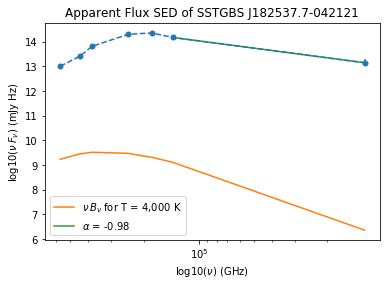

21
11550
The GB index 1185
RA:  276.8365334025829
DEC:  -4.316848306380546
The difference in RA is  0.066 arcseconds
The difference in Dec is  0.15 arcseconds
The Gould_Belt_ID is  SSTGBS J182720.8-041901
alpha is -1.32
The object type is star+dust(IR3)
2MASS ID: b'18272077-0419005'
FLUX SIGNAL TO NOISE
[  5.43323103 242.54258661  41.31325016  27.14340549  41.52178562
  37.56397378  15.42424242   1.          15.42424242   1.
   7.75193798]
SED Flux
[ 9.12955329e-02  3.68705064e-01  1.15366757e+00  6.15585566e+00
  9.41672993e+00  8.51913738e+00  5.09000000e+00 -9.99000000e+02
  5.09000000e+00 -9.99000000e+02  4.00000000e+00]
SED Flux Error
[ 1.68031752e-02  1.52016629e-03  2.79248804e-02  2.26790100e-01
  2.26790100e-01  2.26790100e-01  3.30000000e-01 -9.99000000e+02
  3.30000000e-01 -9.99000000e+02  5.16000000e-01]
The apparent magnitude in g is: 17.378336
The absolute magnitude in g is: 9.34787648106138
g-K is: 5.1443357
GB-GR is: 3.0790815
MIPS 1 IS MISSING
SED_nu_log
[13.71464453 1

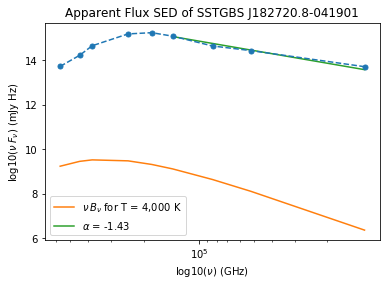

22
10931
The GB index 1213
RA:  276.8586359925115
DEC:  -4.5798945359883545
The difference in RA is  0.422 arcseconds
The difference in Dec is  0.457 arcseconds
The Gould_Belt_ID is  SSTGBS J182726.0-043447
alpha is -0.53
The object type is star+dust(MP1)
2MASS ID: b'18272608-0434473'
FLUX SIGNAL TO NOISE
[ 76.70331826 340.31927387 135.90629624  51.70172423  60.49461373
  73.89454522   1.           1.           1.           1.
   9.79522184]
SED Flux
[ 100.95787811  195.17488098  345.18954468  653.56414795  764.71551514
  934.10473633 -999.         -999.         -999.         -999.
 2870.        ]
SED Flux Error
[ 1.31621265e+00  5.73505223e-01  2.53990841e+00  1.26410513e+01
  1.26410513e+01  1.26410513e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.93000000e+02]
The apparent magnitude in g is: 10.5689745
The absolute magnitude in g is: 2.5476234271628257
g-K is: 3.4349747
GB-GR is: 1.6597977
MIPS 1 IS MISSING
SED_nu_log
[16.75833522 16.93842367 17.11814825 17

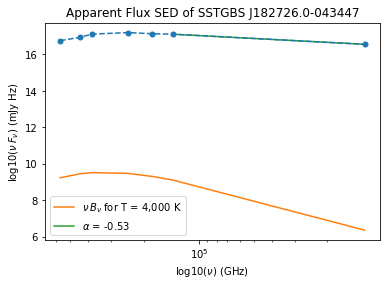

23
12391
The GB index 1280
RA:  276.9202852655942
DEC:  -3.8498061108230344
The difference in RA is  0.032 arcseconds
The difference in Dec is  0.046 arcseconds
The Gould_Belt_ID is  SSTGBS J182740.9-035059
alpha is -0.81
The object type is star+dust(IR3)
2MASS ID: b'18274086-0350593'
FLUX SIGNAL TO NOISE
[  5.32351347 187.32009382  61.36478659  37.4391814   78.40391513
  85.82891729  18.43065693  17.6744186   18.43065693  12.2556391
   2.47663551]
SED Flux
[1.99413020e-02 1.76992908e-01 6.08111978e-01 6.17289162e+00
 1.29270687e+01 1.41512871e+01 1.01000000e+01 8.36000000e+00
 1.01000000e+01 1.63000000e+01 5.30000000e+01]
SED Flux Error
[3.74589115e-03 9.44868778e-04 9.90978722e-03 1.64877847e-01
 1.64877847e-01 1.64877847e-01 5.48000000e-01 4.73000000e-01
 5.48000000e-01 1.33000000e+00 2.14000000e+01]
The apparent magnitude in g is: 18.175144
The absolute magnitude in g is: 9.822663751937743
g-K is: 6.4921446
GB-GR is: 4.0355797
SED_nu_log
[13.05394852 13.89595561 14.36407417 15.1756

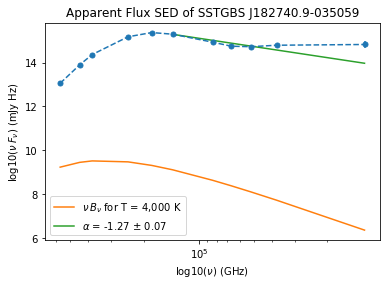

24
5732
The GB index 1401
RA:  277.0572834711105
DEC:  -2.142441674558036
The difference in RA is  0.039 arcseconds
The difference in Dec is  0.004 arcseconds
The Gould_Belt_ID is  SSTGBS J182813.7-020833
alpha is -1.16
The object type is Galc_star+dust(IR3)
2MASS ID: b'18281374-0208327'
FLUX SIGNAL TO NOISE
[  4.24222779 175.69303586  32.25421842  22.61950384  40.84085127
  41.15194837  19.61538462  20.61349693  19.61538462  19.40144479
   5.86206897]
SED Flux
[0.01214783 0.03351985 0.11778153 1.45240688 2.62240648 2.64238214
 2.04       1.68       2.04       1.88       1.7       ]
SED Flux Error
[2.86354986e-03 1.90786421e-04 3.65166296e-03 6.42103776e-02
 6.42103776e-02 6.42103776e-02 1.04000000e-01 8.15000000e-02
 1.04000000e-01 9.69000000e-02 2.90000000e-01]
The apparent magnitude in g is: 19.98178
The absolute magnitude in g is: 11.282124021830194
g-K is: 6.476779
GB-GR is: 2.7914486
SED_nu_log
[12.83869374 13.17330176 13.65116782 14.54724204 14.67488969 14.56456369
 14.23533526 

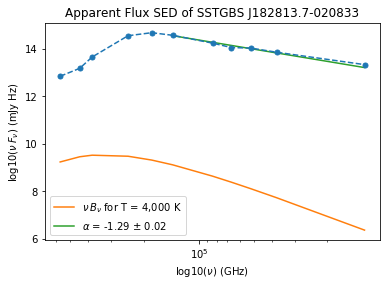

25
9989
The GB index 1414
RA:  277.074417519472
DEC:  -4.574346488967392
The difference in RA is  0.113 arcseconds
The difference in Dec is  0.101 arcseconds
The Gould_Belt_ID is  SSTGBS J182817.9-043428
alpha is -2.31
The object type is star+dust(MP1)
2MASS ID: b'18281786-0434275'
FLUX SIGNAL TO NOISE
[1.21759963e+03 4.66283663e+03 8.88643485e+02 4.93516449e+01
 3.95105767e+01 2.92421097e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.00906344e+00]
SED Flux
[  19.18312073   33.4005928    55.13389587   90.96795654   72.82830048
   53.90083694 -999.         -999.         -999.         -999.
    2.32      ]
SED Flux Error
[ 1.57548673e-02  7.16314884e-03  6.20427616e-02  1.84326088e+00
  1.84326088e+00  1.84326088e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.31000000e-01]
The apparent magnitude in g is: 12.485648
The absolute magnitude in g is: 4.071510398055562
g-K is: 2.2546482
GB-GR is: 1.4712524
MIPS 1 IS MISSING
SED_nu_log
[16.03711427 1

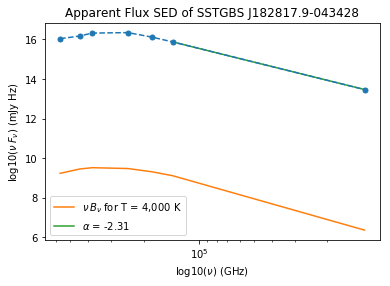

26
10829
The GB index 1437
RA:  277.1055878296834
DEC:  -4.280083195775563
The difference in RA is  0.051 arcseconds
The difference in Dec is  0.03 arcseconds
The Gould_Belt_ID is  SSTGBS J182825.3-041648
alpha is -1.99
The object type is star+dust(MP1)
2MASS ID: b'18282533-0416483'
FLUX SIGNAL TO NOISE
[  3.02819226  76.63108403  21.54587034  47.20592314 172.11088062
 273.34071272  20.29478458   1.          20.29478458   1.
  10.77272727]
SED Flux
[ 1.90099739e-02  1.30176917e-01  6.23330116e-01  3.69903069e+01
  1.34865158e+02  2.14188309e+02  1.79000000e+02 -9.99000000e+02
  1.79000000e+02 -9.99000000e+02  2.37000000e+01]
SED Flux Error
[ 6.27766410e-03  1.69874821e-03  2.89303754e-02  7.83594608e-01
  7.83594608e-01  7.83594608e-01  8.82000000e+00 -9.99000000e+02
  8.82000000e+00 -9.99000000e+02  2.20000000e+00]
The apparent magnitude in g is: 18.5087
The absolute magnitude in g is: 10.136720614550976
g-K is: 9.7757
GB-GR is: 4.1143456
MIPS 1 IS MISSING
SED_nu_log
[13.03317653 13.7

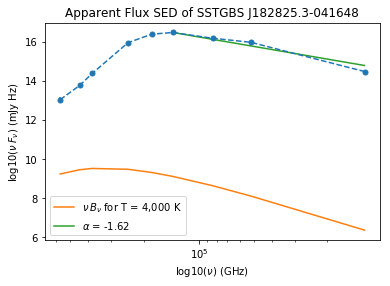

27
2374
The GB index 1470
RA:  277.1662064999018
DEC:  -2.8153965444062554
The difference in RA is  0.041 arcseconds
The difference in Dec is  0.051 arcseconds
The Gould_Belt_ID is  SSTGBS J182839.9-024855
alpha is -1.71
The object type is star+dust(IR4)
2MASS ID: b'18283988-0248553'
FLUX SIGNAL TO NOISE
[ 16.19448352 846.25826322 167.36247608  41.75908278  67.19894863
  64.66326766  12.3986095   14.85106383  12.3986095   13.1588785
  -1.03703704]
SED Flux
[  0.07398315   0.52635443   1.53641653  12.13636684  19.52990913
  18.79296875  10.7          6.98        10.7          7.04
 -22.4       ]
SED Flux Error
[4.56841663e-03 6.21978485e-04 9.18017328e-03 2.90628195e-01
 2.90628195e-01 2.90628195e-01 8.63000000e-01 4.70000000e-01
 8.63000000e-01 5.35000000e-01 2.16000000e+01]
The apparent magnitude in g is: 16.991838
The absolute magnitude in g is: 8.473765012994624
g-K is: 5.6168385
GB-GR is: 3.6184444
MIPS 1 IS MISSING
SED_nu_log
[13.62332781 14.36927803 14.76659958 15.46924244 15.546

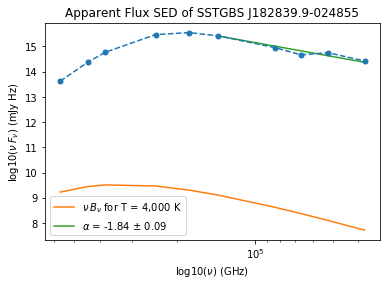

28
10935
The GB index 1506
RA:  277.2300609043041
DEC:  -4.061409873104111
The difference in RA is  0.091 arcseconds
The difference in Dec is  0.207 arcseconds
The Gould_Belt_ID is  SSTGBS J182855.2-040341
alpha is -0.9
The object type is star+dust(IR3)
2MASS ID: b'18285520-0403410'
FLUX SIGNAL TO NOISE
[ 28.95932647 144.0360618   52.06221658  47.20592386  82.15007862
 101.93042805  20.03636364   1.          20.03636364   1.
  10.73264781]
SED Flux
[ 9.38286841e-01  3.47331667e+00  8.92970181e+00  2.80342178e+01
  4.87865295e+01  6.05335007e+01  5.51000000e+01 -9.99000000e+02
  5.51000000e+01 -9.99000000e+02  8.35000000e+01]
SED Flux Error
[ 3.24001610e-02  2.41142157e-02  1.71519816e-01  5.93870759e-01
  5.93870759e-01  5.93870759e-01  2.75000000e+00 -9.99000000e+02
  2.75000000e+00 -9.99000000e+02  7.78000000e+00]
The apparent magnitude in g is: 14.943172
The absolute magnitude in g is: 6.967183094557843
g-K is: 4.838173
GB-GR is: 2.7712574
MIPS 1 IS MISSING
SED_nu_log
[14.72653063 1

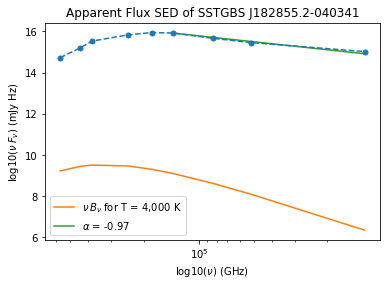

29
10976
The GB index 1627
RA:  277.37861048384514
DEC:  -4.387455560507114
The difference in RA is  0.923 arcseconds
The difference in Dec is  0.019 arcseconds
The Gould_Belt_ID is  SSTGBS J182930.8-042315
alpha is -0.91
The object type is star+dust(MP1)
2MASS ID: b'18293086-0423146'
FLUX SIGNAL TO NOISE
[21.48312048 49.80645319 18.7530949  40.21245324 57.88581445 56.52850002
  1.          1.          1.          1.         10.7967033 ]
SED Flux
[ 8.20794582e-01  2.36585808e+00  5.68266678e+00  2.26406212e+01
  3.25911674e+01  3.18269653e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.93000000e+01]
SED Flux Error
[ 3.82064879e-02  4.75010350e-02  3.03025544e-01  5.63025117e-01
  5.63025117e-01  5.63025117e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.64000000e+00]
The apparent magnitude in g is: 15.360063
The absolute magnitude in g is: 7.083691902596717
g-K is: 4.557062
GB-GR is: 2.4257975
MIPS 1 IS MISSING
SED_nu_log
[14.66842949 15.

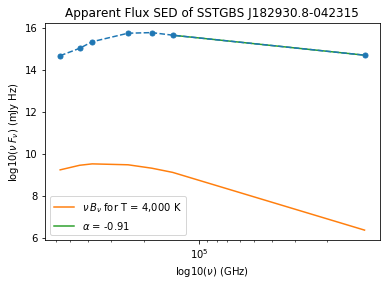

30
3784
The GB index 1764
RA:  277.5502544771099
DEC:  -2.502578917813625
The difference in RA is  0.195 arcseconds
The difference in Dec is  0.144 arcseconds
The Gould_Belt_ID is  SSTGBS J183012.1-023009
alpha is -1.84
The object type is star+dust(IR3)
2MASS ID: b'18301208-0230093'
FLUX SIGNAL TO NOISE
[5.30746594e+01 9.95411661e+02 1.59670653e+02 3.74391792e+01
 5.10431940e+01 4.27792864e+01 1.65882353e+01 1.45263158e+01
 1.65882353e+01 1.20765027e+01 2.94117647e-02]
SED Flux
[0.24409601 0.80779737 1.85535574 6.44597149 8.78819942 7.36538744
 4.23       2.76       4.23       2.21       0.0105    ]
SED Flux Error
[0.00459911 0.00081152 0.01161989 0.17217182 0.17217182 0.17217182
 0.255      0.19       0.255      0.183      0.357     ]
The apparent magnitude in g is: 16.526777
The absolute magnitude in g is: 8.072333445917508
g-K is: 4.134777
GB-GR is: 2.5271702
SED_nu_log
[14.14175569 14.55530218 14.84851781 15.19444213 15.20008959 15.00976366
 14.55204546 14.26404174 14.34435739 13.9

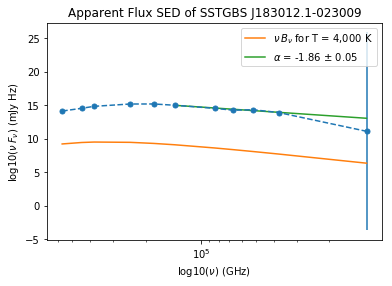

31
4157
The GB index 1799
RA:  277.588495556125
DEC:  -4.4605089120560635
The difference in RA is  0.269 arcseconds
The difference in Dec is  0.801 arcseconds
The Gould_Belt_ID is  SSTGBS J183021.2-042737
alpha is -0.41
The object type is star+dust(MP1)
2MASS ID: b'18302124-0427375'
FLUX SIGNAL TO NOISE
[4.32156183e+02 2.27179330e+03 5.36062555e+02 4.72059191e+01
 5.39769291e+01 4.64198593e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.08033241e+01]
SED Flux
[   5.85414553   16.04335403   34.44493866   95.16742706  108.81782532
   93.58272552 -999.         -999.         -999.         -999.
  390.        ]
SED Flux Error
[ 1.35463653e-02  7.06197787e-03  6.42554462e-02  2.01600623e+00
  2.01600623e+00  2.01600623e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.61000000e+01]
The apparent magnitude in g is: 13.2817955
The absolute magnitude in g is: 5.006226662565902
g-K is: 3.6497955
GB-GR is: 2.2491589
MIPS 1 IS MISSING
SED_nu_log
[15.52165852

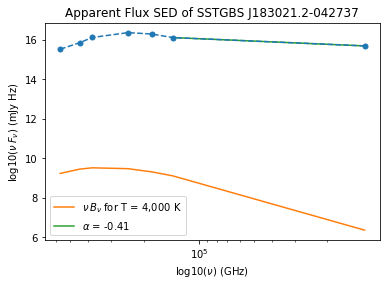

32
47459
The GB index 1880
RA:  277.66835048537
DEC:  -1.4180093677877597
The difference in RA is  0.212 arcseconds
The difference in Dec is  0.069 arcseconds
The Gould_Belt_ID is  SSTGBS J183040.4-012505
alpha is -1.93
The object type is star+dust(MP1)
2MASS ID: b'18304039-0125049'
FLUX SIGNAL TO NOISE
[ 177.03028744 1619.00929858  381.25186869   10.64447348   12.67463484
   11.51943841   13.77880184   13.91304348   13.77880184   -3.968
    3.97435897]
SED Flux
[ 0.68661326  1.5096209   2.86363149  6.9773159   8.30806065  7.55084419
  2.99        1.92        2.99       -2.48        1.55      ]
SED Flux Error
[0.00387851 0.00093243 0.00751113 0.65548718 0.65548718 0.65548718
 0.217      0.138      0.217      0.625      0.39      ]
The apparent magnitude in g is: 15.847864
The absolute magnitude in g is: 7.5236163156187335
g-K is: 3.4828644
GB-GR is: 1.8755159
MIPS 1 IS MISSING
SED_nu_log
[14.59090719 14.82686765 15.03700774 15.22884213 15.17568934 15.02056357
 14.40137628 14.10643388 1

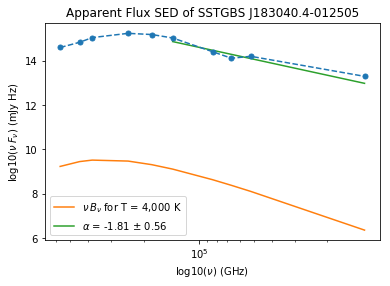

33
47465
The GB index 1907
RA:  277.68874294609844
DEC:  -1.3897714565944583
The difference in RA is  0.529 arcseconds
The difference in Dec is  0.466 arcseconds
The Gould_Belt_ID is  SSTGBS J183045.3-012323
alpha is -1.39
The object type is star+dust(IR4)
2MASS ID: b'18304531-0123225'
FLUX SIGNAL TO NOISE
[  6.49712569 245.86393577  44.61954098   9.60828479  15.82186325
  14.22175301   5.61068702   6.8852459    5.61068702  11.23647604
  -0.36319703]
SED Flux
[ 0.01151949  0.05606534  0.15562826  0.9756369   1.6065712   1.44409406
  0.735       0.546       0.735       0.727      -0.0977    ]
SED Flux Error
[1.77301280e-03 2.28034027e-04 3.48789478e-03 1.01541214e-01
 1.01541214e-01 1.01541214e-01 1.31000000e-01 7.93000000e-02
 1.31000000e-01 6.47000000e-02 2.69000000e-01]
The apparent magnitude in g is: 19.423298
The absolute magnitude in g is: 11.197269235386472
g-K is: 5.2622976
GB-GR is: 3.1516418
MIPS 1 IS MISSING
SED_nu_log
[12.81562815 13.39669423 13.77217909 14.37444196 14.46208

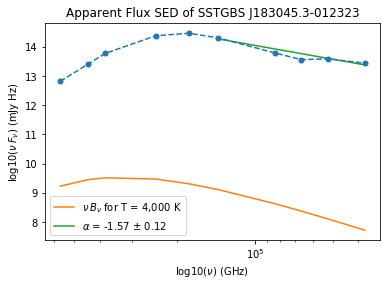

34
4060
The GB index 1956
RA:  277.717564748742
DEC:  -4.345782779953684
The difference in RA is  0.06 arcseconds
The difference in Dec is  0.028 arcseconds
The Gould_Belt_ID is  SSTGBS J183052.2-042045
alpha is -1.82
The object type is star+dust(MP1)
2MASS ID: b'18305221-0420447'
FLUX SIGNAL TO NOISE
[ 25.99996775 313.95000745 144.61022269  41.7590853   60.05684549
  53.29157343   1.           1.           1.           1.
   6.47887324]
SED Flux
[ 1.69686005e-01  8.02866995e-01  2.19355345e+00  1.04349003e+01
  1.50072060e+01  1.33166771e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.84000000e+00]
SED Flux Error
[ 6.52639288e-03  2.55730841e-03  1.51687302e-02  2.49883354e-01
  2.49883354e-01  2.49883354e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.84000000e-01]
The apparent magnitude in g is: 16.533424
The absolute magnitude in g is: 8.472605575179083
g-K is: 4.784425
GB-GR is: 3.1037588
MIPS 1 IS MISSING
SED_nu_log
[13.98384103 14.

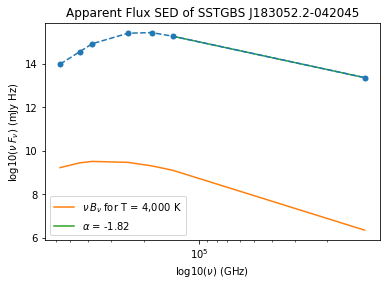

35
27828
The GB index 2079
RA:  277.799036683928
DEC:  -4.005380132320037
The difference in RA is  0.023 arcseconds
The difference in Dec is  0.225 arcseconds
The Gould_Belt_ID is  SSTGBS J183111.8-040019
alpha is -0.85
The object type is star+dust(IR3)
2MASS ID: b'18311177-0400190'
FLUX SIGNAL TO NOISE
[4.97421185e+02 1.75950157e+03 9.53471932e+02 4.17590855e+01
 3.77192357e+01 2.83830088e+01 1.98518519e+01 1.00000000e+00
 1.98518519e+01 1.00000000e+00 1.07834101e+01]
SED Flux
[   9.5062561    19.6524868    36.65051651   73.80539703   66.66532898
   50.16439438   26.8        -999.           26.8        -999.
   46.8       ]
SED Flux Error
[ 1.91110801e-02  1.11693488e-02  3.84390093e-02  1.76740932e+00
  1.76740932e+00  1.76740932e+00  1.35000000e+00 -9.99000000e+02
  1.35000000e+00 -9.99000000e+02  4.34000000e+00]
The apparent magnitude in g is: 13.06149
The absolute magnitude in g is: 4.7896603384697105
g-K is: 2.75249
GB-GR is: 1.7901802
MIPS 1 IS MISSING
SED_nu_log
[15.73220452 15

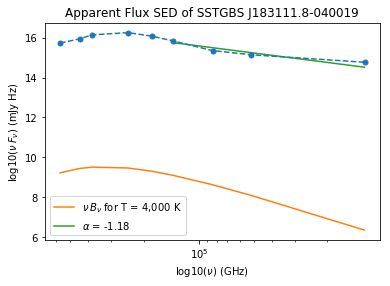

36
3802
The GB index 2107
RA:  277.8135699844219
DEC:  -2.093275295849145
The difference in RA is  0.015 arcseconds
The difference in Dec is  0.252 arcseconds
The Gould_Belt_ID is  SSTGBS J183115.3-020536
alpha is -0.81
The object type is star+dust(IR1)
2MASS ID: b'18311526-0205355'
FLUX SIGNAL TO NOISE
[         nan  61.84028057          nan  47.20592227 160.47525761
 336.28191552  16.57894737  19.70588235  16.57894737  16.34615385
   1.63834951]
SED Flux
[         nan   0.20429017          nan  15.06914234  51.22714233
 107.3483963  189.         201.         189.         170.
 135.        ]
SED Flux Error
[           nan 3.30351293e-03            nan 3.19221437e-01
 3.19221437e-01 3.19221437e-01 1.14000000e+01 1.02000000e+01
 1.14000000e+01 1.04000000e+01 8.24000000e+01]
The apparent magnitude in g is: 18.019415
The absolute magnitude in g is: 9.675032543513904
g-K is: 8.536415
GB-GR is: --
MIPS 1 IS MISSING
SED_nu_log
[13.95824721 15.56324228 15.96568981 16.17336362 16.2021669  16.1

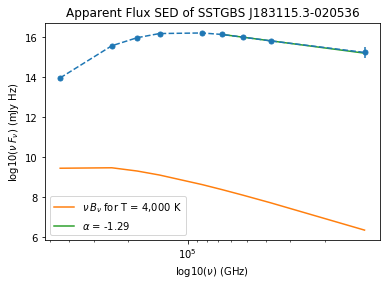

37
3974
The GB index 2178
RA:  277.84409491064514
DEC:  -2.092138110870018
The difference in RA is  0.072 arcseconds
The difference in Dec is  0.081 arcseconds
The Gould_Belt_ID is  SSTGBS J183122.6-020532
alpha is -1.83
The object type is star+dust(IR4)
2MASS ID: b'18312257-0205315'
FLUX SIGNAL TO NOISE
[1.24876700e+02 1.39922807e+03 2.39952918e+02 3.74391801e+01
 5.63816916e+01 5.80809451e+01 1.73831776e+01 1.83168317e+01
 1.73831776e+01 6.14285714e+00 1.00000000e+00]
SED Flux
[   1.16022229    8.97222233   26.83220863  206.67510986  311.24325562
  320.62362671  186.          148.          186.          172.
 -999.        ]
SED Flux Error
[ 9.29094292e-03  6.41226582e-03  1.11822806e-01  5.52028942e+00
  5.52028942e+00  5.52028942e+00  1.07000000e+01  8.08000000e+00
  1.07000000e+01  2.80000000e+01 -9.99000000e+02]
The apparent magnitude in g is: 13.912784
The absolute magnitude in g is: 5.302240558232777
g-K is: 5.6177835
GB-GR is: 3.7352915
MIPS 1 IS MISSING
SED_nu_log
[14.81873621

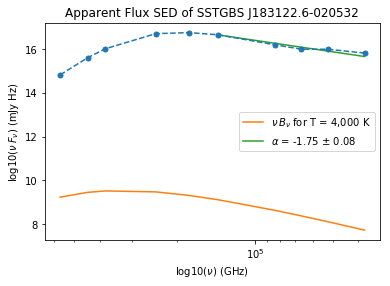

38
3857
The GB index 2186
RA:  277.8470074845617
DEC:  -2.3313913542952314
The difference in RA is  0.059 arcseconds
The difference in Dec is  0.11 arcseconds
The Gould_Belt_ID is  SSTGBS J183123.3-021953
alpha is 0.56
The object type is star+dust(MP1)
2MASS ID: b'18312326-0219529'
FLUX SIGNAL TO NOISE
[ 3.01347625e+01  7.93006192e+02  2.23225245e+02  3.50237472e+01
  5.18769482e+01  4.16744533e+01  9.12500000e+00  6.65217391e+00
  9.12500000e+00 -1.32103321e-01  3.69306931e+00]
SED Flux
[ 1.21728107e-01  4.30612057e-01  1.01013327e+00  2.58040690e+00
  3.82208204e+00  3.07040381e+00  1.46000000e+00  9.18000000e-01
  1.46000000e+00 -3.58000000e-01  3.73000000e+02]
SED Flux Error
[4.03945800e-03 5.43012226e-04 4.52517485e-03 7.36759230e-02
 7.36759230e-02 7.36759230e-02 1.60000000e-01 1.38000000e-01
 1.60000000e-01 2.71000000e+00 1.01000000e+02]
The apparent magnitude in g is: 17.209818
The absolute magnitude in g is: 9.389824422454783
g-K is: 3.8678179
GB-GR is: 2.6224728
MIPS 1 IS MIS

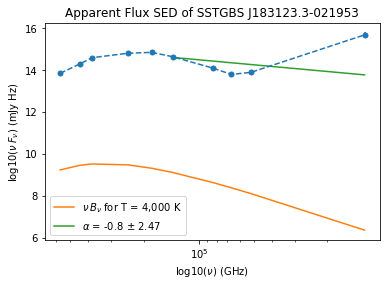

39
3715
The GB index 2219
RA:  277.85576950218535
DEC:  -2.0591104573735635
The difference in RA is  0.058 arcseconds
The difference in Dec is  0.086 arcseconds
The Gould_Belt_ID is  SSTGBS J183125.4-020333
alpha is -0.59
The object type is star+dust(IR1)
2MASS ID: b'18312538-0203326'
FLUX SIGNAL TO NOISE
[  2.59199846  95.92801841  29.73611417  37.43918122 143.99194255
 248.44713248  19.7         18.31804281  19.7          5.63636364
   1.        ]
SED Flux
[ 6.14471920e-03  4.46404293e-02  1.69484735e-01  5.25881672e+00
  2.02255287e+01  3.48976097e+01  5.91000000e+01  5.99000000e+01
  5.91000000e+01  6.20000000e+01 -9.99000000e+02]
SED Flux Error
[ 2.37064925e-03  4.65353398e-04  5.69962617e-03  1.40462920e-01
  1.40462920e-01  1.40462920e-01  3.00000000e+00  3.27000000e+00
  3.00000000e+00  1.10000000e+01 -9.99000000e+02]
The apparent magnitude in g is: 19.670713
The absolute magnitude in g is: 11.623267369353329
g-K is: 8.967713
GB-GR is: 3.9265747
MIPS 1 IS MISSING
SED_nu_log
[12

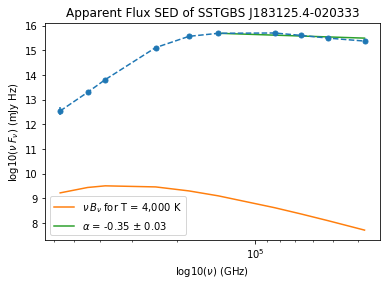

40
4052
The GB index 2226
RA:  277.85651897766274
DEC:  -4.371850877723383
The difference in RA is  0.307 arcseconds
The difference in Dec is  0.245 arcseconds
The Gould_Belt_ID is  SSTGBS J183125.5-042218
alpha is -1.8
The object type is star+dust(MP1)
2MASS ID: b'18312556-0422185'
FLUX SIGNAL TO NOISE
[198.91949674 867.71281807 301.03409634  40.21245017  41.47362235
  33.34782813   1.           1.           1.           1.
   9.82323232]
SED Flux
[   5.65555954   10.76597977   18.84726715   32.42563248   33.44258881
   26.89028931 -999.         -999.         -999.         -999.
    3.89      ]
SED Flux Error
[ 2.84313988e-02  1.24073075e-02  6.26084134e-02  8.06358039e-01
  8.06358039e-01  8.06358039e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.96000000e-01]
The apparent magnitude in g is: 13.7149
The absolute magnitude in g is: 5.829009982544166
g-K is: 2.7289
GB-GR is: 1.6319361
MIPS 1 IS MISSING
SED_nu_log
[15.50667058 15.68005331 15.855339   15.8960422 

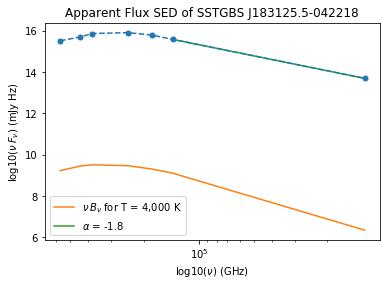

41
28230
The GB index 2254
RA:  277.86458941416277
DEC:  -3.64675060226728
The difference in RA is  0.02 arcseconds
The difference in Dec is  0.211 arcseconds
The Gould_Belt_ID is  SSTGBS J183127.5-033848
alpha is -1.3
The object type is star+dust(IR2)
2MASS ID: b'18312750-0338481'
FLUX SIGNAL TO NOISE
[  4.65996245  13.5121427    4.38663084  41.75908582 156.08553869
 280.19357844  13.30275229  19.22626026  13.30275229  20.64676617
  10.66460587]
SED Flux
[1.97612252e-02 1.04508772e-01 5.22080004e-01 2.72450958e+02
 1.01835693e+03 1.82808142e+03 1.45000000e+03 1.64000000e+03
 1.45000000e+03 1.66000000e+03 6.90000000e+02]
SED Flux Error
[4.24064044e-03 7.73443375e-03 1.19016171e-01 6.52435160e+00
 6.52435160e+00 6.52435160e+00 1.09000000e+02 8.53000000e+01
 1.09000000e+02 8.04000000e+01 6.47000000e+01]
The apparent magnitude in g is: 18.747152
The absolute magnitude in g is: 10.678052591040975
g-K is: 12.342152
GB-GR is: 3.8798103
SED_nu_log
[13.05000887 13.66715249 14.29782767 16.82044

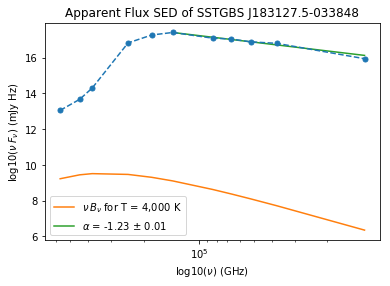

42
28115
The GB index 2304
RA:  277.8825297953799
DEC:  -4.015997612184812
The difference in RA is  0.311 arcseconds
The difference in Dec is  0.158 arcseconds
The Gould_Belt_ID is  SSTGBS J183131.8-040057
alpha is -2.42
The object type is star+dust(MP1)
2MASS ID: b'18313180-0400574'
FLUX SIGNAL TO NOISE
[6.44083764e+02 3.51239405e+03 9.40159822e+02 4.17590816e+01
 3.31560166e+01 2.41578321e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.57983193e+00]
SED Flux
[  56.56385422   87.83478546  132.13946533  179.34466553  142.39668274
  103.75176239 -999.         -999.         -999.         -999.
    3.42      ]
SED Flux Error
[ 8.78206491e-02  2.50070989e-02  1.40550002e-01  4.29474640e+00
  4.29474640e+00  4.29474640e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.57000000e-01]
The apparent magnitude in g is: 11.435867
The absolute magnitude in g is: 3.544890439519465
g-K is: 1.9158669
GB-GR is: 1.2462368
MIPS 1 IS MISSING
SED_nu_log
[16.506734  

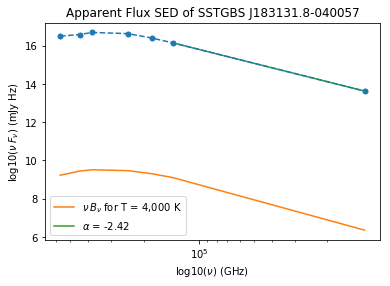

43
28080
The GB index 2330
RA:  277.89627575416006
DEC:  -3.8495648700158207
The difference in RA is  0.0 arcseconds
The difference in Dec is  0.096 arcseconds
The Gould_Belt_ID is  SSTGBS J183135.1-035058
alpha is -2.03
The object type is star+dust(MP1)
2MASS ID: b'18313510-0350583'
FLUX SIGNAL TO NOISE
[4.82873260e+02 1.77895180e+03 8.16506929e+02 4.52390092e+01
 4.23179521e+01 3.26753763e+01 2.04026846e+01 1.00000000e+00
 2.04026846e+01 1.00000000e+00 1.03142329e+01]
SED Flux
[  10.81302738   23.01641846   43.31958008   89.38983154   83.61798096
   64.56477356   30.4        -999.           30.4        -999.
    5.58      ]
SED Flux Error
[ 2.23930962e-02  1.29381912e-02  5.30547611e-02  1.97594583e+00
  1.97594583e+00  1.97594583e+00  1.49000000e+00 -9.99000000e+02
  1.49000000e+00 -9.99000000e+02  5.41000000e-01]
The apparent magnitude in g is: 12.889939
The absolute magnitude in g is: 5.0385773785522225
g-K is: 2.8549395
GB-GR is: 1.8318462
MIPS 1 IS MISSING
SED_nu_log
[15.7881423

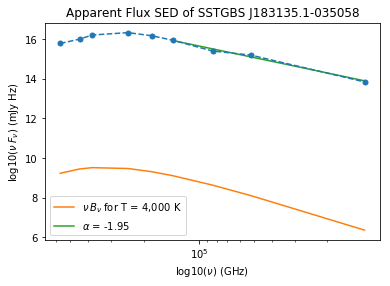

44
28112
The GB index 2572
RA:  278.0076277412323
DEC:  -3.900869306285377
The difference in RA is  0.391 arcseconds
The difference in Dec is  0.06 arcseconds
The Gould_Belt_ID is  SSTGBS J183201.8-035403
alpha is -1.04
The object type is star+dust(MP1)
2MASS ID: b'18320182-0354030'
FLUX SIGNAL TO NOISE
[ 25.49083414 169.4217854   67.57173516  38.77629287  67.66715715
  76.01052791   1.           1.           1.           1.
  10.68181818]
SED Flux
[ 1.36950493e-01  6.36585057e-01  1.66736066e+00  7.93027210e+00
  1.38388414e+01  1.55451727e+01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.41000000e+01]
SED Flux Error
[ 5.37253870e-03  3.75739788e-03  2.46754158e-02  2.04513416e-01
  2.04513416e-01  2.04513416e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.32000000e+00]
The apparent magnitude in g is: 16.785393
The absolute magnitude in g is: 8.419566734462304
g-K is: 5.2043924
GB-GR is: 3.0386686
MIPS 1 IS MISSING
SED_nu_log
[13.89075861 

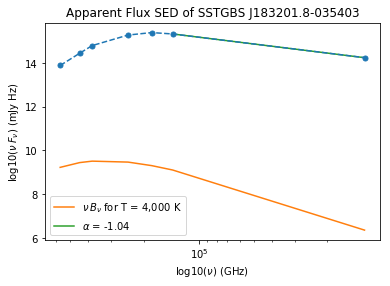

45
3905
The GB index 2751
RA:  278.13398953005776
DEC:  -2.158207244933876
The difference in RA is  0.052 arcseconds
The difference in Dec is  0.089 arcseconds
The Gould_Belt_ID is  SSTGBS J183232.2-020929
alpha is -1.9
The object type is Galc_star+dust(MP1)
2MASS ID: b'18323214-0209294'
FLUX SIGNAL TO NOISE
[ 47.0902245  195.00675569 155.60795383  37.43917884  48.03278427
  40.85390292  20.38834951  19.56856703  20.38834951   6.37254902
   3.64356436]
SED Flux
[0.10851812 0.39550486 1.01533365 3.34879375 4.29635191 3.65422797
 1.89       1.27       1.89       0.65       1.84      ]
SED Flux Error
[0.00230447 0.00202816 0.00652495 0.08944624 0.08944624 0.08944624
 0.0927     0.0649     0.0927     0.102      0.505     ]
The apparent magnitude in g is: 17.302155
The absolute magnitude in g is: 9.509422874732813
g-K is: 4.1491547
GB-GR is: 2.7527695
SED_nu_log
[13.78969725 14.24515157 14.58669939 14.91004215 14.88928953 14.7053637
 14.2021669  13.92693638 13.99447882 13.39060493 13.364271

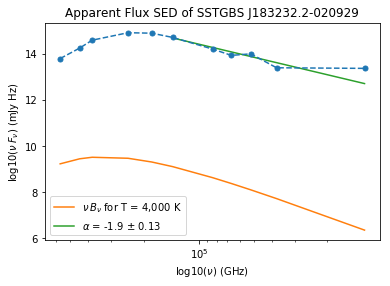

46
3642
The GB index 2752
RA:  278.1340259731196
DEC:  -2.2169644958291386
The difference in RA is  0.105 arcseconds
The difference in Dec is  0.014 arcseconds
The Gould_Belt_ID is  SSTGBS J183232.2-021301
alpha is -2.05
The object type is Galc_star+dust(MP1)
2MASS ID: b'18323214-0213011'
FLUX SIGNAL TO NOISE
[ 46.41021168 610.59698975 448.97722956  32.90109637  44.44491962
  38.36344324  19.68253968  19.7301855   19.68253968   7.16
   3.33333333]
SED Flux
[0.20231239 0.57977116 1.24340868 3.2998054  4.45758963 3.84764981
 1.86       1.17       1.86       0.716      1.36      ]
SED Flux Error
[0.00435922 0.00094952 0.00276942 0.10029469 0.10029469 0.10029469
 0.0945     0.0593     0.0945     0.1        0.408     ]
The apparent magnitude in g is: 16.886892
The absolute magnitude in g is: 8.818699590530347
g-K is: 3.7898922
GB-GR is: 2.296482
SED_nu_log
[14.0602175  14.41125636 14.67470451 14.90364207 14.90528977 14.7277636
 14.19521804 13.89131852 13.98752996 13.4326046  13.23299307]
SE

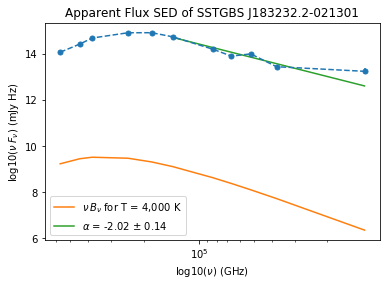

47
42116
The GB index 2859
RA:  278.1968226650767
DEC:  -4.866850358523684
The difference in RA is  0.095 arcseconds
The difference in Dec is  0.115 arcseconds
The Gould_Belt_ID is  SSTGBS J183247.2-045201
alpha is -1.95
The object type is star+dust(MP1)
2MASS ID: b'18324723-0452005'
FLUX SIGNAL TO NOISE
[3.00175731e+02 2.28994437e+03 5.71091993e+02 4.17590833e+01
 4.44387973e+01 3.36556765e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 6.40625000e+00]
SED Flux
[   4.76694489    9.27378654   16.69093323   29.7638073    31.67377472
   23.98810005 -999.         -999.         -999.         -999.
    2.46      ]
SED Flux Error
[ 1.58805139e-02  4.04978683e-03  2.92263478e-02  7.12750494e-01
  7.12750494e-01  7.12750494e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.84000000e-01]
The apparent magnitude in g is: 13.876891
The absolute magnitude in g is: 5.666067735224324
g-K is: 2.7668915
GB-GR is: 1.685606
MIPS 1 IS MISSING
SED_nu_log
[15.43243514 

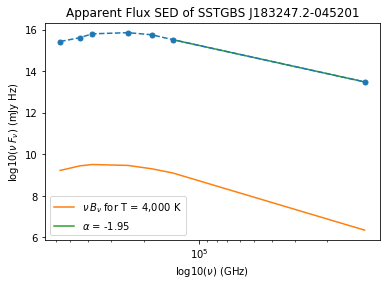

48
49613
The GB index 2902
RA:  278.234657500942
DEC:  -0.5183239819912588
The difference in RA is  0.266 arcseconds
The difference in Dec is  0.148 arcseconds
The Gould_Belt_ID is  SSTGBS J183256.3+000-3106
alpha is -1.2
The object type is star+dust(IR4)
2MASS ID: b'18325633-0031059'
FLUX SIGNAL TO NOISE
[8.63359782e+01 1.24012161e+03 3.10136297e+02 1.39196952e+01
 1.92062078e+01 1.52453433e+01 1.46428571e+01 8.38888889e+00
 1.46428571e+01 7.79104478e+00 1.00000000e+00]
SED Flux
[ 4.01397854e-01  1.01184762e+00  2.05727053e+00  5.17712116e+00
  7.14332199e+00  5.67016649e+00  3.69000000e+00  1.51000000e+00
  3.69000000e+00  5.22000000e+00 -9.99000000e+02]
SED Flux Error
[ 4.64925356e-03  8.15926120e-04  6.63344003e-03  3.71927768e-01
  3.71927768e-01  3.71927768e-01  2.52000000e-01  1.80000000e-01
  2.52000000e-01  6.70000000e-01 -9.99000000e+02]
The apparent magnitude in g is: 16.282246
The absolute magnitude in g is: 8.172002893302832
g-K is: 3.606246
GB-GR is: 2.0992956
MIPS 1 IS M

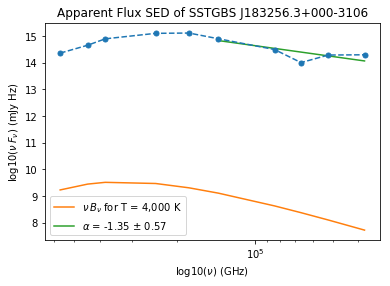

49
48753
The GB index 3084
RA:  278.51607153390756
DEC:  -1.060809117858748
The difference in RA is  0.398 arcseconds
The difference in Dec is  0.07 arcseconds
The Gould_Belt_ID is  SSTGBS J183403.8-010339
alpha is -0.93
The object type is star+dust(MP1)
2MASS ID: b'18340385-0103388'
FLUX SIGNAL TO NOISE
[  1.37234787 132.25101263  16.2072537   20.87954275  56.43287561
  67.98738181   1.           1.           1.           1.
  10.30685921]
SED Flux
[ 7.38243526e-03  2.95433383e-02  9.26414430e-02  1.49447429e+00
  4.03923988e+00  4.86626530e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.71000000e+00]
SED Flux Error
[ 5.37941977e-03  2.23388372e-04  5.71604818e-03  7.15760067e-02
  7.15760067e-02  7.15760067e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.54000000e-01]
The apparent magnitude in g is: 20.118885
The absolute magnitude in g is: 11.992262922492777
g-K is: 7.276885
GB-GR is: 3.071518
MIPS 1 IS MISSING
SED_nu_log
[12.62239465 

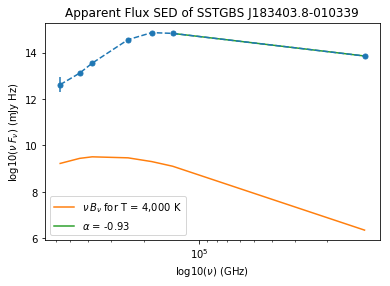

50
49286
The GB index 3119
RA:  278.7758028605848
DEC:  -0.6596334871103713
The difference in RA is  0.141 arcseconds
The difference in Dec is  0.436 arcseconds
The Gould_Belt_ID is  SSTGBS J183506.2+000-3935
alpha is -0.94
The object type is star+dust(MP1)
2MASS ID: b'18350619-0039344'
FLUX SIGNAL TO NOISE
[20.56292432 79.60538827 29.30667059 45.23900534 72.06507239 79.69304839
  1.          1.          1.          1.         10.76271186]
SED Flux
[   1.92488837    6.0505271    13.82675266   61.6720047    98.24259949
  108.64142609 -999.         -999.         -999.         -999.
  127.        ]
SED Flux Error
[ 9.36096609e-02  7.60065019e-02  4.71795410e-01  1.36324847e+00
  1.36324847e+00  1.36324847e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.18000000e+01]
The apparent magnitude in g is: 14.340551
The absolute magnitude in g is: 6.01961371370718
g-K is: 4.870551
GB-GR is: 2.4657907
MIPS 1 IS MISSING
SED_nu_log
[15.03860055 15.42979296 15.72081081 16.17524

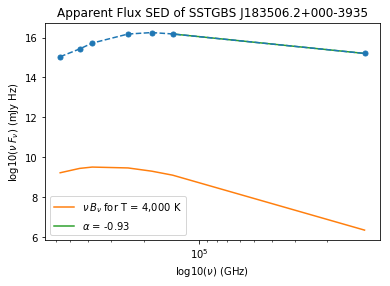

51
49179
The GB index 3127
RA:  278.8426787695807
DEC:  -0.44302996157754904
The difference in RA is  1.183 arcseconds
The difference in Dec is  0.837 arcseconds
The Gould_Belt_ID is  SSTGBS J183522.3+000-2636
alpha is -1.77
The object type is star+dust(MP1)
2MASS ID: b'18352224-0026347'
FLUX SIGNAL TO NOISE
[5.09966415e+02 3.50183301e+03 6.52849756e+02 4.17590846e+01
 4.09036911e+01 3.38733786e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.08467742e+01]
SED Flux
[  24.4201088    52.38826752   98.50366974  210.32373047  206.01545715
  170.6065979  -999.         -999.         -999.         -999.
   26.9       ]
SED Flux Error
[ 4.78857197e-02  1.49602415e-02  1.50882602e-01  5.03659821e+00
  5.03659821e+00  5.03659821e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.48000000e+00]
The apparent magnitude in g is: 11.996949
The absolute magnitude in g is: 3.6709375341061
g-K is: 3.0169497
GB-GR is: 1.8392658
MIPS 1 IS MISSING
SED_nu_log
[16.141942

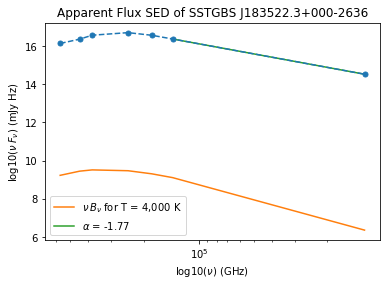

52
49220
The GB index 3129
RA:  278.8511555365188
DEC:  -0.6016645469695971
The difference in RA is  0.208 arcseconds
The difference in Dec is  0.024 arcseconds
The Gould_Belt_ID is  SSTGBS J183524.3+000-3606
alpha is -1.13
The object type is star+dust(MP1)
2MASS ID: b'18352427-0036057'
FLUX SIGNAL TO NOISE
[ 10.40180677 148.09356924  53.2002703   40.21245103  75.19213782
  81.10875548   1.           1.           1.           1.
  10.74468085]
SED Flux
[ 1.44552914e-02  1.51285991e-01  4.60527986e-01  4.13131475e+00
  7.72502995e+00  8.33288670e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  6.06000000e+00]
SED Flux Error
[ 1.38969044e-03  1.02155679e-03  8.65649711e-03  1.02737203e-01
  1.02737203e-01  1.02737203e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.64000000e-01]
The apparent magnitude in g is: 18.345537
The absolute magnitude in g is: 9.79935501863453
g-K is: 6.087537
GB-GR is: 4.0830765
MIPS 1 IS MISSING
SED_nu_log
[12.9142218

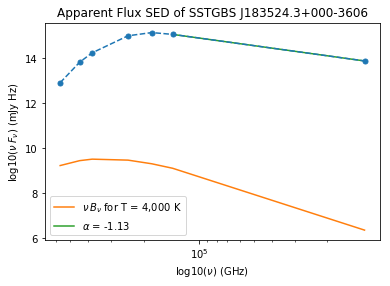

53
49437
The GB index 3133
RA:  278.87489854779886
DEC:  -0.7155786967456734
The difference in RA is  0.485 arcseconds
The difference in Dec is  0.381 arcseconds
The Gould_Belt_ID is  SSTGBS J183529.9+000-4256
alpha is -1.32
The object type is star+dust(MP1)
2MASS ID: b'18352997-0042557'
FLUX SIGNAL TO NOISE
[ 75.02517477 260.04201533 106.9405564   41.75908418  55.17754162
  49.78036781   1.           1.           1.           1.
  10.8440367 ]
SED Flux
[   8.93880558   20.34867477   41.1548233   106.97657013  141.35137939
  127.52513885 -999.         -999.         -999.         -999.
   59.1       ]
SED Flux Error
[ 1.19144082e-01  7.82514885e-02  3.84838313e-01  2.56175566e+00
  2.56175566e+00  2.56175566e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  5.45000000e+00]
The apparent magnitude in g is: 13.023694
The absolute magnitude in g is: 4.4605493061127355
g-K is: 3.7276945
GB-GR is: 1.9828568
MIPS 1 IS MISSING
SED_nu_log
[15.7054745  15.95653588 16.19451135 

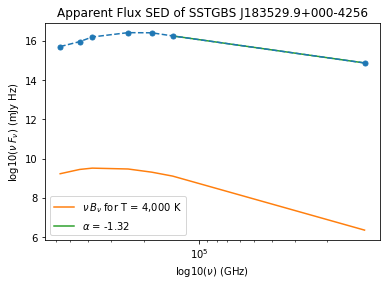

54
54893
The GB index 3136
RA:  278.8849686882642
DEC:  0.18237800723529082
The difference in RA is  0.199 arcseconds
The difference in Dec is  0.151 arcseconds
The Gould_Belt_ID is  SSTGBS J183532.4+001057
alpha is -2.18
The object type is star+dust(MP1)
2MASS ID: b'18353238+0010567'
FLUX SIGNAL TO NOISE
[3.34370214e+02 3.68173087e+03 6.22268522e+02 4.93516464e+01
 4.56997070e+01 3.35126706e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 5.24752475e+00]
SED Flux
[   8.27563286   15.43505287   27.1532917    53.66461945   49.69352722
   36.44143295 -999.         -999.         -999.         -999.
    2.12      ]
SED Flux Error
[ 2.47499105e-02  4.19233600e-03  4.36359718e-02  1.08739269e+00
  1.08739269e+00  1.08739269e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.04000000e-01]
The apparent magnitude in g is: 13.323764
The absolute magnitude in g is: 4.8354971838292276
g-K is: 2.6677637
GB-GR is: 1.615058
MIPS 1 IS MISSING
SED_nu_log
[15.6719962

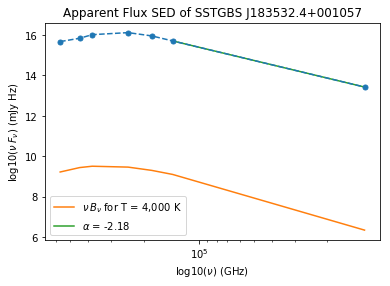

55
33320
The GB index 3170
RA:  278.9618097265066
DEC:  0.46418311297809745
The difference in RA is  1.248 arcseconds
The difference in Dec is  0.325 arcseconds
The Gould_Belt_ID is  SSTGBS J183550.8+002751
alpha is -0.86
The object type is star+dust(MP1)
2MASS ID: b'18355082+0027510'
FLUX SIGNAL TO NOISE
[ 14.8339343  462.44226545  81.67592171  29.34422381  45.13716078
  47.66827633   1.           1.           1.           1.
  10.48044693]
SED Flux
[ 2.35058051e-02  2.14334443e-01  6.37236476e-01  4.11991787e+00
  6.33724022e+00  6.69260788e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  9.38000000e+00]
SED Flux Error
[ 1.58459682e-03  4.63483681e-04  7.80201145e-03  1.40399620e-01
  1.40399620e-01  1.40399620e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  8.95000000e-01]
The apparent magnitude in g is: 17.967304
The absolute magnitude in g is: 9.288966048252144
g-K is: 5.471304
GB-GR is: 3.9078178
MIPS 1 IS MISSING
SED_nu_log
[13.12537014

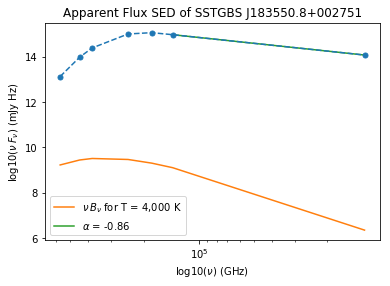

56
54737
The GB index 3175
RA:  278.9723528917186
DEC:  -0.35988244065879404
The difference in RA is  0.134 arcseconds
The difference in Dec is  0.087 arcseconds
The Gould_Belt_ID is  SSTGBS J183553.4+000-2135
alpha is -2.28
The object type is star+dust(MP1)
2MASS ID: b'18355336-0021355'
FLUX SIGNAL TO NOISE
[3.94969574e+02 2.43465815e+03 5.48850771e+02 4.52390068e+01
 5.59918437e+01 4.66251225e+01 1.00000000e+00 2.04907975e+01
 1.00000000e+00 2.05787781e+01 1.03358209e+01]
SED Flux
[   2.2177875     6.68544817   14.94186974   50.12892532   62.04404449
   51.6648674  -999.           16.7        -999.            6.4
    2.77      ]
SED Flux Error
[ 5.61508443e-03  2.74594943e-03  2.72239204e-02  1.10809076e+00
  1.10809076e+00  1.10809076e+00 -9.99000000e+02  8.15000000e-01
 -9.99000000e+02  3.11000000e-01  2.68000000e-01]
The apparent magnitude in g is: 14.232207
The absolute magnitude in g is: 5.717750854732811
g-K is: 3.9552069
GB-GR is: 2.3962164
MIPS 1 IS MISSING
SED_nu_log
[15.100

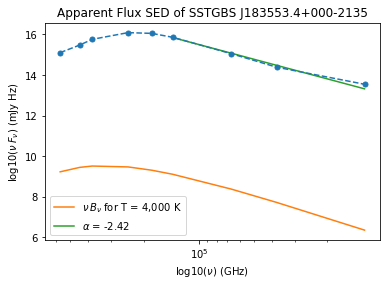

57
33287
The GB index 3213
RA:  279.02433323690326
DEC:  0.5171925520033311
The difference in RA is  0.276 arcseconds
The difference in Dec is  0.191 arcseconds
The Gould_Belt_ID is  SSTGBS J183605.8+003102
alpha is -2.16
The object type is star+dust(MP1)
2MASS ID: b'18360582+0031020'
FLUX SIGNAL TO NOISE
[7.01576135e+02 3.19895539e+03 8.95259978e+02 4.17590839e+01
 3.45591243e+01 2.78136436e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 8.26865672e+00]
SED Flux
[  13.83487701   23.88709831   39.43105316   68.43659973   56.63699341
   45.58220673 -999.         -999.         -999.         -999.
    2.77      ]
SED Flux Error
[ 1.97197087e-02  7.46715581e-03  4.40442488e-02  1.63884342e+00
  1.63884342e+00  1.63884342e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.35000000e-01]
The apparent magnitude in g is: 12.849626
The absolute magnitude in g is: 4.362778413003237
g-K is: 2.4366255
GB-GR is: 1.462162
MIPS 1 IS MISSING
SED_nu_log
[15.89517031

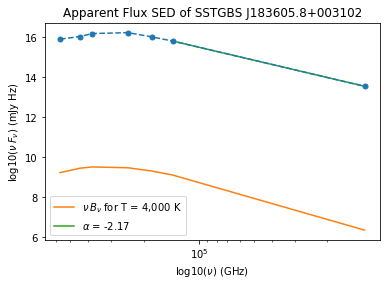

58
46997
The GB index 3267
RA:  279.1683670405813
DEC:  -0.6459599169799984
The difference in RA is  0.025 arcseconds
The difference in Dec is  0.071 arcseconds
The Gould_Belt_ID is  SSTGBS J183640.4+000-3845
alpha is -2.13
The object type is star+dust(MP1)
2MASS ID: b'18364041-0038453'
FLUX SIGNAL TO NOISE
[ 66.84153135 258.79287096  80.22962907  47.20592162  60.11853068
  50.10760593   1.           1.           1.           1.
   6.55339806]
SED Flux
[   1.21398044    3.14475489    6.69170189   19.2525425    24.5188427
   20.43597031 -999.         -999.         -999.         -999.
    1.35      ]
SED Flux Error
[ 1.81620680e-02  1.21516287e-02  8.34068656e-02  4.07841682e-01
  4.07841682e-01  4.07841682e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.06000000e-01]
The apparent magnitude in g is: 15.051067
The absolute magnitude in g is: 6.622198660837368
g-K is: 3.767067
GB-GR is: 2.178316
MIPS 1 IS MISSING
SED_nu_log
[14.83840669 15.14558655 15.4056272  15.66

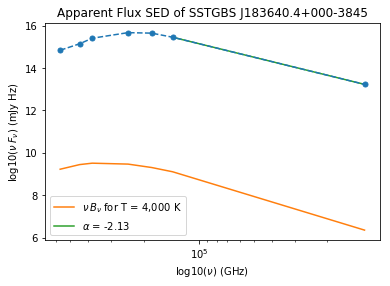

59
56004
The GB index 3271
RA:  279.17280086761184
DEC:  0.3949561609420856
The difference in RA is  0.245 arcseconds
The difference in Dec is  0.138 arcseconds
The Gould_Belt_ID is  SSTGBS J183641.5+002342
alpha is -1.44
The object type is star+dust(MP1)
2MASS ID: b'18364146+0023420'
FLUX SIGNAL TO NOISE
[ 72.82698681 240.85446307 130.78979948  43.42944632  75.71734646
  72.65931213  20.84765178   1.          20.84765178   1.
  10.59322034]
SED Flux
[ 1.09034911e-01  6.97882831e-01  2.37771344e+00  1.68767433e+01
  2.94238663e+01  2.82355099e+01  1.82000000e+01 -9.99000000e+02
  1.82000000e+01 -9.99000000e+02  1.00000000e+01]
SED Flux Error
[ 1.49717729e-03  2.89752916e-03  1.81796551e-02  3.88601393e-01
  3.88601393e-01  3.88601393e-01  8.73000000e-01 -9.99000000e+02
  8.73000000e-01 -9.99000000e+02  9.44000000e-01]
The apparent magnitude in g is: 16.685577
The absolute magnitude in g is: 8.124109440540652
g-K is: 5.752578
GB-GR is: 3.6714888
MIPS 1 IS MISSING
SED_nu_log
[13.79176058

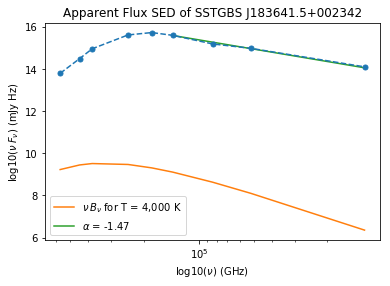

60
56239
The GB index 3287
RA:  279.2031943568173
DEC:  0.4631252451829466
The difference in RA is  0.008 arcseconds
The difference in Dec is  0.021 arcseconds
The Gould_Belt_ID is  SSTGBS J183648.8+002747
alpha is -0.94
The object type is star+dust(IR3)
2MASS ID: b'18364876+0027473'
FLUX SIGNAL TO NOISE
[  5.35667177 130.43142925  46.75395002  27.14340605  48.87377408
  50.39317412  20.19379845   1.          20.19379845   1.
  10.54347826]
SED Flux
[ 1.89297441e-02  1.61139160e-01  4.99441624e-01  4.02242804e+00
  7.24268866e+00  7.46785116e+00  5.21000000e+00 -9.99000000e+02
  5.21000000e+00 -9.99000000e+02  7.76000000e+00]
SED Flux Error
[ 3.53386300e-03  1.23543199e-03  1.06823407e-02  1.48191720e-01
  1.48191720e-01  1.48191720e-01  2.58000000e-01 -9.99000000e+02
  2.58000000e-01 -9.99000000e+02  7.36000000e-01]
The apparent magnitude in g is: 18.27703
The absolute magnitude in g is: 9.999645333576966
g-K is: 5.900031
GB-GR is: 3.878355
MIPS 1 IS MISSING
SED_nu_log
[13.03133975 13

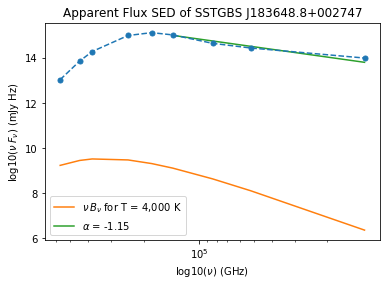

61
56774
The GB index 3304
RA:  279.2453851510593
DEC:  0.550014447891231
The difference in RA is  0.116 arcseconds
The difference in Dec is  0.089 arcseconds
The Gould_Belt_ID is  SSTGBS J183658.9+003300
alpha is -1.73
The object type is star+dust(MP1)
2MASS ID: b'18365888+0033001'
FLUX SIGNAL TO NOISE
[ 18.5657941  392.52136689 128.96779188  33.92925493  49.84096327
  44.59453129   1.           1.           1.           1.
   5.95121951]
SED Flux
[ 5.17030396e-02  3.74083936e-01  1.08884525e+00  5.41113281e+00
  7.94877672e+00  7.11206102e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.22000000e+00]
SED Flux Error
[ 2.78485473e-03  9.53028211e-04  8.44276883e-03  1.59482807e-01
  1.59482807e-01  1.59482807e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.05000000e-01]
The apparent magnitude in g is: 17.362612
The absolute magnitude in g is: 9.518885946809498
g-K is: 4.9326115
GB-GR is: 3.6336298
MIPS 1 IS MISSING
SED_nu_log
[13.46771108 

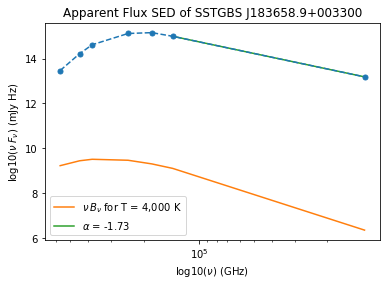

62
56146
The GB index 3310
RA:  279.26811936263465
DEC:  0.41087308460682864
The difference in RA is  0.003 arcseconds
The difference in Dec is  0.067 arcseconds
The Gould_Belt_ID is  SSTGBS J183704.3+002439
alpha is -2.4
The object type is star+dust(MP1)
2MASS ID: b'18370434+0024393'
FLUX SIGNAL TO NOISE
[2.56233135e+02 1.36683737e+03 4.80992849e+02 4.93516482e+01
 4.45362324e+01 3.46105890e+01 2.10156250e+01 1.00000000e+00
 2.10156250e+01 1.00000000e+00 7.41100324e+00]
SED Flux
[  14.00654984   25.76238251   44.4417572    82.88737488   74.79975891
   58.12938309   26.9        -999.           26.9        -999.
    2.29      ]
SED Flux Error
[ 5.46633042e-02  1.88481696e-02  9.23958793e-02  1.67952597e+00
  1.67952597e+00  1.67952597e+00  1.28000000e+00 -9.99000000e+02
  1.28000000e+00 -9.99000000e+02  3.09000000e-01]
The apparent magnitude in g is: 12.767569
The absolute magnitude in g is: 4.322754680045069
g-K is: 2.6185684
GB-GR is: 1.5786543
MIPS 1 IS MISSING
SED_nu_log
[15.9005261

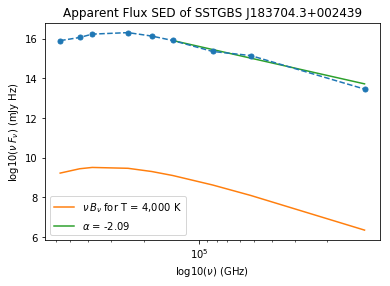

63
55890
The GB index 3330
RA:  279.34341050210094
DEC:  0.37811582470526517
The difference in RA is  0.009 arcseconds
The difference in Dec is  0.074 arcseconds
The Gould_Belt_ID is  SSTGBS J183722.4+002241
alpha is -1.94
The object type is Galc_star+dust(MP1)
2MASS ID: b'18372242+0022413'
FLUX SIGNAL TO NOISE
[  4.04164079 186.4933628   44.98009538  13.40415063  18.58022999
  19.95016618  18.6827957   18.48484848  18.6827957    3.62473348
   3.26818182]
SED Flux
[0.00843338 0.04304391 0.12274367 0.95959604 1.33014882 1.42822182
 0.695      0.488      0.695      0.17       0.719     ]
SED Flux Error
[0.00208662 0.00023081 0.00272884 0.07158947 0.07158947 0.07158947
 0.0372     0.0264     0.0372     0.0469     0.22      ]
The apparent magnitude in g is: 19.710255
The absolute magnitude in g is: 11.800495528799344
g-K is: 5.5372543
GB-GR is: 3.2324982
SED_nu_log
[12.68019688 13.28191144 13.6690897  14.36724219 14.38008992 14.29736372
 13.7676899  13.51155248 13.56000182 12.8081405  12.9

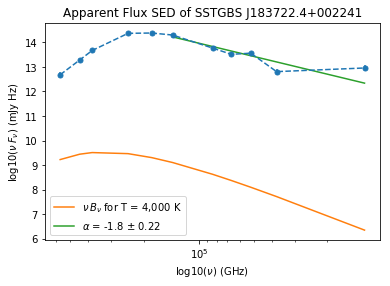

64
56584
The GB index 3344
RA:  279.3842261275462
DEC:  0.5504029154082146
The difference in RA is  0.317 arcseconds
The difference in Dec is  0.562 arcseconds
The Gould_Belt_ID is  SSTGBS J183732.2+003302
alpha is -0.57
The object type is star+dust(MP1)
2MASS ID: b'18373220+0033014'
FLUX SIGNAL TO NOISE
[11.03979003 81.38236246 26.97431774 33.92925433 55.97392007 56.03784053
  1.          1.          1.          1.         10.76023392]
SED Flux
[ 4.39014435e-02  2.79665977e-01  7.68894017e-01  3.98188305e+00
  6.56900978e+00  6.57651138e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.84000000e+01]
SED Flux Error
[ 3.97665566e-03  3.43644456e-03  2.85046697e-02  1.17358401e-01
  1.17358401e-01  1.17358401e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.71000000e+00]
The apparent magnitude in g is: 17.678434
The absolute magnitude in g is: 9.283166414604112
g-K is: 5.163434
GB-GR is: 3.4334736
MIPS 1 IS MISSING
SED_nu_log
[13.39667381 14.0

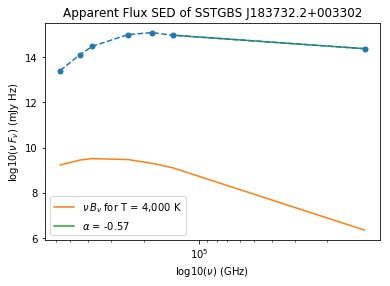

65
56666
The GB index 3346
RA:  279.387781857256
DEC:  0.4429629595360854
The difference in RA is  0.031 arcseconds
The difference in Dec is  0.087 arcseconds
The Gould_Belt_ID is  SSTGBS J183733.1+002635
alpha is -0.63
The object type is star+dust(IR1)
2MASS ID: b'18373306+0026347'
FLUX SIGNAL TO NOISE
[14.35775687 54.46239883 19.2002511  43.4294487  69.37392943 71.46478047
 20.63492063  1.         20.63492063  1.         10.73289902]
SED Flux
[ 6.13353014e-01  1.82702732e+00  4.15648842e+00  1.29326649e+01
  2.06585579e+01  2.12811832e+01  2.60000000e+01 -9.99000000e+02
  2.60000000e+01 -9.99000000e+02  6.59000000e+01]
SED Flux Error
[ 4.27192785e-02  3.35465819e-02  2.16480941e-01  2.97785610e-01
  2.97785610e-01  2.97785610e-01  1.26000000e+00 -9.99000000e+02
  1.26000000e+00 -9.99000000e+02  6.14000000e+00]
The apparent magnitude in g is: 15.640671
The absolute magnitude in g is: 7.336579653978417
g-K is: 4.400671
GB-GR is: 2.402544
MIPS 1 IS MISSING
SED_nu_log
[14.54190551 14.909

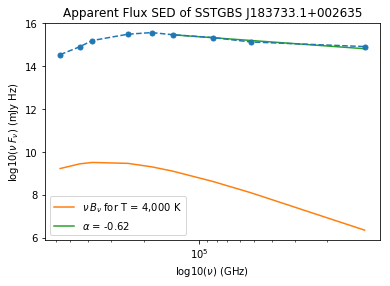

66
56656
The GB index 3366
RA:  279.42756104838594
DEC:  0.48047163835068896
The difference in RA is  0.065 arcseconds
The difference in Dec is  0.132 arcseconds
The Gould_Belt_ID is  SSTGBS J183742.6+002850
alpha is -2.35
The object type is star+dust(MP1)
2MASS ID: b'18374261+0028498'
FLUX SIGNAL TO NOISE
[6.80680132e+02 3.99162476e+03 1.13186239e+03 4.34294464e+01
 3.62072774e+01 2.76752687e+01 1.74022346e+01 1.00000000e+00
 1.74022346e+01 1.00000000e+00 9.67332123e+00]
SED Flux
[  75.50302124  107.48322296  152.62026978  211.68411255  176.48176575
  134.89498901   62.3        -999.           62.3        -999.
    5.33      ]
SED Flux Error
[ 1.10922910e-01  2.69271862e-02  1.34839952e-01  4.87420702e+00
  4.87420702e+00  4.87420702e+00  3.58000000e+00 -9.99000000e+02
  3.58000000e+00 -9.99000000e+02  5.51000000e-01]
The apparent magnitude in g is: 11.216682
The absolute magnitude in g is: 2.7021319917201083
g-K is: 1.9816828
GB-GR is: 1.0891237
MIPS 1 IS MISSING
SED_nu_log
[16.63215

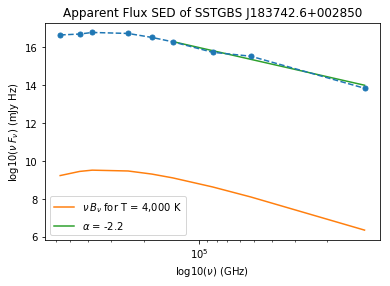

67
56710
The GB index 3369
RA:  279.43432347474663
DEC:  0.4025944507239772
The difference in RA is  0.006 arcseconds
The difference in Dec is  0.2 arcseconds
The Gould_Belt_ID is  SSTGBS J183744.2+002410
alpha is -1.81
The object type is star+dust(IR3)
2MASS ID: b'18374423+0024096'
FLUX SIGNAL TO NOISE
[ 26.499268   536.50384006  97.71436322  18.71958986  26.14015358
  19.13390563  18.94252874  18.08080808  18.94252874   1.81693989
  -0.62753036]
SED Flux
[ 0.05201815  0.19509241  0.46162701  1.25686419  1.7550931   1.28468204
  0.824       0.537       0.824       0.133      -0.155     ]
SED Flux Error
[0.001963   0.00036364 0.00472425 0.06714165 0.06714165 0.06714165
 0.0435     0.0297     0.0435     0.0732     0.247     ]
The apparent magnitude in g is: 18.069433
The absolute magnitude in g is: 9.48841862138092
g-K is: 3.781433
GB-GR is: 2.695345
MIPS 1 IS MISSING
SED_nu_log
[13.47034991 13.93824012 14.24438182 14.4844421  14.50048984 14.25136371
 13.84163231 13.55310694 13.63394423

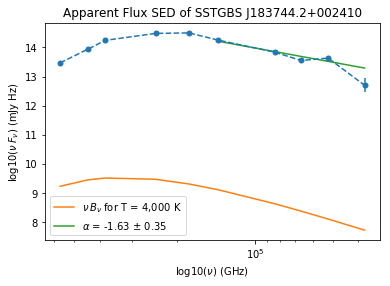

68
56479
The GB index 3372
RA:  279.44504484623263
DEC:  0.5925652805502504
The difference in RA is  0.016 arcseconds
The difference in Dec is  0.099 arcseconds
The Gould_Belt_ID is  SSTGBS J183746.8+003533
alpha is -1.35
The object type is star+dust(IR3)
2MASS ID: b'18374680+0035332'
FLUX SIGNAL TO NOISE
[  3.77017418 186.92905831  45.52534432  17.79895291  23.73593257
  24.02712317  18.07692308   1.          18.07692308   1.
   5.26119403]
SED Flux
[ 9.59759280e-02  1.05038621e-01  3.49522024e-01  2.08779669e+00
  2.78419757e+00  2.81835389e+00  1.88000000e+00 -9.99000000e+02
  1.88000000e+00 -9.99000000e+02  1.41000000e+00]
SED Flux Error
[ 2.54566297e-02  5.61917026e-04  7.67752621e-03  1.17298849e-01
  1.17298849e-01  1.17298849e-01  1.04000000e-01 -9.99000000e+02
  1.04000000e-01 -9.99000000e+02  2.68000000e-01]
The apparent magnitude in g is: 18.741661
The absolute magnitude in g is: 10.35699335610389
g-K is: 5.3066607
GB-GR is: 1.7282848
MIPS 1 IS MISSING
SED_nu_log
[13.7363573

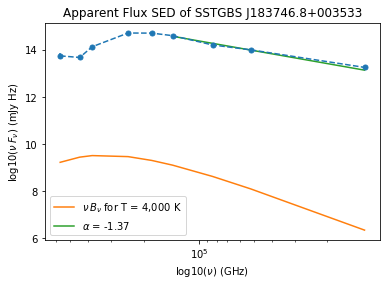

69
54649
The GB index 3375
RA:  279.45014662659435
DEC:  -0.2715059066943372
The difference in RA is  0.048 arcseconds
The difference in Dec is  0.268 arcseconds
The Gould_Belt_ID is  SSTGBS J183748.0+000-1617
alpha is -1.23
The object type is Galc_star+dust(IR4)
2MASS ID: b'18374802-0016170'
FLUX SIGNAL TO NOISE
[ 15.60390092 159.15255509  53.95527898  33.92925302  51.52119713
  43.2993527   20.32258065  20.33653846  20.32258065  19.94818653
  10.24911032]
SED Flux
[ 0.20499222  0.73209643  1.8083483   7.99629211 12.14228153 10.20459461
  5.67        4.23        5.67        3.85        5.76      ]
SED Flux Error
[0.01313724 0.00459997 0.03351569 0.23567545 0.23567545 0.23567545
 0.279      0.208      0.279      0.193      0.562     ]
The apparent magnitude in g is: 16.633614
The absolute magnitude in g is: 8.231395574350584
g-K is: 4.5956135
GB-GR is: 2.6888647
SED_nu_log
[14.06593238 14.51256804 14.8373727  15.2880424  15.34048998 15.15136382
 14.67928815 14.44947302 14.47160008 14.1

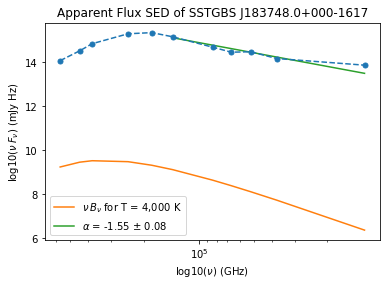

70
56913
71
51667
The GB index 3406
RA:  279.48389889127253
DEC:  -0.3415313111456956
The difference in RA is  0.018 arcseconds
The difference in Dec is  0.254 arcseconds
The Gould_Belt_ID is  SSTGBS J183756.1+000-2029
alpha is -1.74
The object type is star+dust(IR4)
2MASS ID: b'18375612-0020291'
FLUX SIGNAL TO NOISE
[  3.47285198 185.90782353  24.52505054  14.47648106  20.47740012
  16.69436587  19.85680191  18.84057971  19.85680191   9.0685413
   1.58663883]
SED Flux
[0.01708151 0.04360138 0.13421698 0.96491349 1.36489797 1.11274409
 0.832      0.65       0.832      0.516      0.76      ]
SED Flux Error
[4.91858181e-03 2.34532243e-04 5.47264842e-03 6.66538700e-02
 6.66538700e-02 6.66538700e-02 4.19000000e-02 3.45000000e-02
 4.19000000e-02 5.69000000e-02 4.79000000e-01]
The apparent magnitude in g is: 19.696283
The absolute magnitude in g is: 11.694437238304554
g-K is: 5.252283
GB-GR is: 2.5632076
SED_nu_log
[12.98672118 13.28749997 13.70789807 14.36964212 14.39128987 14.18896336
 13.

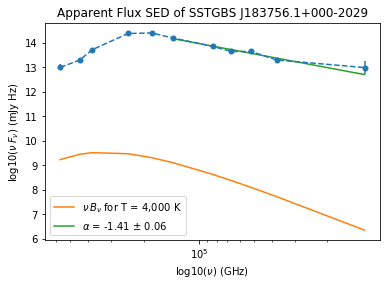

72
51542
The GB index 3417
RA:  279.4923836198011
DEC:  -0.39197243585457325
The difference in RA is  0.119 arcseconds
The difference in Dec is  0.162 arcseconds
The Gould_Belt_ID is  SSTGBS J183758.2+000-2331
alpha is -0.6
The object type is star+dust(MP1)
2MASS ID: b'18375816-0023310'
FLUX SIGNAL TO NOISE
[  5.354151   185.28527399  27.11169494  15.96670753  18.35806837
  19.0161766   19.60893855  15.69620253  19.60893855   2.89839572
   3.51295337]
SED Flux
[2.30316985e-02 4.07819040e-02 1.28986433e-01 9.72944379e-01
 1.11866391e+00 1.15876627e+00 7.02000000e-01 4.96000000e-01
 7.02000000e-01 2.71000000e-01 6.78000000e+01]
SED Flux Error
[4.30165278e-03 2.20103320e-04 4.75759385e-03 6.09358177e-02
 6.09358177e-02 6.09358177e-02 3.58000000e-02 3.16000000e-02
 3.58000000e-02 9.35000000e-02 1.93000000e+01]
The apparent magnitude in g is: 19.768866
The absolute magnitude in g is: 11.270184891308329
g-K is: 5.368866
GB-GR is: 2.195549
SED_nu_log
[13.11652097 13.25846725 13.69063465 14.37

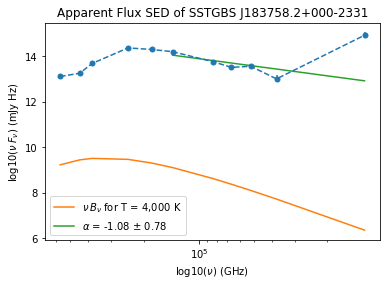

73
57219
The GB index 3435
RA:  279.5197148916612
DEC:  0.7441423868430713
The difference in RA is  0.23 arcseconds
The difference in Dec is  0.265 arcseconds
The Gould_Belt_ID is  SSTGBS J183804.7+004439
alpha is -1.59
The object type is star+dust(MP1)
2MASS ID: b'18380474+0044390'
FLUX SIGNAL TO NOISE
[ 13.71713093 443.52129883 154.59747238  30.15934108  43.45437618
  37.43939642   1.           1.           1.           1.
   5.24752475]
SED Flux
[ 6.91462681e-02  3.19831014e-01  8.07731330e-01  3.50661755e+00
  5.05242729e+00  4.35306740e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.06000000e+00]
SED Flux Error
[ 5.04086958e-03  7.21117598e-04  5.22473827e-03  1.16269700e-01
  1.16269700e-01  1.16269700e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.02000000e-01]
The apparent magnitude in g is: 17.532732
The absolute magnitude in g is: 9.014228494383008
g-K is: 4.5697317
GB-GR is: 2.9937496
MIPS 1 IS MISSING
SED_nu_log
[13.59396375 

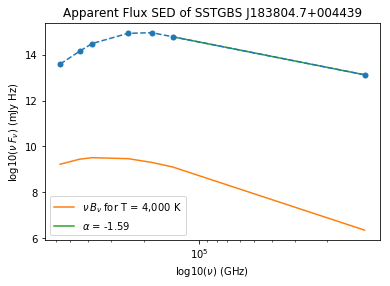

74
51872
The GB index 3465
RA:  279.56380807438825
DEC:  -0.359721558091634
The difference in RA is  0.011 arcseconds
The difference in Dec is  0.071 arcseconds
The Gould_Belt_ID is  SSTGBS J183815.3+000-2135
alpha is -1.25
The object type is star+dust(IR2)
2MASS ID: b'18381531-0021350'
FLUX SIGNAL TO NOISE
[  3.77939811 199.19688229  15.00738577  20.48558884  33.27056547
  31.25762649  19.16859122  19.37669377  19.16859122  16.44880174
   1.80141844]
SED Flux
[0.01082778 0.05926316 0.19905601 1.38448477 2.24853635 2.11249518
 1.66       1.43       1.66       1.51       0.508     ]
SED Flux Error
[0.00286495 0.00029751 0.01326387 0.06758335 0.06758335 0.06758335
 0.0866     0.0738     0.0866     0.0918     0.282     ]
The apparent magnitude in g is: 19.363071
The absolute magnitude in g is: 11.031895684331225
g-K is: 5.6150713
GB-GR is: 3.4860935
SED_nu_log
[12.78873457 13.42078454 13.87906592 14.52644193 14.6080896  14.46736379
 14.14581318 13.97846869 13.93812511 13.75666852 12.80531

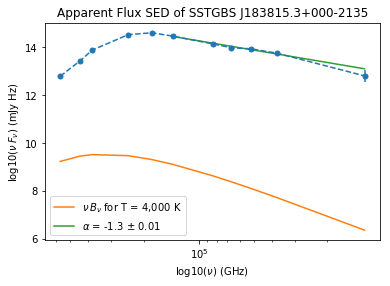

75
57159
The GB index 3478
RA:  279.59830455650985
DEC:  0.8523970128544923
The difference in RA is  0.072 arcseconds
The difference in Dec is  0.27 arcseconds
The Gould_Belt_ID is  SSTGBS J183823.6+005109
alpha is -1.02
The object type is star+dust(MP1)
2MASS ID: b'18382359+0051087'
FLUX SIGNAL TO NOISE
[ 4.53266364 99.32461938 32.27860455 27.83938885 43.98163176 48.23550807
  1.          1.          1.          1.          8.57768053]
SED Flux
[ 1.17441006e-02  1.28490359e-01  3.88192624e-01  2.35335946e+00
  3.71791887e+00  4.07751369e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.92000000e+00]
SED Flux Error
[ 2.59099319e-03  1.29364058e-03  1.20263137e-02  8.45334455e-02
  8.45334455e-02  8.45334455e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.57000000e-01]
The apparent magnitude in g is: 18.522858
The absolute magnitude in g is: 10.508924553734161
g-K is: 5.4888573
GB-GR is: 4.1230717
MIPS 1 IS MISSING
SED_nu_log
[12.82401477 13

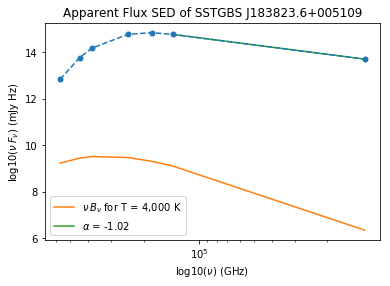

76
56866
The GB index 3488
RA:  279.6340291439558
DEC:  0.7408494598774539
The difference in RA is  0.428 arcseconds
The difference in Dec is  0.056 arcseconds
The Gould_Belt_ID is  SSTGBS J183832.1+004427
alpha is -2.17
The object type is star+dust(MP1)
2MASS ID: b'18383214+0044271'
FLUX SIGNAL TO NOISE
[ 56.30613713 939.98976133  47.92873998  49.35164737  38.78939607
  29.51269803  16.56074766   1.          16.56074766   1.
  10.64220183]
SED Flux
[ 122.53872681  128.04885864  219.32331848  319.21868896  250.89942932
  190.89544678   88.6        -999.           88.6        -999.
   11.6       ]
SED Flux Error
[ 2.17629433e+00  1.36223674e-01  4.57602930e+00  6.46824789e+00
  6.46824789e+00  6.46824789e+00  5.35000000e+00 -9.99000000e+02
  5.35000000e+00 -9.99000000e+02  1.09000000e+00]
The apparent magnitude in g is: 11.026594
The absolute magnitude in g is: 2.5221355932648297
g-K is: 2.1685944
GB-GR is: 0.9570322
MIPS 1 IS MISSING
SED_nu_log
[16.84246837 16.75537546 16.92117542 16.8

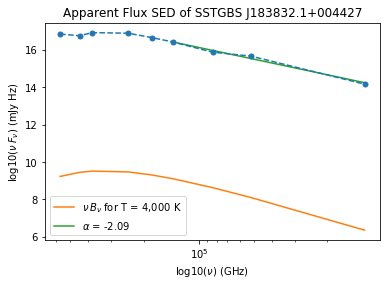

77
56967
The GB index 3489
RA:  279.6352128856142
DEC:  0.7541730458609259
The difference in RA is  0.085 arcseconds
The difference in Dec is  0.151 arcseconds
The Gould_Belt_ID is  SSTGBS J183832.5+004515
alpha is -0.91
The object type is star+dust(MP1)
2MASS ID: b'18383245+0045151'
FLUX SIGNAL TO NOISE
[ 13.44534802 395.88886014  65.8857216   31.02103496  49.37060837
  47.42026295  20.10869565   1.          20.10869565   1.
  10.30721966]
SED Flux
[ 3.71165462e-02  2.53899723e-01  7.11602628e-01  3.53580284e+00
  5.62730217e+00  5.40500021e+00  3.70000000e+00 -9.99000000e+02
  3.70000000e+00 -9.99000000e+02  6.71000000e+00]
SED Flux Error
[ 2.76054931e-03  6.41340914e-04  1.08005591e-02  1.13980815e-01
  1.13980815e-01  1.13980815e-01  1.84000000e-01 -9.99000000e+02
  1.84000000e-01 -9.99000000e+02  6.51000000e-01]
The apparent magnitude in g is: 17.783379
The absolute magnitude in g is: 9.660456331847996
g-K is: 5.055379
GB-GR is: 3.5316792
MIPS 1 IS MISSING
SED_nu_log
[13.32376256 

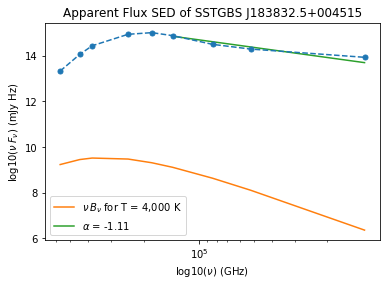

78
51619
The GB index 3512
RA:  279.6944761510876
DEC:  -0.4302043796431921
The difference in RA is  0.047 arcseconds
The difference in Dec is  0.136 arcseconds
The Gould_Belt_ID is  SSTGBS J183846.7+000-2549
alpha is -1.53
The object type is Galc_star+dust(IR4)
2MASS ID: b'18384667-0025486'
FLUX SIGNAL TO NOISE
[ 10.62283459 300.59562096  74.86903168  33.92925569  43.65016752
  42.58740166  19.79899497  20.42253521  19.79899497  17.45350501
   5.6097561 ]
SED Flux
[0.01608642 0.12698033 0.41432112 2.48707247 3.19963193 3.12172937
 1.97       1.45       1.97       1.22       1.15      ]
SED Flux Error
[0.00151432 0.00042243 0.00553395 0.07330171 0.07330171 0.07330171
 0.0995     0.071      0.0995     0.0699     0.205     ]
The apparent magnitude in g is: 18.535692
The absolute magnitude in g is: 10.39578675279363
g-K is: 5.211692
GB-GR is: 3.8521976
SED_nu_log
[12.96065436 13.75173621 14.19742769 14.78084219 14.76128971 14.63696331
 14.22017132 13.98450066 14.01248325 13.6640514  13.16

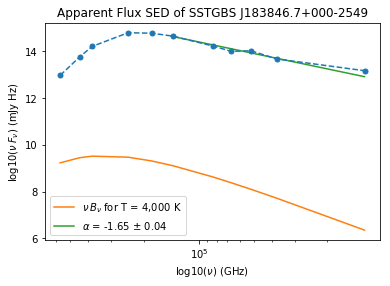

79
54801
The GB index 3530
RA:  279.7188923957327
DEC:  -0.07835774164619097
The difference in RA is  0.017 arcseconds
The difference in Dec is  0.246 arcseconds
The Gould_Belt_ID is  SSTGBS J183852.5+000-442
alpha is -1.19
The object type is Galc_star+dust(IR3)
2MASS ID: b'18385254-0004418'
FLUX SIGNAL TO NOISE
[  4.8265677  261.10931245  51.35917492  28.57200596  42.04865101
  37.93567544  19.65317919  19.7761194   19.65317919  13.37662338
   6.65306122]
SED Flux
[0.00831547 0.07962924 0.23795991 1.48760819 2.18927288 1.97512984
 1.36       1.06       1.36       1.03       1.63      ]
SED Flux Error
[0.00172285 0.00030497 0.00463325 0.05206523 0.05206523 0.05206523
 0.0692     0.0536     0.0692     0.077      0.245     ]
The apparent magnitude in g is: 19.042353
The absolute magnitude in g is: 10.68144269863381
g-K is: 5.2213526
GB-GR is: 3.966545
SED_nu_log
[12.67408191 13.54907233 13.9565944  14.55764231 14.59648958 14.43816371
 14.059244   13.84843852 13.85155593 13.5905288  13.31

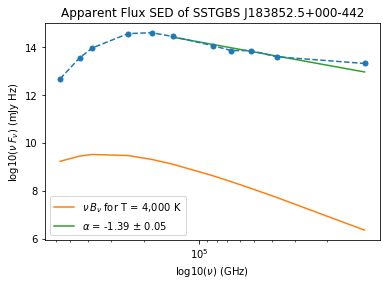

80
57296
The GB index 3549
RA:  279.7630502739988
DEC:  0.8721223559850535
The difference in RA is  0.284 arcseconds
The difference in Dec is  0.265 arcseconds
The Gould_Belt_ID is  SSTGBS J183903.1+005220
alpha is -1.11
The object type is star+dust(MP1)
2MASS ID: b'18390311+0052197'
FLUX SIGNAL TO NOISE
[13.73787015 56.13891465 18.18765122 31.93341739 45.17073651 44.47879859
  1.          1.          1.          1.          8.18376068]
SED Flux
[ 3.32424156e-02  2.14863405e-01  6.07120633e-01  3.58169031e+00
  5.06640387e+00  4.98879528e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.83000000e+00]
SED Flux Error
[ 2.41976487e-03  3.82735231e-03  3.33809257e-02  1.12161197e-01
  1.12161197e-01  1.12161197e-01 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  4.68000000e-01]
The apparent magnitude in g is: 17.964628
The absolute magnitude in g is: 9.535512220628592
g-K is: 5.1496286
GB-GR is: 3.47896
MIPS 1 IS MISSING
SED_nu_log
[13.27588758 13.98

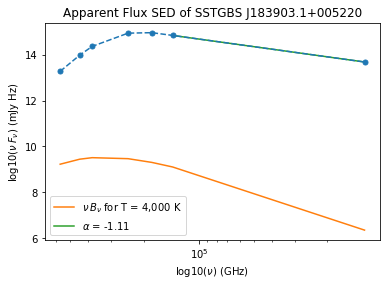

81
56093
The GB index 3625
RA:  279.9477053253108
DEC:  0.4896973059229912
The difference in RA is  0.098 arcseconds
The difference in Dec is  0.104 arcseconds
The Gould_Belt_ID is  SSTGBS J183947.5+002923
alpha is -1.54
The object type is Galc_star+dust(IR3)
2MASS ID: b'18394744+0029230'
FLUX SIGNAL TO NOISE
[  4.4674674  152.88921854  18.89931421  24.67582228  32.09837695
  31.54850671  19.04191617  20.35541195  19.04191617  17.45762712
   3.06008584]
SED Flux
[0.01565754 0.10222416 0.30698162 1.63714957 2.12960863 2.09312677
 1.59       1.26       1.59       1.03       0.713     ]
SED Flux Error
[0.00350479 0.00066862 0.016243   0.0663463  0.0663463  0.0663463
 0.0835     0.0619     0.0835     0.059      0.233     ]
The apparent magnitude in g is: 18.77115
The absolute magnitude in g is: 10.703570205320727
g-K is: 5.01315
GB-GR is: 3.5559769
SED_nu_log
[12.94891844 13.65755328 14.06720299 14.5992421  14.58448948 14.46336359
 14.12710222 13.9235032  13.91941414 13.5905288  12.9525436

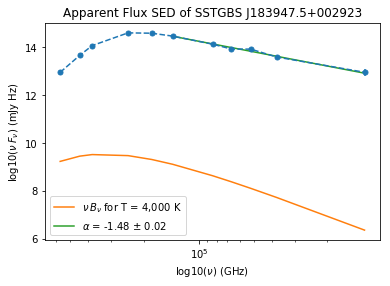

In [25]:
for i in range(len(SD_id_vals)):
    print(i)
    id_val = int(SD_id_vals[i])
    print(id_val)
    if (id_val != 59418 and id_val != 35960 and id_val != 32502 and id_val != 56913):
        Values = SEDCreator(id_val,SD_match,'S+D','Star+Dust_SEDS',0,0)

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log10
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10


The c2d index is 29
RA:  277.06304923179613
DEC:  -0.044776938699380084
The difference in RA is  0.4894855340126014 arcseconds
The difference in Decliantion is  0.08878068223168722 arcseconds
The c2d_ID is  SSTc2d J182815.2+000-241
alpha is 1.03
The object type is star+dust(MP1)
2MASS ID: b'18281511-0002412'
FLUX SIGNAL TO NOISE
[ 41.47754625 255.82317213 104.79318291          nan          nan
          nan  18.50340136  15.75221239  18.50340136   4.
  10.81081081]
SED Flux
[3.01547766e-01 1.40886104e+00 3.99361658e+00 3.93448677e+01
 4.09543648e+01 8.77396317e+01 2.72000000e+01 1.78000000e+01
 2.72000000e+01 1.00000000e+01 1.20000000e+03]
SED Flux Error
[7.27014476e-03 5.50716743e-03 3.81095074e-02            nan
            nan            nan 1.47000000e+00 1.13000000e+00
 1.47000000e+00 2.50000000e+00 1.11000000e+02]
The apparent magnitude in g is: 15.922864
The absolute magnitude in g is: 7.697627958290562
g-K is: 6.2208643
GB-GR is: 3.1300297
SED_nu_log
[14.23355112 14.79686791 15

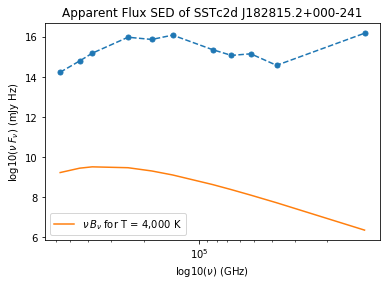

The c2d index is 147
RA:  277.42211567160405
DEC:  1.120441047582177
The difference in RA is  0.05641777456730779 arcseconds
The difference in Decliantion is  0.1726287041626584 arcseconds
The c2d_ID is  SSTc2d J182941.3+010714
alpha is -1.44
The object type is star+dust(IR3)
2MASS ID: b'18294129+0107137'
FLUX SIGNAL TO NOISE
[  2.076518   127.4311081   34.72307764          nan          nan
          nan  20.3187251   20.60606061  20.3187251   17.09265176
   2.49333333]
SED Flux
[0.00911966 0.03641252 0.1251833  3.03450918 1.42396688 3.73590469
 1.53       1.36       1.53       1.07       0.748     ]
SED Flux Error
[4.39180201e-03 2.85742804e-04 3.60519020e-03            nan
            nan            nan 7.53000000e-02 6.60000000e-02
 7.53000000e-02 6.26000000e-02 3.00000000e-01]
The apparent magnitude in g is: 19.891907
The absolute magnitude in g is: 12.041908128795617
g-K is: 6.762907
GB-GR is: 3.1689243
SED_nu_log
[12.71417346 13.20925051 13.67763701 14.8672422  14.40968957 14.714

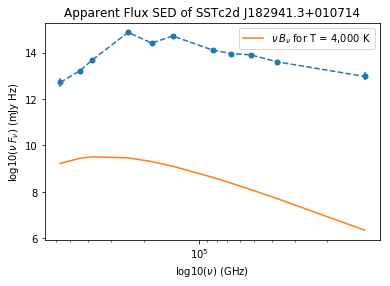

/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:223: UserWarning: Warning: converting a masked element to nan.
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:264: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:265: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:267: RuntimeWarning: invalid value encountered in greater_equal
/Users/roxanapopescu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:268: RuntimeWarning: invalid value encountered in g

The c2d index is 201
RA:  277.5220272939675
DEC:  0.6129141418566767
The difference in RA is  0.13245828288290795 arcseconds
The difference in Decliantion is  0.24176931596371354 arcseconds
The c2d_ID is  SSTc2d J183005.3+003647
alpha is -1.49
The object type is star+dust(MP1)
2MASS ID: b'18300528+0036465'
FLUX SIGNAL TO NOISE
[         nan 232.73055665          nan  29.34422136  60.88836525
  67.58187934   1.           1.           1.           1.
   7.5984252 ]
SED Flux
[            nan  5.90422750e-02             nan  2.70201778e+00
  5.60660458e+00  6.22294378e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.93000000e+00]
SED Flux Error
[            nan  2.53693695e-04             nan  9.20800641e-02
  9.20800641e-02  9.20800641e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  2.54000000e-01]
The apparent magnitude in g is: 19.367126
The absolute magnitude in g is: 10.694861734999574
g-K is: 6.7921267
GB-GR is: --
MIPS 1 IS MISSING
SED_nu

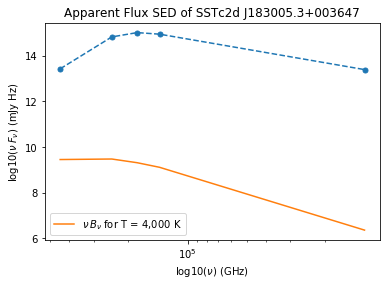

The GB index 3380
RA:  279.4566600416312
DEC:  0.7443471880821725
The difference in RA is  0.296 arcseconds
The difference in Dec is  0.309 arcseconds
The Gould_Belt_ID is  SSTGBS J183749.6+004440
alpha is -1.37
The object type is star+dust(MP1)
2MASS ID: b'18374957+0044399'
FLUX SIGNAL TO NOISE
[        nan 52.55089464         nan 22.61950296 43.20107158 54.59970449
  1.          1.          1.          1.          5.86956522]
SED Flux
[            nan  5.01282886e-02             nan  1.92348373e+00
  3.67366862e+00  4.64296865e+00 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  1.89000000e+00]
SED Flux Error
[            nan  9.53899813e-04             nan  8.50365162e-02
  8.50365162e-02  8.50365162e-02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02  3.22000000e-01]
The apparent magnitude in g is: 19.544827
The absolute magnitude in g is: 11.174603045317047
g-K is: 6.651827
GB-GR is: --
MIPS 1 IS MISSING
SED_nu_log
[13.34808263 14.66924226 14.8212

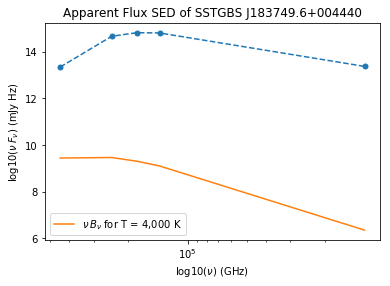

In [19]:
#Attempt to plot the S+D that wont plot for some reason

#run the all sed function before running this one b/c i am adding values onto an array

Values1 = SEDCreator(59418,SD_match,'S+D','Star+Dust_SEDS2',0,0,Fit=False)
SED_fluxes = np.vstack((SED_fluxes,Values1['SED_flux']))
Values2 = SEDCreator(35960,SD_match,'S+D','Star+Dust_SEDS2',0,0,Fit=False)
SED_fluxes = np.vstack((SED_fluxes,Values2['SED_flux']))
Values3 = SEDCreator(32502,SD_match,'S+D','Star+Dust_SEDS2',0,0,Fit=False)
SED_fluxes = np.vstack((SED_fluxes,Values3['SED_flux']))
Values4 = SEDCreator(56913,SD_match,'S+D','Star+Dust_SEDS2',0,0,Fit=False)
SED_fluxes = np.vstack((SED_fluxes,Values4['SED_flux']))

In [20]:
#INFO ABOUT THE SED FLUXES
print('TOTAL NUMBER OF S+Ds:',len(SED_fluxes))

#properties of IRAC 3 BAND
SED_fluxes2 = SED_fluxes[np.where(SED_fluxes[:,8] > -1)]
print('NUMBER OF S+D with IRAC3:',len(SED_fluxes2))

print('mean:',np.mean(SED_fluxes2[:,8]))
print('median:',np.median(SED_fluxes2[:,8]))
print('min:',np.min(SED_fluxes2[:,8]))
print('max:',np.max(SED_fluxes2[:,8]))

TOTAL NUMBER OF S+Ds: 82
NUMBER OF S+D with IRAC3: 42
mean: 59.65185714285714
median: 3.6950000000000003
min: 0.695
max: 1450.0


In [23]:
#SED of outlier source
num = np.where(SED_fluxes[:,8] == 1450.0)
print(num)
print(SED_fluxes[num])

(array([38]),)
[[1.97612252e-02 1.04508772e-01 5.22080004e-01 2.72450958e+02
  1.01835693e+03 1.82808142e+03 1.45000000e+03 1.64000000e+03
  1.45000000e+03 1.66000000e+03 6.90000000e+02]]


In [ ]:
#ALL GALC
GALC_ALL = CalculateProperties('All','Galc',GALC_match,Gvalues,distance_range=[350.,550.])

In [ ]:
#DETERMINE WHICH galc COULD BE YSOs
GALC_id_vals = GALC_ALL['id']
g_alphas = np.array([])
g_alpha_errs = np.array([])
for i in range(len(GALC_id_vals)):
    print(i)
    id_val = int(GALC_id_vals[i])
    print(id_val)
    Values = SEDCreator(id_val,GALC_match,'Galc','Galc_SEDS',0,0)
    g_alphas = np.append(g_alphas,Values['alpha'])
    g_alpha_errs = np.append(g_alpha_errs, Values['alpha_e'])
           

Number of All matches in the correct distance interval: 147
Number of _match with parallax > 5, 10, 20:  135 86 43
For all stars in region
The mean velocity in ra is  5.088614554878728 +/- 0.263163713731217
The mean velocity in dec is  -15.883223357672083 +/- 0.47228346954285033
The median velocity in ra is  5.945705108420212 +/- 0.3298268028477835
The median velocity in dec is  -16.976615792259537 +/- 0.5919195491984688
The mean magnitude of velocity is 17.532150680395958 +/- 0.30598982647783296
The median magnitude of velocity is 18.145427185349604 +/- 0.3835013753993848
The standard deviation of velocity is 3.7099294824115385
The median parallax is 2.23829890655066 with a standard deviation of 0.2316646427527986
The median distance is 446.7678544064761 with a standard deviation of 46.46531915646724
For parallax S/N > 10 stars:
The mean velocity in ra is  5.366214797096912 +/- 0.3413222154945661
The mean velocity in dec is  -15.452831767729315 +/- 0.7538078148492561
The median veloci

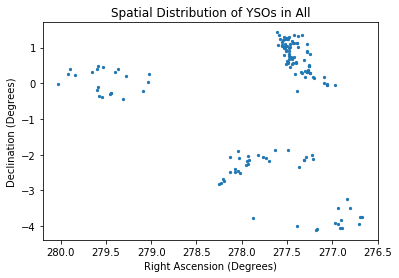

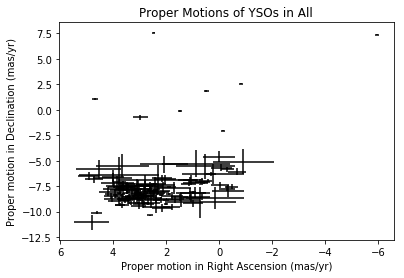

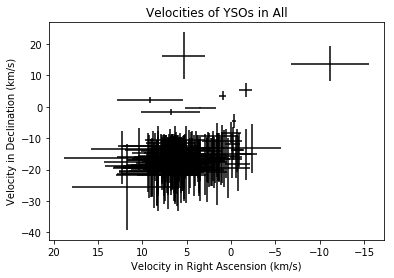

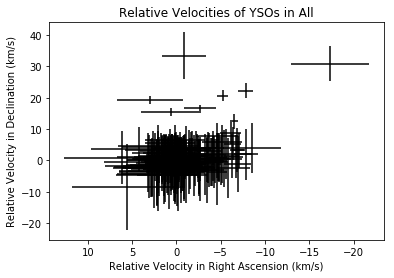

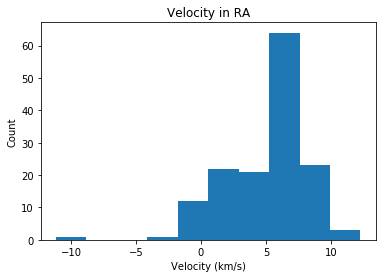

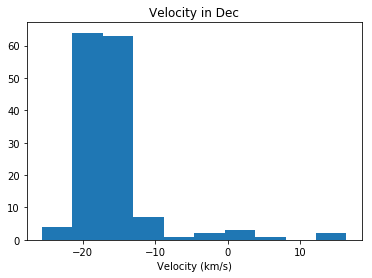

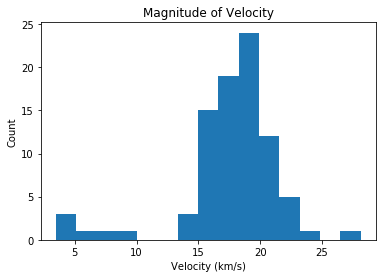

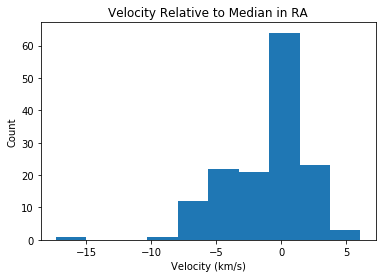

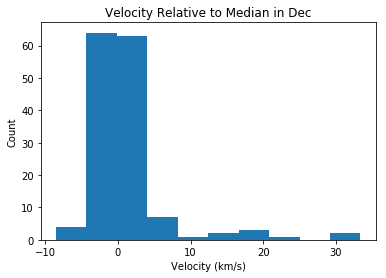

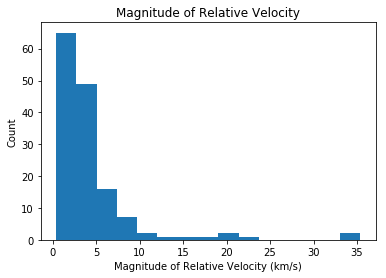

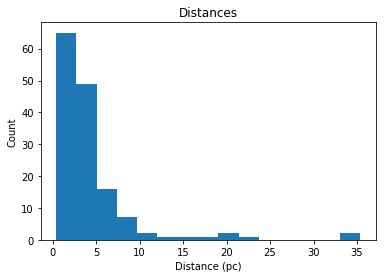

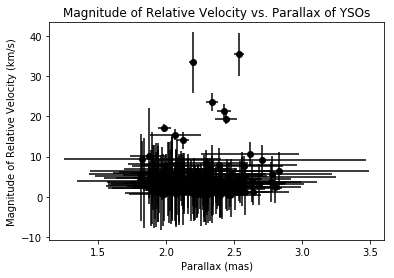

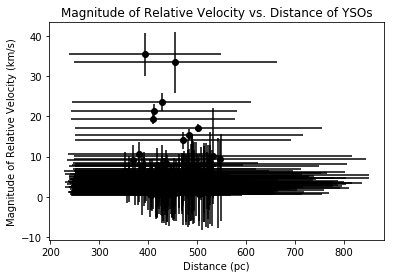

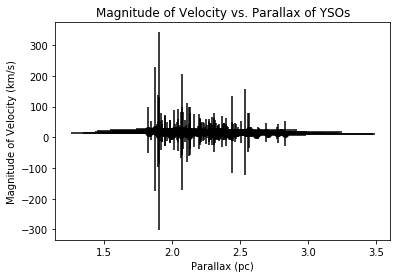

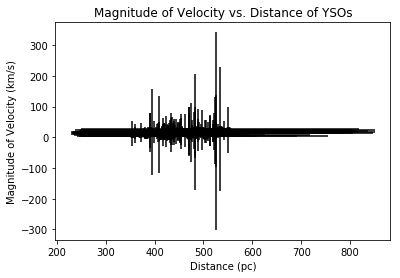

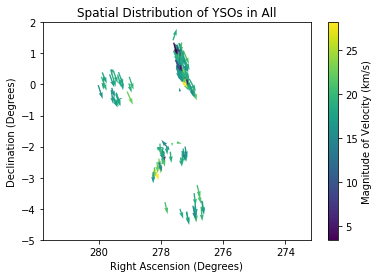

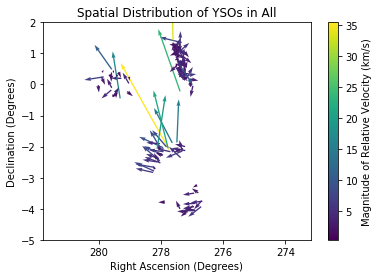

In [81]:
#All YSOs
adj1 = [0,0,0,0]
adj=[1,6,1,6]
YSO_ALL = CalculateProperties('All','YSOs',YSO_match,Gvalues,distance_range=[350.,550.])

In [82]:
#Read Star+Dust of chosen sources from gaia into table file

#create array of indices of GTab and make sure they are ints
vals = np.arange(0,len(GTab),1)
vals = vals.astype(np.int64)
print(len(GTab))

#go through all these indices and see if they match with s+d indices, if so exclude them from sources to remove list
not_yso_vals = np.array([])
for i in range(len(GTab)):
    if (not np.any(YSO_ALL['id'][:] == vals[i])):
        not_yso_vals = np.append(not_yso_vals,vals[i])
not_yso_vals = not_yso_vals.astype(np.int64)      
print(len(vals)-len(not_yso_vals))

YSO_GTab = copy.deepcopy(GTab)
YSO_GTab.remove_rows(not_yso_vals)
astropy.io.misc.fnpickle(YSO_GTab,'YSO_Gaia.pkl')

61441
147


In [ ]:
#Plot of YSOs, star +dust and GalC in GAIA
figure = plt.figure()
plt.scatter(SD_ALL['ra'],SD_ALL['dec'],c='b',s=2,label='GAIA Star+Dust')
plt.scatter(YSO_ALL['ra'],YSO_ALL['dec'],c='r',s=2,label='GAIA YSOs')
plt.scatter(GALC_ALL['ra'],GALC_ALL['dec'],c='lime',s=2,label = 'GAIA Galc')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs and Star+Dust Detected by GAIA in the Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
#plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3,height3,fill=False))
#indicate side region that was used for gaia sources comparison with W40
#plt.gca().add_patch(Rectangle((sky_regionW40side[0],sky_regionW40side[2]),widthW40,heightW40,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/StarPlots/YSO_SD_plot.png',dpi=600)
plt.show()

In [ ]:
#Plot of YSOs and star +dust (selected by alpha) in GAIA
figure = plt.figure()
plt.scatter(YSO_ALL['ra'],YSO_ALL['dec'],c='r',s=2,label='GAIA YSOs')
plt.scatter(PossibleYSOs['ra'],PossibleYSOs['dec'],c='b',s=2,label='GAIA Star+Dust Possible YSOs')
#plt.scatter(GALC_ALL['ra'],GALC_ALL['dec'],c='lime',s=2,label = 'GAIA Galc')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs and Star+Dust Detected by GAIA in the Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
#plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3,height3,fill=False))
#indicate side region that was used for gaia sources comparison with W40
#plt.gca().add_patch(Rectangle((sky_regionW40side[0],sky_regionW40side[2]),widthW40,heightW40,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/StarPlots/YSO_POSSIBLE_YSOS_plot.png',dpi=600)
plt.show()

In [ ]:
#Plot of proper motions

plt.errorbar(SD_ALL['pmra'],SD_ALL['pmdec'],xerr=SD_ALL['pmra_e'],yerr = SD_ALL['pmdec_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.25)
plt.errorbar(YSO_ALL['pmra'],YSO_ALL['pmdec'],xerr=YSO_ALL['pmra_e'],yerr = YSO_ALL['pmdec_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5,alpha=0.25)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_all.png',dpi=300)
plt.show()

plt.errorbar(YSO_ALL['pmra'],YSO_ALL['pmdec'],xerr=YSO_ALL['pmra_e'],yerr = YSO_ALL['pmdec_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5,alpha=0.25)
plt.errorbar(SD_ALL['pmra'],SD_ALL['pmdec'],xerr=SD_ALL['pmra_e'],yerr = SD_ALL['pmdec_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_all2.png',dpi=300)
plt.show()

plt.errorbar(SD_ALL['pmra'],SD_ALL['pmdec'],xerr=SD_ALL['pmra_e'],yerr = SD_ALL['pmdec_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_SD.png',dpi=300)
plt.show()

plt.errorbar(YSO_ALL['pmra'],YSO_ALL['pmdec'],xerr=YSO_ALL['pmra_e'],yerr = YSO_ALL['pmdec_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_YSO.png',dpi=300)
plt.show()

#histogram of proper motions
SD_pm = np.sqrt(np.square(SD_ALL['pmra'])+np.square(SD_ALL['pmdec']))
YSO_pm = np.sqrt(np.square(YSO_ALL['pmra'])+np.square(YSO_ALL['pmdec']))
plt.hist(SD_pm,bins=10)
plt.title('Star+Dust Proper Motions')
plt.xlabel('Proper Motion (mas/yr)')
plt.ylabel('Count')
plt.savefig('Figures/proper_motions_hist_YSO.png',dpi=300)
plt.show()
print('There are ',len(YSO_pm),'YSOs with a median proper motion of ',np.median(YSO_pm),'and stdev of',np.std(YSO_pm))

plt.hist(YSO_pm,bins=10)
plt.title('YSO Proper Motions')
plt.xlabel('Proper Motion (mas/yr)')
plt.ylabel('Count')
plt.savefig('Figures/proper_motions_hist_SD.png',dpi=300)
plt.show()
print('There are ',len(SD_pm),'S+D with a median proper motion of ',np.median(SD_pm),'and stdev of',np.std(SD_pm))


In [ ]:
#i currently have no better idea how to filter using two conditions
Gdist2 = Gdist[Gdist >= 350]
Gpmra2 = Gpmra[Gdist >= 350]
Gpmdec2 = Gpmdec[Gdist >= 350]
Gpmra_e2 = Gpmra_e[Gdist >= 350]
Gpmdec_e2 = Gpmdec_e[Gdist >= 350]

#zoomed in plot
plt.errorbar(Gpmra2[Gdist2 <= 550],Gpmdec2[Gdist2 <= 550],xerr=Gpmra_e2[Gdist2 <= 550],\
             yerr = Gpmdec_e2[Gdist2 <= 550],linestyle='None',\
             color='black',marker='o',markersize=2.5,alpha=0.25)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/proper_motions_AllGaiaStars_zoom.png',dpi=300)
plt.show()

#all plot
plt.errorbar(Gpmra2[Gdist2 <= 550],Gpmdec2[Gdist2 <= 550],xerr=Gpmra_e2[Gdist2 <= 550],
             yerr = Gpmdec_e2[Gdist2 <= 550],linestyle='None'\
            ,color='black',marker='o',markersize=2.5,alpha=0.25)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.savefig('Figures/proper_motions_AllGaiaStars.png',dpi=300)
plt.show()

#zoomed in plot with ysos and s+d overlapping
plt.errorbar(Gpmra2[Gdist2 <= 550],Gpmdec2[Gdist2 <= 550],xerr = Gpmra_e2[Gdist2 <= 550],\
             yerr=Gpmdec_e2[Gdist2 <= 550],linestyle='None'\
            ,color='black',label='Gaia Stars',marker='o',markersize=2.5,alpha=0.25)
plt.errorbar(YSO_ALL['pmra'],YSO_ALL['pmdec'],xerr = YSO_ALL['pmra_e'],yerr=YSO_ALL['pmdec_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5)
plt.errorbar(SD_ALL['pmra'],SD_ALL['pmdec'],xerr = SD_ALL['pmra_e'],yerr=SD_ALL['pmdec_e'],linestyle='None'\
            ,color='green',label='Star+Dust',marker='o',markersize=2.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_AllGaiaStars_zoom2.png',dpi=300)
plt.show()

# Look at SEDs of proper motion outliers in ALL Regions Combined

In [ ]:
#Print SEDs of outliers 

#condition
SD_pm_median = np.median(SD_pm)
YSO_pm_median = np.median(YSO_pm)
SD_pm_std = np.std(SD_pm)
YSO_pm_std = np.std(YSO_pm)

#Conditions
conditionSD = np.abs(SD_pm - SD_pm_median) > SD_pm_std
conditionYSO = np.abs(YSO_pm - YSO_pm_median) > YSO_pm_std

#name folders
folder1 = 'Outlier_All_pmmag_YSO'
folder2 = 'Outlier_All_pmmag_SD'

#FindOutlier(YSO_ALL,YSO_match,'YSO',conditionYSO,folder1)
FindOutlier(SD_ALL,SD_match,'S+D',conditionSD,folder2,shift1=5)

In [ ]:
#Figure out why some outliers are not classified as outliers with the given method
print(SD_pm_std)

what = np.abs(SD_pm - SD_pm_median)
print(what)
n = 0
for i in range(len(what)):
    if (what[i] > SD_pm_std):
        print(what[i])
        n += 1
print(n)

In [ ]:
plt.errorbar(SD_ALL['pmra'],SD_ALL['pmdec'],xerr=SD_ALL['pmra_e'],yerr = SD_ALL['pmdec_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_ALL['pmra'][conditionSD],SD_ALL['pmdec'][conditionSD],xerr=SD_ALL['pmra_e'][conditionSD],\
             yerr = SD_ALL['pmdec_e'][conditionSD],linestyle='None',color='magenta',label='Outlier',\
             marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions of Star+Dust')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_SD_OUTLIER.png',dpi=300)
plt.show()

plt.errorbar(YSO_ALL['pmra'],YSO_ALL['pmdec'],xerr=YSO_ALL['pmra_e'],yerr = YSO_ALL['pmdec_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_ALL['pmra'][conditionYSO],YSO_ALL['pmdec'][conditionYSO],xerr = YSO_ALL['pmra_e'][conditionYSO],\
             yerr=YSO_ALL['pmdec_e'][conditionYSO],linestyle='None',color='magenta',label='Outlier',
             marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions of YSOs')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_YSO_OUTLIER.png',dpi=300)
plt.show()



# Compare distribution of stars/ysos outside distance range

In [ ]:
#YSOs before distance range
adj1 = [0,0,0,0]
adj=[1,6,1,6]
YSO_before = CalculateProperties('All','YSOs_before',YSO_match,Gvalues,distance_range=[0,350],exclude = [59408,32169,35855,3580])

In [ ]:
#Print out information about foreground YSOs

for i in range(len(YSO_before['dist'])):
    print(i,YSO_before['id'][i],YSO_before['par_sn'][i],YSO_before['par'][i],\
          YSO_before['dist'][i],YSO_before['dec'][i])

In [ ]:

print(np.mean(YSO_before['par']))
print(np.std(YSO_before['par']))
par = YSO_before['par']
par_e = YSO_before['par_e']

lower = np.round((par - par_e),3)*1000
higher = np.round((par + par_e),3)*1000

lower = lower.astype(int)
higher = higher.astype(int)

print(par)
print(par_e)
print(lower)
print(higher)

#fill an array with randomly generated values
num_rows = 10
distributions = np.ones((num_rows,len(par)))
for i in range(num_rows):
    for j in range(len(par)):
        distributions[i,j] = (np.random.randint(lower[j],higher[j]))/1000.
        
for i in range(num_rows):
    plt.hist(distributions[i,:])
    plt.show()

In [ ]:
#fitting a standard normal distribution to the data

#function for probability distribution of a gaussian
def gaussian(x,var,mu,height):
    
    pdf = height*(1/np.sqrt(2*math.pi*var))*np.exp(-((x-mu)**2)/(2*var**2))
    
    return pdf

import matplotlib.mlab as mlab
from astropy.modeling import models

#parameters for sample fit
#par_vals = np.random.normal(loc=5.0, scale=2.0, size=1000)
par_vals = YSO_before['par']
par_err = YSO_before['par_e']
n, bins, patches = plt.hist(par_vals,bins=17,edgecolor='black')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
mean = np.mean(par_vals)
median = np.median(par_vals)
stdev = np.std(par_vals)

#using astropy model
gmodel = models.Gaussian1D(amplitude=ymax,mean=mean,stddev=stdev)
x = np.linspace(xmin, xmax, 100)
plt.plot(x,gmodel(x),color='red')
plt.xlabel('Parallax')
plt.ylabel('Count')
plt.title('Parallax Distribution of Foreground YSOs')
plt.show()

print('The mean of the gaussian fit is',mean)

#generate population based on gaussian distribution
pop = np.random.normal(loc=mean, scale = stdev, size=17)
n, bins, patches = plt.hist(pop,bins=17,edgecolor='black')
plt.plot(x,gmodel(x),color='red')
plt.xlabel('Parallax')
plt.ylabel('Count')
plt.title('Parallax Distribution of Foreground YSOs')
plt.show()

#compare the two populations with a ks test
print(scipy.stats.ks_2samp(par_vals,pop))
print(scipy.stats.kstest(par_vals, 'norm'))

#need to figure out how to get chisquare to work with bins
#print(scipy.stats.chisquare(par_vals,pop))

In [ ]:
plt.axvline(x=mean,color='red',label = 'Median')
plt.axvline(x=mean+stdev,color='blue',label = '1$ \sigma$')
plt.axvline(x=mean-stdev,color='blue')
plt.errorbar(par_vals,YSO_before['pmmag_all'],xerr=par_err,ls='None',color='black',marker='.',markersize=10,capsize=10)
plt.xlabel('Parallax (mas)')
plt.ylabel('Velocity Magnitude (km/s)')
plt.title('Parallax Distribution of Foreground YSOs')
plt.legend()
plt.savefig('Figures/ForegroundYSOs.png',dpi=300)
plt.show()
print('The median is',median)

In [ ]:
plt.axvline(x=mean,color='red',label = 'Median')
plt.axvline(x=mean+stdev,color='blue',label = '1$ \sigma$')
plt.axvline(x=mean-stdev,color='blue')
plt.errorbar(par_vals,YSO_before['par_sn'],xerr=par_err,ls='None',color='black',marker='.',markersize=10,capsize=10)
plt.xlabel('Parallax (mas)')
plt.ylabel('Parallax Signal to Noise')
plt.title('Parallax Distribution of Foreground YSOs')
plt.legend()
plt.savefig('Figures/ForegroundYSOs2.png',dpi=300)
plt.show()
print('The median is',median)

In [ ]:
for i in range(len(YSO_before['id'])):
    gaia_id = int(YSO_before['id'][i])
    print(GTab["phot_g_mean_mag"][gaia_id])

In [ ]:
#remove closest yso
max_idx = np.argmax(par_vals)
par_vals2 = np.delete(par_vals,max_idx)
par_err2 = np.delete(par_err,max_idx)
print(YSO_before['ra'][max_idx])
print(YSO_before['dec'][max_idx])
gaia_id = int(YSO_before['id'][max_idx])
print(gaia_id)
print(G2MASS[gaia_id])

#remove highest signal to noise yso
min_idx = np.argmin(par_err)
par_vals3 = np.delete(par_vals,min_idx)
par_err3 = np.delete(par_err,min_idx)

#test if meets normal distribution
median = np.median(par_vals)
z = (par_vals-median)/par_err
a,b = scipy.stats.normaltest(z)
print('statstic:',a)
print('p-value:',b)

#test if meets normal distribution w/o outlier
median2 = np.median(par_vals2)
z2 = (par_vals2-median2)/par_err2
a2,b2 = scipy.stats.normaltest(z2)
print('statstic:',a2)
print('p-value:',b2)

#test if meets normal distribution
median3 = np.median(par_vals3)
z3 = (par_vals3-median3)/par_err3
a3,b3 = scipy.stats.normaltest(z3)
print('statstic:',a3)
print('p-value:',b3)

In [ ]:
#SED of really close source
Values = SEDCreator(int(YSO_before['id'][max_idx]),YSO_match,'YSO',"",shift1=0,shift2=0)

In [ ]:
#sed of suspected red giant source
Values = SEDCreator(3580,YSO_match,'YSO','',shift1 =10,shift2=0)

In [ ]:
SD_before = CalculateProperties('All','SD_before',SD_match,Gvalues,distance_range=[0,350])

In [ ]:
#Proper motions of before distance range

plt.errorbar(YSO_before['pmra'],YSO_before['pmdec'],yerr = YSO_before['pmdec_e'],xerr=YSO_before['pmra_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5,alpha=0.25)
plt.errorbar(SD_before['pmra'],SD_before['pmdec'],yerr = SD_before['pmdec_e'],xerr=SD_before['pmra_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions for Objects Before Distance Range')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_before2.png',dpi=300)
plt.show()

In [ ]:
#YSOs after distance range
adj1 = [0,0,0,0]
adj=[1,6,1,6]
YSO_after = CalculateProperties('All','YSOs_after',YSO_match,Gvalues,distance_range=[550,1000])

In [ ]:
SD_after = CalculateProperties('All','SD_after',SD_match,Gvalues,distance_range=[550,1000])

In [ ]:
#Proper motions of after distance range

plt.errorbar(YSO_after['pmra'],YSO_after['pmdec'],yerr = YSO_after['pmdec_e'],xerr=YSO_after['pmra_e'],linestyle='None'\
            ,color='red',label='YSOs',marker='o',markersize=2.5,alpha=0.25)
plt.errorbar(SD_after['pmra'],SD_after['pmdec'],yerr = SD_after['pmdec_e'],xerr=SD_after['pmra_e'],linestyle='None'\
            ,color='black',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions for Objects Beyond Distance Range')
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.legend()
plt.savefig('Figures/proper_motions_after2.png',dpi=300)
plt.show()

In [ ]:
for i in range(len(YSO_after['dist'])):
    print(YSO_after['par_sn'][i],YSO_after['dist'][i],YSO_after['ra'][i],YSO_after['dec'][i])

In [ ]:
#Distances Histogram!!

plt.hist(YSO_ALL['dist'],bins=10)
plt.title('YSO distances (within 350 and 550 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

plt.hist(SD_ALL['dist'],bins=10)
plt.title('S+D distances (within 350 and 550 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

plt.hist(YSO_before['dist'],bins=10)
plt.title('YSO distances (before 350 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

plt.hist(SD_before['dist'],bins=10)
plt.title('S+D distances (before 350 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

plt.hist(YSO_after['dist'],bins=10)
plt.title('YSO distances (after 550 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

plt.hist(SD_after['dist'],bins=10)
plt.title('S+D distances (after 550 pc)')
plt.xlabel('Distance (pc)')
plt.ylabel('Count')
plt.show()

# All YSOs and S+D in All Regions and Distances

In [ ]:
YSO_ALL2 = CalculateProperties('All','YSOs_AllDistances',YSO_match,Gvalues)

In [ ]:
SD_ALL2 = CalculateProperties('All','Star+Dust_AllDistances',SD_match,Gvalues)

# Verifying the CrossMatch

In [ ]:
#Print info about the the Gaia 2mass cross match radius
sep = GTab['angular_distance']
print('The mean separation is: ',np.mean(sep))
print('The median separation is ',np.median(sep))
print('The standard deviation of the separation is ',np.std(sep))

#Print info about YSOs in the 2Mass Gaia catalog
sep2 = GTab['angular_distance'][YSO_match[good_YSO]]
print('For YSOs:')
print('The mean separation is: ',np.mean(sep2))
print('The median separation is ',np.median(sep2))
print('The standard deviation of the separation is ',np.std(sep2))

#Check to see if angular distance is what i think it is
num = 67
ra_diff = np.abs(GTab['ra'][num]-GTab['ra_2'][num])
dec_diff = np.abs(GTab['dec'][num]-GTab['dec_2'][num])
calc_sep = np.sqrt(np.square(ra_diff)+np.square(dec_diff))
#print(calc_sep)
#print(sep[num])

#Print info about spitzer 2mass cross match

In [ ]:
# flags to look into
#'number_of_neighbours' 'number_of_mates', 'best_neighbour_multiplicity'

In [ ]:
#separation between Spitzer and 2MASS

In [ ]:
g_K = g - K
plt.scatter(g_K,g,c = 'black',alpha=0.5,s=3)
plt.gca().invert_yaxis()
plt.xlabel('g-K')
plt.ylabel('g')
plt.title('g vs. g-K for All Gaia Sources Cross-Matched with 2MASS')
plt.savefig('Figures/match_eval_g_gK_ALL.png',dpi=300)
plt.show()

In [ ]:
GB_GR = b-r
J_K = J - K
plt.scatter(J_K,GB_GR,c = 'black',alpha=0.5,s=3)
plt.xlabel('J-K')
plt.ylabel('GB-GR')
plt.title('GB-GR vs.  J-K for All Gaia Sources Cross-Matched with 2MASS')
plt.savefig('Figures/match_eval_GBGR_JK_ALL.png',dpi=300)
plt.show()

In [ ]:
for i in YSO_match[good_YSO]:
    g_K = g[i] - K[i]
    plt.scatter(g_K,g[i],c = 'black',alpha=0.5,s=3)
plt.xlabel('g-K')
plt.ylabel('g')
plt.gca().invert_yaxis()
plt.title('g vs. g-K for Cross-Matched YSOs')
plt.savefig('Figures/match_eval_g_gK.png',dpi=300)
plt.show()

In [ ]:
for i in YSO_match[good_YSO]:
    GB_GR = b[i]-r[i]
    J_K = J[i] - K[i]
    plt.scatter(J_K,GB_GR,c = 'black',alpha=0.5,s=3)
plt.xlabel('J-K')
plt.ylabel('GB-GR')
plt.title('GB-GR vs.  J-K for All Cross-Matched YSOs')
plt.savefig('Figures/match_eval_GBGR_JK.png',dpi=300)
plt.show()


# Star+Dust (need to limit by potential YSOs)

In [ ]:
SD_East = CalculateProperties('Serpens East','Star+Dust',SD_match,Gvalues,distance_range=[350.,550.], \
                               sky_region = sky_region1,adj=[0,0,0,0])

In [ ]:
SD_S = CalculateProperties('Serpens South','Star+Dust',SD_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionS,\
                           adj=[0,0,0,0])


In [ ]:
SD_W40 = CalculateProperties('W40','Star+Dust',SD_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionW40\
                             ,adj=[0,0,0,0])

In [ ]:
SD_WestArm = CalculateProperties('West Arm','Star+Dust',SD_match,Gvalues,distance_range=[350.,550.],\
                                  sky_region = sky_region2d)

In [ ]:
SD_Main = CalculateProperties('Serpens Main','Star+Dust',SD_match,Gvalues, distance_range=[350.,550.],sky_region = sky_region3, \
                               adj = [0,0,1,5])

In [ ]:
#proper motion plot labeled by region
plt.errorbar(SD_East['pmra'],SD_East['pmdec'],yerr = SD_East['pmdec_e'],xerr=SD_East['pmra_e'],linestyle='None'\
            ,color='orange',label='Serpens East',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_S['pmra'],SD_S['pmdec'],yerr = SD_S['pmdec_e'],xerr=SD_S['pmra_e'],linestyle='None'\
            ,color='red',label='Serpens South',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_W40['pmra'],SD_W40['pmdec'],yerr = SD_W40['pmdec_e'],xerr=SD_W40['pmra_e'],linestyle='None'\
            ,color='blue',label='W40',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_WestArm['pmra'],SD_WestArm['pmdec'],yerr = SD_WestArm['pmdec_e'],xerr=SD_WestArm['pmra_e'],linestyle='None'\
            ,color='magenta',label='West Arm',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_Main['pmra'],SD_Main['pmdec'],yerr = SD_Main['pmdec_e'],xerr=SD_Main['pmra_e'],linestyle='None'\
            ,color='green',label='Serpens Main',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/SDproper_motions_regions.png',dpi=300)
plt.show()

## YSOs

In [ ]:
#Plot of selected YSOs


figure = plt.figure()
plt.scatter(YSO_ALL['ra'],YSO_ALL['dec'],s=3)
plt.axis('equal')
plt.xlabel('Right Ascension (Degrees)')
plt.ylabel('Declination (Degrees)')
plt.title('Spatial Distribution of YSOs')
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3d,height3d,fill=False))
plt.text(ra_min1+0.2,dec_min1+0.1,'1')
plt.text(ra_minW40+0.2,dec_minW40+0.1,'2')
plt.text(ra_minS+0.2,dec_minS+0.1,'3')
plt.text(ra_min2d+0.2,dec_min2d+0.1,'4')
plt.text(ra_min3u+0.2,dec_min3u+0.1,'5')
plt.text(ra_min3d+0.2,dec_min3d+0.1,'6')
plt.gca().invert_xaxis()
plt.savefig("Figures/Regions.png",dpi=300)
plt.show()



In [ ]:
YSO_East = CalculateProperties('Serpens East','YSOs',YSO_match,Gvalues, distance_range=[350.,550.], \
                               sky_region = sky_region1,adj=[0,0,0,0])
print('\n\n\nPARALLAX SIGNAL TO NOISE GREATER THAN 5\n\n\n')
ConditionToRegion(YSO_East,YSO_East['parsn5'],'Serpens East','YSOs',sky_region = sky_region1,adj=[0,0,0,0])

In [ ]:
YSO_S = CalculateProperties('Serpens South','YSOs',YSO_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionS,\
                           adj=[0,0,0,0])
print('\n\n\nPARALLAX SIGNAL TO NOISE GREATER THAN 5\n\n\n')
ConditionToRegion(YSO_S,YSO_S['parsn5'],'Serpens South','YSOs',sky_region = sky_regionS,adj=[0,0,0,0])

In [ ]:
YSO_W40 = CalculateProperties('W40','YSOs',YSO_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionW40\
                             ,adj=[0,0,0,0])
print('\n\n\nPARALLAX SIGNAL TO NOISE GREATER THAN 5\n\n\n')
ConditionToRegion(YSO_W40,YSO_W40['parsn5'],'W40','YSOs',sky_region = sky_regionW40,adj=[0,0,0,0])

In [ ]:
YSO_WestArm = CalculateProperties('West Arm','YSOs',YSO_match,Gvalues,distance_range=[350.,550.],\
                                  sky_region = sky_region2d)
print('\n\n\nPARALLAX SIGNAL TO NOISE GREATER THAN 5\n\n\n')
ConditionToRegion(YSO_WestArm,YSO_WestArm['parsn5'],'West Arm','YSOs',sky_region = sky_region2d,adj=[0,0,0,0])

In [ ]:
YSO_Main = CalculateProperties('Serpens Main','YSOs',YSO_match,Gvalues, distance_range=[350.,550.],sky_region = sky_region3, \
                               adj = [0,0,1,5])
print('\n\n\nPARALLAX SIGNAL TO NOISE GREATER THAN 5\n\n\n')
ConditionToRegion(YSO_Main,YSO_Main['parsn5'],'Serpens Main','YSOs',sky_region = sky_region3u,adj=[0,0,0,0])

In [ ]:
YSO_Main_NoOutlier = CalculateProperties('Serpens Main No Outlier','YSOs',YSO_match,Gvalues, distance_range=[350.,550.],sky_region = sky_region3u, \
                               adj = [0,0,1,5],exclude = [36497])


In [ ]:
#propermotion 
plt.errorbar(SD_East['pmra'],SD_East['pmdec'],yerr = SD_East['pmdec_e'],xerr=SD_East['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_East['pmra'],YSO_East['pmdec'],yerr = YSO_East['pmdec_e'],xerr=YSO_East['pmra_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in Serpens East')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/SerpensEast/SerpensEast_YSOs_SD_propermotion.png',dpi=300)
plt.show()

plt.errorbar(SD_S['pmra'],SD_S['pmdec'],yerr = SD_S['pmdec_e'],xerr=SD_S['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_S['pmra'],YSO_S['pmdec'],yerr = YSO_S['pmdec_e'],xerr=YSO_S['pmra_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in Serpens South')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/SerpensSouth/SerpensSouth_YSOs_SD_propermotion.png',dpi=300)
plt.show()

plt.errorbar(SD_W40['pmra'],SD_W40['pmdec'],yerr = SD_W40['pmdec_e'],xerr=SD_W40['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_W40['pmra'],YSO_W40['pmdec'],yerr = YSO_W40['pmdec_e'],xerr=YSO_W40['pmra_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in W40')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/W40/W40_YSOs_SD_propermotion.png',dpi=300)
plt.show()

plt.errorbar(SD_WestArm['pmra'],SD_WestArm['pmdec'],yerr = SD_WestArm['pmdec_e'],xerr=SD_WestArm['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_WestArm['pmra'],YSO_WestArm['pmdec'],yerr = YSO_WestArm['pmdec_e'],xerr=YSO_WestArm['pmra_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in West Arm')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/WestArm/WestARm_YSOs_SD_propermotion.png',dpi=300)
plt.show()

plt.errorbar(SD_Main['pmra'],SD_Main['pmdec'],yerr = SD_Main['pmdec_e'],xerr=SD_Main['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_Main['pmra'],YSO_Main['pmdec'],yerr = YSO_Main['pmdec_e'],xerr=YSO_Main['pmra_e'],linestyle='None'\
            ,color='black',label='YSOs',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in Serpens Main')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/SerpensMain/SerpensMain_YSOs_SD_propermotion.png',dpi=300)
plt.show()


In [ ]:
#Comparison between Serpens South and W40
plt.errorbar(YSO_S['pmra'],YSO_S['pmdec'],yerr = YSO_S['pmdec_e'],xerr=YSO_S['pmra_e'],linestyle='None'\
            ,color='red',label='Serpens South',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_W40['pmra'],YSO_W40['pmdec'],yerr = YSO_W40['pmdec_e'],xerr=YSO_W40['pmra_e'],linestyle='None'\
            ,color='black',label='W40',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions of YSOs in Serpens South and W40')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/SerpensSouth_W40_YSO_propermotion.png',dpi=300)
plt.show()

In [ ]:
#proper motion plot labeled by region
plt.errorbar(YSO_East['pmra'],YSO_East['pmdec'],yerr = YSO_East['pmdec_e'],xerr=YSO_East['pmra_e'],linestyle='None'\
            ,color='orange',label='Serpens East',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_S['pmra'],YSO_S['pmdec'],yerr = YSO_S['pmdec_e'],xerr=YSO_S['pmra_e'],linestyle='None'\
            ,color='red',label='Serpens South',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_W40['pmra'],YSO_W40['pmdec'],yerr = YSO_W40['pmdec_e'],xerr=YSO_W40['pmra_e'],linestyle='None'\
            ,color='blue',label='W40',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_WestArm['pmra'],YSO_WestArm['pmdec'],yerr = YSO_WestArm['pmdec_e'],xerr=YSO_WestArm['pmra_e'],linestyle='None'\
            ,color='magenta',label='West Arm',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_Main['pmra'],YSO_Main['pmdec'],yerr = YSO_Main['pmdec_e'],xerr=YSO_Main['pmra_e'],linestyle='None'\
            ,color='green',label='Serpens Main',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/YSOproper_motions_regions.png',dpi=300)
plt.show()


plt.errorbar(YSO_East['pmra'],YSO_East['pmdec'],yerr = YSO_East['pmdec_e'],xerr=YSO_East['pmra_e'],linestyle='None'\
            ,color='orange',label='Serpens East',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_S['pmra'],YSO_S['pmdec'],yerr = YSO_S['pmdec_e'],xerr=YSO_S['pmra_e'],linestyle='None'\
            ,color='red',label='Serpens South',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_W40['pmra'],YSO_W40['pmdec'],yerr = YSO_W40['pmdec_e'],xerr=YSO_W40['pmra_e'],linestyle='None'\
            ,color='blue',label='W40',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_WestArm['pmra'],YSO_WestArm['pmdec'],yerr = YSO_WestArm['pmdec_e'],xerr=YSO_WestArm['pmra_e'],linestyle='None'\
            ,color='magenta',label='West Arm',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(YSO_Main['pmra'],YSO_Main['pmdec'],yerr = YSO_Main['pmdec_e'],xerr=YSO_Main['pmra_e'],linestyle='None'\
            ,color='green',label='Serpens Main',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions')
plt.legend()
plt.savefig('Figures/YSOproper_motions_regions_zoom.png',dpi=300)
plt.show()

In [ ]:
W40stars = np.array([])
pmra_matchW40 = np.array([])       #proper motion in RA
pmdec_matchW40 = np.array([])      #proper motion in Dec
pmra_e_matchW40 = np.array([])     #proper motion error in RA
pmdec_e_matchW40 = np.array([])    #proper motion error in Dec
dist_matchW40 = np.array([])       #distance
dist_e_matchW40 = np.array([])     #distance error

W40starsb = np.array([])
pmra_matchW40b = np.array([])       #proper motion in RA
pmdec_matchW40b = np.array([])      #proper motion in Dec
pmra_e_matchW40b = np.array([])     #proper motion error in RA
pmdec_e_matchW40b = np.array([])    #proper motion error in Dec
dist_matchW40b = np.array([])       #distance
dist_e_matchW40b = np.array([])     #distance error

W40starsa = np.array([])
pmra_matchW40a = np.array([])       #proper motion in RA
pmdec_matchW40a = np.array([])      #proper motion in Dec
pmra_e_matchW40a = np.array([])     #proper motion error in RA
pmdec_e_matchW40a = np.array([])    #proper motion error in Dec
dist_matchW40a = np.array([])       #distance
dist_e_matchW40a = np.array([])     #distance error

W40starsS = np.array([])
pmra_matchW40S = np.array([])       #proper motion in RA
pmdec_matchW40S = np.array([])      #proper motion in Dec
pmra_e_matchW40S = np.array([])     #proper motion error in RA
pmdec_e_matchW40S = np.array([])    #proper motion error in Dec
dist_matchW40S = np.array([])       #distance
dist_e_matchW40S = np.array([])     #distance error

for j in range(0,len(Gra)):
    #Filter sources according to distance and region in the sky
    if(Gvalues['Dist'][j] >= 350 and Gvalues['Dist'][j] <= 550 \
        and Gvalues['ra'][j] > sky_regionW40[0] and Gvalues['ra'][j] < sky_regionW40[1] \
        and Gvalues['dec'][j] > sky_regionW40[2] and Gvalues['dec'][j] < sky_regionW40[3]):
        W40stars = np.append(W40stars,j)
        pmra_matchW40 = np.append(pmra_matchW40,Gvalues['pmra'][j])
        pmdec_matchW40 = np.append(pmdec_matchW40,Gvalues['pmdec'][j])
        pmra_e_matchW40 = np.append(pmra_e_matchW40,Gvalues['pmra_error'][j])
        pmdec_e_matchW40 = np.append(pmdec_e_matchW40,Gvalues['pmdec_error'][j])
        dist_matchW40 = np.append(dist_matchW40,Gvalues['Dist'][j])
        dist_e_matchW40 = np.append(dist_e_matchW40, Gvalues['Dist error'][j]) 
        
        
for j in range(0,len(Gra)):
    #Filter sources according to distance and region in the sky
    if(Gvalues['Dist'][j] >= 0 and Gvalues['Dist'][j] <= 350 \
        and Gvalues['ra'][j] > sky_regionW40[0] and Gvalues['ra'][j] < sky_regionW40[1] \
        and Gvalues['dec'][j] > sky_regionW40[2] and Gvalues['dec'][j] < sky_regionW40[3]):
        W40starsb = np.append(W40starsb,j)
        pmra_matchW40b = np.append(pmra_matchW40b,Gvalues['pmra'][j])
        pmdec_matchW40b = np.append(pmdec_matchW40b,Gvalues['pmdec'][j])
        pmra_e_matchW40b = np.append(pmra_e_matchW40b,Gvalues['pmra_error'][j])
        pmdec_e_matchW40b = np.append(pmdec_e_matchW40b,Gvalues['pmdec_error'][j])
        dist_matchW40b = np.append(dist_matchW40b,Gvalues['Dist'][j])
        dist_e_matchW40b = np.append(dist_e_matchW40b, Gvalues['Dist error'][j]) 
        
for j in range(0,len(Gra)):
    #Filter sources according to distance and region in the sky
    if(Gvalues['Dist'][j] >= 550 and Gvalues['Dist'][j] <= 700 \
        and Gvalues['ra'][j] > sky_regionW40[0] and Gvalues['ra'][j] < sky_regionW40[1] \
        and Gvalues['dec'][j] > sky_regionW40[2] and Gvalues['dec'][j] < sky_regionW40[3]):
        W40starsa = np.append(W40starsa,j)
        pmra_matchW40a = np.append(pmra_matchW40a,Gvalues['pmra'][j])
        pmdec_matchW40a = np.append(pmdec_matchW40a,Gvalues['pmdec'][j])
        pmra_e_matchW40a = np.append(pmra_e_matchW40a,Gvalues['pmra_error'][j])
        pmdec_e_matchW40a = np.append(pmdec_e_matchW40a,Gvalues['pmdec_error'][j])
        dist_matchW40a = np.append(dist_matchW40a,Gvalues['Dist'][j])
        dist_e_matchW40a = np.append(dist_e_matchW40a, Gvalues['Dist error'][j]) 
        
for j in range(0,len(Gra)):
    #Filter sources according to distance and region in the sky
    if(Gvalues['Dist'][j] >= 350 and Gvalues['Dist'][j] <= 550 \
        and Gvalues['ra'][j] > sky_regionW40side[0] and Gvalues['ra'][j] < sky_regionW40side[1] \
        and Gvalues['dec'][j] > sky_regionW40side[2] and Gvalues['dec'][j] < sky_regionW40side[3]):
        W40starsS = np.append(W40starsS,j)
        pmra_matchW40S = np.append(pmra_matchW40S,Gvalues['pmra'][j])
        pmdec_matchW40S = np.append(pmdec_matchW40S,Gvalues['pmdec'][j])
        pmra_e_matchW40S = np.append(pmra_e_matchW40S,Gvalues['pmra_error'][j])
        pmdec_e_matchW40S = np.append(pmdec_e_matchW40S,Gvalues['pmdec_error'][j])
        dist_matchW40S = np.append(dist_matchW40S,Gvalues['Dist'][j])
        dist_e_matchW40S = np.append(dist_e_matchW40S, Gvalues['Dist error'][j]) 
        
plt.errorbar(pmra_matchW40,pmdec_matchW40,yerr = pmdec_e_matchW40,xerr=pmra_e_matchW40,linestyle='None'\
            ,color='black',label='All Gaia Sources',marker='o',markersize=2.5,alpha=0.5)
plt.errorbar(SD_W40['pmra'],SD_W40['pmdec'],yerr = SD_W40['pmdec_e'],xerr=SD_W40['pmra_e'],linestyle='None'\
            ,color='red',label='Star+Dust',marker='o',markersize=2.5)
plt.errorbar(YSO_W40['pmra'],YSO_W40['pmdec'],yerr = YSO_W40['pmdec_e'],xerr=YSO_W40['pmra_e'],linestyle='None'\
            ,color='cyan',label='YSOs',marker='o',markersize=2.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in W40')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/W40_GaiaComparison',dpi=300)
plt.show()
print('The number of gaia sources is ',len(W40stars))

plt.errorbar(pmra_matchW40b,pmdec_matchW40b,yerr = pmdec_e_matchW40b,xerr=pmra_e_matchW40b,linestyle='None'\
            ,color='black',label='All Gaia Sources',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in W40 (Region before 350 pc)')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/W40_GaiaComparison_before',dpi=300)
plt.show()
print('The number of gaia sources is ',len(W40starsb))

plt.errorbar(pmra_matchW40a,pmdec_matchW40a,yerr = pmdec_e_matchW40a,xerr=pmra_e_matchW40a,linestyle='None'\
            ,color='black',label='All Gaia Sources',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in W40 (Region after 550 pc)')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/W40_GaiaComparison_after',dpi=300)
plt.show()
print('The number of gaia sources is ',len(W40starsa))

plt.errorbar(pmra_matchW40S,pmdec_matchW40S,yerr = pmdec_e_matchW40S,xerr=pmra_e_matchW40S,linestyle='None'\
            ,color='black',label='All Gaia Sources',marker='o',markersize=2.5,alpha=0.5)
plt.xlabel('Proper Motion in Right Ascension (mas/yr)')
plt.ylabel('Proper Motion in Declination (mas/yr)')
plt.title('Proper Motions in Area next to W40')
plt.legend()
plt.xlim(-22,13)
plt.ylim(-35,12)
plt.savefig('Figures/W40_GaiaComparison_side',dpi=300)
plt.show()
print('The number of gaia sources is ',len(W40starsS))

# Both YSOs and S+D in Each Region

In [ ]:
ALL_East = CalculateProperties('Serpens East','All',ALL_match,Gvalues,distance_range=[350.,550.], \
                               sky_region = sky_region1,adj=[0,0,0,0])

In [ ]:
ALL_S = CalculateProperties('Serpens South','All',ALL_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionS,\
                           adj=[0,0,0,0])

In [ ]:
ALL_W40 = CalculateProperties('W40','All',ALL_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionW40\
                             ,adj=[0,0,0,0])

In [ ]:
ALL_WestArm = CalculateProperties('West Arm','All',ALL_match,Gvalues,distance_range=[350.,550.],\
                                  sky_region = sky_region2d)

In [ ]:
ALL_Main = CalculateProperties('Serpens Main','All',ALL_match,Gvalues, distance_range=[350.,550.],sky_region = sky_region3u, \
                               adj = [0,0,1,5])

# Compare S+D and YSOs

In [ ]:
#Compare YSOs and SEDs in each region using the kstest


s,p = scipy.stats.ks_2samp(YSO_East['pmmag'],SD_East['pmmag'])
print('Serpens East',p)
s2,p2 = scipy.stats.ks_2samp(YSO_S['pmmag'],SD_S['pmmag'])
print('Serpens South',p2)
s3,p3 = scipy.stats.ks_2samp(YSO_W40['pmmag'],SD_W40['pmmag'])
print('W40',p3)
s4,p4 = scipy.stats.ks_2samp(YSO_WestArm['pmmag'],SD_WestArm['pmmag'])
print('West Arm',p4)
s5,p5 = scipy.stats.ks_2samp(YSO_Main['pmmag'],SD_Main['pmmag'])
print('Star+Dust',p5)

#compare W40 and Serpens South

s,p = scipy.stats.ks_2samp(YSO_W40['pmmag'],YSO_S['pmmag'])
print(p)
s2,p2 = scipy.stats.ks_2samp(YSO_S['pmmag'],YSO_W40['pmmag'])
print(p2)

In [ ]:
def CompareSourceTypes(SD,YSO,region):

    #Errorbar plot of magnitude velocity against parallax
    plt.errorbar(YSO['par'],YSO['pmmag'],yerr = YSO['pmmag_err'],xerr=YSO['par_e'],linestyle='none',marker='o',\
                 color='k',label = 'YSOs')
    plt.errorbar(SD['par'],SD['pmmag'],yerr = SD['pmmag_err'],xerr=SD['par_e'],linestyle='none',marker='o',\
                 color='r',label='Star+Dust')
    plt.xlabel('Parallax (mas)')
    plt.ylabel('Magnitude of Velocity (km/s)')
    plt.title('Magnitude of Velocity vs. Parallax in '+region)
    plt.legend()
    plt.show()
    #plt.savefig('Figures/Comparison_Error'+region.replace(" ",""),dpi=500)
    

def CompareSourceTypes2(SD,YSO,region):

    #Errorbar plot of magnitude velocity against parallax
    plt.scatter(YSO['par'],YSO['pmmag'],color='k',label = 'YSOs')
    plt.scatter(SD['par'],SD['pmmag'],color='r',label='Star+Dust')
    plt.xlabel('Parallax (mas)')
    plt.ylabel('Magnitude of Velocity (km/s)')
    plt.title('Magnitude of Velocity vs. Parallax in '+region)
    plt.legend()
    plt.show()
    #plt.savefig('Figures/Comparison_'+region.replace(" ",""),dpi=500)


CompareSourceTypes2(SD_East,YSO_East,'Serpens East')
CompareSourceTypes2(SD_S,YSO_S,'Serpens South')
CompareSourceTypes2(SD_W40,YSO_W40,'W40')
CompareSourceTypes2(SD_WestArm,YSO_WestArm,'Western Arm')
CompareSourceTypes2(SD_Main,YSO_Main,'Serpens Main')

# Check Outliers

## YSO Outliers using relative velocity

In [ ]:
#Serpens East

shift1 = [5,3,4,9,9,9,9,9,9,9,9,9]
shift2 = [13,11.5,1,9,9,9,9,9,9]
cat = 'YSO'

CheckOutlierRel(YSO_East,YSO_match,shift1,shift2,cat)

In [ ]:
# Serpens South

shift1 = [5,3,4,9,9,9,9,9,9,9,9,9]
shift2 = [13,11.5,1,9,9,9,9,9,9]

CheckOutlierRel(YSO_S,YSO_match,shift1,shift2,cat)

In [ ]:
#W40

shift1 = [3,3,3,3,3.5,3,3,3]
shift2 = [9.75,10,9.5,10,10,9]



CheckOutlierRel(YSO_W40,YSO_match,shift1,shift2,cat)

In [ ]:
#West Arm

shift1 = [5,3,4,9,9,9,9,9,9,9,9,9]
shift2 = [13,11.5,1,9,9,9,9,9,9]

CheckOutlierRel(YSO_WestArm,YSO_match,shift1,shift2,cat)

In [ ]:
#Serpens Main

shift1 = [3,3,3,3,3,3,3,3,3,3]
shift2 = [9.75,10.5,9.5,10,10]

CheckOutlierRel(YSO_Main,YSO_match,shift1,shift2,cat)

# Plots of Regions

In [ ]:
#Arrays of coordinates and relative velocities of outliers
RAs = np.array([YSO_East['ra'][4],YSO_East['ra'][13],YSO_W40['ra'][0],YSO_W40['ra'][1],YSO_W40['ra'][3],YSO_W40['ra'][4],\
                YSO_W40['ra'][17],YSO_Main['ra'][60])
DECs = np.array([YSO_East['dec'][4],YSO_East['dec'][13],YSO_W40['dec'][0],YSO_W40['dec'][1],YSO_W40['dec'][3],YSO_W40['dec'][4],\
                YSO_W40['dec'][17],YSO_Main['dec'][60])
RPMRAs = np.array([YSO_East['rpmra'][4],YSO_East['rpmra'][13],YSO_W40['rpmra'][0],YSO_W40['rpmra'][1],\
                YSO_W40['rpmra'][3],YSO_W40['rpmra'][4],YSO_W40['rpmra'][17],YSO_Main['rpmra'][60])
RPMDECs = np.array([YSO_East['rpmdec'][4],YSO_East['rpmdec'][13],YSO_W40['rpmdec'][0],YSO_W40['rpmdec'][1],\
                YSO_W40['rpmdec'][3],YSO_W40['rpmdec'][4],YSO_W40['rpmdec'][17],YSO_Main['rpmdec'][60])
RPMMAGs = np.array([YSO_East['rpmmag'][4],YSO_East['rpmmag'][13],YSO_W40['rpmmag'][0],YSO_W40['rpmmag'][1],\
                YSO_W40['rpmmag'][3],YSO_W40['rpmmag'][4],YSO_W40['rpmmag'][17],YSO_Main['rpmmag'][60])
print(RPMMAGs)

#Plot all YSOs and indicate outliers with arrows
figure = plt.figure()
plt.scatter(c2dYSOra,c2dYSOdec,c='darkgray',s=1)
plt.scatter(GBYSOra[GBYSOra > 275],GBYSOdec[GBYSOra > 275],c='darkgray',s=1)
plt.quiver(RAs,DECs,RPMRAs,RPMDECs,RPMMAGs,scale=125)
c = plt.colorbar()
c.set_label('Magnitude of Relative Velocity (km/s)')
plt.ylim(-4.5,3)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Spatial Distribution of YSOs')
#plt.savefig('Figures/Comparison.png',dpi=400)
plt.show()

In [ ]:
#Arrays of coordinates and relative velocities of outliers 
RAs = np.array([YSO_East['ra'][4],YSO_East['ra'][13],YSO_W40['ra'][0],YSO_W40['ra'][1],YSO_W40['ra'][3],YSO_W40['ra'][4],\
                YSO_W40['ra'][17],YSO_Main['ra'][60]])
DECs = np.array([YSO_East['dec'][4],YSO_East['dec'][13],YSO_W40['dec'][0],YSO_W40['dec'][1],YSO_W40['dec'][3],YSO_W40['dec'][4],\
                YSO_W40['dec'][17],YSO_Main['dec'][60]])
pmras = np.array([YSO_East['pmra'][4],YSO_East['pmra'][13],YSO_W40['pmra'][0],YSO_W40['pmra'][1],\
                YSO_W40['pmra'][3],YSO_W40['pmra'][4],YSO_W40['pmra'][17],YSO_Main['pmra'][60]])
pmdecs = np.array([YSO_East['pmdec'][4],YSO_East['pmdec'][13],YSO_W40['pmdec'][0],YSO_W40['pmdec'][1],\
                YSO_W40['pmdec'][3],YSO_W40['pmdec'][4],YSO_W40['pmdec'][17],YSO_Main['pmdec'][60]])
pmmags = np.array([YSO_East['pmmag'][4],YSO_East['pmmag'][13],YSO_W40['pmmag'][0],YSO_W40['pmmag'][1],\
                YSO_W40['pmmag'][3],YSO_W40['pmmag'][4],YSO_W40['pmmag'][17],YSO_Main['pmmag'][60]])
#print(pmmags)

#Plot all YSOs and indicate outliers with arrows
figure = plt.figure()
plt.scatter(c2dYSOra,c2dYSOdec,c='darkgray',s=1)
plt.scatter(GBYSOra[GBYSOra > 275],GBYSOdec[GBYSOra > 275],c='darkgray',s=1)
plt.quiver(RAs,DECs,pmras,pmdecs,pmmags,scale=125)
c = plt.colorbar()
c.set_label('Magnitude of Velocity (km/s)')
plt.ylim(-4.5,3)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Spatial Distribution of YSOs')
#plt.savefig('Figures/Comparison.png',dpi=400)
plt.show()

In [ ]:
#parsecs per degree
pcperdeg = 3600*450/206265

#Degrees traveled in 500,000 years
arrows = RPMMAGs/pcperdeg/2
print(arrows)

# Spare Code

In [ ]:
#Combine GB and c2d YSO tables
YSO = astropy.table.vstack([c2dYSO,GBYSO])

#Combine GB and c2d SD tables
SD = astropy.table.vstack([c2dSD,GBSD])

In [ ]:
    print('COMPARISON OF FLUXES AND ERRORS CALCULATED BY DIFFERENT METHODS (GAIA AND 2MASS)')
    print(calc_flux)
    print(flux)
    print(calc_err)
    print(err)
    print('Signal to Noise')
    print(calc_flux/calc_err)
    print(flux/err)
    print('Signal to Noise from catalog for b,g,r') #why am i printing this out it should be same as calculated one
    print(b_flux_sn[id], g_flux_sn[id], r_flux_sn[id])
    print('****************************************************************')
    
    #Plot flux signal to noise for comparison
    '''
    plt.plot([b_flux_sn[id], g_flux_sn[id], r_flux_sn[id]], calc_flux[0:3]/calc_err[0:3])
    plt.xlabel('GAIA S/N')
    plt.ylabel('Calculated from Magnitudes S/N')
    plt.title('Signal to Noise Comparison for GAIA bands')
    plt.show()
    '''

In [ ]:
# Spare Code

#absoulte flux in each filter
g_flux_abs = np.power((Gdist[id]/10),2)*g_flux[id]
b_flux_abs = np.power((Gdist[id]/10),2)*b_flux[id]
r_flux_abs = np.power((Gdist[id]/10),2)*r_flux[id]
J_flux_abs = np.power((Gdist[id]/10),2)*J_flux[id]
H_flux_abs = np.power((Gdist[id]/10),2)*H_flux[id]
K_flux_abs = np.power((Gdist[id]/10),2)*K_flux[id]
IR1_flux_abs = np.power((Gdist[id]/10),2)*IR1_flux[cid]
IR2_flux_abs = np.power((Gdist[id]/10),2)*IR2_flux[cid]
IR3_flux_abs = np.power((Gdist[id]/10),2)*IR3_flux[cid]
IR4_flux_abs = np.power((Gdist[id]/10),2)*IR4_flux[cid]
MP1_flux_abs = np.power((Gdist[id]/10),2)*MP1_flux[cid]
MP2_flux_abs = np.power((Gdist[id]/10),2)*MP2_flux[cid]

#absolute magnitude in each filter
g_abs = g[id] - 5*np.log10(Gdist[id]) + 5
b_abs = b[id] - 5*np.log10(Gdist[id]) + 5
r_abs = r[id] - 5*np.log10(Gdist[id]) + 5
J_abs = J[id] - 5*np.log10(Gdist[id]) + 5
H_abs = H[id] - 5*np.log10(Gdist[id]) + 5
K_abs = K[id] - 5*np.log10(Gdist[id]) + 5
IR1_abs = IR1[cid] - 5*np.log10(Gdist[id]) + 5
IR2_abs = IR2[cid] - 5*np.log10(Gdist[id]) + 5
IR3_abs = IR3[cid] - 5*np.log10(Gdist[id]) + 5
IR4_abs = IR4[cid] - 5*np.log10(Gdist[id]) + 5
MP1_abs = MP1[cid] - 5*np.log10(Gdist[id]) + 5
MP2_abs = MP2[cid] - 5*np.log10(Gdist[id]) + 5

#Apparent Magnitude SED
plt.plot(wvl_micro,SED,marker = 'o',linestyle='--')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Apparent Magnitude')
plt.title('Apparent Magnitude SED of Outlier')
plt.show()
                          
#Absolute Magnitude SED
SED_abs = np.array([b_abs,g_abs,r_abs,J_abs,H_abs,K_abs, IR1_abs, IR2_abs, IR3_abs, IR4_abs,MP1_abs])
plt.plot(wvl_micro,SED_abs,marker = 'o',linestyle='--')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Absolute Magnitude')
plt.title('Absolute Magnitude SED of Outlier')
plt.show()

#Absolute Flux SED
SED_flux_abs = np.array([b_flux_abs,g_flux_abs,r_flux_abs,J_flux_abs,H_flux_abs,K_flux_abs, \
                            IR1_flux_abs, IR2_flux_abs, IR3_flux_abs, IR4_flux_abs,MP1_flux_abs])
#multiply flux by frequency
SED_nu_abs = SED_flux_abs*nu 
plt.plot(wvl_micro,np.log10(SED_nu_abs),marker = 'o',linestyle='--')
#plot planck function
plt.plot(wvl_micro,np.log10(Bnu)+shift2[i])
#linear fit
[m,b2] = np.polyfit(np.log10(wvl_micro[5:11]),np.log10(SED_nu_abs[5:11]),deg=1)
B_lin = m*np.log10(wvl_micro[5:11])+b2
line_label = 'y = '+str(round(m,2)) +' x + '+str(round(b2,2))
plt.plot(wvl_micro[5:11],B_lin,label=line_label)
plt.xscale('log')
plt.xlabel('log10($\lambda$) ($\mu$m)')
plt.ylabel('log10(v Fv) (erg/s/cm$^2$)')
plt.title('Absolute Flux SED of '+important_id)
plt.legend()
plt.show()

In [ ]:
#using own gaussian fit function
'''
mu = 3.333
var = 1
height = 2.5*ymax
x = np.linspace(0, xmax, 100)
p = gaussian(x,var,mu,height)
plt.plot(x, p, 'k', linewidth=2)
'''
#using mlab
'''
(mu, sigma) = scipy.stats.norm.pdf(par_vals)
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
'''

#using norm.pdf (gives same results as mlab)
'''
(mean,std) = scipy.stats.norm.fit(par_vals)
x = np.linspace(xmin, xmax, 100)
y = scipy.stats.norm.pdf(x, mean, std)
'''

In [ ]:
  '''
    #WAVELENGTH PLOT!!!!
    SED_wvl = SED_flux*(const.c.value/(wvl_micro*1e-10))
    #plot nu*fnu
    plt.plot(wvl_micro,np.log10(SED_wvl),marker = 'o',linestyle='--')
    #plot planck function
    T = 4000.
    B= ((2*const.h.cgs.value*np.power(nu,3))/(np.power(const.c.cgs.value,2)))*\
                (1/(np.exp((const.h.cgs.value*nu)/(const.k_B.cgs.value*T))-1))
    B_wvl = B*wvl_micro
    plt.plot(wvl_micro,np.log10(B_wvl)+shift2,label= r'$\lambda\, B_{\lambda}$ for T = 4,000 K')
    #plot Linear Fit
    [m1,b1] = np.polyfit(np.log10(nu[5:11]),np.log10(SED_wvl[5:11]),deg=1)
    alpha = m1
    B_lin = m1*np.log10(nu[5:11])+b1
    line_label = r'$\alpha$ = '+ str(round(alpha,2))
    plt.plot(wvl_micro[5:11],B_lin,label=line_label)
    #Labels
    plt.xscale('log')
    plt.xlabel(r'log10($\lambda$) ($\mu$m)')
    plt.ylabel(r'log10($\lambda\, F_{\lambda}$) (erg/s/cm$^2$)')
    plt.title('Apparent Flux SED of '+important_id)
    plt.legend()
    #plt.savefig('Figures/+folder+'/'++str(important_id).replace(" ","").replace(".","_")+"_apparent_flux_SED.png",dpi=300)
    plt.show()
    '''